In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
#sys.path.append('C:/Users/Fabian/gempy')
sys.path.insert(1,'/home/fabian/gempy')
import gempy as gp

In [3]:
%matplotlib inline
import pymc
import numpy as np
import math

from IPython.core.display import Image

from pymc.Matplot import plot
from pymc import graph

from IPython.core.pylabtools import figsize
figsize(15, 6)

import scipy.optimize as sop
import scipy.stats as stats
from scipy.signal import argrelextrema

import matplotlib.mlab as mlab
from matplotlib import pyplot as plt

import importlib

from operator import itemgetter

from mpl_toolkits.mplot3d import Axes3D

#import vtk
#import evtk

from scipy.interpolate import griddata

In [4]:
import gempy.utils.spill_analysis as sp
import gempy.utils.fault_analysis as fa
import gempy.utils.decision_making as dm

In [5]:
# Importing the data from csv files and setting extent and resolution
geo_data = gp.create_data([0,2000,0,2000,0,2000],[100,100,100],
                         path_o = ".././input_data/Fab_ResModel_Foliations2.csv",
                        path_i = ".././input_data/Fab_ResModel_Points4_small_offset.csv")
                         #path_i = ".././input_data/Fab_ResModel_finite_fault.csv")
geo_data.n_faults = 1

In [6]:
gp.set_series(geo_data, {"fault":'MainFault', 
                      "Rest":('Base_Top', 'Res_Top', 'Seal_Top', 'SecRes_Top')},
                       order_series = ["fault","Rest",], order_formations=['MainFault', 
                                         'SecRes_Top', 'Seal_Top', 'Res_Top','Base_Top',
                                         ])

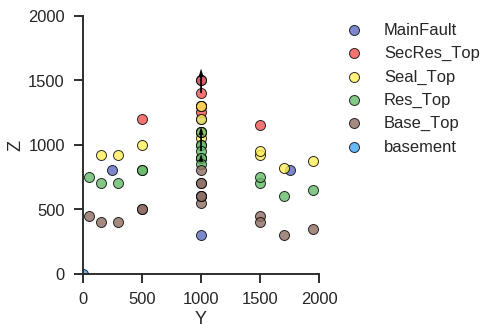

In [7]:
figsize(20,10)
#plt.savefig('points.pdf', transparent=True)
gp.plotting.plot_data(geo_data, direction='x')

In [8]:
# Creating a row label 'fault side' to distinguish between footwall (FW) and hanging wall (HW)
def set_fault_sides(geo_data, fault_border, fault_name):
    geo_data.interfaces['fault side'] = 'nan'
    HW_border = fault_border # distance of middle of fault (border HW/FW) from footwall border of model
                # (X = 2000 - 1300 = 700)
    nonfault_cond = geo_data.interfaces['formation'] != fault_name
    fault_cond = geo_data.interfaces['formation'] == fault_name

    fw_x_cond = geo_data.interfaces['X'] > (geo_data.extent[:2][1] - HW_border) # condition for FW points

    hw_x_cond = geo_data.interfaces['X'] < (geo_data.extent[:2][1] - HW_border) # condition for HW points

    geo_data.interfaces.loc[fw_x_cond,'fault side'] = 'footwall' # setting FW
    geo_data.interfaces.loc[hw_x_cond,'fault side'] = 'hanging wall' #setting HW
    geo_data.interfaces.loc[fault_cond,'fault side'] = 'nan'; # reverting fault points to 'nan'
    return geo_data

In [9]:
geo_data = set_fault_sides(geo_data, 1300, 'MainFault')

In [10]:
# INTERPOLATION
interp_data = gp.InterpolatorData(geo_data, u_grade = [1, 1], output='gradients',
                                 compile_theano=True, dtype ='float64', theano_optimizer='fast_run')

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of faults:  1


In [11]:
#interp_data.interpolator.tg.inf_factor.set_value(np.zeros(7, dtype='int32'))
#interp_data.interpolator.tg.inf_factor.get_value()

In [12]:
import pandas as pd

In [13]:

# COMPUTATION OF THE MODEL
lith_sol, fault_sol = gp.compute_model(interp_data)

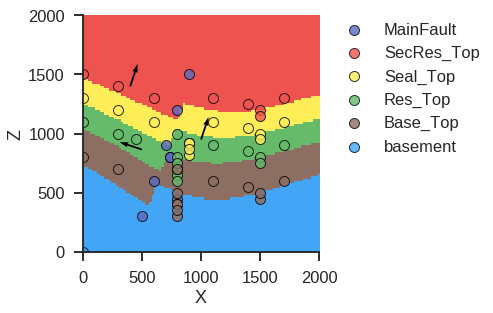

In [14]:
gp.plotting.plot_section(geo_data, lith_sol[0], 25, plot_data=True)

In [15]:
# Geo formation numbers
base_n = geo_data.formations.loc['basement','formation_number']
res_n = geo_data.formations.loc['Base_Top','formation_number']
seal_n = geo_data.formations.loc['Res_Top','formation_number']
secres_n = geo_data.formations.loc['Seal_Top','formation_number']
over_n = geo_data.formations.loc['SecRes_Top','formation_number']
fault_n = geo_data.formations.loc['MainFault','formation_number']

In [16]:
# CREATING SURFACES FOR LAYER INTERFACES (vertices and simplices; interfaces named as bottoms of layers)
res_surf_v, res_surf_s = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], 
                                         potential_fault=None, n_formation = res_n-1)
seal_surf_v, seal_surf_s = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], 
                                           potential_fault=None, n_formation = seal_n-1)
secres_surf_v, secres_surf_s = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], 
                                               potential_fault=None, n_formation = secres_n-1)
over_surf_v, over_surf_s = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], 
                                           potential_fault=None, n_formation = over_n-1)

fault_surf_v, fault_surf_s = gp.get_surfaces(interp_data = 
                                             interp_data, potential_lith=None, potential_fault=fault_sol[1], 
                                             n_formation = fault_n-1)

In [17]:
plot_3Dpoints = False
plot_3Dsurf = False

if plot_3Dpoints:
    # 3D plot points in VTK
    gp.plot_data_3D(geo_data)
elif plot_3Dsurf:
    # 3D plot points and surfaces in VTK
    gp.plotting.plot_surfaces_3D_real_time(geo_data, interp_data, [res_surf_v, seal_surf_v, secres_surf_v, over_surf_v], 
                    [res_surf_s, seal_surf_s, secres_surf_s, over_surf_s], plot_data=True
                   )

In [18]:
# DECLARING SOME MODEL VARIABLES
resolution = geo_data.resolution[1] #resolution, standard: 50
model_size = geo_data.extent[:2][1] # 'real' model extent, here: 2000 m - cubic (what if not cubic?)
scale_factor = (model_size/resolution) # scale factor used for calculating voxel volumes in [m]
                                        # here: 2000/50 = 40
rescale_f = interp_data.rescaling_factor # rescaling factor from geo_data to interp_data

minmax_buffer = True # buffer around local min and max values [on/off] - not used atm

SSF_c = 5

permeable_l = [secres_n, over_n]

In [19]:
vox_size_x = np.abs(geo_data.extent[1] - geo_data.extent[0]) / geo_data.resolution[0]
vox_size_y = np.abs(geo_data.extent[3] - geo_data.extent[2]) / geo_data.resolution[1]
vox_size_z = np.abs(geo_data.extent[5] - geo_data.extent[4]) / geo_data.resolution[2]
vox_size_diag = np.sqrt(vox_size_x ** 2 + vox_size_y ** 2 + vox_size_z ** 2)

In [ ]:
#%matplotlib notebook
%matplotlib inline
figsize(20,10)
#gp.plotting.plot_section(geo_data, lith_block, int(resolution/2), plot_data=1, direction='y')
#plt.savefig('computed_block.pdf', transparent=True)

In [ ]:
GX,GY,GZ=lith_sol[2].reshape(resolution,resolution,resolution), lith_sol[3].reshape(resolution,resolution,resolution), lith_sol[4].reshape(resolution,resolution,resolution)

In [ ]:
# LITHOLOGY BLOCK MASKING FUNCTIONS

# Masking function that confines to voxels which are part fo the reservoir formation,
# in the footwall side and above the z-horizontal defined by the spill or leak point
def res_mask(lith, fault, bottom_z, formation_bool, fault_bool, tc):
    mask = np.ones_like(lith)
    mask[~formation_bool] = False
    mask[fault_bool] = False
    #mask[fault.astype(bool)] = False
    if tc == 1:
        bottom_z = round((bottom_z/scale_factor)+0.5).astype(int) #rounding up to avoid voxel connection to outside borders
    else:
        bottom_z = round((bottom_z/scale_factor)).astype(int)
    mask = mask.reshape(resolution,resolution,resolution)
    mask[:,:,:bottom_z] = False
    mask = mask.reshape(resolution**3,)
    return mask

def topo_analysis(geo_data, lith, fault, seal_th, trap_n):
    formation_numbers = geo_data.interfaces['formation_number'].unique()
    traps = []
    # Padding of lith- and fault-block (creating border sections, formation number = 8)
    lith_pad = (np.pad(lith.reshape(resolution,resolution,resolution), 1, 'constant', constant_values = (0,0)))
    fault_pad = (np.pad(fault.reshape(resolution,resolution,resolution), 1, 'constant', constant_values = (0,0)))
    G, centroids, labels_unique, lith_to_labels_lot, labels_to_lith_lot, topo_block = \
        gp.topology.topology_analyze(lith_pad, fault_pad, 1, areas_bool=False, return_block=True)
    # Finding sections which are possible traps in the reservoir (formation number = 0)
    trap_keys = [int(k) for k in lith_to_labels_lot["%s" % trap_n].keys()] # potential trap sections
    pad_keys = [int(p) for p in lith_to_labels_lot["0"].keys()] # model border sections
    base_keys = [int(b) for b in lith_to_labels_lot["%s" % base_n].keys()]
    res_keys = [int(r) for r in lith_to_labels_lot["%s" % res_n].keys()]
    secres_keys = [int(j) for j in lith_to_labels_lot["%s" % secres_n].keys()] # sections in Secondary Reservoir
    over_keys = [int(o) for o in lith_to_labels_lot["%s" % over_n].keys()] # section in Overlying
    tot_under_keys = np.append(res_keys, base_keys) # all sections that belong to underlying below seal
    tot_over_keys = np.append(secres_keys, over_keys) # all sections that belong to overlying above seal
    bool_block = np.zeros_like(topo_block)
    #gp.topology.classify_edges(G, centroids, lith.reshape(resolution,resolution,resolution), fault.reshape(resolution,resolution,resolution))   
    gp.topology.classify_edges(G, centroids, lith_pad, fault_pad)   
    # If too many traps, model probably broken:
    print("NUMBER OF POTENTIAL TRAPS", len(trap_keys))
    if len(trap_keys) > 10:
        print('Too many traps detected. Reservoir discontinuous or model probably broken.')
        trap_mask = bool_block[1:-1,1:-1,1:-1]
        SSF = 0
        trap_control = 0
        return trap_mask
    else:
        # Check for each possible trap section, if it is connected to a border
        for tk in trap_keys:
            print('Checking Section:', tk)
            # Check for adjacency to model border
            if gp.topology.check_adjacency(G, tk, pad_keys[0]) == False:
                # Check for connection (juxtaposition!) to overlying layers (above seal) and SSF
                traps.append(tk)
                print('TRAP CONFIRMED:', tk)
        if traps == []:
            print('No trap found! =(')
        else:
            for i in traps:
                # Creating a mask from the trap sections in the label block
                top_bool = topo_block == i
                bool_block[top_bool] = True
        # Removing padding
        trap_mask = bool_block[1:-1,1:-1,1:-1]
        return trap_mask # this mask returns True for all voxels which were accepted as trap voxels

In [ ]:
# get juxtaposition with itself
def self_juxta(geo_data, lith_sol, fault_sol, fault_n, \
                        res_n):
    hw_array = fa.get_LF_contact_VOX(geo_data, lith_sol, fault_sol, res_n, fault_n, fault_side='hw')                           
    maxline_hw = fa.get_extrema_line_voxels(hw_array,extrema_type='max', artifact_filter='on') 
    if np.any(maxline_hw):
        max_jux = (np.max(np.argwhere(maxline_hw==True)[:,1]) * vox_size_z) + vox_size_z
        return max_jux
    else:
        return 0

#def self_juxta(geo_data, lith_sol, fault_sol, fault_n, \
#                        res_n):
#    juxta = fa.get_juxtapositions(geo_data, lith_sol, fault_sol, fault_n, \
#                        lith_target=res_n, lith_jux=res_n, target_side='fw', projection='automatic')
#    if np.any(juxta):
#        max_jux = (np.max(np.argwhere(juxta==True)[:,1]) * vox_size_z) + vox_size_z
#        return max_jux
#    else:
#        return 0

In [ ]:
#hw_array = fa.get_LF_contact_VOX(geo_data, lith_sol, fault_sol, res_n, fault_n, fault_side='hw')                           
#maxline_hw = fa.get_extrema_line_voxels(hw_array,extrema_type='max', artifact_filter='on') 
#if np.any(maxline_hw):
#    max_jux = (np.max(np.argwhere(maxline_hw==True)[:,1]) * vox_size_z) + vox_size_z

In [ ]:
# get juxtapositions with any other input perm layers
def perm_juxta(geo_data, lith_sol, fault_sol, fault_n, \
                        res_n, lith_perm):
    if isinstance(lith_perm, int):
        lith_perm = [lith_perm]
    juxta_list = np.zeros((len(lith_perm),2))
    juxta_list[:,0] = np.array(lith_perm)
    for i in lith_perm:
        juxta = fa.get_juxtapositions(geo_data, lith_sol, fault_sol, fault_n, \
                        res_n, i, target_side='fw', projection='automatic')
        if np.any(juxta):
            max_jux = (np.max(np.argwhere(juxta==True)[:,1]) * vox_size_z) + vox_size_z
            juxta_list[(np.argwhere(juxta_list[:,0]==i)),1] = max_jux
    juxta_list = np.delete(juxta_list, np.argwhere(juxta_list[:,1]==0), 0)
    return juxta_list        

In [ ]:
# get SSF on base of fault analysis module
def fa_SSF(geo_data, lith_sol, fault_sol, lith_n, fault_n,
                      position='faultmax_argrelmax', order=40):
    fault_throws = fa.get_faultthrow_at(geo_data, lith_sol, fault_sol, lith_n, fault_n,
                      position=position, order=order, artifact_filter='on')
    max_throw = np.nanmax(fault_throws)
    contact = fa.get_LF_contact_VOX(geo_data, lith_sol, fault_sol, lith_n, fault_n, fault_side='fw')
    proj = fa.project_voxels(contact, form='2D')
    lith_thickness = fa.get_lithcontact_thickness_at(geo_data, lith_sol, fault_sol, lith_n, fault_n, fault_side='fw',
                      position=position, order=order, artifact_filter='on')
    min_thickness = np.nanmin(lith_thickness)
    SSF = max_throw/min_thickness
    print('SSF = %s / %s = %s' % (max_throw, min_thickness, SSF))
    return SSF

In [ ]:
# MAIN FUNCTION: Calculation of maximum fill volume in reservoir traps
def max_trap_vol(geo_data, interp_data, lith_sol, fault_sol, res_n, seal_n, fault_n, GX, GY, seal_surf_v):
    formation_numbers = geo_data.interfaces['formation_number'].unique()
    trap_n = (np.max(formation_numbers)+1)
    
    lith_block = lith_sol[0]
    fault_block = fault_sol[0]
    
    seal_thickness_all = fa.get_lithcontact_thickness_at(geo_data, lith_sol, fault_sol, 
                                                 seal_n, fault_n, fault_side='fw',
                      position='faultmax_argrelmax', order=40)
    seal_thickness = np.nanmin(seal_thickness_all)
    
    seal_thresh = vox_size_z
    if seal_thickness < seal_thresh:
        print("Seal layer compromised, too thin.")
        print('CONTROL: STRAT. SEAL BREACH')
        # Trap failed due to assumed seal cap discontinuity: return no volume, no trap, SSF = nan
        return 0, np.zeros_like(lith_block), np.nan, 4    

    trap_control = 0 # intitiating variable that indicates what kind of mechanism controls the trap volume
                        # 0 = Unclear
                        # 1 = Spill Point
                        # 2 = Leak Point (LEAK UNDER)
                        # 3 = Seal breach juxtaposition leakage (LEAK OVER)
                        # 4 = Stratigraphical adjacency leakage 
    highest_spill_point = sp.get_highest_saddle_point(geo_data, seal_surf_v, GX, GY)
    
    if highest_spill_point == []:
        spill_z = np.nan
        print('No SPILL POINT found!')
        trap_vol = 0
        final_trap_mask = np.zeros_like(lith_block)
        return trap_vol, final_trap_mask, np.nan, 0
    
    spill_z = np.max(highest_spill_point[2])
    leak_self_z = self_juxta(geo_data, lith_sol, fault_sol, fault_n, res_n)
    # need to implement variability of permeable layers
    juxta_above = perm_juxta(geo_data, lith_sol, fault_sol, fault_n, res_n, lith_perm=permeable_l)
    
    print('SPILL POINT COORDINATES:', highest_spill_point)
    print('LEAK SELF Z-POSITION:', leak_self_z)
    print('JUXTA with permable layers:', juxta_above)

    SSF = fa_SSF(geo_data, lith_sol, fault_sol, seal_n, fault_n,
                      position='faultmax_argrelmax', order=40)
    if SSF > SSF_c:
        print('SSF threshold exceeded, shale smear assumed to be incomplete.')
        SSF_sealing = False
    else: 
        print('SSF in confidence range, complete shale smear sealing assumed.')
        SSF_sealing = True
        
    #general_sealing = False # might be implemented later (as binomial probability)
    
    if juxta_above.size == 0:
        leak_z = leak_self_z
        # no SSF necessary (but still have to be calculated if relevant in probabilistic model)
        # possible use of general fault sealing probability
        max_z = np.nanmax([spill_z, leak_z])  
        if max_z == spill_z:
            trap_control = 1
            print('CONTROL: SPILL Z')
        else:
            trap_control = 2
            print('CONTROL: LEAK Z')
    else:
        # check for SSF/general sealing
        if SSF_sealing == False: 
            leak_above_z = np.max(juxta_above[:,1])
            max_z = np.nanmax([spill_z, leak_above_z]) 
            if max_z == spill_z:
                trap_control = 1
                print('CONTROL: SPILL Z')
            else:
                trap_control = 3
                print('CONTROL: PERM. JUXTA Z')
        #elif general_sealing == False:
        #    max_z = np.nanmax([spill_z, leak_self_z])
        #    if max_z == spill_z:
        #        trap_control = 1
        #    else:
        #        trap_control = 2   
        else:
            max_z = spill_z
            trap_control = 1
            print('CONTROL: SPILL Z')
            
    ### MAKE AN OWN FUNCTION TO GET MAX_Z!              
        
    rounded_lith = np.around(lith_block).astype(int)
    rounded_fault = np.around(fault_block).astype(int)
    res_n_bool = rounded_lith == res_n
    fault_bool = rounded_lith == 2
        
    pre_trap_mask = res_mask(lith_block, fault_block, max_z, res_n_bool, fault_bool, tc = trap_control)
          
    # volume cells for counting
    vol_cells = 0
    lith_copy = np.copy(lith_block)
        
    pre_trap_mask_bool = (pre_trap_mask == True)
    # Check if there is anything in the reservoir mask at all
    if np.count_nonzero(pre_trap_mask_bool) == 0:
        print("No res_formation above max_z!")
        #trap_control = 0
        return 0, pre_trap_mask, SSF, trap_control
    else:
        lith_copy[pre_trap_mask_bool] = trap_n                           # setting reservoir above bottom on footwall side 
        final_trap_mask = topo_analysis(geo_data, lith_copy, fault_block, seal_thickness, trap_n)
        lith_copy[final_trap_mask] = (trap_n + 1)                        # setting final trap to formation value = trap_n + 1
        vol_cells = np.count_nonzero(final_trap_mask)
            
        #calulate volume from cells
        trap_vol = ((scale_factor)**3) * vol_cells 
        # revert to lith_block without any masks
        #lith[pre_trap_mask_bool] = res_n      
        #return the maximum reservoir volume
        return trap_vol, final_trap_mask, SSF, trap_control

In [ ]:
# PLOTTING FUNCTIONS: Spill and leak point visualization
def plot_spill_leak(res_surface, pot_spills, spill_point, leak_point, grid_x, grid_y, grid_z0):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(grid_x, grid_y, grid_z0, c="b", alpha = 0.1)
    #ax.scatter(grid_x, grid_y,pot_spills, c="r", alpha = 1, marker='p', s = 250)
    if spill_point.size != 0:        
        ax.scatter(spill_point[0],spill_point[1],spill_point[2], c="black", alpha = 1, marker='x', s = 250)
    if leak_point.size != 0:        
        ax.scatter(leak_point[0],leak_point[1],leak_point[2], c="black", alpha = 1, marker='+', s = 250)
        
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    plt.show()

### Setting up the probabilistic model

In [ ]:
lith_unc_stds = np.array([40,60,80,100])
#lith_unc_stds = np.array([20,60,100,200])

In [ ]:
lith_ids = geo_data.interfaces["formation"].dropna().unique()[1:-1]
print(lith_ids)

[SecRes_Top, Seal_Top, Res_Top, Base_Top]
Categories (6, object): [MainFault, SecRes_Top, Seal_Top, Res_Top, Base_Top, basement]


In [ ]:
lith_numbers = geo_data.formations.formation_number[1:]

In [ ]:
lith_Z_modifier = []

for liID, stdi in zip(lith_ids, lith_unc_stds):
    stoch = pymc.Normal(liID+'_stoch', 0, 1./np.square(stdi/rescale_f))
    lith_Z_modifier.append(stoch)

In [ ]:
faultside_ids = geo_data.interfaces["fault side"].dropna().unique()
print(faultside_ids)

['nan' 'hanging wall' 'footwall']


In [ ]:
std_offset = 150
fault_Z_modifier = pymc.SkewNormal(faultside_ids[1]+'offset_unc', 0/rescale_f, 1./np.square(std_offset/rescale_f), alpha=-2)

/home/fabian/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


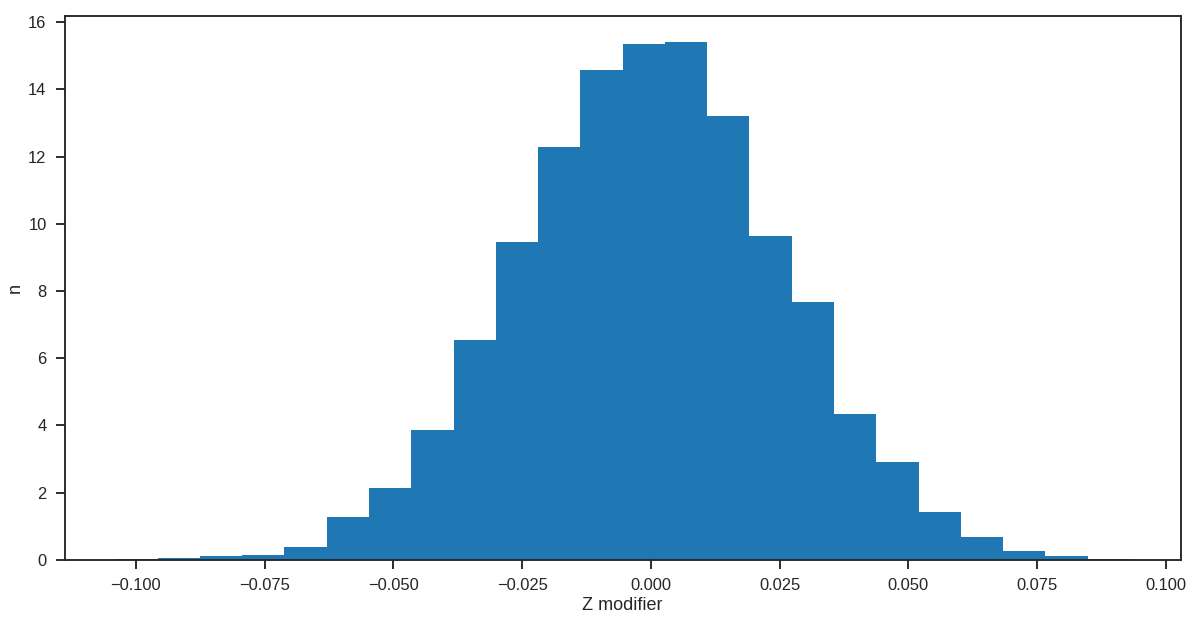

In [ ]:
# sample from a distribution
samples = [lith_Z_modifier[3].rand() for i in range(10000)]
# plot histogram
plt.hist(samples, bins=24, normed=True);
plt.xlabel("Z modifier")
plt.vlines(0, 0, 0.01)
plt.ylabel("n");

In [ ]:
import copy
geo_data_stoch_init = copy.deepcopy(interp_data.geo_data_res)
#interp_data_stoch_init = copy.deepcopy(interp_data)

In [ ]:
# NEW INTERP FUNCTION
@pymc.deterministic(trace=True)
def input_data(value=0, geo_data_stoch_init=geo_data_stoch_init, lith_Z_modifier=lith_Z_modifier, 
              fault_Z_modifier=fault_Z_modifier, verbose= 0):
    
    geo_data_stoch = gp.get_data(geo_data_stoch_init, numeric=True)
    
    for e, foID in enumerate(lith_ids):
        # First we obtain a boolean array with trues where the id coincide
        sel = gp.get_data(interp_data.geo_data_res, verbosity=2)['formation'] == foID
        
        # We add to the original Z value (its mean) the stochastic bit in the correspondant groups id 
        geo_data_stoch.loc[sel, 'Z']  += np.array(lith_Z_modifier[e])
        
    sel_fa = gp.get_data(interp_data.geo_data_res, verbosity=2)['fault side'] == 'hanging wall'
    geo_data_stoch.loc[sel_fa, 'Z']  += np.array(fault_Z_modifier)
    ''
    if verbose > 0:
        print(geo_data_stoch)
    return [geo_data_stoch.xs('interfaces')[["X", "Y", "Z"]].values, geo_data_stoch.xs('orientations').values]

In [ ]:
@pymc.deterministic(trace=False)
def gempy_model(value=0, input_data=input_data, seal_n=seal_n, print_figures=False):
    interp_data.geo_data_res.interfaces[["X", "Y", "Z"]] = input_data[0]
    interp_data.geo_data_res.orientations[["X", "Y", "Z", "G_x", "G_y", "G_z",
                                           'dip', 'azimuth', 'polarity']] = input_data[1]
    interp_data.interpolator.prepare_data_frame(interp_data.geo_data_res)
    try:
        # try to compute model
        ls, fs = gp.compute_model(interp_data)
        if print_figures:
            gp.plot_section(geo_data, ls[0], np.int(resolution/2), plot_data=False)
           # gp.plot_data(interp_data.geo_data_res, direction='y')

        return ls, fs, interp_data
    
    except np.linalg.linalg.LinAlgError as err:
        # if it fails (e.g. some input data combinations could lead to 
        # a singular matrix and thus break the chain) return an empty model
        # with same dimensions (just zeros)
        if verbose:
            print("Exception occured.")
        return np.zeros_like(lith_sol), np.zeros_like(fault_sol), interp_data

In [ ]:
@pymc.deterministic(trace=True)
def trap_analysis(value=0, lith_sol=gempy_model[0], fault_sol=gempy_model[1], 
                  interp_data=gempy_model[2], print_figures=False, verbose = False):
    
    seal_surf_V = gp.get_surfaces(\
        interp_data = interp_data, potential_lith=lith_sol[1], \
        potential_fault=fault_sol[1], n_formation = seal_n-1)[0]
    Gx,Gy=lith_sol[2].reshape(resolution,resolution,resolution), lith_sol[3].reshape(resolution,resolution,resolution)
    try:
        max_vol, trap, SSF, trap_control = max_trap_vol(geo_data, interp_data, 
                                                    lith_sol, fault_sol, res_n, 
                                                    seal_n, fault_n, Gx, Gy, seal_surf_V)
        print("Maximum trap volume: %s m³" % max_vol)
        if print_figures:
            gp.plotting.plot_section(geo_data, trap, int(resolution/2), plot_data =0)
        return max_vol, SSF, trap_control
    
    except (IndexError, ValueError):
        # if it fails (e.g. some input data combinations could lead to 
        # a singular matrix and thus break the chain) return an empty model
        # with same dimensions (just zeros)
        if verbose == True:
            print("Exception occured.")
        return np.nan, np.nan, 0
#@pymc.deterministic(trace=True)
#def trap_analysis(value=0, input_data=input_data, print_figures=False):
#    interp_data.geo_data_res.interfaces[["X", "Y", "Z"]] = input_data[0]
#    interp_data.geo_data_res.orientations[["X", "Y", "Z", "G_x", "G_y", "G_z",
#                                           'dip', 'azimuth', 'polarity']] = input_data[1]
#    interp_data.interpolator.prepare_data_frame(interp_data.geo_data_res)    
#    try:
#        # try to compute model
#        lith_sol, fault_sol = gp.compute_model(interp_data)
#        if print_figures:
#            gp.plot_section(interp_data.geo_data_res, lith_sol[0], np.int(resolution/2), plot_data=True)
#           # gp.plot_data(interp_data.geo_data_res, direction='y')
#    
#    except np.linalg.linalg.LinAlgError as err:
#        # if it fails (e.g. some input data combinations could lead to 
#        # a singular matrix and thus break the chain) return an empty model
#        # with same dimensions (just zeros)
#        if verbose:
#            print("Exception occured.")
#        return np.nan, np.nan, np.nan
#    
#    seal_surf_V = gp.get_surfaces(\
#        interp_data = interp_data, potential_lith=lith_sol[1], \
#        potential_fault=fault_sol[1], n_formation = seal_n-1)[0]
#    Gx,Gy=lith_sol[2].reshape(resolution,resolution,resolution), lith_sol[3].reshape(resolution,resolution,resolution)
#    max_vol, trap, SSF, trap_control = max_trap_vol(geo_data, interp_data, 
#                                                    lith_sol, fault_sol, res_n, 
#                                                    seal_n, fault_n, Gx, Gy, seal_surf_V)
#    print("Maximum trap volume: %s m³" % max_vol)
#    if print_figures:
#        gp.plotting.plot_section(geo_data, trap, int(resolution/2), plot_data =0)
#    return max_vol, SSF, trap_control

No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          720.83862305]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 460.0 / 240.0 = 1.9166666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 77
Maximum trap volume: 20624000.0 m³


In [ ]:
def trap_analysis_post(lith_sol, fault_sol, print_figures=False):
    lith_block = lith_sol[0]
    fault_block = fault_sol[0]  
    seal_surf_V = gp.get_surfaces(\
        interp_data = interp_data, potential_lith=lith_sol[1], \
        potential_fault=fault_sol[1], n_formation = seal_n-1)[0]
    Gx,Gy=lith_sol[2].reshape(resolution,resolution,resolution), lith_sol[3].reshape(resolution,resolution,resolution)
    max_vol, trap, SSF, trap_control = max_trap_vol(geo_data, interp_data, 
                                                    lith_sol, fault_sol, res_n, 
                                                    seal_n, fault_n, Gx, Gy, seal_surf_V)
    print("Maximum trap volume: %s m³" % max_vol)
    print('TRAP VOXELS:', np.count_nonzero(trap))
    if print_figures:
        gp.plotting.plot_section(geo_data, trap, int(resolution/2), plot_data =0)
    return max_vol, SSF, trap_control # trap --> what to do about trap return?

In [ ]:
# for setting up postional conditions to determine thicknesses and the like:
fw_th_point = 900 # distance of test point for thickness from footwall border of model 
                  # (e.g.: X = 2000 - 900 = 1100)
HW_border = 1300 # distance of middle of fault (border HW/FW) from footwall border of model
                # (X = 2000 - 1300 = 700)
    
# Boolean conditions to find data points for each formation
base_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'Base_Top'
res_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'Res_Top'
seal_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'Seal_Top'
secres_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'SecRes_Top'

# Footwall and hanging wall conditions
footwall = interp_data.geo_data_res.interfaces['fault side'] == 'footwall'
hanging_wall = interp_data.geo_data_res.interfaces['fault side'] == 'hanging wall'

In [ ]:
# Reservoir thickness
@pymc.deterministic(trace=True)
def thicknesses(value=0, input_data=input_data):
    interp_data.geo_data_res.interfaces[["X", "Y", "Z"]] = input_data[0]
    interp_data.geo_data_res.orientations[["X", "Y", "Z", "G_x", "G_y", "G_z",
                                           'dip', 'azimuth', 'polarity']] = input_data[1]
    fw_x = interp_data.geo_data_res.interfaces['X'] == (interp_data.geo_data_res.extent[1] - (fw_th_point/rescale_f))
    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.geo_data_res.extent[3] - (1000/rescale_f))
    points_fw = interp_data.geo_data_res.interfaces[fw_x]
    points_fw = points_fw[y_mid] 
    fw_rb_z = points_fw[base_top_cond]['Z'].values*rescale_f
    fw_sb_z = points_fw[res_top_cond]['Z'].values*rescale_f
    fw_r2b_z = points_fw[seal_top_cond]['Z'].values*rescale_f
    fw_ob_z = points_fw[secres_top_cond]['Z'].values*rescale_f
    res_th = np.abs(fw_sb_z-fw_rb_z)
    seal_th = np.abs(fw_r2b_z-fw_sb_z)
    secres_th = np.abs(fw_ob_z-fw_r2b_z) 
    return res_th, seal_th, secres_th

#Seal thickness
#@pymc.deterministic(trace=True)
#def seal_th(value=0, input_data=input_data):
#    fw_x = interp_data.geo_data_res.interfaces['X'] == (interp_data.geo_data_res.extent[1] - (fw_th_point/rescale_f))
#    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.geo_data_res.extent[3] - (1000/rescale_f))
#    points_fw = interp_data.geo_data_res.interfaces[fw_x]
#    points_fw = points_fw[y_mid] 
#    fw_r2b_z = points_fw[seal_top_cond]['Z'].values*rescale_f
#    fw_sb_z = points_fw[res_top_cond]['Z'].values*rescale_f
#    return np.abs(fw_r2b_z-fw_sb_z)
#
## Secondary reservoir thickness
#@pymc.deterministic(trace=True)
#def sec_res_th(value=0, input_data=input_data):
#    fw_x = interp_data.geo_data_res.interfaces['X'] == (interp_data.geo_data_res.extent[1] - (fw_th_point/rescale_f))
#    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.geo_data_res.extent[3] - (1000/rescale_f))
#    points_fw = interp_data.geo_data_res.interfaces[fw_x]
#    points_fw = points_fw[y_mid] 
#    fw_r2b_z = points_fw[seal_top_cond]['Z'].values*rescale_f
#    fw_ob_z = points_fw[secres_top_cond]['Z'].values*rescale_f
#    return np.abs(fw_ob_z-fw_r2b_z) 

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [ ]:
block = np.round(lith_sol[0]).astype(int)
block_fb = np.round(fault_sol[0]).astype(int)

lith_id = np.unique(np.round(block).astype(int))
fault_id = np.unique(np.round(block).astype(int))

count = np.zeros((len(lith_id), block.shape[0]))
count_fb = np.zeros((len(fault_id), block_fb.shape[0]))  

@pymc.deterministic(trace=True)
def lith_prob(value=0, lith_sol=gempy_model[0], fault_sol=gempy_model[1]):
    block = np.round(lith_sol[0]).astype(int)
    block_fb = np.round(fault_sol[0]).astype(int)
    for i, l_id in enumerate(lith_id):
        count[i][block == l_id] += 1 #sum up frequency
    for i, f_id in enumerate(fault_id):
        count_fb[i][block_fb == f_id] += 1 #sum up frequency

In [ ]:
iterations = 10000

In [ ]:
params = [input_data, thicknesses, gempy_model, trap_analysis, lith_prob, *lith_Z_modifier, fault_Z_modifier]
#params = [input_data, res_th_likelihood, seal_th_likelihood, sec_res_th_likelihood, thicknesses, gempy_model, trap_analysis, lith_prob, *lith_Z_modifier, fault_Z_modifier]
#params = [input_data, SSF_likelihood, thicknesses, gempy_model, trap_analysis, lith_prob, *lith_Z_modifier, fault_Z_modifier]
#params = [input_data, res_th_likelihood, seal_th_likelihood, sec_res_th_likelihood, SSF_likelihood, thicknesses, gempy_model, trap_analysis, lith_prob, *lith_Z_modifier, fault_Z_modifier]
model = pymc.Model(params)
#model = pymc.Model([interp_unc, z_unc_res_top, z_unc_base_top, z_unc_seal_top, z_unc_secres_top, offset_unc, structural_model, res_th, seal_th, sec_res_th, over_jux_area])

In [ ]:
dbname="trapmodel_lithSIMPLEMCfinal1"+str(lith_unc_stds)+"_offset"+str(std_offset)+"_"+str(iterations)+"iterations"+".hdf5"
#dbname='test.hdf5'

In [ ]:
RUN = pymc.MCMC(model, db="hdf5", dbname=dbname)
#RUN = pymc.MCMC(model)

In [ ]:
RUN.sample(iter=iterations, save_interval=50)

No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         812.7318573]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 280.0 / 40.0 = 7.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  0%                  ] 2 of 10000 complete in 16.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          840.70343018]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 420.0 / 60.0 = 7.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  0%                  ] 3 of 10000 complete in 33.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          851.36756897]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1020.]]
SSF = 520.0 / 40.0 = 13.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  0%                  ] 4 of 10000 complete in 48.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [                  0%                  ] 5 of 10000 complete in 62.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          751.05522156]
LEAK SELF Z-POSITION: 520.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 720.0 / 40.0 = 18.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  0%                  ] 6 of 10000 complete in 79.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          880.45661926]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 420.0 / 140.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 84
TRAP CONFIRMED: 84
Checking Section: 142
Maximum trap volume: 17208000.0 m³
 [                  0%                  ] 7 of 10000 complete in 101.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          881.34277344]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 40.0 = 10.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  0%                  ] 8 of 10000 complete in 118.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          953.16650391]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1120.]]
SSF = 640.0 / 40.0 = 16.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  0%                  ] 9 of 10000 complete in 135.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          837.87864685]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 60.0 / 180.0 = 0.3333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 18
Maximum trap volume: 2672000.0 m³
 [                  0%                  ] 10 of 10000 complete in 154.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [                  0%                  ] 11 of 10000 complete in 169.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          800.49575806]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 280.0 / 140.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 57
Maximum trap volume: 18640000.0 m³
 [                  0%                  ] 12 of 10000 complete in 189.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          797.78167725]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 400.0 / 160.0 = 2.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 41
TRAP CONFIRMED: 41
Checking Section: 44
TRAP CONFIRMED: 44
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 79
Maximum trap volume: 24920000.0 m³
 [                  0%                  ] 13 of 10000 complete in 210.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          889.94369507]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 340.0 / 20.0 = 17.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  0%                  ] 14 of 10000 complete in 226.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          832.98927307]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 60.0 / 160.0 = 0.375
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Checking Section: 15
Maximum trap volume: 2352000.0 m³
 [                  0%                  ] 15 of 10000 complete in 246.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         884.7467041]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 260.0 / 60.0 = 4.333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 67
Maximum trap volume: 18448000.0 m³
 [                  0%                  ] 16 of 10000 complete in 266.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          742.98736572]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 500.0 / 40.0 = 12.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 80
Maximum trap volume: 20824000.0 m³
 [                  0%                  ] 17 of 10000 complete in 286.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          866.43089294]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1040.]]
SSF = 480.0 / 60.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  0%                  ] 18 of 10000 complete in 302.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          752.55630493]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 200.0 / 40.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 80
Maximum trap volume: 23672000.0 m³
 [                  0%                  ] 19 of 10000 complete in 324.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          908.34503174]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 420.0 / 100.0 = 4.2
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 86
TRAP CONFIRMED: 86
Checking Section: 92
TRAP CONFIRMED: 92
Checking Section: 151
Maximum trap volume: 18968000.0 m³
 [                  0%                  ] 20 of 10000 complete in 346.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          773.91578674]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: []
SSF = 440.0 / 240.0 = 1.8333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 33
TRAP CONFIRMED: 33
Checking Section: 58
Maximum trap volume: 23184000.0 m³
 [                  0%                  ] 21 of 10000 complete in 366.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [                  0%                  ] 22 of 10000 complete in 379.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          823.66027832]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  0%                  ] 23 of 10000 complete in 394.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          919.09675598]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [                  0%                  ] 24 of 10000 complete in 416.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          896.17980957]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  0%                  ] 25 of 10000 complete in 432.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          918.86291504]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 320.0 / 20.0 = 16.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  0%                  ] 26 of 10000 complete in 448.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          751.28448486]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 500.0 / 40.0 = 12.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 52
TRAP CONFIRMED: 52
Checking Section: 109
Maximum trap volume: 23736000.0 m³
 [                  0%                  ] 27 of 10000 complete in 469.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          798.37638855]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 360.0 / 80.0 = 4.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 65
TRAP CONFIRMED: 65
Checking Section: 72
TRAP CONFIRMED: 72
Checking Section: 119
Maximum trap volume: 25392000.0 m³
 [                  0%                  ] 28 of 10000 complete in 491.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [                  0%                  ] 29 of 10000 complete in 505.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          856.16638184]
LEAK SELF Z-POSITION: 960.0
JUXTA with permable layers: []
SSF = 120.0 / 60.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 22
Maximum trap volume: 2496000.0 m³
 [                  0%                  ] 30 of 10000 complete in 525.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          951.75033569]
LEAK SELF Z-POSITION: 960.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 240.0 / 80.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 26
TRAP CONFIRMED: 26
Checking Section: 27
TRAP CONFIRMED: 27
Checking Section: 28
TRAP CONFIRMED: 28
Checking Section: 56
Maximum trap volume: 18328000.0 m³
 [                  0%                  ] 31 of 10000 complete in 546.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          799.03465271]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 80.0 / 160.0 = 0.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 24
Maximum trap volume: 5456000.0 m³
 [                  0%                  ] 32 of 10000 complete in 565.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [                  0%                  ] 33 of 10000 complete in 579.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          725.12405396]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 540.0 / 200.0 = 2.7
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 73
TRAP CONFIRMED: 73
Checking Section: 75
TRAP CONFIRMED: 75
Checking Section: 134
Maximum trap volume: 12808000.0 m³
 [                  0%                  ] 34 of 10000 complete in 601.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          814.53475952]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 102
Maximum trap volume: 22816000.0 m³
 [                  0%                  ] 35 of 10000 complete in 622.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original ext

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          917.28523254]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1080.]]
SSF = 560.0 / 40.0 = 14.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  0%                  ] 37 of 10000 complete in 659.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         923.2308197]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1080.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  0%                  ] 38 of 10000 complete in 676.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          784.84184265]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 420.0 / 200.0 = 2.1
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 49
TRAP CONFIRMED: 49
Checking Section: 99
Maximum trap volume: 20232000.0 m³
 [                  0%                  ] 39 of 10000 complete in 697.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          809.96406555]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 240.0 / 140.0 = 1.7142857142857142
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 15
TRAP CONFIRMED: 15
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 25
Maximum trap volume: 7152000.0 m³
 [                  0%                  ] 40 of 10000 complete in 717.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [                  0%                  ] 41 of 10000 complete in 730.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          795.47927856]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 400.0 / 120.0 = 3.3333333333333335
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 56
TRAP CONFIRMED: 56
Checking Section: 116
Maximum trap volume: 17672000.0 m³
 [                  0%                  ] 42 of 10000 complete in 751.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          965.72280884]
LEAK SELF Z-POSITION: 980.0
JUXTA with permable layers: [[   3. 1120.]]
SSF = 260.0 / 40.0 = 6.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [                  0%                  ] 43 of 10000 complete in 772.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          837.03369141]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 340.0 / 140.0 = 2.4285714285714284
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 47
TRAP CONFIRMED: 47
Checking Section: 77
Maximum trap volume: 23424000.0 m³
 [                  0%                  ] 44 of 10000 complete in 793.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         836.6129303]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 360.0 / 140.0 = 2.5714285714285716
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 86
Maximum trap volume: 23136000.0 m³
 [                  0%                  ] 45 of 10000 complete in 814.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          861.66442871]
LEAK SELF Z-POSITION: 740.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 420.0 / 160.0 = 2.625
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 63
TRAP CONFIRMED: 63
Checking Section: 118
Maximum trap volume: 17248000.0 m³
 [                  0%                  ] 46 of 10000 complete in 836.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          749.20791626]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: []
SSF = 240.0 / 40.0 = 6.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 57
TRAP CONFIRMED: 57
Checking Section: 110
Maximum trap volume: 23112000.0 m³
 [                  0%                  ] 47 of 10000 complete in 857.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          896.26571655]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1060.]]
SSF = 440.0 / 40.0 = 11.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  0%                  ] 48 of 10000 complete in 874.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          843.54415894]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 580.0 / 40.0 = 14.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  0%                  ] 49 of 10000 complete in 890.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          783.79219055]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: []
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 6
Checking Section: 3
Checking Section: 27
TRAP CONFIRMED: 27
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 33
TRAP CONFIRMED: 33
Checking Section: 66
Maximum trap volume: 11448000.0 m³
 [                  0%                  ] 50 of 10000 complete in 910.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          960.47523499]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1120.]]
SSF = 320.0 / 40.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  0%                  ] 51 of 10000 complete in 926.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [                  0%                  ] 52 of 10000 complete in 940.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          852.28599548]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 460.0 / 120.0 = 3.8333333333333335
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 88
TRAP CONFIRMED: 88
Checking Section: 144
Maximum trap volume: 21320000.0 m³
 [                  0%                  ] 53 of 10000 complete in 962.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         674.4657135]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: []
SSF = 400.0 / 320.0 = 1.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 18
Maximum trap volume: 3800000.0 m³
 [                  0%                  ] 54 of 10000 complete in 983.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          791.84036255]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 180.0 / 220.0 = 0.8181818181818182
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 49
TRAP CONFIRMED: 49
Checking Section: 88
Maximum trap volume: 22448000.0 m³
 [                  0%                  ] 55 of 10000 complete in 1004.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          829.68521118]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 420.0 / 60.0 = 7.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  0%                  ] 56 of 10000 complete in 1021.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          755.18882751]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 600.0 / 40.0 = 15.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 97
TRAP CONFIRMED: 97
Maximum trap volume: 48000.0 m³
 [                  0%                  ] 57 of 10000 complete in 1042.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          859.18807983]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 300.0 / 40.0 = 7.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 56
Maximum trap volume: 17040000.0 m³
 [                  0%                  ] 58 of 10000 complete in 1062.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         917.0565033]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1080.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  0%                  ] 59 of 10000 complete in 1079.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          851.62696838]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 240.0 / 40.0 = 6.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 59
TRAP CONFIRMED: 59
Checking Section: 62
TRAP CONFIRMED: 62
Checking Section: 104
Maximum trap volume: 21104000.0 m³
 [                  0%                  ] 60 of 10000 complete in 1099.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          856.50688171]
LEAK SELF Z-POSITION: 960.0
JUXTA with permable layers: []
SSF = 180.0 / 120.0 = 1.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 14
TRAP CONFIRMED: 14
Checking Section: 20
Maximum trap volume: 2504000.0 m³
 [                  0%                  ] 61 of 10000 complete in 1120.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         767.5201416]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 480.0 / 60.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 47
TRAP CONFIRMED: 47
Checking Section: 48
TRAP CONFIRMED: 48
Checking Section: 100
Maximum trap volume: 21936000.0 m³
 [                  0%                  ] 62 of 10000 complete in 1141.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          835.18630981]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 260.0 / 160.0 = 1.625
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 26
TRAP CONFIRMED: 26
Checking Section: 27
TRAP CONFIRMED: 27
Checking Section: 45
Maximum trap volume: 11392000.0 m³
 [                  0%                  ] 63 of 10000 complete in 1162.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [                  0%                  ] 64 of 10000 complete in 1176.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          751.82868958]
LEAK SELF Z-POSITION: 420.0
JUXTA with permable layers: [[  3. 880.]
 [  2. 920.]]
SSF = 700.0 / 60.0 = 11.666666666666666
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  0%                  ] 65 of 10000 complete in 1192.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          802.87338257]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 400.0 / 160.0 = 2.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 41
TRAP CONFIRMED: 41
Checking Section: 78
Maximum trap volume: 19424000.0 m³
 [                  0%                  ] 66 of 10000 complete in 1212.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          882.56713867]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  0%                  ] 67 of 10000 complete in 1229.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          879.17419434]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [                  0%                  ] 68 of 10000 complete in 1250.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          823.80004883]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 300.0 / 140.0 = 2.142857142857143
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 34
TRAP CONFIRMED: 34
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 69
Maximum trap volume: 18992000.0 m³
 [                  0%                  ] 69 of 10000 complete in 1271.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          831.12632751]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 360.0 / 180.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 70
Maximum trap volume: 21112000.0 m³
 [                  0%                  ] 70 of 10000 complete in 1291.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [                  0%                  ] 71 of 10000 complete in 1304.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          783.32595825]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 440.0 / 160.0 = 2.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 61
TRAP CONFIRMED: 61
Checking Section: 71
TRAP CONFIRMED: 71
Checking Section: 120
Maximum trap volume: 19512000.0 m³
 [                  0%                  ] 72 of 10000 complete in 1326.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          898.86566162]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 420.0 / 60.0 = 7.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 49
TRAP CONFIRMED: 49
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 95
Maximum trap volume: 21576000.0 m³
 [                  0%                  ] 73 of 10000 complete in 1347.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          833.78684998]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 400.0 / 140.0 = 2.857142857142857
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 49
TRAP CONFIRMED: 49
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 94
Maximum trap volume: 22368000.0 m³
 [                  0%                  ] 74 of 10000 complete in 1368.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          783.56216431]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 340.0 / 220.0 = 1.5454545454545454
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 22
TRAP CONFIRMED: 22
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 41
Maximum trap volume: 14248000.0 m³
 [                  0%                  ] 75 of 10000 complete in 1388.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          848.91075134]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: []
SSF = 260.0 / 120.0 = 2.1666666666666665
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 26
TRAP CONFIRMED: 26
Checking Section: 27
TRAP CONFIRMED: 27
Checking Section: 45
Maximum trap volume: 10176000.0 m³
 [                  0%                  ] 76 of 10000 complete in 1408.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          787.46253967]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 420.0 / 200.0 = 2.1
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 44
TRAP CONFIRMED: 44
Checking Section: 47
TRAP CONFIRMED: 47
Checking Section: 80
Maximum trap volume: 21528000.0 m³
 [                  0%                  ] 77 of 10000 complete in 1428.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          858.27224731]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 440.0 / 40.0 = 11.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  0%                  ] 78 of 10000 complete in 1444.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         885.3805542]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  0%                  ] 79 of 10000 complete in 1460.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          873.22883606]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 200.0 / 40.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 66
TRAP CONFIRMED: 66
Checking Section: 67
TRAP CONFIRMED: 67
Checking Section: 119
Maximum trap volume: 21232000.0 m³
 [                  0%                  ] 80 of 10000 complete in 1482.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [                  0%                  ] 81 of 10000 complete in 1496.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          890.75302124]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1060.]]
SSF = 620.0 / 140.0 = 4.428571428571429
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 160
TRAP CONFIRMED: 160
Checking Section: 238
Maximum trap volume: 20008000.0 m³
 [                  0%                  ] 82 of 10000 complete in 1519.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


SPILL POINT COORDINATES: [1360.          960.          972.04185486]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1120.]
 [   2. 1140.]]
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter posit

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          837.35992432]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 200.0 / 80.0 = 2.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 21
TRAP CONFIRMED: 21
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 40
Maximum trap volume: 23544000.0 m³
 [                  0%                  ] 84 of 10000 complete in 1556.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          906.17408752]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 420.0 / 100.0 = 4.2
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 94
TRAP CONFIRMED: 94
Checking Section: 144
Maximum trap volume: 18216000.0 m³
 [                  0%                  ] 85 of 10000 complete in 1578.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          886.15341187]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 7
Checking Section: 91
TRAP CONFIRMED: 91
Maximum trap volume: 32000.0 m³
 [                  0%                  ] 86 of 10000 complete in 1599.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [                  0%                  ] 87 of 10000 complete in 1612.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          855.46615601]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 320.0 / 180.0 = 1.7777777777777777
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 34
TRAP CONFIRMED: 34
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 54
Maximum trap volume: 16024000.0 m³
 [                  0%                  ] 88 of 10000 complete in 1632.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          851.89903259]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  0%                  ] 89 of 10000 complete in 1647.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          734.06402588]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 420.0 / 280.0 = 1.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 28
TRAP CONFIRMED: 28
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 55
Maximum trap volume: 18072000.0 m³
 [                  0%                  ] 90 of 10000 complete in 1668.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          726.69624329]
LEAK SELF Z-POSITION: 460.0
JUXTA with permable layers: [[  3. 900.]]
SSF = 580.0 / 80.0 = 7.25
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  0%                  ] 91 of 10000 complete in 1684.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


SPILL POINT COORDINATES: [ 580.          840.         1133.58207703]
LEAK SELF Z-POSITION: 1180.0
JUXTA with permable layers: []
SSF = 40.0 / 20.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [                  0%                  ] 92 of 10000 complete in 1707.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          885.95352173]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  0%                  ] 93 of 10000 complete in 1723.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          804.95483398]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 460.0 / 180.0 = 2.5555555555555554
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 58
TRAP CONFIRMED: 58
Checking Section: 110
Maximum trap volume: 19960000.0 m³
 [                  0%                  ] 94 of 10000 complete in 1745.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          812.86659241]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 58
TRAP CONFIRMED: 58
Checking Section: 116
Maximum trap volume: 22552000.0 m³
 [                  0%                  ] 95 of 10000 complete in 1766.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          801.94274902]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 60.0 / 160.0 = 0.375
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Maximum trap volume: 656000.0 m³
 [                  0%                  ] 96 of 10000 complete in 1785.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         823.4765625]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 140.0 / 260.0 = 0.5384615384615384
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 62
Maximum trap volume: 18552000.0 m³
 [                  0%                  ] 97 of 10000 complete in 1805.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          837.09312439]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 420.0 / 60.0 = 7.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  0%                  ] 98 of 10000 complete in 1821.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          795.31112671]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 360.0 / 120.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 47
TRAP CONFIRMED: 47
Checking Section: 84
Maximum trap volume: 24056000.0 m³
 [                  0%                  ] 99 of 10000 complete in 1842.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [                  1%                  ] 100 of 10000 complete in 1855.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          829.45587158]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  1%                  ] 101 of 10000 complete in 1872.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          805.28961182]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 400.0 / 180.0 = 2.2222222222222223
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 44
TRAP CONFIRMED: 44
Checking Section: 77
Maximum trap volume: 19768000.0 m³
 [                  1%                  ] 102 of 10000 complete in 1892.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          861.60202026]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1040.]]
SSF = 500.0 / 120.0 = 4.166666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 115
TRAP CONFIRMED: 115
Checking Section: 199
Maximum trap volume: 17936000.0 m³
 [                  1%                  ] 103 of 10000 complete in 1915.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          738.42918396]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 600.0 / 240.0 = 2.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 71
TRAP CONFIRMED: 71
Checking Section: 148
Maximum trap volume: 26584000.0 m³
 [                  1%                  ] 104 of 10000 complete in 1937.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          881.40228271]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 560.0 / 40.0 = 14.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  1%                  ] 105 of 10000 complete in 1954.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          867.48893738]
LEAK SELF Z-POSITION: 520.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1040.]]
SSF = 620.0 / 120.0 = 5.166666666666667
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  1%                  ] 106 of 10000 complete in 1970.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          849.97306824]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 80.0 / 120.0 = 0.6666666666666666
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 25
Maximum trap volume: 3944000.0 m³
 [                  1%                  ] 107 of 10000 complete in 1990.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          877.29980469]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 120.0 / 100.0 = 1.2
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 27
TRAP CONFIRMED: 27
Checking Section: 41
Maximum trap volume: 7504000.0 m³
 [                  1%                  ] 108 of 10000 complete in 2010.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          873.67752075]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 59
TRAP CONFIRMED: 59
Checking Section: 124
Maximum trap volume: 20520000.0 m³
 [                  1%                  ] 109 of 10000 complete in 2032.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          729.26071167]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: []
SSF = 540.0 / 240.0 = 2.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 48
TRAP CONFIRMED: 48
Checking Section: 99
Maximum trap volume: 21784000.0 m³
 [                  1%                  ] 110 of 10000 complete in 2054.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


SPILL POINT COORDINATES: [1360.          960.          881.64909363]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1040.]]
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in orig

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          874.54696655]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 280.0 / 40.0 = 7.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [                  1%                  ] 112 of 10000 complete in 2092.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          939.27787781]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1100.]]
SSF = 420.0 / 20.0 = 21.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  1%                  ] 113 of 10000 complete in 2108.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          766.84608459]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[  3. 940.]]
SSF = 600.0 / 220.0 = 2.727272727272727
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 86
TRAP CONFIRMED: 86
Checking Section: 172
Maximum trap volume: 22360000.0 m³
 [                  1%                  ] 114 of 10000 complete in 2131.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          786.37763977]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 240.0 / 140.0 = 1.7142857142857142
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 49
TRAP CONFIRMED: 49
Checking Section: 58
TRAP CONFIRMED: 58
Checking Section: 99
Maximum trap volume: 21408000.0 m³
 [                  1%                  ] 115 of 10000 complete in 2152.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          868.94515991]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 340.0 / 140.0 = 2.4285714285714284
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 49
TRAP CONFIRMED: 49
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 87
Maximum trap volume: 19784000.0 m³
 [                  1%                  ] 116 of 10000 complete in 2173.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          824.86968994]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  1%                  ] 117 of 10000 complete in 2189.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original ext

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          710.37338257]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 60.0 / 200.0 = 0.3
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 14
TRAP CONFIRMED: 14
Checking Section: 22
Maximum trap volume: 3144000.0 m³
 [                  1%                  ] 119 of 10000 complete in 2240.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1340.          960.          987.95021057]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1120.]]
SSF = 240.0 / 0.0 = inf
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  1%                  ] 120 of 10000 complete in 2257.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          764.15252686]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 940.]]
SSF = 340.0 / 60.0 = 5.666666666666667
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  1%                  ] 121 of 10000 complete in 2273.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [                  1%                  ] 122 of 10000 complete in 2287.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          910.36384583]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 280.0 / 60.0 = 4.666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 56
TRAP CONFIRMED: 56
Checking Section: 62
TRAP CONFIRMED: 62
Checking Section: 94
Maximum trap volume: 19480000.0 m³
 [                  1%                  ] 123 of 10000 complete in 2308.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          807.90786743]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 300.0 / 40.0 = 7.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 50
Maximum trap volume: 20808000.0 m³
 [                  1%                  ] 124 of 10000 complete in 2328.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          771.03012085]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: []
SSF = 260.0 / 40.0 = 6.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 59
TRAP CONFIRMED: 59
Checking Section: 108
Maximum trap volume: 22448000.0 m³
 [                  1%                  ] 125 of 10000 complete in 2350.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          697.94906616]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 480.0 / 320.0 = 1.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 56
Maximum trap volume: 20720000.0 m³
 [                  1%                  ] 126 of 10000 complete in 2370.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          975.32333374]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: [[   3. 1140.]]
SSF = 320.0 / 40.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [                  1%                  ] 127 of 10000 complete in 2392.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          823.99093628]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 400.0 / 40.0 = 10.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  1%                  ] 128 of 10000 complete in 2407.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          785.45753479]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 340.0 / 160.0 = 2.125
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 51
Maximum trap volume: 14560000.0 m³
 [                  1%                  ] 129 of 10000 complete in 2427.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          946.99356079]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 260.0 / 40.0 = 6.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  1%                  ] 130 of 10000 complete in 2444.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          924.88891602]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 380.0 / 100.0 = 3.8
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 79
TRAP CONFIRMED: 79
Checking Section: 128
Maximum trap volume: 17120000.0 m³
 [                  1%                  ] 131 of 10000 complete in 2466.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          875.51803589]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  1%                  ] 132 of 10000 complete in 2482.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          778.64967346]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 600.0 / 60.0 = 10.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  1%                  ] 133 of 10000 complete in 2498.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          854.51919556]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1020.]]
SSF = 580.0 / 40.0 = 14.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  1%                  ] 134 of 10000 complete in 2515.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          925.19805908]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1100.]]
SSF = 560.0 / 40.0 = 14.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  1%                  ] 135 of 10000 complete in 2531.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [                  1%                  ] 136 of 10000 complete in 2545.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          775.67306519]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 500.0 / 60.0 = 8.333333333333334
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  1%                  ] 137 of 10000 complete in 2562.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          835.70343018]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 380.0 / 120.0 = 3.1666666666666665
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 99
TRAP CONFIRMED: 99
Checking Section: 175
Maximum trap volume: 23456000.0 m³
 [                  1%                  ] 138 of 10000 complete in 2584.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          861.44126892]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 240.0 / 100.0 = 2.4
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 27
TRAP CONFIRMED: 27
Checking Section: 28
TRAP CONFIRMED: 28
Checking Section: 49
Maximum trap volume: 17352000.0 m³
 [                  1%                  ] 139 of 10000 complete in 2605.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         703.3581543]
LEAK SELF Z-POSITION: 520.0
JUXTA with permable layers: [[  3. 880.]]
SSF = 640.0 / 60.0 = 10.666666666666666
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  1%                  ] 140 of 10000 complete in 2621.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          840.49583435]
LEAK SELF Z-POSITION: 960.0
JUXTA with permable layers: []
SSF = 40.0 / 120.0 = 0.3333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 4
Checking Section: 12
TRAP CONFIRMED: 12
Maximum trap volume: 1400000.0 m³
 [                  1%                  ] 141 of 10000 complete in 2641.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          794.15870667]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 480.0 / 160.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 62
TRAP CONFIRMED: 62
Checking Section: 71
TRAP CONFIRMED: 71
Checking Section: 132
Maximum trap volume: 23464000.0 m³
 [                  1%                  ] 142 of 10000 complete in 2663.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          810.29327393]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 40.0 / 200.0 = 0.2
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 4
Checking Section: 12
TRAP CONFIRMED: 12
Maximum trap volume: 1000000.0 m³
 [                  1%                  ] 143 of 10000 complete in 2684.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          737.66525269]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: []
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 106
Maximum trap volume: 19392000.0 m³
 [                  1%                  ] 144 of 10000 complete in 2705.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          898.23379517]
LEAK SELF Z-POSITION: 1000.0
JUXTA with permable layers: []
SSF = 60.0 / 200.0 = 0.3
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 24
Maximum trap volume: 2256000.0 m³
 [                  1%                  ] 145 of 10000 complete in 2726.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          920.          881.89552307]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 140.0 / 120.0 = 1.1666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 70
Maximum trap volume: 8288000.0 m³
 [                  1%                  ] 146 of 10000 complete in 2747.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          784.98817444]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 620.0 / 40.0 = 15.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  1%                  ] 147 of 10000 complete in 2763.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          845.55030823]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 300.0 / 80.0 = 3.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 47
TRAP CONFIRMED: 47
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 83
Maximum trap volume: 19488000.0 m³
 [                  1%                  ] 148 of 10000 complete in 2784.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          952.52960205]
LEAK SELF Z-POSITION: 1060.0
JUXTA with permable layers: []
SSF = 60.0 / 80.0 = 0.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 17
Maximum trap volume: 1536000.0 m³
 [                  1%                  ] 149 of 10000 complete in 2804.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         845.7598114]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 400.0 / 40.0 = 10.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  1%                  ] 150 of 10000 complete in 2820.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          982.24777222]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1140.]]
SSF = 300.0 / 40.0 = 7.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  1%                  ] 151 of 10000 complete in 2837.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         861.2587738]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  1%                  ] 152 of 10000 complete in 2853.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          975.35354614]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: [[   3. 1140.]]
SSF = 240.0 / 20.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [                  1%                  ] 153 of 10000 complete in 2874.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          901.91566467]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 360.0 / 80.0 = 4.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 70
TRAP CONFIRMED: 70
Checking Section: 77
TRAP CONFIRMED: 77
Checking Section: 120
Maximum trap volume: 16952000.0 m³
 [                  1%                  ] 154 of 10000 complete in 2896.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          815.37590027]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 560.0 / 40.0 = 14.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  1%                  ] 155 of 10000 complete in 2912.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [                  1%                  ] 156 of 10000 complete in 2925.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         849.8815918]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 140.0 / 160.0 = 0.875
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 71
Maximum trap volume: 14696000.0 m³
 [                  1%                  ] 157 of 10000 complete in 2945.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          771.03691101]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 440.0 / 200.0 = 2.2
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 47
TRAP CONFIRMED: 47
Checking Section: 90
Maximum trap volume: 22912000.0 m³
 [                  1%                  ] 158 of 10000 complete in 2966.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          737.04528809]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 460.0 / 100.0 = 4.6
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 44
TRAP CONFIRMED: 44
Checking Section: 48
TRAP CONFIRMED: 48
Checking Section: 88
Maximum trap volume: 24608000.0 m³
 [                  1%                  ] 159 of 10000 complete in 2987.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          830.00549316]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 280.0 / 180.0 = 1.5555555555555556
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 41
Maximum trap volume: 10216000.0 m³
 [                  1%                  ] 160 of 10000 complete in 3008.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          762.51396179]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 420.0 / 60.0 = 7.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 44
TRAP CONFIRMED: 44
Checking Section: 79
Maximum trap volume: 18216000.0 m³
 [                  1%                  ] 161 of 10000 complete in 3028.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          850.05317688]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 220.0 / 40.0 = 5.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [                  1%                  ] 162 of 10000 complete in 3049.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [                  1%                  ] 163 of 10000 complete in 3063.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          660.51750183]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 360.0 / 220.0 = 1.6363636363636365
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 26
TRAP CONFIRMED: 26
Checking Section: 27
TRAP CONFIRMED: 27
Checking Section: 45
Maximum trap volume: 16032000.0 m³
 [                  1%                  ] 164 of 10000 complete in 3083.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          845.63224792]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 400.0 / 100.0 = 4.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 70
TRAP CONFIRMED: 70
Checking Section: 75
TRAP CONFIRMED: 75
Checking Section: 122
Maximum trap volume: 19576000.0 m³
 [                  1%                  ] 165 of 10000 complete in 3104.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         852.1018219]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1020.]]
SSF = 640.0 / 40.0 = 16.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  1%                  ] 166 of 10000 complete in 3120.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          843.67759705]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 340.0 / 160.0 = 2.125
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 73
Maximum trap volume: 18648000.0 m³
 [                  1%                  ] 167 of 10000 complete in 3141.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          825.88935852]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 360.0 / 160.0 = 2.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 41
TRAP CONFIRMED: 41
Checking Section: 42
TRAP CONFIRMED: 42
Checking Section: 73
Maximum trap volume: 19712000.0 m³
 [                  1%                  ] 168 of 10000 complete in 3161.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          813.55941772]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 400.0 / 40.0 = 10.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 47
TRAP CONFIRMED: 47
Checking Section: 48
TRAP CONFIRMED: 48
Checking Section: 89
Maximum trap volume: 22920000.0 m³
 [                  1%                  ] 169 of 10000 complete in 3183.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         902.0740509]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1060.]]
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (min).
Filter position not in original extrema line (min).
SSF = 180.0 / 0.0 = inf
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [                  1%                  ] 170 of 10000 complete in 3205.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          880.96870422]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: []
SSF = 300.0 / 140.0 = 2.142857142857143
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 61
Maximum trap volume: 17152000.0 m³
 [                  1%                  ] 171 of 10000 complete in 3226.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [                  1%                  ] 172 of 10000 complete in 3239.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          752.32254028]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 520.0 / 200.0 = 2.6
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 64
TRAP CONFIRMED: 64
Checking Section: 135
Maximum trap volume: 24304000.0 m³
 [                  1%                  ] 173 of 10000 complete in 3261.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          756.65184021]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 340.0 / 240.0 = 1.4166666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 3
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 25
Maximum trap volume: 8224000.0 m³
 [                  1%                  ] 174 of 10000 complete in 3281.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          795.63789368]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 360.0 / 140.0 = 2.5714285714285716
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 41
TRAP CONFIRMED: 41
Checking Section: 87
Maximum trap volume: 20320000.0 m³
 [                  1%                  ] 175 of 10000 complete in 3302.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [                  1%                  ] 176 of 10000 complete in 3315.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         791.5196991]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 80.0 / 220.0 = 0.36363636363636365
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 21
TRAP CONFIRMED: 21
Checking Section: 28
Maximum trap volume: 4600000.0 m³
 [                  1%                  ] 177 of 10000 complete in 3335.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [                  1%                  ] 178 of 10000 complete in 3349.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         805.8493042]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 340.0 / 200.0 = 1.7
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 51
Maximum trap volume: 6664000.0 m³
 [                  1%                  ] 179 of 10000 complete in 3371.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          898.27316284]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 280.0 / 40.0 = 7.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  1%                  ] 180 of 10000 complete in 3388.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          680.80490112]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 68
Maximum trap volume: 13960000.0 m³
 [                  1%                  ] 181 of 10000 complete in 3408.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          846.76460266]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1020.]
 [   2. 1020.]]
SSF = 560.0 / 40.0 = 14.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  1%                  ] 182 of 10000 complete in 3424.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          798.53004456]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: []
SSF = 340.0 / 120.0 = 2.8333333333333335
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 41
TRAP CONFIRMED: 41
Checking Section: 69
Maximum trap volume: 25200000.0 m³
 [                  1%                  ] 183 of 10000 complete in 3444.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          764.69856262]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[  3. 940.]]
SSF = 360.0 / 140.0 = 2.5714285714285716
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 42
TRAP CONFIRMED: 42
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 81
Maximum trap volume: 21272000.0 m³
 [                  1%                  ] 184 of 10000 complete in 3465.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          960.89042664]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1120.]]
SSF = 340.0 / 20.0 = 17.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  1%                  ] 185 of 10000 complete in 3482.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [                  1%                  ] 186 of 10000 complete in 3495.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          768.77174377]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 940.]]
SSF = 460.0 / 60.0 = 7.666666666666667
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  1%                  ] 187 of 10000 complete in 3511.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         887.7571106]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1040.]]
SSF = 500.0 / 40.0 = 12.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  1%                  ] 188 of 10000 complete in 3529.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          767.62969971]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: []
SSF = 300.0 / 140.0 = 2.142857142857143
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 3
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 26
TRAP CONFIRMED: 26
Checking Section: 46
Maximum trap volume: 16376000.0 m³
 [                  1%                  ] 189 of 10000 complete in 3550.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          784.63264465]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 380.0 / 160.0 = 2.375
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 33
TRAP CONFIRMED: 33
Checking Section: 34
TRAP CONFIRMED: 34
Checking Section: 70
Maximum trap volume: 12376000.0 m³
 [                  1%                  ] 190 of 10000 complete in 3570.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          907.01278687]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 360.0 / 60.0 = 6.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  1%                  ] 191 of 10000 complete in 3587.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          798.48602295]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 340.0 / 200.0 = 1.7
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 35
Maximum trap volume: 5408000.0 m³
 [                  1%                  ] 192 of 10000 complete in 3608.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         904.2691803]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  1%                  ] 193 of 10000 complete in 3624.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         887.8742981]
LEAK SELF Z-POSITION: 1000.0
JUXTA with permable layers: []
SSF = 60.0 / 100.0 = 0.6
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 16
Maximum trap volume: 1640000.0 m³
 [                  1%                  ] 194 of 10000 complete in 3644.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          899.08859253]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 280.0 / 100.0 = 2.8
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 47
TRAP CONFIRMED: 47
Checking Section: 48
TRAP CONFIRMED: 48
Checking Section: 84
Maximum trap volume: 22656000.0 m³
 [                  1%                  ] 195 of 10000 complete in 3665.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [                  1%                  ] 196 of 10000 complete in 3678.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          839.64935303]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 380.0 / 100.0 = 3.8
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 58
TRAP CONFIRMED: 58
Checking Section: 59
TRAP CONFIRMED: 59
Checking Section: 102
Maximum trap volume: 24696000.0 m³
 [                  1%                  ] 197 of 10000 complete in 3700.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          740.86853027]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 320.0 / 240.0 = 1.3333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 22
Maximum trap volume: 3992000.0 m³
 [                  1%                  ] 198 of 10000 complete in 3720.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          806.12541199]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 300.0 / 160.0 = 1.875
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 26
TRAP CONFIRMED: 26
Checking Section: 27
TRAP CONFIRMED: 27
Checking Section: 52
Maximum trap volume: 20280000.0 m³
 [                  1%                  ] 199 of 10000 complete in 3741.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [                  2%                  ] 200 of 10000 complete in 3755.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          748.19465637]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 540.0 / 220.0 = 2.4545454545454546
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 69
TRAP CONFIRMED: 69
Checking Section: 137
Maximum trap volume: 22784000.0 m³
 [                  2%                  ] 201 of 10000 complete in 3777.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          799.48997498]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 660.0 / 40.0 = 16.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  2%                  ] 202 of 10000 complete in 3794.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [                  2%                  ] 203 of 10000 complete in 3807.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         773.5092926]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 80.0 / 200.0 = 0.4
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 21
Maximum trap volume: 2840000.0 m³
 [                  2%                  ] 204 of 10000 complete in 3827.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          799.12574768]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 600.0 / 100.0 = 6.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  2%                  ] 205 of 10000 complete in 3843.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          788.00354004]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 580.0 / 40.0 = 14.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  2%                  ] 206 of 10000 complete in 3860.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          960.          757.29370117]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: []
SSF = 620.0 / 40.0 = 15.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 52
TRAP CONFIRMED: 52
Checking Section: 53
TRAP CONFIRMED: 53
Checking Section: 101
Maximum trap volume: 20056000.0 m³
 [                  2%                  ] 207 of 10000 complete in 3882.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          850.38887024]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 300.0 / 140.0 = 2.142857142857143
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 65
TRAP CONFIRMED: 65
Checking Section: 70
TRAP CONFIRMED: 70
Checking Section: 118
Maximum trap volume: 20648000.0 m³
 [                  2%                  ] 208 of 10000 complete in 3904.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          822.62413025]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 100.0 / 120.0 = 0.8333333333333334
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 26
TRAP CONFIRMED: 26
Checking Section: 40
Maximum trap volume: 9280000.0 m³
 [                  2%                  ] 209 of 10000 complete in 3924.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          811.63734436]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 520.0 / 40.0 = 13.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  2%                  ] 210 of 10000 complete in 3941.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          847.33314514]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  2%                  ] 211 of 10000 complete in 3957.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          919.66110229]
LEAK SELF Z-POSITION: 1000.0
JUXTA with permable layers: []
SSF = 80.0 / 60.0 = 1.3333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 28
Maximum trap volume: 4424000.0 m³
 [                  2%                  ] 212 of 10000 complete in 3976.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         911.0067749]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  2%                  ] 213 of 10000 complete in 3993.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          807.25738525]
LEAK SELF Z-POSITION: 1020.0
JUXTA with permable layers: []
SSF = 40.0 / 260.0 = 0.15384615384615385
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 4
No trap found! =(
Maximum trap volume: 0.0 m³
 [                  2%                  ] 214 of 10000 complete in 4012.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          755.76026917]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: []
SSF = 420.0 / 260.0 = 1.6153846153846154
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 28
TRAP CONFIRMED: 28
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 52
Maximum trap volume: 18280000.0 m³
 [                  2%                  ] 215 of 10000 complete in 4032.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          783.52348328]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 80.0 / 180.0 = 0.4444444444444444
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 18
Maximum trap volume: 3848000.0 m³
 [                  2%                  ] 216 of 10000 complete in 4053.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          698.18237305]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 460.0 / 300.0 = 1.5333333333333334
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 77
Maximum trap volume: 26936000.0 m³
 [                  2%                  ] 217 of 10000 complete in 4074.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          952.28591919]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1120.]
 [   2. 1100.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  2%                  ] 218 of 10000 complete in 4091.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         899.4732666]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 340.0 / 20.0 = 17.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  2%                  ] 219 of 10000 complete in 4107.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         696.7729187]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 360.0 / 260.0 = 1.3846153846153846
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 3
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 21
TRAP CONFIRMED: 21
Checking Section: 33
Maximum trap volume: 6304000.0 m³
 [                  2%                  ] 220 of 10000 complete in 4127.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          868.18458557]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 420.0 / 120.0 = 3.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 86
TRAP CONFIRMED: 86
Checking Section: 150
Maximum trap volume: 19520000.0 m³
 [                  2%                  ] 221 of 10000 complete in 4149.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         892.0854187]
LEAK SELF Z-POSITION: 1000.0
JUXTA with permable layers: []
SSF = 60.0 / 200.0 = 0.3
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 15
Maximum trap volume: 1808000.0 m³
 [                  2%                  ] 222 of 10000 complete in 4169.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          771.95747375]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: []
SSF = 360.0 / 180.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 6
Checking Section: 4
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 60
Maximum trap volume: 23384000.0 m³
 [                  2%                  ] 223 of 10000 complete in 4189.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          774.58534241]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 660.0 / 40.0 = 16.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  2%                  ] 224 of 10000 complete in 4205.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          920.02319336]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 300.0 / 0.0 = inf
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  2%                  ] 225 of 10000 complete in 4222.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [                  2%                  ] 226 of 10000 complete in 4236.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          864.84436035]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 120.0 / 40.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 41
Maximum trap volume: 19144000.0 m³
 [                  2%                  ] 227 of 10000 complete in 4256.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         827.4936676]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: []
SSF = 420.0 / 60.0 = 7.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 47
TRAP CONFIRMED: 47
Checking Section: 94
Maximum trap volume: 20016000.0 m³
 [                  2%                  ] 228 of 10000 complete in 4277.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          841.21017456]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 580.0 / 40.0 = 14.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  2%                  ] 229 of 10000 complete in 4293.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [                  2%                  ] 230 of 10000 complete in 4307.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          912.85636902]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 360.0 / 100.0 = 3.6
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 70
TRAP CONFIRMED: 70
Checking Section: 76
TRAP CONFIRMED: 76
Checking Section: 124
Maximum trap volume: 19976000.0 m³
 [                  2%                  ] 231 of 10000 complete in 4329.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         919.2363739]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 360.0 / 100.0 = 3.6
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 69
TRAP CONFIRMED: 69
Checking Section: 79
TRAP CONFIRMED: 79
Checking Section: 120
Maximum trap volume: 21984000.0 m³
 [                  2%                  ] 232 of 10000 complete in 4351.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          863.63235474]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 340.0 / 60.0 = 5.666666666666667
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [                  2%                  ] 233 of 10000 complete in 4373.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [                  2%                  ] 234 of 10000 complete in 4386.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          920.          894.96955872]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 220.0 / 120.0 = 1.8333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 34
TRAP CONFIRMED: 34
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 55
Maximum trap volume: 10520000.0 m³
 [                  2%                  ] 235 of 10000 complete in 4407.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          977.79548645]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1140.]]
SSF = 380.0 / 40.0 = 9.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  2%                  ] 236 of 10000 complete in 4424.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          930.10475159]
LEAK SELF Z-POSITION: 1000.0
JUXTA with permable layers: []
SSF = 60.0 / 100.0 = 0.6
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 29
Maximum trap volume: 5512000.0 m³
 [                  2%                  ] 237 of 10000 complete in 4444.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          807.35778809]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 320.0 / 160.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 3
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 43
Maximum trap volume: 12832000.0 m³
 [                  2%                  ] 238 of 10000 complete in 4464.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [                  2%                  ] 239 of 10000 complete in 4477.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          745.58448792]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 320.0 / 180.0 = 1.7777777777777777
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 50
Maximum trap volume: 7312000.0 m³
 [                  2%                  ] 240 of 10000 complete in 4498.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          871.01623535]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 280.0 / 40.0 = 7.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [                  2%                  ] 241 of 10000 complete in 4519.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          817.89138794]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: []
SSF = 300.0 / 200.0 = 1.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 22
TRAP CONFIRMED: 22
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 32
Maximum trap volume: 5240000.0 m³
 [                  2%                  ] 242 of 10000 complete in 4540.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          735.79711914]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 460.0 / 260.0 = 1.7692307692307692
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 74
Maximum trap volume: 25896000.0 m³
 [                  2%                  ] 243 of 10000 complete in 4560.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          901.09306335]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  2%                  ] 244 of 10000 complete in 4577.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         884.4871521]
LEAK SELF Z-POSITION: 1000.0
JUXTA with permable layers: []
SSF = 60.0 / 80.0 = 0.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Maximum trap volume: 1440000.0 m³
 [                  2%                  ] 245 of 10000 complete in 4597.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          873.32603455]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1040.]]
SSF = 480.0 / 60.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  2%                  ] 246 of 10000 complete in 4614.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          938.58940125]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  2%                  ] 247 of 10000 complete in 4630.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          769.27680969]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 60.0 / 260.0 = 0.23076923076923078
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 14
TRAP CONFIRMED: 14
Checking Section: 18
Maximum trap volume: 2448000.0 m³
 [                  2%                  ] 248 of 10000 complete in 4650.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         798.9932251]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 420.0 / 220.0 = 1.9090909090909092
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 65
Maximum trap volume: 18360000.0 m³
 [                  2%                  ] 249 of 10000 complete in 4671.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         674.8966217]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[  3. 860.]]
SSF = 560.0 / 260.0 = 2.1538461538461537
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 57
TRAP CONFIRMED: 57
Checking Section: 62
TRAP CONFIRMED: 62
Checking Section: 134
Maximum trap volume: 27040000.0 m³
 [                  2%                  ] 250 of 10000 complete in 4693.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          857.10571289]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 300.0 / 180.0 = 1.6666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 28
TRAP CONFIRMED: 28
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 45
Maximum trap volume: 16072000.0 m³
 [                  2%                  ] 251 of 10000 complete in 4714.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          833.31474304]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 340.0 / 40.0 = 8.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  2%                  ] 252 of 10000 complete in 4730.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [                  2%                  ] 253 of 10000 complete in 4743.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.        940.        795.154953]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 520.0 / 140.0 = 3.7142857142857144
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 96
TRAP CONFIRMED: 96
Checking Section: 173
Maximum trap volume: 24104000.0 m³
 [                  2%                  ] 254 of 10000 complete in 4765.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          725.36994934]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 60.0 / 260.0 = 0.23076923076923078
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 14
TRAP CONFIRMED: 14
Checking Section: 20
Maximum trap volume: 4552000.0 m³
 [                  2%                  ] 255 of 10000 complete in 4785.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          975.44967651]
LEAK SELF Z-POSITION: 960.0
JUXTA with permable layers: [[   3. 1140.]]
SSF = 180.0 / 20.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [                  2%                  ] 256 of 10000 complete in 4807.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         867.3474884]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 200.0 / 140.0 = 1.4285714285714286
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 56
TRAP CONFIRMED: 56
Checking Section: 99
Maximum trap volume: 19368000.0 m³
 [                  2%                  ] 257 of 10000 complete in 4829.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          877.59880066]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 340.0 / 0.0 = inf
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  2%                  ] 258 of 10000 complete in 4845.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          710.62461853]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 120.0 / 200.0 = 0.6
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 27
TRAP CONFIRMED: 27
Checking Section: 28
TRAP CONFIRMED: 28
Checking Section: 51
Maximum trap volume: 12808000.0 m³
 [                  2%                  ] 259 of 10000 complete in 4866.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          774.54956055]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 480.0 / 60.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  2%                  ] 260 of 10000 complete in 4882.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          933.66874695]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 380.0 / 100.0 = 3.8
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 105
TRAP CONFIRMED: 105
Checking Section: 182
Maximum trap volume: 19464000.0 m³
 [                  2%                  ] 261 of 10000 complete in 4905.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          827.16880798]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 520.0 / 60.0 = 8.666666666666666
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [                  2%                  ] 262 of 10000 complete in 4921.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [                  2%                  ] 263 of 10000 complete in 4935.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          865.28785706]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 2%                  ] 264 of 10000 complete in 4951.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          827.41500854]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 560.0 / 40.0 = 14.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 2%                  ] 265 of 10000 complete in 4967.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
Filter position not in original extrema line (max).
SPILL POINT COORDINATES: [1360.          940.          747.81486511]
LEAK SELF Z-POSITION: 500.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 680.0 / 40.0 = 17.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 2%                  ] 266 of 10000 complete in 4984.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          830.71983337]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 480.0 / 180.0 = 2.6666666666666665
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 73
TRAP CONFIRMED: 73
Checking Section: 132
Maximum trap volume: 21184000.0 m³
 [-                 2%                  ] 267 of 10000 complete in 5005.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.     940.     828.125]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 420.0 / 60.0 = 7.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 2%                  ] 268 of 10000 complete in 5022.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          949.15496826]
LEAK SELF Z-POSITION: 860.0
JUXTA with permable layers: [[   3. 1120.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 2%                  ] 269 of 10000 complete in 5038.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          818.69003296]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 340.0 / 140.0 = 2.4285714285714284
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 53
Maximum trap volume: 17992000.0 m³
 [-                 2%                  ] 270 of 10000 complete in 5058.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          707.43453979]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: []
SSF = 600.0 / 40.0 = 15.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 47
TRAP CONFIRMED: 47
Checking Section: 48
TRAP CONFIRMED: 48
Checking Section: 97
Maximum trap volume: 19248000.0 m³
 [-                 2%                  ] 271 of 10000 complete in 5080.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         799.4644928]
LEAK SELF Z-POSITION: 620.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 360.0 / 100.0 = 3.6
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 95
TRAP CONFIRMED: 95
Checking Section: 169
Maximum trap volume: 26136000.0 m³
 [-                 2%                  ] 272 of 10000 complete in 5102.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          876.28425598]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 40.0 = 10.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 2%                  ] 273 of 10000 complete in 5118.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          834.88861084]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 400.0 / 60.0 = 6.666666666666667
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 2%                  ] 274 of 10000 complete in 5134.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         780.2091217]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 540.0 / 140.0 = 3.857142857142857
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 111
TRAP CONFIRMED: 111
Checking Section: 182
Maximum trap volume: 19648000.0 m³
 [-                 2%                  ] 275 of 10000 complete in 5157.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         845.9828949]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 380.0 / 120.0 = 3.1666666666666665
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 68
TRAP CONFIRMED: 68
Checking Section: 72
TRAP CONFIRMED: 72
Checking Section: 124
Maximum trap volume: 19208000.0 m³
 [-                 2%                  ] 276 of 10000 complete in 5179.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original ext

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          813.47473145]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[  3. 940.]
 [  2. 980.]]
SSF = 640.0 / 40.0 = 16.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 2%                  ] 278 of 10000 complete in 5217.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          758.63739014]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 400.0 / 200.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 72
Maximum trap volume: 26096000.0 m³
 [-                 2%                  ] 279 of 10000 complete in 5239.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          902.80830383]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 320.0 / 40.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 2%                  ] 280 of 10000 complete in 5255.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          780.51689148]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 460.0 / 80.0 = 5.75
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 2%                  ] 281 of 10000 complete in 5272.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-                 2%                  ] 282 of 10000 complete in 5285.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          830.72921753]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 480.0 / 80.0 = 6.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 2%                  ] 283 of 10000 complete in 5302.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          850.46859741]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 500.0 / 40.0 = 12.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 44
TRAP CONFIRMED: 44
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 80
Maximum trap volume: 20264000.0 m³
 [-                 2%                  ] 284 of 10000 complete in 5322.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          865.37368774]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1020.]
 [   2. 1040.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 2%                  ] 285 of 10000 complete in 5339.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          710.68054199]
LEAK SELF Z-POSITION: 540.0
JUXTA with permable layers: [[  3. 900.]]
SSF = 660.0 / 60.0 = 11.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 2%                  ] 286 of 10000 complete in 5356.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1320.          960.         1011.03897095]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1120.]]
SSF = 340.0 / 40.0 = 8.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 2%                  ] 287 of 10000 complete in 5373.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


SPILL POINT COORDINATES: [1360.          940.          945.18806458]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1100.]]
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (min).
SSF = 360.0 / 0.0 = inf
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 2%                  ] 288 of 10000 complete in 5389.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          751.55273437]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 640.0 / 40.0 = 16.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 101
TRAP CONFIRMED: 101
Maximum trap volume: 16000.0 m³
 [-                 2%                  ] 289 of 10000 complete in 5411.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          779.64752197]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 280.0 / 160.0 = 1.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 39
Maximum trap volume: 9472000.0 m³
 [-                 2%                  ] 290 of 10000 complete in 5431.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          733.28201294]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 580.0 / 40.0 = 14.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 2%                  ] 291 of 10000 complete in 5447.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          866.42097473]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 560.0 / 40.0 = 14.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 2%                  ] 292 of 10000 complete in 5464.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          926.60949707]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1100.]]
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 2%                  ] 293 of 10000 complete in 5480.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          871.19934082]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: []
SSF = 300.0 / 160.0 = 1.875
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 26
TRAP CONFIRMED: 26
Checking Section: 41
Maximum trap volume: 14288000.0 m³
 [-                 2%                  ] 294 of 10000 complete in 5500.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-                 2%                  ] 295 of 10000 complete in 5513.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1340.          960.          973.77983093]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 240.0 / 20.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [-                 2%                  ] 296 of 10000 complete in 5536.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          852.13302612]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 280.0 / 140.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 69
TRAP CONFIRMED: 69
Checking Section: 75
TRAP CONFIRMED: 75
Checking Section: 122
Maximum trap volume: 21520000.0 m³
 [-                 2%                  ] 297 of 10000 complete in 5557.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-                 2%                  ] 298 of 10000 complete in 5570.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          722.25494385]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: [[  3. 900.]]
SSF = 660.0 / 280.0 = 2.357142857142857
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 82
TRAP CONFIRMED: 82
Checking Section: 160
Maximum trap volume: 21344000.0 m³
 [-                 2%                  ] 299 of 10000 complete in 5592.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          887.87490845]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 7
Checking Section: 86
TRAP CONFIRMED: 86
Maximum trap volume: 48000.0 m³
 [-                 3%                  ] 300 of 10000 complete in 5613.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
SPILL POINT COORDINATES: [1380.          940.          778.46107483]
LEAK SELF Z-POSITION: 740.0
JUXTA with permable layers: []
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF 

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
Warning, unable to save state.
Error message:
 [-                 3%                  ] 302 of 10000 complete in 5648.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          696.97723389]
LEAK SELF Z-POSITION: 540.0
JUXTA with permable layers: []
SSF = 700.0 / 40.0 = 17.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 78
TRAP CONFIRMED: 78
Checking Section: 165
Maximum trap volume: 27488000.0 m³
 [-                 3%                  ] 303 of 10000 complete in 5670.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.        940.        863.647995]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 240.0 / 40.0 = 6.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 3%                  ] 304 of 10000 complete in 5687.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          759.36805725]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: []
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 58
TRAP CONFIRMED: 58
Checking Section: 59
TRAP CONFIRMED: 59
Checking Section: 122
Maximum trap volume: 20104000.0 m³
 [-                 3%                  ] 305 of 10000 complete in 5709.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          824.35913086]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 52
TRAP CONFIRMED: 52
Checking Section: 53
TRAP CONFIRMED: 53
Checking Section: 105
Maximum trap volume: 19464000.0 m³
 [-                 3%                  ] 306 of 10000 complete in 5730.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          943.58634949]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1100.]
 [   2. 1100.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 3%                  ] 307 of 10000 complete in 5746.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          813.68942261]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 320.0 / 40.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 33
TRAP CONFIRMED: 33
Checking Section: 57
Maximum trap volume: 22584000.0 m³
 [-                 3%                  ] 308 of 10000 complete in 5767.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          980.         1021.75102234]
LEAK SELF Z-POSITION: 1080.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 60.0 / 20.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 22
Maximum trap volume: 5400000.0 m³
 [-                 3%                  ] 309 of 10000 complete in 5789.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          861.26556396]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1040.]]
SSF = 620.0 / 40.0 = 15.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 3%                  ] 310 of 10000 complete in 5805.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-                 3%                  ] 311 of 10000 complete in 5819.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
Filter position not in original extrema line (max).
SPILL POINT COORDINATES: [1380.          940.          733.78089905]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 340.0 / 140.0 = 2.4285714285714284
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 73
Too many traps detected. Reservoir discontinuous or model probably broken.
Maximum trap volume: 0.0 m³
 [-                 3%                  ] 312 of 10000 complete in 5842.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          796.73843384]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 360.0 / 220.0 = 1.6363636363636365
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 40
Maximum trap volume: 12280000.0 m³
 [-                 3%                  ] 313 of 10000 complete in 5863.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          684.16183472]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 220.0 / 40.0 = 5.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 26
TRAP CONFIRMED: 26
Checking Section: 46
Maximum trap volume: 7912000.0 m³
 [-                 3%                  ] 314 of 10000 complete in 5884.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          824.11491394]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 220.0 / 120.0 = 1.8333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 26
TRAP CONFIRMED: 26
Checking Section: 27
TRAP CONFIRMED: 27
Checking Section: 35
Maximum trap volume: 9656000.0 m³
 [-                 3%                  ] 315 of 10000 complete in 5904.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          936.34094238]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1100.]
 [   2. 1100.]]
SSF = 360.0 / 0.0 = inf
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 3%                  ] 316 of 10000 complete in 5922.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-                 3%                  ] 317 of 10000 complete in 5936.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          962.06115723]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: [[   3. 1120.]]
SSF = 260.0 / 40.0 = 6.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [-                 3%                  ] 318 of 10000 complete in 5957.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          792.72476196]
LEAK SELF Z-POSITION: 920.0
JUXTA with permable layers: []
SSF = 220.0 / 140.0 = 1.5714285714285714
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 14
TRAP CONFIRMED: 14
Maximum trap volume: 1160000.0 m³
 [-                 3%                  ] 319 of 10000 complete in 5978.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          909.56054687]
LEAK SELF Z-POSITION: 960.0
JUXTA with permable layers: []
SSF = 200.0 / 80.0 = 2.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 22
TRAP CONFIRMED: 22
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 44
Maximum trap volume: 9192000.0 m³
 [-                 3%                  ] 320 of 10000 complete in 5998.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          832.03208923]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 540.0 / 60.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 3%                  ] 321 of 10000 complete in 6014.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          744.42382812]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 60.0 / 280.0 = 0.21428571428571427
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 4
Checking Section: 13
TRAP CONFIRMED: 13
Maximum trap volume: 984000.0 m³
 [-                 3%                  ] 322 of 10000 complete in 6034.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          820.66574097]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 300.0 / 200.0 = 1.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 27
TRAP CONFIRMED: 27
Checking Section: 28
TRAP CONFIRMED: 28
Checking Section: 39
Maximum trap volume: 8888000.0 m³
 [-                 3%                  ] 323 of 10000 complete in 6055.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-                 3%                  ] 324 of 10000 complete in 6069.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          793.01109314]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 360.0 / 220.0 = 1.6363636363636365
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 26
TRAP CONFIRMED: 26
Checking Section: 27
TRAP CONFIRMED: 27
Checking Section: 49
Maximum trap volume: 16224000.0 m³
 [-                 3%                  ] 325 of 10000 complete in 6089.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          771.53572083]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 20.0 / 140.0 = 0.14285714285714285
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Maximum trap volume: 16000.0 m³
 [-                 3%                  ] 326 of 10000 complete in 6109.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          864.39125061]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 3%                  ] 327 of 10000 complete in 6125.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         686.4717865]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 460.0 / 40.0 = 11.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 28
TRAP CONFIRMED: 28
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 62
Maximum trap volume: 20912000.0 m³
 [-                 3%                  ] 328 of 10000 complete in 6146.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          956.80664062]
LEAK SELF Z-POSITION: 980.0
JUXTA with permable layers: []
SSF = 140.0 / 140.0 = 1.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 54
Maximum trap volume: 13888000.0 m³
 [-                 3%                  ] 329 of 10000 complete in 6167.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          884.07218933]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 240.0 / 140.0 = 1.7142857142857142
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 40
Maximum trap volume: 8456000.0 m³
 [-                 3%                  ] 330 of 10000 complete in 6187.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          802.84042358]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 52
TRAP CONFIRMED: 52
Checking Section: 99
Maximum trap volume: 19288000.0 m³
 [-                 3%                  ] 331 of 10000 complete in 6208.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          910.62416077]
LEAK SELF Z-POSITION: 960.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 200.0 / 40.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 54
Maximum trap volume: 19800000.0 m³
 [-                 3%                  ] 332 of 10000 complete in 6229.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          713.47061157]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 400.0 / 280.0 = 1.4285714285714286
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 25
Maximum trap volume: 3368000.0 m³
 [-                 3%                  ] 333 of 10000 complete in 6249.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         737.6750946]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 500.0 / 40.0 = 12.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 3%                  ] 334 of 10000 complete in 6265.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          818.42285156]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 62
TRAP CONFIRMED: 62
Maximum trap volume: 32000.0 m³
 [-                 3%                  ] 335 of 10000 complete in 6286.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          905.13893127]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 3%                  ] 336 of 10000 complete in 6302.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         773.2485199]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 940.]]
SSF = 580.0 / 180.0 = 3.2222222222222223
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 79
TRAP CONFIRMED: 79
Checking Section: 156
Maximum trap volume: 23808000.0 m³
 [-                 3%                  ] 337 of 10000 complete in 6325.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          781.87591553]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 3%                  ] 338 of 10000 complete in 6341.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-                 3%                  ] 339 of 10000 complete in 6355.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          776.43234253]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 520.0 / 60.0 = 8.666666666666666
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 55
TRAP CONFIRMED: 55
Checking Section: 56
TRAP CONFIRMED: 56
Checking Section: 112
Maximum trap volume: 24624000.0 m³
 [-                 3%                  ] 340 of 10000 complete in 6377.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          810.91873169]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 320.0 / 40.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [-                 3%                  ] 341 of 10000 complete in 6398.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          766.23580933]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 560.0 / 260.0 = 2.1538461538461537
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 51
TRAP CONFIRMED: 51
Checking Section: 100
Maximum trap volume: 18216000.0 m³
 [-                 3%                  ] 342 of 10000 complete in 6419.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          960.          741.04454041]
LEAK SELF Z-POSITION: 520.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 700.0 / 80.0 = 8.75
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 3%                  ] 343 of 10000 complete in 6435.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          876.95808411]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1040.]]
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 3%                  ] 344 of 10000 complete in 6452.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          958.94447327]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: [[   3. 1120.]]
SSF = 180.0 / 60.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 58
TRAP CONFIRMED: 58
Checking Section: 59
TRAP CONFIRMED: 59
Checking Section: 93
Maximum trap volume: 20992000.0 m³
 [-                 3%                  ] 345 of 10000 complete in 6473.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          960.          997.86857605]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1120.]
 [   2. 1160.]]
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original ext

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          862.67623901]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: []
SSF = 280.0 / 100.0 = 2.8
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 28
TRAP CONFIRMED: 28
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 48
Maximum trap volume: 12920000.0 m³
 [-                 3%                  ] 347 of 10000 complete in 6511.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          791.76643372]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 49
TRAP CONFIRMED: 49
Checking Section: 52
TRAP CONFIRMED: 52
Checking Section: 92
Maximum trap volume: 22360000.0 m³
 [-                 3%                  ] 348 of 10000 complete in 6532.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          867.82730103]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 360.0 / 160.0 = 2.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 56
TRAP CONFIRMED: 56
Checking Section: 57
TRAP CONFIRMED: 57
Checking Section: 96
Maximum trap volume: 19368000.0 m³
 [-                 3%                  ] 349 of 10000 complete in 6553.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          907.08877563]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 300.0 / 100.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 71
TRAP CONFIRMED: 71
Checking Section: 78
TRAP CONFIRMED: 78
Checking Section: 128
Maximum trap volume: 18304000.0 m³
 [-                 3%                  ] 350 of 10000 complete in 6575.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          979.06570435]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1120.]
 [   2. 1140.]]
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 3%                  ] 351 of 10000 complete in 6592.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
Warning, unable to save state.
Error message:
 [-                 3%                  ] 352 of 10000 complete in 6605.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

No maxima found for surface.
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
SPILL POINT COORDINATES: [1380.    

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          830.08323669]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 500.0 / 40.0 = 12.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 3%                  ] 354 of 10000 complete in 6642.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          802.67150879]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 400.0 / 100.0 = 4.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 47
TRAP CONFIRMED: 47
Checking Section: 90
Maximum trap volume: 19128000.0 m³
 [-                 3%                  ] 355 of 10000 complete in 6663.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.        940.        858.826828]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 280.0 / 100.0 = 2.8
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 51
Maximum trap volume: 16848000.0 m³
 [-                 3%                  ] 356 of 10000 complete in 6683.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          924.40803528]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1080.]]
SSF = 400.0 / 40.0 = 10.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 3%                  ] 357 of 10000 complete in 6700.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          858.07815552]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 54
TRAP CONFIRMED: 54
Checking Section: 56
TRAP CONFIRMED: 56
Checking Section: 94
Maximum trap volume: 23256000.0 m³
 [-                 3%                  ] 358 of 10000 complete in 6721.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-                 3%                  ] 359 of 10000 complete in 6735.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          841.35169983]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1020.]]
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 3%                  ] 360 of 10000 complete in 6752.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          986.17858887]
LEAK SELF Z-POSITION: 1000.0
JUXTA with permable layers: [[   3. 1140.]]
SSF = 160.0 / 20.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [-                 3%                  ] 361 of 10000 complete in 6774.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          805.79597473]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: []
SSF = 360.0 / 160.0 = 2.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 77
Maximum trap volume: 20400000.0 m³
 [-                 3%                  ] 362 of 10000 complete in 6795.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          840.20797729]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 380.0 / 60.0 = 6.333333333333333
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 3%                  ] 363 of 10000 complete in 6811.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          891.04042053]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 3%                  ] 364 of 10000 complete in 6828.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.         1014.41963196]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: [[   3. 1180.]
 [   2. 1160.]]
SSF = 260.0 / 20.0 = 13.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [-                 3%                  ] 365 of 10000 complete in 6850.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          941.14257812]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1100.]
 [   2. 1100.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 3%                  ] 366 of 10000 complete in 6866.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-                 3%                  ] 367 of 10000 complete in 6879.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          850.31135559]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 420.0 / 140.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 52
TRAP CONFIRMED: 52
Checking Section: 56
TRAP CONFIRMED: 56
Checking Section: 97
Maximum trap volume: 20496000.0 m³
 [-                 3%                  ] 368 of 10000 complete in 6900.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-                 3%                  ] 369 of 10000 complete in 6914.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          937.88276672]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: [[   3. 1100.]]
HW array too long - correcting...
 [-                 3%                  ] 370 of 10000 complete in 6930.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          890.57868958]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 280.0 / 20.0 = 14.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [-                 3%                  ] 371 of 10000 complete in 6953.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          861.01913452]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 3%                  ] 372 of 10000 complete in 6969.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          848.30200195]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 420.0 / 140.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 60
TRAP CONFIRMED: 60
Checking Section: 65
TRAP CONFIRMED: 65
Checking Section: 107
Maximum trap volume: 20392000.0 m³
 [-                 3%                  ] 373 of 10000 complete in 6990.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          814.47372437]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 3%                  ] 374 of 10000 complete in 7007.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          871.28890991]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 3%                  ] 375 of 10000 complete in 7024.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          744.49485779]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 360.0 / 280.0 = 1.2857142857142858
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 26
Maximum trap volume: 6984000.0 m³
 [-                 3%                  ] 376 of 10000 complete in 7044.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          894.95788574]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 460.0 / 40.0 = 11.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 3%                  ] 377 of 10000 complete in 7061.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          669.26780701]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: []
SSF = 600.0 / 320.0 = 1.875
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 51
TRAP CONFIRMED: 51
Checking Section: 56
TRAP CONFIRMED: 56
Checking Section: 108
Maximum trap volume: 25600000.0 m³
 [-                 3%                  ] 378 of 10000 complete in 7084.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original ext

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          848.11882019]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 300.0 / 80.0 = 3.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 48
TRAP CONFIRMED: 48
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 72
Maximum trap volume: 20288000.0 m³
 [-                 3%                  ] 380 of 10000 complete in 7135.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
SPILL POINT COORDINATES: [1360.          940.          592.90771484]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 460.0 / 320.0 = 1.4375
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 47
Ma

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


SPILL POINT COORDINATES: [1360.          940.          941.67205811]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1080.]
 [   2. 1100.]]
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
SSF = 400.0 / 0.0 = inf
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 3%                  ] 382 of 10000 complete in 7172.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          913.44352722]
LEAK SELF Z-POSITION: 960.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 180.0 / 40.0 = 4.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 28
TRAP CONFIRMED: 28
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 46
Maximum trap volume: 20320000.0 m³
 [-                 3%                  ] 383 of 10000 complete in 7193.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          964.97703552]
LEAK SELF Z-POSITION: 1000.0
JUXTA with permable layers: [[   3. 1120.]]
SSF = 220.0 / 60.0 = 3.6666666666666665
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 27
TRAP CONFIRMED: 27
Checking Section: 34
TRAP CONFIRMED: 34
Checking Section: 52
Maximum trap volume: 16240000.0 m³
 [-                 3%                  ] 384 of 10000 complete in 7213.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          822.34031677]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 320.0 / 120.0 = 2.6666666666666665
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 65
Maximum trap volume: 18824000.0 m³
 [-                 3%                  ] 385 of 10000 complete in 7234.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          871.88323975]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 3%                  ] 386 of 10000 complete in 7251.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          933.73886108]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 3%                  ] 387 of 10000 complete in 7267.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          793.49861145]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: []
SSF = 360.0 / 160.0 = 2.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 63
Maximum trap volume: 23080000.0 m³
 [-                 3%                  ] 388 of 10000 complete in 7287.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         847.5553894]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 560.0 / 120.0 = 4.666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 82
TRAP CONFIRMED: 82
Checking Section: 154
Maximum trap volume: 19768000.0 m³
 [-                 3%                  ] 389 of 10000 complete in 7309.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          814.05082703]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 180.0 / 20.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [-                 3%                  ] 390 of 10000 complete in 7331.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          887.81585693]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 3%                  ] 391 of 10000 complete in 7347.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          882.84622192]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 380.0 / 80.0 = 4.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 81
TRAP CONFIRMED: 81
Checking Section: 137
Maximum trap volume: 17904000.0 m³
 [-                 3%                  ] 392 of 10000 complete in 7369.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         785.3629303]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 640.0 / 40.0 = 16.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 3%                  ] 393 of 10000 complete in 7385.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original ext

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          757.13546753]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 340.0 / 240.0 = 1.4166666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 15
TRAP CONFIRMED: 15
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 20
Maximum trap volume: 5800000.0 m³
 [-                 3%                  ] 395 of 10000 complete in 7430.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          771.88598633]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: []
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 61
TRAP CONFIRMED: 61
Checking Section: 130
Maximum trap volume: 23168000.0 m³
 [-                 3%                  ] 396 of 10000 complete in 7452.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          772.01156616]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[  3. 940.]]
SSF = 500.0 / 60.0 = 8.333333333333334
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 3%                  ] 397 of 10000 complete in 7468.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          777.94525146]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 660.0 / 40.0 = 16.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 3%                  ] 398 of 10000 complete in 7483.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-                 3%                  ] 399 of 10000 complete in 7496.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-                 4%                  ] 400 of 10000 complete in 7510.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          792.06672668]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 320.0 / 220.0 = 1.4545454545454546
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 74
TRAP CONFIRMED: 74
Checking Section: 140
Maximum trap volume: 22864000.0 m³
 [-                 4%                  ] 401 of 10000 complete in 7532.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
Warning, unable to save state.
Error message:
 [-                 4%                  ] 402 of 10000 complete in 7546.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          879.51301575]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: []
SSF = 360.0 / 160.0 = 2.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 49
Maximum trap volume: 16408000.0 m³
 [-                 4%                  ] 403 of 10000 complete in 7566.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          842.88261414]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 4%                  ] 404 of 10000 complete in 7582.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          864.11132812]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 420.0 / 120.0 = 3.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 79
TRAP CONFIRMED: 79
Checking Section: 134
Maximum trap volume: 18328000.0 m³
 [-                 4%                  ] 405 of 10000 complete in 7604.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          852.34344482]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 520.0 / 40.0 = 13.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 4%                  ] 406 of 10000 complete in 7621.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          792.26928711]
LEAK SELF Z-POSITION: 540.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 600.0 / 140.0 = 4.285714285714286
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 117
TRAP CONFIRMED: 117
Checking Section: 206
Maximum trap volume: 23096000.0 m³
 [-                 4%                  ] 407 of 10000 complete in 7645.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          797.79251099]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 620.0 / 40.0 = 15.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 4%                  ] 408 of 10000 complete in 7661.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          775.17608643]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 280.0 / 160.0 = 1.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 33
Maximum trap volume: 8592000.0 m³
 [-                 4%                  ] 409 of 10000 complete in 7682.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          688.19274902]
LEAK SELF Z-POSITION: 420.0
JUXTA with permable layers: [[  3. 880.]
 [  2. 860.]]
SSF = 700.0 / 40.0 = 17.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 4%                  ] 410 of 10000 complete in 7698.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          787.60513306]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 80.0 / 140.0 = 0.5714285714285714
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 23
Maximum trap volume: 4296000.0 m³
 [-                 4%                  ] 411 of 10000 complete in 7719.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          790.09841919]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 500.0 / 160.0 = 3.125
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 58
TRAP CONFIRMED: 58
Checking Section: 71
TRAP CONFIRMED: 71
Checking Section: 130
Maximum trap volume: 22080000.0 m³
 [-                 4%                  ] 412 of 10000 complete in 7741.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          836.34162903]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 4%                  ] 413 of 10000 complete in 7757.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1353.84613037  920.          900.        ]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 240.0 / 60.0 = 4.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 65
TRAP CONFIRMED: 65
Checking Section: 66
TRAP CONFIRMED: 66
Checking Section: 115
Maximum trap volume: 22320000.0 m³
 [-                 4%                  ] 414 of 10000 complete in 7779.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-                 4%                  ] 415 of 10000 complete in 7793.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          771.59759521]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 940.]]
SSF = 580.0 / 60.0 = 9.666666666666666
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 4%                  ] 416 of 10000 complete in 7810.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          911.94915771]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 120.0 / 40.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 33
TRAP CONFIRMED: 33
Checking Section: 34
TRAP CONFIRMED: 34
Checking Section: 48
Maximum trap volume: 20240000.0 m³
 [-                 4%                  ] 417 of 10000 complete in 7831.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1357.65960693  940.          900.        ]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 280.0 / 40.0 = 7.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 4%                  ] 418 of 10000 complete in 7847.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          888.61793518]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1040.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 4%                  ] 419 of 10000 complete in 7863.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          809.11613464]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 340.0 / 180.0 = 1.8888888888888888
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 57
Maximum trap volume: 15464000.0 m³
 [-                 4%                  ] 420 of 10000 complete in 7885.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          719.48997498]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: []
SSF = 220.0 / 280.0 = 0.7857142857142857
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 47
TRAP CONFIRMED: 47
Checking Section: 92
Maximum trap volume: 27504000.0 m³
 [-                 4%                  ] 421 of 10000 complete in 7906.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          839.29649353]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 340.0 / 120.0 = 2.8333333333333335
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 74
Maximum trap volume: 23984000.0 m³
 [-                 4%                  ] 422 of 10000 complete in 7927.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          797.75726318]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 340.0 / 140.0 = 2.4285714285714284
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 65
Maximum trap volume: 18464000.0 m³
 [-                 4%                  ] 423 of 10000 complete in 7948.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          875.08605957]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1040.]]
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (min).
SSF = 160.0 / 0.0 = inf
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [-                 4%                  ] 424 of 10000 complete in 7969.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         899.3157959]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1060.]]
SSF = 540.0 / 100.0 = 5.4
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 4%                  ] 425 of 10000 complete in 7985.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          827.85774231]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 280.0 / 180.0 = 1.5555555555555556
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 33
TRAP CONFIRMED: 33
Checking Section: 34
TRAP CONFIRMED: 34
Checking Section: 47
Maximum trap volume: 10160000.0 m³
 [-                 4%                  ] 426 of 10000 complete in 8006.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          885.08171082]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 500.0 / 40.0 = 12.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 4%                  ] 427 of 10000 complete in 8022.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-                 4%                  ] 428 of 10000 complete in 8036.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          808.18099976]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 47
TRAP CONFIRMED: 47
Checking Section: 48
TRAP CONFIRMED: 48
Checking Section: 85
Maximum trap volume: 21008000.0 m³
 [-                 4%                  ] 429 of 10000 complete in 8057.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          851.72966003]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 4%                  ] 430 of 10000 complete in 8074.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          907.30621338]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 280.0 / 100.0 = 2.8
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 68
Maximum trap volume: 18200000.0 m³
 [-                 4%                  ] 431 of 10000 complete in 8095.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          972.47566223]
LEAK SELF Z-POSITION: 960.0
JUXTA with permable layers: []
SSF = 160.0 / 140.0 = 1.1428571428571428
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 48
TRAP CONFIRMED: 48
Checking Section: 52
TRAP CONFIRMED: 52
Checking Section: 82
Maximum trap volume: 18112000.0 m³
 [-                 4%                  ] 432 of 10000 complete in 8117.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          769.63165283]
LEAK SELF Z-POSITION: 480.0
JUXTA with permable layers: [[  3. 940.]]
 [-                 4%                  ] 433 of 10000 complete in 8134.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          904.20059204]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1060.]]
SSF = 560.0 / 40.0 = 14.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 4%                  ] 434 of 10000 complete in 8150.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          743.16673279]
LEAK SELF Z-POSITION: 540.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 620.0 / 120.0 = 5.166666666666667
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 4%                  ] 435 of 10000 complete in 8167.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          843.80584717]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 4%                  ] 436 of 10000 complete in 8183.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          847.45475769]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 500.0 / 80.0 = 6.25
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 4%                  ] 437 of 10000 complete in 8200.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          774.72816467]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 400.0 / 220.0 = 1.8181818181818181
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 41
TRAP CONFIRMED: 41
Checking Section: 74
Maximum trap volume: 24224000.0 m³
 [-                 4%                  ] 438 of 10000 complete in 8220.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          746.19445801]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 53
TRAP CONFIRMED: 53
Checking Section: 102
Maximum trap volume: 21744000.0 m³
 [-                 4%                  ] 439 of 10000 complete in 8241.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          837.03514099]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 400.0 / 60.0 = 6.666666666666667
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 4%                  ] 440 of 10000 complete in 8257.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          921.61819458]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 420.0 / 100.0 = 4.2
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 85
TRAP CONFIRMED: 85
Checking Section: 136
Maximum trap volume: 16648000.0 m³
 [-                 4%                  ] 441 of 10000 complete in 8279.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          687.66403198]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: []
SSF = 600.0 / 40.0 = 15.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 54
TRAP CONFIRMED: 54
Checking Section: 116
Maximum trap volume: 24088000.0 m³
 [-                 4%                  ] 442 of 10000 complete in 8301.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-                 4%                  ] 443 of 10000 complete in 8314.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          851.68960571]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 140.0 / 260.0 = 0.5384615384615384
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 28
TRAP CONFIRMED: 28
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 49
Maximum trap volume: 13608000.0 m³
 [-                 4%                  ] 444 of 10000 complete in 8335.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          905.69564819]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 120.0 / 60.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 52
Maximum trap volume: 18208000.0 m³
 [-                 4%                  ] 445 of 10000 complete in 8356.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          849.78378296]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 320.0 / 140.0 = 2.2857142857142856
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 76
TRAP CONFIRMED: 76
Checking Section: 140
Maximum trap volume: 20352000.0 m³
 [-                 4%                  ] 446 of 10000 complete in 8378.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-                 4%                  ] 447 of 10000 complete in 8391.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          940.57296753]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 4%                  ] 448 of 10000 complete in 8408.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          981.75003052]
LEAK SELF Z-POSITION: 1120.0
JUXTA with permable layers: []
SSF = 40.0 / 40.0 = 1.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 4
Checking Section: 13
TRAP CONFIRMED: 13
Maximum trap volume: 192000.0 m³
 [-                 4%                  ] 449 of 10000 complete in 8428.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-                 4%                  ] 450 of 10000 complete in 8442.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          940.86608887]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 500.0 / 40.0 = 12.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 4%                  ] 451 of 10000 complete in 8459.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          695.14221191]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: []
SSF = 600.0 / 40.0 = 15.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 58
TRAP CONFIRMED: 58
Checking Section: 127
Maximum trap volume: 24352000.0 m³
Warning, unable to save state.
Error message:
 [-                 4%                  ] 452 of 10000 complete in 8481.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          883.66798401]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1040.]]
SSF = 600.0 / 40.0 = 15.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 4%                  ] 453 of 10000 complete in 8498.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          754.84939575]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 600.0 / 220.0 = 2.727272727272727
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 83
TRAP CONFIRMED: 83
Checking Section: 163
Maximum trap volume: 25344000.0 m³
 [-                 4%                  ] 454 of 10000 complete in 8520.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          841.91223145]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 380.0 / 40.0 = 9.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 4%                  ] 455 of 10000 complete in 8536.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          817.50427246]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 500.0 / 40.0 = 12.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 4%                  ] 456 of 10000 complete in 8553.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          867.11265564]
LEAK SELF Z-POSITION: 960.0
JUXTA with permable layers: []
SSF = 200.0 / 120.0 = 1.6666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 14
TRAP CONFIRMED: 14
Checking Section: 15
TRAP CONFIRMED: 15
Checking Section: 21
Maximum trap volume: 3392000.0 m³
 [-                 4%                  ] 457 of 10000 complete in 8573.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          985.03639221]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1120.]
 [   2. 1140.]]
SSF = 460.0 / 40.0 = 11.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 4%                  ] 458 of 10000 complete in 8590.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
SPILL POINT COORDINATES: [1360.          940.          722.81150818]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[  3. 900.]]
SSF = 600.0 / 60.0 = 10.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 4%                  ] 459 of 10000 complete in 8606.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1353.50646973  940.          680.        ]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 28
TRAP CONFIRMED: 28
Checking Section: 43
Maximum trap volume: 6992000.0 m³
 [-                 4%                  ] 460 of 10000 complete in 8626.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          816.68739319]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 4%                  ] 461 of 10000 complete in 8642.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         905.5620575]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 4%                  ] 462 of 10000 complete in 8658.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          828.07243347]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 420.0 / 200.0 = 2.1
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 44
TRAP CONFIRMED: 44
Checking Section: 75
Maximum trap volume: 20392000.0 m³
 [-                 4%                  ] 463 of 10000 complete in 8678.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         842.7305603]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 360.0 / 120.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 49
TRAP CONFIRMED: 49
Checking Section: 84
Maximum trap volume: 18480000.0 m³
 [-                 4%                  ] 464 of 10000 complete in 8700.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          964.41017151]
LEAK SELF Z-POSITION: 1000.0
JUXTA with permable layers: [[   3. 1120.]]
SSF = 160.0 / 20.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [-                 4%                  ] 465 of 10000 complete in 8722.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          731.92565918]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 420.0 / 220.0 = 1.9090909090909092
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 59
Maximum trap volume: 2304000.0 m³
 [-                 4%                  ] 466 of 10000 complete in 8743.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          907.87185669]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 300.0 / 100.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 59
TRAP CONFIRMED: 59
Checking Section: 65
TRAP CONFIRMED: 65
Checking Section: 94
Maximum trap volume: 18632000.0 m³
 [-                 4%                  ] 467 of 10000 complete in 8765.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-                 4%                  ] 468 of 10000 complete in 8778.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-                 4%                  ] 469 of 10000 complete in 8792.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          792.77389526]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 480.0 / 160.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 67
TRAP CONFIRMED: 67
Checking Section: 76
TRAP CONFIRMED: 76
Checking Section: 139
Maximum trap volume: 23368000.0 m³
 [-                 4%                  ] 470 of 10000 complete in 8814.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          773.40530396]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 340.0 / 120.0 = 2.8333333333333335
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 89
Maximum trap volume: 23680000.0 m³
 [-                 4%                  ] 471 of 10000 complete in 8836.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          720.15235901]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: []
SSF = 660.0 / 40.0 = 16.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 74
TRAP CONFIRMED: 74
Checking Section: 154
Maximum trap volume: 20080000.0 m³
 [-                 4%                  ] 472 of 10000 complete in 8858.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          757.09487915]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 360.0 / 200.0 = 1.8
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 62
Maximum trap volume: 25464000.0 m³
 [-                 4%                  ] 473 of 10000 complete in 8879.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          802.13592529]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 55
TRAP CONFIRMED: 55
Checking Section: 109
Maximum trap volume: 19072000.0 m³
 [-                 4%                  ] 474 of 10000 complete in 8901.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          907.21199036]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 420.0 / 100.0 = 4.2
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 77
TRAP CONFIRMED: 77
Checking Section: 84
TRAP CONFIRMED: 84
Checking Section: 133
Maximum trap volume: 18400000.0 m³
 [-                 4%                  ] 475 of 10000 complete in 8923.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          764.08668518]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: []
SSF = 540.0 / 240.0 = 2.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 58
TRAP CONFIRMED: 58
Checking Section: 121
Maximum trap volume: 20832000.0 m³
 [-                 4%                  ] 476 of 10000 complete in 8945.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          899.03869629]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 300.0 / 40.0 = 7.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 4%                  ] 477 of 10000 complete in 8961.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          667.52487183]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: []
SSF = 680.0 / 40.0 = 17.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 52
TRAP CONFIRMED: 52
Checking Section: 58
TRAP CONFIRMED: 58
Checking Section: 111
Maximum trap volume: 24472000.0 m³
 [-                 4%                  ] 478 of 10000 complete in 8983.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-                 4%                  ] 479 of 10000 complete in 8997.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          969.97489929]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1120.]
 [   2. 1140.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 4%                  ] 480 of 10000 complete in 9014.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          771.49230957]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 420.0 / 80.0 = 5.25
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 47
TRAP CONFIRMED: 47
Checking Section: 91
Maximum trap volume: 22832000.0 m³
 [-                 4%                  ] 481 of 10000 complete in 9035.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          852.18597412]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 380.0 / 40.0 = 9.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 48
TRAP CONFIRMED: 48
Checking Section: 49
TRAP CONFIRMED: 49
Checking Section: 72
Maximum trap volume: 15176000.0 m³
 [-                 4%                  ] 482 of 10000 complete in 9056.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          895.98670959]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1060.]]
SSF = 620.0 / 40.0 = 15.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 4%                  ] 483 of 10000 complete in 9074.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          782.79945374]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 260.0 / 180.0 = 1.4444444444444444
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 54
TRAP CONFIRMED: 54
Checking Section: 63
TRAP CONFIRMED: 63
Checking Section: 113
Maximum trap volume: 19704000.0 m³
 [-                 4%                  ] 484 of 10000 complete in 9095.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          810.92247009]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 400.0 / 40.0 = 10.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 33
TRAP CONFIRMED: 33
Checking Section: 57
Maximum trap volume: 21656000.0 m³
 [-                 4%                  ] 485 of 10000 complete in 9116.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          771.79153442]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 480.0 / 60.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 41
TRAP CONFIRMED: 41
Checking Section: 42
TRAP CONFIRMED: 42
Checking Section: 91
Maximum trap volume: 11136000.0 m³
 [-                 4%                  ] 486 of 10000 complete in 9138.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          960.92399597]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: [[   3. 1120.]]
SSF = 300.0 / 40.0 = 7.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [-                 4%                  ] 487 of 10000 complete in 9159.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          841.29318237]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 400.0 / 40.0 = 10.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 4%                  ] 488 of 10000 complete in 9175.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          770.93894958]
LEAK SELF Z-POSITION: 620.0
JUXTA with permable layers: [[  3. 940.]]
SSF = 580.0 / 60.0 = 9.666666666666666
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 4%                  ] 489 of 10000 complete in 9191.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         784.6320343]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 340.0 / 220.0 = 1.5454545454545454
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 39
Maximum trap volume: 9952000.0 m³
 [-                 4%                  ] 490 of 10000 complete in 9212.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          851.75483704]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 400.0 / 100.0 = 4.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 69
TRAP CONFIRMED: 69
Checking Section: 75
TRAP CONFIRMED: 75
Checking Section: 128
Maximum trap volume: 21368000.0 m³
 [-                 4%                  ] 491 of 10000 complete in 9234.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          775.93933105]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 360.0 / 100.0 = 3.6
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 68
TRAP CONFIRMED: 68
Checking Section: 69
TRAP CONFIRMED: 69
Checking Section: 124
Maximum trap volume: 25240000.0 m³
 [-                 4%                  ] 492 of 10000 complete in 9255.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          778.28590393]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 420.0 / 60.0 = 7.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 4%                  ] 493 of 10000 complete in 9271.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          863.49311829]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 4%                  ] 494 of 10000 complete in 9289.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          732.80632019]
LEAK SELF Z-POSITION: 520.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 580.0 / 80.0 = 7.25
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 4%                  ] 495 of 10000 complete in 9305.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          841.63536072]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 380.0 / 100.0 = 3.8
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 64
TRAP CONFIRMED: 64
Checking Section: 68
TRAP CONFIRMED: 68
Checking Section: 114
Maximum trap volume: 18192000.0 m³
 [-                 4%                  ] 496 of 10000 complete in 9326.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          905.16143799]
LEAK SELF Z-POSITION: 1060.0
JUXTA with permable layers: []
SSF = 40.0 / 100.0 = 0.4
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Maximum trap volume: 32000.0 m³
 [-                 4%                  ] 497 of 10000 complete in 9346.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          754.04121399]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 400.0 / 240.0 = 1.6666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 67
Maximum trap volume: 23704000.0 m³
 [-                 4%                  ] 498 of 10000 complete in 9367.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          901.72035217]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 200.0 / 0.0 = inf
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [-                 4%                  ] 499 of 10000 complete in 9388.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          807.10281372]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 340.0 / 200.0 = 1.7
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 33
TRAP CONFIRMED: 33
Checking Section: 57
Maximum trap volume: 20384000.0 m³
 [-                 5%                  ] 500 of 10000 complete in 9409.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          866.56997681]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 5%                  ] 501 of 10000 complete in 9425.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          910.49301147]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
Warning, unable to save state.
Error message:
 [-                 5%                  ] 502 of 10000 complete in 9441.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          873.81484985]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 380.0 / 40.0 = 9.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 5%                  ] 503 of 10000 complete in 9457.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          776.73988342]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 520.0 / 200.0 = 2.6
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 62
TRAP CONFIRMED: 62
Checking Section: 135
Maximum trap volume: 24864000.0 m³
 [-                 5%                  ] 504 of 10000 complete in 9479.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         861.7791748]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 44
TRAP CONFIRMED: 44
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 76
Maximum trap volume: 17304000.0 m³
 [-                 5%                  ] 505 of 10000 complete in 9500.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          886.36390686]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 140.0 / 120.0 = 1.1666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 76
Maximum trap volume: 18504000.0 m³
 [-                 5%                  ] 506 of 10000 complete in 9521.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          893.34457397]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 460.0 / 40.0 = 11.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 5%                  ] 507 of 10000 complete in 9538.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          954.73625183]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1120.]
 [   2. 1120.]]
SSF = 480.0 / 20.0 = 24.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 5%                  ] 508 of 10000 complete in 9555.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          786.59675598]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 480.0 / 180.0 = 2.6666666666666665
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 53
TRAP CONFIRMED: 53
Checking Section: 61
TRAP CONFIRMED: 61
Checking Section: 102
Maximum trap volume: 21328000.0 m³
 [-                 5%                  ] 509 of 10000 complete in 9576.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         807.8981781]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: []
SSF = 400.0 / 200.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 51
TRAP CONFIRMED: 51
Checking Section: 88
Maximum trap volume: 21208000.0 m³
 [-                 5%                  ] 510 of 10000 complete in 9597.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          783.75946045]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 360.0 / 180.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 61
Maximum trap volume: 14904000.0 m³
 [-                 5%                  ] 511 of 10000 complete in 9617.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          788.27941895]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: []
SSF = 80.0 / 240.0 = 0.3333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 16
Maximum trap volume: 2248000.0 m³
 [-                 5%                  ] 512 of 10000 complete in 9638.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          709.23034668]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 460.0 / 280.0 = 1.6428571428571428
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 3
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 69
Maximum trap volume: 16168000.0 m³
 [-                 5%                  ] 513 of 10000 complete in 9659.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          822.39501953]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 260.0 / 220.0 = 1.1818181818181819
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 67
TRAP CONFIRMED: 67
Checking Section: 130
Maximum trap volume: 18720000.0 m³
 [-                 5%                  ] 514 of 10000 complete in 9681.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          844.50325012]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 360.0 / 160.0 = 2.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 78
Maximum trap volume: 18960000.0 m³
 [-                 5%                  ] 515 of 10000 complete in 9703.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          841.94633484]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 100.0 / 40.0 = 2.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 23
Maximum trap volume: 18480000.0 m³
 [-                 5%                  ] 516 of 10000 complete in 9723.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          751.02752686]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: []
SSF = 600.0 / 40.0 = 15.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 98
Maximum trap volume: 11272000.0 m³
 [-                 5%                  ] 517 of 10000 complete in 9744.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          867.09190369]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 5%                  ] 518 of 10000 complete in 9761.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          888.51119995]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 340.0 / 60.0 = 5.666666666666667
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 5%                  ] 519 of 10000 complete in 9778.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          852.43034363]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 180.0 / 200.0 = 0.9
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 47
TRAP CONFIRMED: 47
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 92
Maximum trap volume: 21240000.0 m³
 [-                 5%                  ] 520 of 10000 complete in 9799.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          627.14447021]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 60.0 / 300.0 = 0.2
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Maximum trap volume: 1752000.0 m³
 [-                 5%                  ] 521 of 10000 complete in 9819.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         818.6239624]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 340.0 / 40.0 = 8.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 7
Checking Section: 79
TRAP CONFIRMED: 79
Maximum trap volume: 16000.0 m³
 [-                 5%                  ] 522 of 10000 complete in 9840.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
SPILL POINT COORDINATES: [1380.    

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          906.65557861]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 400.0 / 40.0 = 10.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 5%                  ] 524 of 10000 complete in 9880.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          885.97724915]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-                 5%                  ] 525 of 10000 complete in 9896.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          839.57633972]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 360.0 / 180.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 59
Maximum trap volume: 22608000.0 m³
 [-                 5%                  ] 526 of 10000 complete in 9917.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          876.38267517]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 420.0 / 140.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 75
TRAP CONFIRMED: 75
Checking Section: 128
Maximum trap volume: 22112000.0 m³
 [--                5%                  ] 527 of 10000 complete in 9939.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          709.86167908]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[  3. 900.]]
SSF = 600.0 / 260.0 = 2.3076923076923075
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 7
Checking Section: 56
TRAP CONFIRMED: 56
Checking Section: 66
TRAP CONFIRMED: 66
Checking Section: 68
TRAP CONFIRMED: 68
Checking Section: 146
Maximum trap volume: 12816000.0 m³
 [--                5%                  ] 528 of 10000 complete in 9961.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         829.2754364]
LEAK SELF Z-POSITION: 420.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1000.]]
SSF = 720.0 / 40.0 = 18.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                5%                  ] 529 of 10000 complete in 9977.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          863.81881714]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 500.0 / 120.0 = 4.166666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 100
TRAP CONFIRMED: 100
Checking Section: 190
Maximum trap volume: 18512000.0 m³
 [--                5%                  ] 530 of 10000 complete in 10001.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          913.67240906]
LEAK SELF Z-POSITION: 960.0
JUXTA with permable layers: []
SSF = 300.0 / 40.0 = 7.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 47
Maximum trap volume: 9728000.0 m³
 [--                5%                  ] 531 of 10000 complete in 10021.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          806.34735107]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 240.0 / 40.0 = 6.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 55
TRAP CONFIRMED: 55
Checking Section: 104
Maximum trap volume: 20328000.0 m³
 [--                5%                  ] 532 of 10000 complete in 10043.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          779.52552795]
LEAK SELF Z-POSITION: 520.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 600.0 / 140.0 = 4.285714285714286
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 115
TRAP CONFIRMED: 115
Checking Section: 214
Maximum trap volume: 25864000.0 m³
 [--                5%                  ] 533 of 10000 complete in 10066.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
SPILL POINT COORDINATES: [1360.          940.          821.59339905]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                5%                  ] 534 of 10000 complete in 10082.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          815.70426941]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                5%                  ] 535 of 10000 complete in 10099.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          792.89611816]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 320.0 / 80.0 = 4.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 34
TRAP CONFIRMED: 34
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 64
Maximum trap volume: 20808000.0 m³
 [--                5%                  ] 536 of 10000 complete in 10120.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         758.0330658]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 600.0 / 40.0 = 15.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 79
TRAP CONFIRMED: 79
Maximum trap volume: 88000.0 m³
 [--                5%                  ] 537 of 10000 complete in 10142.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          911.73538208]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 300.0 / 100.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 62
TRAP CONFIRMED: 62
Checking Section: 70
TRAP CONFIRMED: 70
Checking Section: 113
Maximum trap volume: 19840000.0 m³
 [--                5%                  ] 538 of 10000 complete in 10164.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          793.22669983]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 60.0 / 180.0 = 0.3333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 4
Checking Section: 13
TRAP CONFIRMED: 13
Maximum trap volume: 328000.0 m³
 [--                5%                  ] 539 of 10000 complete in 10184.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          964.19181824]
LEAK SELF Z-POSITION: 1000.0
JUXTA with permable layers: [[   3. 1120.]]
SSF = 240.0 / 80.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 63
Maximum trap volume: 15952000.0 m³
 [--                5%                  ] 540 of 10000 complete in 10205.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          752.99461365]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 300.0 / 200.0 = 1.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 24
Maximum trap volume: 5200000.0 m³
 [--                5%                  ] 541 of 10000 complete in 10225.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          893.04466248]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                5%                  ] 542 of 10000 complete in 10241.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          801.44332886]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                5%                  ] 543 of 10000 complete in 10257.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          829.80499268]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: []
SSF = 420.0 / 60.0 = 7.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 44
TRAP CONFIRMED: 44
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 87
Maximum trap volume: 20720000.0 m³
 [--                5%                  ] 544 of 10000 complete in 10279.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          778.81286621]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 480.0 / 240.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 48
TRAP CONFIRMED: 48
Checking Section: 49
TRAP CONFIRMED: 49
Checking Section: 94
Maximum trap volume: 25800000.0 m³
 [--                5%                  ] 545 of 10000 complete in 10301.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          815.92330933]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: []
SSF = 380.0 / 40.0 = 9.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 76
Maximum trap volume: 23240000.0 m³
 [--                5%                  ] 546 of 10000 complete in 10321.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          848.03329468]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 320.0 / 80.0 = 4.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 54
TRAP CONFIRMED: 54
Checking Section: 57
TRAP CONFIRMED: 57
Checking Section: 91
Maximum trap volume: 20280000.0 m³
 [--                5%                  ] 547 of 10000 complete in 10342.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          916.79283142]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 300.0 / 40.0 = 7.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [--                5%                  ] 548 of 10000 complete in 10363.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          783.02619934]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 480.0 / 60.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                5%                  ] 549 of 10000 complete in 10379.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          772.93464661]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 440.0 / 240.0 = 1.8333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 61
Maximum trap volume: 23088000.0 m³
 [--                5%                  ] 550 of 10000 complete in 10400.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [--                5%                  ] 551 of 10000 complete in 10414.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          925.10452271]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 240.0 / 80.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 65
TRAP CONFIRMED: 65
Checking Section: 107
Maximum trap volume: 17216000.0 m³
Warning, unable to save state.
Error message:
 [--                5%                  ] 552 of 10000 complete in 10436.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          833.70292664]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 420.0 / 60.0 = 7.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                5%                  ] 553 of 10000 complete in 10451.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          851.85638428]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1020.]
 [   2. 1020.]]
SSF = 540.0 / 160.0 = 3.375
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 87
TRAP CONFIRMED: 87
Checking Section: 147
Maximum trap volume: 21320000.0 m³
 [--                5%                  ] 554 of 10000 complete in 10474.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          831.91177368]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                5%                  ] 555 of 10000 complete in 10490.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          723.97979736]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: []
SSF = 660.0 / 60.0 = 11.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 71
TRAP CONFIRMED: 71
Checking Section: 146
Maximum trap volume: 21728000.0 m³
 [--                5%                  ] 556 of 10000 complete in 10513.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          764.13368225]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 540.0 / 260.0 = 2.076923076923077
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 59
TRAP CONFIRMED: 59
Checking Section: 108
Maximum trap volume: 20688000.0 m³
 [--                5%                  ] 557 of 10000 complete in 10535.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          779.13337708]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 420.0 / 180.0 = 2.3333333333333335
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 44
TRAP CONFIRMED: 44
Checking Section: 86
Maximum trap volume: 24584000.0 m³
 [--                5%                  ] 558 of 10000 complete in 10556.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          820.39535522]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 220.0 / 40.0 = 5.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 66
TRAP CONFIRMED: 66
Maximum trap volume: 32000.0 m³
 [--                5%                  ] 559 of 10000 complete in 10577.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          821.23847961]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: []
SSF = 280.0 / 180.0 = 1.5555555555555556
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 15
TRAP CONFIRMED: 15
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 23
Maximum trap volume: 5520000.0 m³
 [--                5%                  ] 560 of 10000 complete in 10598.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          826.79847717]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 220.0 / 180.0 = 1.2222222222222223
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 52
TRAP CONFIRMED: 52
Checking Section: 53
TRAP CONFIRMED: 53
Checking Section: 101
Maximum trap volume: 20192000.0 m³
 [--                5%                  ] 561 of 10000 complete in 10619.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          830.96870422]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 380.0 / 200.0 = 1.9
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 53
Maximum trap volume: 10560000.0 m³
 [--                5%                  ] 562 of 10000 complete in 10640.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          788.33618164]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 420.0 / 220.0 = 1.9090909090909092
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 41
TRAP CONFIRMED: 41
Checking Section: 44
TRAP CONFIRMED: 44
Checking Section: 81
Maximum trap volume: 21024000.0 m³
 [--                5%                  ] 563 of 10000 complete in 10661.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          831.46064758]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 420.0 / 60.0 = 7.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                5%                  ] 564 of 10000 complete in 10677.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          882.25036621]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 560.0 / 40.0 = 14.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                5%                  ] 565 of 10000 complete in 10694.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          811.23748779]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 400.0 / 100.0 = 4.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 72
TRAP CONFIRMED: 72
Checking Section: 123
Maximum trap volume: 22488000.0 m³
 [--                5%                  ] 566 of 10000 complete in 10717.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [--                5%                  ] 567 of 10000 complete in 10731.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          965.42533875]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1120.]
 [   2. 1120.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                5%                  ] 568 of 10000 complete in 10747.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          753.44551086]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 260.0 / 160.0 = 1.625
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 22
TRAP CONFIRMED: 22
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 33
Maximum trap volume: 8792000.0 m³
 [--                5%                  ] 569 of 10000 complete in 10767.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          781.13479614]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 480.0 / 60.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                5%                  ] 570 of 10000 complete in 10783.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [--                5%                  ] 571 of 10000 complete in 10796.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          844.69764709]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 560.0 / 40.0 = 14.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                5%                  ] 572 of 10000 complete in 10813.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [--                5%                  ] 573 of 10000 complete in 10827.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          737.50572205]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 80.0 / 180.0 = 0.4444444444444444
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 22
TRAP CONFIRMED: 22
Checking Section: 33
Maximum trap volume: 6184000.0 m³
 [--                5%                  ] 574 of 10000 complete in 10848.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.         1009.85702515]
LEAK SELF Z-POSITION: 1000.0
JUXTA with permable layers: [[   3. 1160.]]
SSF = 200.0 / 40.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 62
TRAP CONFIRMED: 62
Checking Section: 63
TRAP CONFIRMED: 63
Checking Section: 96
Maximum trap volume: 16808000.0 m³
 [--                5%                  ] 575 of 10000 complete in 10870.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          883.28041077]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 320.0 / 40.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [--                5%                  ] 576 of 10000 complete in 10892.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [--                5%                  ] 577 of 10000 complete in 10905.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          925.78445435]
LEAK SELF Z-POSITION: 1000.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 100.0 / 20.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 25
Maximum trap volume: 17680000.0 m³
 [--                5%                  ] 578 of 10000 complete in 10926.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


SPILL POINT COORDINATES: [ 580.          940.         1163.91456604]
LEAK SELF Z-POSITION: 1200.0
JUXTA with permable layers: []
SSF = 0.0 / 60.0 = 0.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 4
No trap found! =(
Maximum trap volume: 0.0 m³
 [--                5%                  ] 579 of 10000 complete in 10946.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          863.64738464]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                5%                  ] 580 of 10000 complete in 10963.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          922.08526611]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 280.0 / 60.0 = 4.666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 47
TRAP CONFIRMED: 47
Checking Section: 48
TRAP CONFIRMED: 48
Checking Section: 71
Maximum trap volume: 16544000.0 m³
 [--                5%                  ] 581 of 10000 complete in 10984.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          807.51441956]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 340.0 / 200.0 = 1.7
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 56
Maximum trap volume: 20896000.0 m³
 [--                5%                  ] 582 of 10000 complete in 11005.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          878.36204529]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 440.0 / 40.0 = 11.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                5%                  ] 583 of 10000 complete in 11021.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          697.96035767]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: []
SSF = 600.0 / 40.0 = 15.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 60
TRAP CONFIRMED: 60
Checking Section: 128
Maximum trap volume: 27056000.0 m³
 [--                5%                  ] 584 of 10000 complete in 11043.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          840.87158203]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 360.0 / 180.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 44
TRAP CONFIRMED: 44
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 81
Maximum trap volume: 17904000.0 m³
 [--                5%                  ] 585 of 10000 complete in 11064.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          807.41027832]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 620.0 / 40.0 = 15.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                5%                  ] 586 of 10000 complete in 11081.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [--                5%                  ] 587 of 10000 complete in 11094.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          900.97305298]
LEAK SELF Z-POSITION: 960.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 160.0 / 40.0 = 4.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 22
TRAP CONFIRMED: 22
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 33
Maximum trap volume: 16696000.0 m³
 [--                5%                  ] 588 of 10000 complete in 11115.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          919.21524048]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1080.]]
SSF = 620.0 / 40.0 = 15.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                5%                  ] 589 of 10000 complete in 11132.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          760.94711304]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[  3. 940.]]
SSF = 560.0 / 200.0 = 2.8
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 84
TRAP CONFIRMED: 84
Checking Section: 163
Maximum trap volume: 18488000.0 m³
 [--                5%                  ] 590 of 10000 complete in 11155.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          671.05583191]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: []
SSF = 560.0 / 40.0 = 14.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 42
TRAP CONFIRMED: 42
Checking Section: 75
Maximum trap volume: 26104000.0 m³
 [--                5%                  ] 591 of 10000 complete in 11176.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          827.77503967]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 300.0 / 100.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 61
Maximum trap volume: 20656000.0 m³
 [--                5%                  ] 592 of 10000 complete in 11197.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          816.70959473]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                5%                  ] 593 of 10000 complete in 11213.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          869.46922302]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 54
TRAP CONFIRMED: 54
Checking Section: 55
TRAP CONFIRMED: 55
Checking Section: 99
Maximum trap volume: 19488000.0 m³
 [--                5%                  ] 594 of 10000 complete in 11235.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          956.20872498]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: [[   3. 1120.]]
SSF = 180.0 / 40.0 = 4.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 47
TRAP CONFIRMED: 47
Checking Section: 72
Maximum trap volume: 20640000.0 m³
 [--                5%                  ] 595 of 10000 complete in 11256.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


SPILL POINT COORDINATES: [1360.          960.          881.51596069]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1040.]]
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
HW array too long - correcting...
 [--                5%                  ] 596 of 10000 complete in 11273.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          869.06059265]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 140.0 / 60.0 = 2.3333333333333335
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 21
TRAP CONFIRMED: 21
Checking Section: 28
Maximum trap volume: 6424000.0 m³
 [--                5%                  ] 597 of 10000 complete in 11294.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          865.32493591]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 300.0 / 120.0 = 2.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 74
TRAP CONFIRMED: 74
Checking Section: 127
Maximum trap volume: 18712000.0 m³
 [--                5%                  ] 598 of 10000 complete in 11315.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          739.18479919]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: []
SSF = 600.0 / 40.0 = 15.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 59
TRAP CONFIRMED: 59
Checking Section: 63
TRAP CONFIRMED: 63
Checking Section: 138
Maximum trap volume: 26640000.0 m³
 [--                5%                  ] 599 of 10000 complete in 11338.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          886.51252747]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1040.]]
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                6%                  ] 600 of 10000 complete in 11355.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          921.04270935]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                6%                  ] 601 of 10000 complete in 11371.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          737.21961975]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 540.0 / 200.0 = 2.7
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 54
TRAP CONFIRMED: 54
Checking Section: 114
Maximum trap volume: 26448000.0 m³
Warning, unable to save state.
Error message:
 [--                6%                  ] 602 of 10000 complete in 11392.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          892.26417542]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                6%                  ] 603 of 10000 complete in 11408.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          965.13999939]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: [[   3. 1120.]]
SSF = 180.0 / 80.0 = 2.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 58
TRAP CONFIRMED: 58
Checking Section: 69
TRAP CONFIRMED: 69
Checking Section: 104
Maximum trap volume: 16368000.0 m³
 [--                6%                  ] 604 of 10000 complete in 11430.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          867.18032837]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1040.]]
SSF = 560.0 / 40.0 = 14.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                6%                  ] 605 of 10000 complete in 11447.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         788.2219696]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 280.0 / 60.0 = 4.666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 51
TRAP CONFIRMED: 51
Checking Section: 87
Maximum trap volume: 22656000.0 m³
 [--                6%                  ] 606 of 10000 complete in 11468.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          926.52542114]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 360.0 / 60.0 = 6.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [--                6%                  ] 607 of 10000 complete in 11490.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          671.88972473]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: [[  3. 860.]]
SSF = 620.0 / 280.0 = 2.2142857142857144
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 60
TRAP CONFIRMED: 60
Checking Section: 67
TRAP CONFIRMED: 67
Checking Section: 143
Maximum trap volume: 24824000.0 m³
 [--                6%                  ] 608 of 10000 complete in 11512.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          644.61174011]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: []
SSF = 540.0 / 320.0 = 1.6875
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 28
TRAP CONFIRMED: 28
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 67
Maximum trap volume: 24040000.0 m³
 [--                6%                  ] 609 of 10000 complete in 11533.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          850.64117432]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1020.]]
SSF = 640.0 / 40.0 = 16.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                6%                  ] 610 of 10000 complete in 11550.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          753.95065308]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 400.0 / 240.0 = 1.6666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 6
Checking Section: 3
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 67
Maximum trap volume: 14720000.0 m³
 [--                6%                  ] 611 of 10000 complete in 11571.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          870.80688477]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                6%                  ] 612 of 10000 complete in 11587.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [--                6%                  ] 613 of 10000 complete in 11601.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          846.38557434]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1020.]]
SSF = 520.0 / 60.0 = 8.666666666666666
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                6%                  ] 614 of 10000 complete in 11618.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          834.11994934]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 360.0 / 80.0 = 4.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 59
TRAP CONFIRMED: 59
Checking Section: 60
TRAP CONFIRMED: 60
Checking Section: 96
Maximum trap volume: 23016000.0 m³
 [--                6%                  ] 615 of 10000 complete in 11639.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          897.20024109]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                6%                  ] 616 of 10000 complete in 11655.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          887.96211243]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                6%                  ] 617 of 10000 complete in 11671.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          916.93084717]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                6%                  ] 618 of 10000 complete in 11687.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         786.5196991]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 260.0 / 140.0 = 1.8571428571428572
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 44
Maximum trap volume: 15376000.0 m³
 [--                6%                  ] 619 of 10000 complete in 11708.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          802.36831665]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 340.0 / 140.0 = 2.4285714285714284
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 75
TRAP CONFIRMED: 75
Checking Section: 137
Maximum trap volume: 19424000.0 m³
 [--                6%                  ] 620 of 10000 complete in 11731.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [--                6%                  ] 621 of 10000 complete in 11745.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          804.44755554]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 300.0 / 160.0 = 1.875
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 36
Maximum trap volume: 6240000.0 m³
 [--                6%                  ] 622 of 10000 complete in 11766.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [--                6%                  ] 623 of 10000 complete in 11780.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         880.3250885]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 300.0 / 140.0 = 2.142857142857143
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 44
TRAP CONFIRMED: 44
Checking Section: 75
Maximum trap volume: 16928000.0 m³
 [--                6%                  ] 624 of 10000 complete in 11801.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          858.40065002]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 240.0 / 60.0 = 4.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 42
TRAP CONFIRMED: 42
Checking Section: 68
Maximum trap volume: 23728000.0 m³
 [--                6%                  ] 625 of 10000 complete in 11821.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          777.34947205]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 420.0 / 240.0 = 1.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 44
TRAP CONFIRMED: 44
Checking Section: 80
Maximum trap volume: 24976000.0 m³
 [--                6%                  ] 626 of 10000 complete in 11842.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          851.14379883]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 360.0 / 60.0 = 6.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                6%                  ] 627 of 10000 complete in 11859.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          864.84016418]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 520.0 / 40.0 = 13.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                6%                  ] 628 of 10000 complete in 11876.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          773.49357605]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 420.0 / 240.0 = 1.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 48
TRAP CONFIRMED: 48
Checking Section: 49
TRAP CONFIRMED: 49
Checking Section: 84
Maximum trap volume: 24088000.0 m³
 [--                6%                  ] 629 of 10000 complete in 11897.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [--                6%                  ] 630 of 10000 complete in 11911.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          863.60458374]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 420.0 / 140.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 74
TRAP CONFIRMED: 74
Checking Section: 132
Maximum trap volume: 18416000.0 m³
 [--                6%                  ] 631 of 10000 complete in 11933.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         803.2208252]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 60.0 / 160.0 = 0.375
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Maximum trap volume: 696000.0 m³
 [--                6%                  ] 632 of 10000 complete in 11953.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          724.51461792]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 900.]]
SSF = 480.0 / 200.0 = 2.4
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 55
TRAP CONFIRMED: 55
Checking Section: 60
TRAP CONFIRMED: 60
Checking Section: 122
Maximum trap volume: 22352000.0 m³
 [--                6%                  ] 633 of 10000 complete in 11975.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


SPILL POINT COORDINATES: [1360.          940.          897.68562317]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 480.0 / 20.0 = 24.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                6%                  ] 634 of 10000 complete in 11992.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          782.70225525]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 460.0 / 140.0 = 3.2857142857142856
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 81
TRAP CONFIRMED: 81
Checking Section: 88
TRAP CONFIRMED: 88
Checking Section: 151
Maximum trap volume: 20408000.0 m³
 [--                6%                  ] 635 of 10000 complete in 12015.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          847.28935242]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 340.0 / 160.0 = 2.125
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 72
Maximum trap volume: 19352000.0 m³
 [--                6%                  ] 636 of 10000 complete in 12036.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          762.83943176]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 460.0 / 240.0 = 1.9166666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 42
TRAP CONFIRMED: 42
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 44
TRAP CONFIRMED: 44
Checking Section: 90
Maximum trap volume: 17856000.0 m³
 [--                6%                  ] 637 of 10000 complete in 12057.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         835.8429718]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                6%                  ] 638 of 10000 complete in 12074.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         722.4206543]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: []
SSF = 660.0 / 40.0 = 16.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 70
TRAP CONFIRMED: 70
Checking Section: 140
Maximum trap volume: 21240000.0 m³
 [--                6%                  ] 639 of 10000 complete in 12096.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          862.13829041]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1040.]]
SSF = 540.0 / 60.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                6%                  ] 640 of 10000 complete in 12113.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         863.5294342]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                6%                  ] 641 of 10000 complete in 12129.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          706.64543152]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 60.0 / 360.0 = 0.16666666666666666
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 17
Maximum trap volume: 2616000.0 m³
 [--                6%                  ] 642 of 10000 complete in 12150.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          842.11357117]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 80.0 / 160.0 = 0.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 22
Maximum trap volume: 3168000.0 m³
 [--                6%                  ] 643 of 10000 complete in 12170.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          807.38578796]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                6%                  ] 644 of 10000 complete in 12185.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          881.25961304]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                6%                  ] 645 of 10000 complete in 12202.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         758.5874176]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 340.0 / 180.0 = 1.8888888888888888
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 22
TRAP CONFIRMED: 22
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 44
Maximum trap volume: 9288000.0 m³
 [--                6%                  ] 646 of 10000 complete in 12223.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          915.72364807]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                6%                  ] 647 of 10000 complete in 12239.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          893.40560913]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 360.0 / 60.0 = 6.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                6%                  ] 648 of 10000 complete in 12255.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          888.14460754]
LEAK SELF Z-POSITION: 960.0
JUXTA with permable layers: []
SSF = 200.0 / 100.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 22
TRAP CONFIRMED: 22
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 36
Maximum trap volume: 5984000.0 m³
 [--                6%                  ] 649 of 10000 complete in 12275.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          870.15983582]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 200.0 / 40.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 48
TRAP CONFIRMED: 48
Checking Section: 49
TRAP CONFIRMED: 49
Checking Section: 82
Maximum trap volume: 20600000.0 m³
 [--                6%                  ] 650 of 10000 complete in 12297.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          778.72001648]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 220.0 / 240.0 = 0.9166666666666666
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 49
TRAP CONFIRMED: 49
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 105
Maximum trap volume: 25456000.0 m³
 [--                6%                  ] 651 of 10000 complete in 12319.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          821.26541138]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[   3. 1000.]
 [   2.  980.]]
SSF = 600.0 / 40.0 = 15.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
Warning, unable to save state.
Error message:
 [--                6%                  ] 652 of 10000 complete in 12336.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          875.16334534]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1040.]]
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                6%                  ] 653 of 10000 complete in 12353.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          898.28384399]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 420.0 / 60.0 = 7.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 61
TRAP CONFIRMED: 61
Checking Section: 62
TRAP CONFIRMED: 62
Checking Section: 99
Maximum trap volume: 21880000.0 m³
 [--                6%                  ] 654 of 10000 complete in 12375.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          879.09873962]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 220.0 / 100.0 = 2.2
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 65
TRAP CONFIRMED: 65
Checking Section: 66
TRAP CONFIRMED: 66
Checking Section: 110
Maximum trap volume: 23456000.0 m³
 [--                6%                  ] 655 of 10000 complete in 12396.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          909.45259094]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                6%                  ] 656 of 10000 complete in 12412.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          826.96022034]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 380.0 / 60.0 = 6.333333333333333
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                6%                  ] 657 of 10000 complete in 12429.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.         1006.81777954]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: [[   3. 1160.]]
SSF = 240.0 / 0.0 = inf
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [--                6%                  ] 658 of 10000 complete in 12450.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          784.56535339]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 480.0 / 280.0 = 1.7142857142857142
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 26
TRAP CONFIRMED: 26
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 57
Maximum trap volume: 18536000.0 m³
 [--                6%                  ] 659 of 10000 complete in 12471.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          892.39303589]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1040.]]
SSF = 500.0 / 100.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 112
TRAP CONFIRMED: 112
Checking Section: 198
Maximum trap volume: 20432000.0 m³
 [--                6%                  ] 660 of 10000 complete in 12494.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [--                6%                  ] 661 of 10000 complete in 12508.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          720.89286804]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 500.0 / 300.0 = 1.6666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 54
Maximum trap volume: 13120000.0 m³
 [--                6%                  ] 662 of 10000 complete in 12529.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [--                6%                  ] 663 of 10000 complete in 12543.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         744.2099762]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                6%                  ] 664 of 10000 complete in 12559.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [--                6%                  ] 665 of 10000 complete in 12572.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          742.00462341]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 380.0 / 220.0 = 1.7272727272727273
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 33
TRAP CONFIRMED: 33
Checking Section: 34
TRAP CONFIRMED: 34
Checking Section: 55
Maximum trap volume: 20744000.0 m³
 [--                6%                  ] 666 of 10000 complete in 12593.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [--                6%                  ] 667 of 10000 complete in 12606.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          990.20774841]
LEAK SELF Z-POSITION: 1000.0
JUXTA with permable layers: [[   3. 1160.]]
SSF = 240.0 / 40.0 = 6.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [--                6%                  ] 668 of 10000 complete in 12627.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          920.          853.96583557]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 80.0 / 120.0 = 0.6666666666666666
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 21
TRAP CONFIRMED: 21
Checking Section: 31
Maximum trap volume: 4456000.0 m³
 [--                6%                  ] 669 of 10000 complete in 12647.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          798.32191467]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 320.0 / 180.0 = 1.7777777777777777
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 45
Maximum trap volume: 17992000.0 m³
 [--                6%                  ] 670 of 10000 complete in 12668.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         856.4201355]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 380.0 / 80.0 = 4.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 68
TRAP CONFIRMED: 68
Checking Section: 73
TRAP CONFIRMED: 73
Checking Section: 128
Maximum trap volume: 23056000.0 m³
 [--                6%                  ] 671 of 10000 complete in 12690.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          906.40151978]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 220.0 / 100.0 = 2.2
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 47
Maximum trap volume: 12856000.0 m³
 [--                6%                  ] 672 of 10000 complete in 12711.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
SPILL POINT COORDINATES: [1360.          940.          828.73664856]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 420.0 / 60.0 = 7.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                6%                  ] 673 of 10000 complete in 12727.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          932.94715881]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                6%                  ] 674 of 10000 complete in 12743.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         948.7689209]
LEAK SELF Z-POSITION: 1060.0
JUXTA with permable layers: []
SSF = 60.0 / 140.0 = 0.42857142857142855
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 21
Maximum trap volume: 1336000.0 m³
 [--                6%                  ] 675 of 10000 complete in 12764.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          844.24980164]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 400.0 / 160.0 = 2.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 47
TRAP CONFIRMED: 47
Checking Section: 51
TRAP CONFIRMED: 51
Checking Section: 102
Maximum trap volume: 18560000.0 m³
 [--                6%                  ] 676 of 10000 complete in 12785.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         876.7956543]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 520.0 / 40.0 = 13.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                6%                  ] 677 of 10000 complete in 12802.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          860.39428711]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [--                6%                  ] 678 of 10000 complete in 12824.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          717.97683716]
LEAK SELF Z-POSITION: 400.0
JUXTA with permable layers: [[  3. 900.]
 [  2. 900.]]
SSF = 640.0 / 40.0 = 16.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                6%                  ] 679 of 10000 complete in 12839.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          836.09703064]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 500.0 / 60.0 = 8.333333333333334
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                6%                  ] 680 of 10000 complete in 12855.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          830.68786621]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 360.0 / 140.0 = 2.5714285714285716
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 78
Maximum trap volume: 21384000.0 m³
 [--                6%                  ] 681 of 10000 complete in 12878.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.        940.        878.592453]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: []
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 52
TRAP CONFIRMED: 52
Checking Section: 111
Maximum trap volume: 20800000.0 m³
 [--                6%                  ] 682 of 10000 complete in 12900.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          772.76092529]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 360.0 / 240.0 = 1.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 22
TRAP CONFIRMED: 22
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 33
Maximum trap volume: 8048000.0 m³
 [--                6%                  ] 683 of 10000 complete in 12922.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          926.87774658]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 360.0 / 80.0 = 4.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 73
TRAP CONFIRMED: 73
Checking Section: 123
Maximum trap volume: 17696000.0 m³
 [--                6%                  ] 684 of 10000 complete in 12945.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          877.70118713]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 340.0 / 40.0 = 8.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [--                6%                  ] 685 of 10000 complete in 12968.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [--                6%                  ] 686 of 10000 complete in 12982.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1358.39080811  940.          920.        ]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1080.]]
SSF = 580.0 / 40.0 = 14.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                6%                  ] 687 of 10000 complete in 12999.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [--                6%                  ] 688 of 10000 complete in 13013.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          754.13299561]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[  3. 940.]]
SSF = 440.0 / 140.0 = 3.142857142857143
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 68
TRAP CONFIRMED: 68
Checking Section: 119
Maximum trap volume: 25040000.0 m³
 [--                6%                  ] 689 of 10000 complete in 13034.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          785.98060608]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: []
SSF = 540.0 / 60.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 70
TRAP CONFIRMED: 70
Checking Section: 129
Maximum trap volume: 20448000.0 m³
 [--                6%                  ] 690 of 10000 complete in 13056.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          842.71202087]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1020.]]
SSF = 320.0 / 120.0 = 2.6666666666666665
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 10
Checking Section: 123
TRAP CONFIRMED: 123
Checking Section: 178
Maximum trap volume: 17848000.0 m³
 [--                6%                  ] 691 of 10000 complete in 13079.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [--                6%                  ] 692 of 10000 complete in 13092.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          827.64945984]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 200.0 / 40.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 44
TRAP CONFIRMED: 44
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 49
TRAP CONFIRMED: 49
Checking Section: 69
Maximum trap volume: 21248000.0 m³
 [--                6%                  ] 693 of 10000 complete in 13113.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          852.41722107]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 400.0 / 100.0 = 4.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 73
TRAP CONFIRMED: 73
Checking Section: 78
TRAP CONFIRMED: 78
Checking Section: 142
Maximum trap volume: 21256000.0 m³
 [--                6%                  ] 694 of 10000 complete in 13135.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         813.4160614]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: []
SSF = 440.0 / 40.0 = 11.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 41
TRAP CONFIRMED: 41
Checking Section: 42
TRAP CONFIRMED: 42
Checking Section: 77
Maximum trap volume: 22328000.0 m³
 [--                6%                  ] 695 of 10000 complete in 13157.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          794.98695374]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 380.0 / 220.0 = 1.7272727272727273
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 47
Maximum trap volume: 16968000.0 m³
 [--                6%                  ] 696 of 10000 complete in 13178.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          882.84309387]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1040.]]
SSF = 560.0 / 40.0 = 14.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                6%                  ] 697 of 10000 complete in 13194.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          747.92472839]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 160.0 / 340.0 = 0.47058823529411764
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 41
TRAP CONFIRMED: 41
Checking Section: 42
TRAP CONFIRMED: 42
Checking Section: 69
Maximum trap volume: 20800000.0 m³
 [--                6%                  ] 698 of 10000 complete in 13215.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          840.63896179]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1020.]]
SSF = 580.0 / 140.0 = 4.142857142857143
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 130
TRAP CONFIRMED: 130
Checking Section: 216
Maximum trap volume: 17880000.0 m³
 [--                6%                  ] 699 of 10000 complete in 13238.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          883.70353699]
LEAK SELF Z-POSITION: 1080.0
JUXTA with permable layers: []
SSF = 20.0 / 100.0 = 0.2
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 4
No trap found! =(
Maximum trap volume: 0.0 m³
 [--                7%                  ] 700 of 10000 complete in 13259.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          659.39216614]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: []
SSF = 620.0 / 320.0 = 1.9375
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 7
Checking Section: 52
TRAP CONFIRMED: 52
Checking Section: 56
TRAP CONFIRMED: 56
Checking Section: 58
TRAP CONFIRMED: 58
Checking Section: 122
Maximum trap volume: 17528000.0 m³
 [--                7%                  ] 701 of 10000 complete in 13280.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          896.02600098]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
Warning, unable to save state.
Error message:
 [--                7%                  ] 702 of 10000 complete in 13297.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          803.81561279]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 480.0 / 200.0 = 2.4
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 72
TRAP CONFIRMED: 72
Checking Section: 141
Maximum trap volume: 19816000.0 m³
 [--                7%                  ] 703 of 10000 complete in 13319.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          856.80282593]
LEAK SELF Z-POSITION: 960.0
JUXTA with permable layers: []
SSF = 280.0 / 220.0 = 1.2727272727272727
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 15
Maximum trap volume: 2408000.0 m³
 [--                7%                  ] 704 of 10000 complete in 13339.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          815.93338013]
LEAK SELF Z-POSITION: 740.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 460.0 / 40.0 = 11.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                7%                  ] 705 of 10000 complete in 13355.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          885.33111572]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 300.0 / 40.0 = 7.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [--                7%                  ] 706 of 10000 complete in 13377.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         826.3608551]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 440.0 / 60.0 = 7.333333333333333
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                7%                  ] 707 of 10000 complete in 13393.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          796.94450378]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 340.0 / 260.0 = 1.3076923076923077
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Maximum trap volume: 480000.0 m³
 [--                7%                  ] 708 of 10000 complete in 13414.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [--                7%                  ] 709 of 10000 complete in 13427.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          818.12889099]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 280.0 / 160.0 = 1.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 62
TRAP CONFIRMED: 62
Checking Section: 112
Maximum trap volume: 24256000.0 m³
 [--                7%                  ] 710 of 10000 complete in 13449.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          838.84727478]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 540.0 / 60.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                7%                  ] 711 of 10000 complete in 13466.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         824.8449707]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 580.0 / 40.0 = 14.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                7%                  ] 712 of 10000 complete in 13483.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          818.21846008]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 120.0 / 120.0 = 1.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 27
TRAP CONFIRMED: 27
Checking Section: 28
TRAP CONFIRMED: 28
Checking Section: 43
Maximum trap volume: 8648000.0 m³
 [--                7%                  ] 713 of 10000 complete in 13504.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          876.91879272]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 120.0 / 140.0 = 0.8571428571428571
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 28
TRAP CONFIRMED: 28
Checking Section: 47
Maximum trap volume: 7248000.0 m³
 [--                7%                  ] 714 of 10000 complete in 13525.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [--                7%                  ] 715 of 10000 complete in 13539.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          890.14335632]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1060.]]
SSF = 520.0 / 40.0 = 13.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                7%                  ] 716 of 10000 complete in 13556.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          861.12892151]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                7%                  ] 717 of 10000 complete in 13572.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         790.3037262]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 460.0 / 180.0 = 2.5555555555555554
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 49
TRAP CONFIRMED: 49
Checking Section: 61
TRAP CONFIRMED: 61
Checking Section: 116
Maximum trap volume: 20352000.0 m³
 [--                7%                  ] 718 of 10000 complete in 13594.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          853.85696411]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 480.0 / 120.0 = 4.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 85
TRAP CONFIRMED: 85
Checking Section: 92
TRAP CONFIRMED: 92
Checking Section: 161
Maximum trap volume: 22008000.0 m³
 [--                7%                  ] 719 of 10000 complete in 13616.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          809.75334167]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 360.0 / 200.0 = 1.8
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 28
TRAP CONFIRMED: 28
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 55
Maximum trap volume: 21112000.0 m³
 [--                7%                  ] 720 of 10000 complete in 13638.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          725.05241394]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: []
SSF = 540.0 / 280.0 = 1.9285714285714286
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 44
TRAP CONFIRMED: 44
Checking Section: 47
TRAP CONFIRMED: 47
Checking Section: 95
Maximum trap volume: 21744000.0 m³
 [--                7%                  ] 721 of 10000 complete in 13660.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          777.59025574]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 360.0 / 180.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 62
Maximum trap volume: 13072000.0 m³
 [--                7%                  ] 722 of 10000 complete in 13681.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          821.77177429]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 280.0 / 180.0 = 1.5555555555555556
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 33
TRAP CONFIRMED: 33
Checking Section: 47
Maximum trap volume: 9072000.0 m³
 [--                7%                  ] 723 of 10000 complete in 13702.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          824.02893066]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                7%                  ] 724 of 10000 complete in 13718.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          936.77749634]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1100.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                7%                  ] 725 of 10000 complete in 13735.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [--                7%                  ] 726 of 10000 complete in 13748.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          792.74642944]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 220.0 / 80.0 = 2.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 44
Maximum trap volume: 23568000.0 m³
 [--                7%                  ] 727 of 10000 complete in 13769.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          779.43710327]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 560.0 / 40.0 = 14.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                7%                  ] 728 of 10000 complete in 13786.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          846.59660339]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 80.0 / 120.0 = 0.6666666666666666
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 15
TRAP CONFIRMED: 15
Checking Section: 27
Maximum trap volume: 3616000.0 m³
 [--                7%                  ] 729 of 10000 complete in 13808.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          920.51040649]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1080.]]
SSF = 560.0 / 40.0 = 14.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                7%                  ] 730 of 10000 complete in 13824.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          864.18701172]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 220.0 / 220.0 = 1.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 55
TRAP CONFIRMED: 55
Checking Section: 100
Maximum trap volume: 18120000.0 m³
 [--                7%                  ] 731 of 10000 complete in 13847.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          825.50468445]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 400.0 / 60.0 = 6.666666666666667
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                7%                  ] 732 of 10000 complete in 13864.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          657.25769043]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 460.0 / 280.0 = 1.6428571428571428
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 7
Checking Section: 3
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 26
TRAP CONFIRMED: 26
Checking Section: 28
TRAP CONFIRMED: 28
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 62
Maximum trap volume: 13336000.0 m³
 [--                7%                  ] 733 of 10000 complete in 13885.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         759.2855072]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 20.0 / 140.0 = 0.14285714285714285
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 4
No trap found! =(
Maximum trap volume: 0.0 m³
 [--                7%                  ] 734 of 10000 complete in 13905.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          890.09841919]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: []
SSF = 300.0 / 120.0 = 2.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 71
Maximum trap volume: 20008000.0 m³
 [--                7%                  ] 735 of 10000 complete in 13927.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          738.64173889]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 400.0 / 260.0 = 1.5384615384615385
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 28
TRAP CONFIRMED: 28
Checking Section: 61
Maximum trap volume: 3128000.0 m³
 [--                7%                  ] 736 of 10000 complete in 13949.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          780.19493103]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 200.0 / 220.0 = 0.9090909090909091
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 55
TRAP CONFIRMED: 55
Checking Section: 58
TRAP CONFIRMED: 58
Checking Section: 102
Maximum trap volume: 19376000.0 m³
 [--                7%                  ] 737 of 10000 complete in 13970.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
SPILL POINT COORDINATES: [1360.          940.          581.62242889]
LEAK SELF Z-POSITION: 400.0
JUXTA with permable layers: []
SSF = 820.0 / 60.0 = 13.666666666666666
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 67
TRAP CONFIRMED: 67
Checking Section: 69
Maximum trap volume: 8000.0 m³
 [--                7%                  ] 738 of 10000 complete in 13993.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          848.45344543]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 84
Maximum trap volume: 19168000.0 m³
 [--                7%                  ] 739 of 10000 complete in 14015.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          773.04176331]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 460.0 / 60.0 = 7.666666666666667
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                7%                  ] 740 of 10000 complete in 14032.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         938.5634613]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 300.0 / 40.0 = 7.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [--                7%                  ] 741 of 10000 complete in 14054.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          852.47375488]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 160.0 / 60.0 = 2.6666666666666665
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 58
Maximum trap volume: 21584000.0 m³
 [--                7%                  ] 742 of 10000 complete in 14075.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          960.          953.72535706]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 240.0 / 20.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [--                7%                  ] 743 of 10000 complete in 14098.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          874.45236206]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                7%                  ] 744 of 10000 complete in 14114.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          843.95385742]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 340.0 / 160.0 = 2.125
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 49
TRAP CONFIRMED: 49
Checking Section: 51
TRAP CONFIRMED: 51
Checking Section: 53
TRAP CONFIRMED: 53
Checking Section: 79
Maximum trap volume: 18960000.0 m³
 [--                7%                  ] 745 of 10000 complete in 14135.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          851.05041504]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 360.0 / 80.0 = 4.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 66
TRAP CONFIRMED: 66
Checking Section: 71
TRAP CONFIRMED: 71
Checking Section: 125
Maximum trap volume: 21376000.0 m³
 [--                7%                  ] 746 of 10000 complete in 14157.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          809.93331909]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 620.0 / 40.0 = 15.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                7%                  ] 747 of 10000 complete in 14174.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          859.29534912]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                7%                  ] 748 of 10000 complete in 14191.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          849.95414734]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 440.0 / 40.0 = 11.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                7%                  ] 749 of 10000 complete in 14208.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          754.92843628]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: []
SSF = 520.0 / 260.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 58
TRAP CONFIRMED: 58
Checking Section: 112
Maximum trap volume: 24304000.0 m³
 [--                7%                  ] 750 of 10000 complete in 14230.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          733.95545959]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 260.0 / 180.0 = 1.4444444444444444
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 14
TRAP CONFIRMED: 14
Checking Section: 15
TRAP CONFIRMED: 15
Checking Section: 23
Maximum trap volume: 5648000.0 m³
 [--                7%                  ] 751 of 10000 complete in 14250.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          968.16017151]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1120.]]
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (min).
SSF = 240.0 / 0.0 = inf
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
Warning, unable to save state.
Error message:
 [--                7%                  ] 752 of 10000 complete in 14267.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          800.63858032]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 280.0 / 140.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 27
TRAP CONFIRMED: 27
Checking Section: 28
TRAP CONFIRMED: 28
Checking Section: 44
Maximum trap volume: 13712000.0 m³
 [--                7%                  ] 753 of 10000 complete in 14288.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [--                7%                  ] 754 of 10000 complete in 14302.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [--                7%                  ] 755 of 10000 complete in 14315.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          960.          747.41691589]
LEAK SELF Z-POSITION: 520.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 760.0 / 100.0 = 7.6
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                7%                  ] 756 of 10000 complete in 14332.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          841.72821045]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 480.0 / 60.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                7%                  ] 757 of 10000 complete in 14348.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [--                7%                  ] 758 of 10000 complete in 14362.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          849.98054504]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 480.0 / 60.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                7%                  ] 759 of 10000 complete in 14379.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          859.72167969]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 140.0 = 2.857142857142857
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 102
TRAP CONFIRMED: 102
Checking Section: 177
Maximum trap volume: 24136000.0 m³
 [--                7%                  ] 760 of 10000 complete in 14402.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         828.5585022]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 140.0 / 260.0 = 0.5384615384615384
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 58
Maximum trap volume: 19688000.0 m³
 [--                7%                  ] 761 of 10000 complete in 14423.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          695.27168274]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 40.0 / 300.0 = 0.13333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Maximum trap volume: 736000.0 m³
 [--                7%                  ] 762 of 10000 complete in 14443.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          830.18081665]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 260.0 / 60.0 = 4.333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 55
TRAP CONFIRMED: 55
Checking Section: 56
TRAP CONFIRMED: 56
Checking Section: 99
Maximum trap volume: 20872000.0 m³
 [--                7%                  ] 763 of 10000 complete in 14466.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          837.46177673]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 53
TRAP CONFIRMED: 53
Checking Section: 54
TRAP CONFIRMED: 54
Checking Section: 100
Maximum trap volume: 23208000.0 m³
 [--                7%                  ] 764 of 10000 complete in 14488.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [--                7%                  ] 765 of 10000 complete in 14502.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          689.54269409]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: []
SSF = 120.0 / 40.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 96
Maximum trap volume: 21704000.0 m³
 [--                7%                  ] 766 of 10000 complete in 14524.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          759.32701111]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: []
SSF = 60.0 / 260.0 = 0.23076923076923078
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Maximum trap volume: 656000.0 m³
 [--                7%                  ] 767 of 10000 complete in 14544.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          862.32093811]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 100.0 = 4.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 80
TRAP CONFIRMED: 80
Checking Section: 137
Maximum trap volume: 18272000.0 m³
 [--                7%                  ] 768 of 10000 complete in 14566.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          804.24942017]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[  3. 980.]
 [  2. 980.]]
SSF = 580.0 / 180.0 = 3.2222222222222223
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 120
TRAP CONFIRMED: 120
Checking Section: 211
Maximum trap volume: 19800000.0 m³
 [--                7%                  ] 769 of 10000 complete in 14590.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [--                7%                  ] 770 of 10000 complete in 14604.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [--                7%                  ] 771 of 10000 complete in 14619.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          708.55796814]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 460.0 / 280.0 = 1.6428571428571428
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 33
TRAP CONFIRMED: 33
Checking Section: 68
Maximum trap volume: 23560000.0 m³
 [--                7%                  ] 772 of 10000 complete in 14640.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1354.04754639  940.          920.        ]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1080.]]
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                7%                  ] 773 of 10000 complete in 14656.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          882.28179932]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 79
TRAP CONFIRMED: 79
Checking Section: 138
Maximum trap volume: 17720000.0 m³
 [--                7%                  ] 774 of 10000 complete in 14679.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          882.42897034]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                7%                  ] 775 of 10000 complete in 14696.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          771.37435913]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 940.]]
SSF = 460.0 / 180.0 = 2.5555555555555554
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 59
TRAP CONFIRMED: 59
Checking Section: 60
TRAP CONFIRMED: 60
Checking Section: 119
Maximum trap volume: 23032000.0 m³
 [--                7%                  ] 776 of 10000 complete in 14718.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          763.98597717]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 240.0 / 120.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 3
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 21
TRAP CONFIRMED: 21
Checking Section: 32
Maximum trap volume: 5928000.0 m³
 [--                7%                  ] 777 of 10000 complete in 14739.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          933.24371338]
LEAK SELF Z-POSITION: 1000.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 100.0 / 40.0 = 2.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 36
Maximum trap volume: 19856000.0 m³
 [--                7%                  ] 778 of 10000 complete in 14760.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          825.29327393]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                7%                  ] 779 of 10000 complete in 14777.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          761.31309509]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 940.]]
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                7%                  ] 780 of 10000 complete in 14793.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          747.23403931]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: []
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 55
TRAP CONFIRMED: 55
Checking Section: 113
Maximum trap volume: 20464000.0 m³
 [--                7%                  ] 781 of 10000 complete in 14816.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          620.28961182]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: []
SSF = 600.0 / 40.0 = 15.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 42
TRAP CONFIRMED: 42
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 90
Maximum trap volume: 22104000.0 m³
 [--                7%                  ] 782 of 10000 complete in 14837.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          833.58963013]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1000.]]
SSF = 540.0 / 60.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                7%                  ] 783 of 10000 complete in 14855.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          717.50808716]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: []
SSF = 480.0 / 220.0 = 2.1818181818181817
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 47
TRAP CONFIRMED: 47
Checking Section: 48
TRAP CONFIRMED: 48
Checking Section: 102
Maximum trap volume: 27152000.0 m³
 [--                7%                  ] 784 of 10000 complete in 14877.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         641.2046814]
LEAK SELF Z-POSITION: 460.0
JUXTA with permable layers: [[  3. 840.]]
SSF = 700.0 / 40.0 = 17.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--                7%                  ] 785 of 10000 complete in 14893.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          955.24398804]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1120.]]
SSF = 240.0 / 100.0 = 2.4
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 72
TRAP CONFIRMED: 72
Checking Section: 73
TRAP CONFIRMED: 73
Checking Section: 122
Maximum trap volume: 19720000.0 m³
 [--                7%                  ] 786 of 10000 complete in 14916.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          744.09553528]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 320.0 / 180.0 = 1.7777777777777777
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 49
Maximum trap volume: 7328000.0 m³
 [--                7%                  ] 787 of 10000 complete in 14937.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          729.89646912]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 80.0 / 160.0 = 0.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 24
Maximum trap volume: 5288000.0 m³
 [--                7%                  ] 788 of 10000 complete in 14958.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          851.69151306]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 500.0 / 120.0 = 4.166666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 60
TRAP CONFIRMED: 60
Checking Section: 65
TRAP CONFIRMED: 65
Checking Section: 123
Maximum trap volume: 20624000.0 m³
 [--                7%                  ] 789 of 10000 complete in 14980.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          812.84698486]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 300.0 / 200.0 = 1.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 26
Maximum trap volume: 7392000.0 m³
 [---               7%                  ] 790 of 10000 complete in 15001.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          798.34869385]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 560.0 / 40.0 = 14.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               7%                  ] 791 of 10000 complete in 15017.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          829.51721191]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 560.0 / 40.0 = 14.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               7%                  ] 792 of 10000 complete in 15033.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          806.27342224]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 80.0 / 140.0 = 0.5714285714285714
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 37
Maximum trap volume: 6768000.0 m³
 [---               7%                  ] 793 of 10000 complete in 15054.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          873.03955078]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               7%                  ] 794 of 10000 complete in 15071.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          799.50958252]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 360.0 / 120.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 81
Maximum trap volume: 25888000.0 m³
 [---               7%                  ] 795 of 10000 complete in 15092.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          960.          931.98219299]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1100.]]
HW array too long - correcting...
 [---               7%                  ] 796 of 10000 complete in 15109.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         847.6411438]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               7%                  ] 797 of 10000 complete in 15126.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          804.10652161]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 360.0 / 160.0 = 2.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 79
TRAP CONFIRMED: 79
Checking Section: 146
Maximum trap volume: 18776000.0 m³
 [---               7%                  ] 798 of 10000 complete in 15148.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          836.63864136]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 180.0 / 160.0 = 1.125
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 34
TRAP CONFIRMED: 34
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 68
Maximum trap volume: 22744000.0 m³
 [---               7%                  ] 799 of 10000 complete in 15170.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          927.32017517]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 180.0 / 100.0 = 1.8
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 57
TRAP CONFIRMED: 57
Checking Section: 58
TRAP CONFIRMED: 58
Checking Section: 94
Maximum trap volume: 17872000.0 m³
 [---               8%                  ] 800 of 10000 complete in 15191.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [---               8%                  ] 801 of 10000 complete in 15205.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          885.81207275]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 340.0 / 80.0 = 4.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 53
TRAP CONFIRMED: 53
Checking Section: 54
TRAP CONFIRMED: 54
Checking Section: 95
Maximum trap volume: 16872000.0 m³
Warning, unable to save state.
Error message:
 [---               8%                  ] 802 of 10000 complete in 15227.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          960.20545959]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1120.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               8%                  ] 803 of 10000 complete in 15244.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          966.98951721]
LEAK SELF Z-POSITION: 1000.0
JUXTA with permable layers: [[   3. 1120.]]
SSF = 160.0 / 20.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [---               8%                  ] 804 of 10000 complete in 15265.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         794.4745636]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 300.0 / 160.0 = 1.875
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 62
Maximum trap volume: 17472000.0 m³
 [---               8%                  ] 805 of 10000 complete in 15286.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          802.99308777]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: []
SSF = 400.0 / 200.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 44
TRAP CONFIRMED: 44
Checking Section: 76
Maximum trap volume: 19384000.0 m³
 [---               8%                  ] 806 of 10000 complete in 15308.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [---               8%                  ] 807 of 10000 complete in 15321.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          854.10697937]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 80.0 / 140.0 = 0.5714285714285714
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 15
TRAP CONFIRMED: 15
Checking Section: 22
Maximum trap volume: 4344000.0 m³
 [---               8%                  ] 808 of 10000 complete in 15341.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          918.21540833]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 300.0 / 120.0 = 2.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 66
Maximum trap volume: 15256000.0 m³
 [---               8%                  ] 809 of 10000 complete in 15362.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         927.5402832]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               8%                  ] 810 of 10000 complete in 15379.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
SPILL POINT COORDINATES: [1360.          940.          796.49482727]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 560.0 / 40.0 = 14.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               8%                  ] 811 of 10000 complete in 15396.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         778.0557251]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 360.0 / 140.0 = 2.5714285714285716
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 44
TRAP CONFIRMED: 44
Checking Section: 79
Maximum trap volume: 25632000.0 m³
 [---               8%                  ] 812 of 10000 complete in 15417.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          796.51123047]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 260.0 / 160.0 = 1.625
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 7
Checking Section: 42
TRAP CONFIRMED: 42
Checking Section: 53
TRAP CONFIRMED: 53
Checking Section: 54
TRAP CONFIRMED: 54
Checking Section: 106
Maximum trap volume: 15592000.0 m³
 [---               8%                  ] 813 of 10000 complete in 15438.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          806.74240112]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: []
SSF = 420.0 / 160.0 = 2.625
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 71
Maximum trap volume: 20448000.0 m³
 [---               8%                  ] 814 of 10000 complete in 15459.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [---               8%                  ] 815 of 10000 complete in 15473.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          877.76885986]
LEAK SELF Z-POSITION: 460.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1040.]]
SSF = 760.0 / 40.0 = 19.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               8%                  ] 816 of 10000 complete in 15490.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          904.73129272]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 420.0 / 20.0 = 21.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               8%                  ] 817 of 10000 complete in 15507.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          943.98735046]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: []
SSF = 200.0 / 40.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 59
TRAP CONFIRMED: 59
Checking Section: 60
TRAP CONFIRMED: 60
Checking Section: 98
Maximum trap volume: 16336000.0 m³
 [---               8%                  ] 818 of 10000 complete in 15528.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1353.86672974  920.          860.        ]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 500.0 / 140.0 = 3.5714285714285716
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 81
TRAP CONFIRMED: 81
Checking Section: 87
TRAP CONFIRMED: 87
Checking Section: 157
Maximum trap volume: 24128000.0 m³
 [---               8%                  ] 819 of 10000 complete in 15551.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          763.02322388]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 180.0 / 160.0 = 1.125
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 41
TRAP CONFIRMED: 41
Checking Section: 42
TRAP CONFIRMED: 42
Checking Section: 68
Maximum trap volume: 20752000.0 m³
 [---               8%                  ] 820 of 10000 complete in 15572.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          900.66360474]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1060.]]
SSF = 560.0 / 40.0 = 14.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               8%                  ] 821 of 10000 complete in 15589.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          771.09649658]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[  3. 940.]]
SSF = 520.0 / 60.0 = 8.666666666666666
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               8%                  ] 822 of 10000 complete in 15605.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          858.57223511]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1020.]]
SSF = 500.0 / 40.0 = 12.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               8%                  ] 823 of 10000 complete in 15621.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          875.44929504]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1040.]]
SSF = 640.0 / 40.0 = 16.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               8%                  ] 824 of 10000 complete in 15638.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
Filter position not in original extrema line (max).
SPILL POINT COORDINATES: [1360.          940.          765.25215149]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 520.0 / 60.0 = 8.666666666666666
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 42
TRAP CONFIRMED: 42
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 103
Maximum trap volume: 9120000.0 m³
 [---               8%                  ] 825 of 10000 complete in 15659.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          931.03507996]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 360.0 / 60.0 = 6.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               8%                  ] 826 of 10000 complete in 15675.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          817.98835754]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 340.0 / 40.0 = 8.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               8%                  ] 827 of 10000 complete in 15691.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          879.06768799]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 220.0 / 80.0 = 2.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 33
TRAP CONFIRMED: 33
Checking Section: 54
Maximum trap volume: 23448000.0 m³
 [---               8%                  ] 828 of 10000 complete in 15712.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          791.92398071]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 540.0 / 180.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 91
TRAP CONFIRMED: 91
Checking Section: 167
Maximum trap volume: 22816000.0 m³
 [---               8%                  ] 829 of 10000 complete in 15735.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          829.02137756]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 420.0 / 60.0 = 7.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               8%                  ] 830 of 10000 complete in 15751.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         773.1036377]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 480.0 / 220.0 = 2.1818181818181817
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 41
TRAP CONFIRMED: 41
Checking Section: 42
TRAP CONFIRMED: 42
Checking Section: 87
Maximum trap volume: 23760000.0 m³
 [---               8%                  ] 831 of 10000 complete in 15773.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [---               8%                  ] 832 of 10000 complete in 15787.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          853.49967957]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 320.0 / 40.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [---               8%                  ] 833 of 10000 complete in 15808.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [---               8%                  ] 834 of 10000 complete in 15822.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [---               8%                  ] 835 of 10000 complete in 15836.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          702.08381653]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 360.0 / 260.0 = 1.3846153846153846
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 28
TRAP CONFIRMED: 28
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 45
Maximum trap volume: 10688000.0 m³
 [---               8%                  ] 836 of 10000 complete in 15857.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original ext

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [---               8%                  ] 838 of 10000 complete in 15903.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          808.08105469]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 340.0 / 200.0 = 1.7
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 79
TRAP CONFIRMED: 79
Checking Section: 151
Maximum trap volume: 20728000.0 m³
 [---               8%                  ] 839 of 10000 complete in 15925.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          872.15744019]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 160.0 / 240.0 = 0.6666666666666666
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 55
TRAP CONFIRMED: 55
Checking Section: 56
TRAP CONFIRMED: 56
Checking Section: 85
Maximum trap volume: 20736000.0 m³
 [---               8%                  ] 840 of 10000 complete in 15948.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          868.69689941]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 520.0 / 40.0 = 13.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               8%                  ] 841 of 10000 complete in 15964.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          885.74409485]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 300.0 / 120.0 = 2.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 69
Maximum trap volume: 18472000.0 m³
 [---               8%                  ] 842 of 10000 complete in 15984.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          742.64320374]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: []
SSF = 540.0 / 260.0 = 2.076923076923077
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 54
TRAP CONFIRMED: 54
Checking Section: 114
Maximum trap volume: 20952000.0 m³
 [---               8%                  ] 843 of 10000 complete in 16006.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          922.49862671]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 300.0 / 40.0 = 7.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [---               8%                  ] 844 of 10000 complete in 16027.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          870.46737671]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               8%                  ] 845 of 10000 complete in 16044.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         743.1312561]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 380.0 / 40.0 = 9.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 41
TRAP CONFIRMED: 41
Checking Section: 83
Maximum trap volume: 21256000.0 m³
 [---               8%                  ] 846 of 10000 complete in 16066.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          827.08595276]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 160.0 / 60.0 = 2.6666666666666665
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 67
Maximum trap volume: 20728000.0 m³
 [---               8%                  ] 847 of 10000 complete in 16086.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         839.2729187]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               8%                  ] 848 of 10000 complete in 16103.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          814.31159973]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[  3. 980.]
 [  2. 980.]]
SSF = 680.0 / 40.0 = 17.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               8%                  ] 849 of 10000 complete in 16120.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         778.7538147]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 360.0 / 80.0 = 4.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 54
TRAP CONFIRMED: 54
Checking Section: 55
TRAP CONFIRMED: 55
Checking Section: 99
Maximum trap volume: 26280000.0 m³
 [---               8%                  ] 850 of 10000 complete in 16142.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          820.07667542]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 300.0 / 40.0 = 7.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [---               8%                  ] 851 of 10000 complete in 16163.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          721.09237671]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 380.0 / 240.0 = 1.5833333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 59
Maximum trap volume: 15320000.0 m³
Warning, unable to save state.
Error message:
 [---               8%                  ] 852 of 10000 complete in 16184.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          866.57531738]
LEAK SELF Z-POSITION: 960.0
JUXTA with permable layers: []
SSF = 220.0 / 140.0 = 1.5714285714285714
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 15
TRAP CONFIRMED: 15
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 24
Maximum trap volume: 3392000.0 m³
 [---               8%                  ] 853 of 10000 complete in 16205.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          883.47084045]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 280.0 / 60.0 = 4.666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 66
TRAP CONFIRMED: 66
Checking Section: 67
TRAP CONFIRMED: 67
Checking Section: 110
Maximum trap volume: 17912000.0 m³
 [---               8%                  ] 854 of 10000 complete in 16227.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          915.27305603]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 240.0 / 20.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [---               8%                  ] 855 of 10000 complete in 16249.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          891.47689819]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 360.0 / 60.0 = 6.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [---               8%                  ] 856 of 10000 complete in 16270.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          822.95257568]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[   3. 1000.]
 [   2.  980.]]
SSF = 560.0 / 40.0 = 14.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               8%                  ] 857 of 10000 complete in 16287.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          765.13557434]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 940.]]
SSF = 500.0 / 60.0 = 8.333333333333334
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               8%                  ] 858 of 10000 complete in 16304.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [---               8%                  ] 859 of 10000 complete in 16318.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          949.53056335]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1120.]
 [   2. 1100.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               8%                  ] 860 of 10000 complete in 16334.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          925.61714172]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 400.0 / 40.0 = 10.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               8%                  ] 861 of 10000 complete in 16351.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          858.88664246]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 340.0 / 40.0 = 8.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               8%                  ] 862 of 10000 complete in 16367.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          814.13742065]
LEAK SELF Z-POSITION: 540.0
JUXTA with permable layers: [[  3. 940.]
 [  2. 980.]]
SSF = 620.0 / 100.0 = 6.2
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               8%                  ] 863 of 10000 complete in 16384.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          666.03607178]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 500.0 / 340.0 = 1.4705882352941178
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 22
TRAP CONFIRMED: 22
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 44
Maximum trap volume: 16144000.0 m³
 [---               8%                  ] 864 of 10000 complete in 16404.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         870.2154541]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 160.0 / 40.0 = 4.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 56
TRAP CONFIRMED: 56
Checking Section: 57
TRAP CONFIRMED: 57
Checking Section: 90
Maximum trap volume: 20384000.0 m³
 [---               8%                  ] 865 of 10000 complete in 16426.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          777.83996582]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 480.0 / 60.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               8%                  ] 866 of 10000 complete in 16443.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          796.65229797]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 380.0 / 40.0 = 9.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               8%                  ] 867 of 10000 complete in 16459.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          812.35984802]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 100.0 / 160.0 = 0.625
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 27
TRAP CONFIRMED: 27
Checking Section: 46
Maximum trap volume: 7472000.0 m³
 [---               8%                  ] 868 of 10000 complete in 16480.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          920.          918.49983215]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 260.0 / 40.0 = 6.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 66
Maximum trap volume: 15616000.0 m³
 [---               8%                  ] 869 of 10000 complete in 16502.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          960.          737.15682983]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 700.0 / 40.0 = 17.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               8%                  ] 870 of 10000 complete in 16518.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          778.29704285]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 580.0 / 180.0 = 3.2222222222222223
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 99
TRAP CONFIRMED: 99
Checking Section: 183
Maximum trap volume: 24392000.0 m³
 [---               8%                  ] 871 of 10000 complete in 16540.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          754.22714233]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[  3. 940.]]
SSF = 200.0 / 80.0 = 2.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 49
TRAP CONFIRMED: 49
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 85
Maximum trap volume: 24352000.0 m³
 [---               8%                  ] 872 of 10000 complete in 16562.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          798.48007202]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 340.0 / 140.0 = 2.4285714285714284
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 33
TRAP CONFIRMED: 33
Checking Section: 62
Maximum trap volume: 18416000.0 m³
 [---               8%                  ] 873 of 10000 complete in 16584.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         852.6071167]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 80.0 / 140.0 = 0.5714285714285714
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 23
Maximum trap volume: 4216000.0 m³
 [---               8%                  ] 874 of 10000 complete in 16604.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          855.92498779]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               8%                  ] 875 of 10000 complete in 16620.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          960.          882.96058655]
LEAK SELF Z-POSITION: 960.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 120.0 / 20.0 = 6.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [---               8%                  ] 876 of 10000 complete in 16640.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          787.59399414]
LEAK SELF Z-POSITION: 520.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 720.0 / 40.0 = 18.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               8%                  ] 877 of 10000 complete in 16657.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          861.60118103]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1020.]
 [   2. 1040.]]
SSF = 420.0 / 100.0 = 4.2
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 80
TRAP CONFIRMED: 80
Checking Section: 141
Maximum trap volume: 17480000.0 m³
 [---               8%                  ] 878 of 10000 complete in 16678.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         759.1481781]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 42
TRAP CONFIRMED: 42
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 83
Maximum trap volume: 26232000.0 m³
 [---               8%                  ] 879 of 10000 complete in 16699.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          827.23205566]
LEAK SELF Z-POSITION: 540.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1000.]]
SSF = 500.0 / 40.0 = 12.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               8%                  ] 880 of 10000 complete in 16716.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         883.8167572]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 61
TRAP CONFIRMED: 61
Checking Section: 62
TRAP CONFIRMED: 62
Checking Section: 105
Maximum trap volume: 17528000.0 m³
 [---               8%                  ] 881 of 10000 complete in 16738.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          797.29980469]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 360.0 / 140.0 = 2.5714285714285716
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 55
TRAP CONFIRMED: 55
Checking Section: 94
Maximum trap volume: 24744000.0 m³
 [---               8%                  ] 882 of 10000 complete in 16759.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original ext

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          782.20176697]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 460.0 / 60.0 = 7.666666666666667
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               8%                  ] 884 of 10000 complete in 16792.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          760.03433228]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 300.0 / 200.0 = 1.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 21
TRAP CONFIRMED: 21
Checking Section: 22
TRAP CONFIRMED: 22
Checking Section: 35
Maximum trap volume: 9768000.0 m³
 [---               8%                  ] 885 of 10000 complete in 16813.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          813.04779053]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 360.0 / 200.0 = 1.8
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 55
Maximum trap volume: 16432000.0 m³
 [---               8%                  ] 886 of 10000 complete in 16834.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          815.32455444]
LEAK SELF Z-POSITION: 520.0
JUXTA with permable layers: [[  3. 980.]
 [  2. 980.]]
SSF = 640.0 / 40.0 = 16.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               8%                  ] 887 of 10000 complete in 16850.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          852.85995483]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 460.0 / 40.0 = 11.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               8%                  ] 888 of 10000 complete in 16866.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          767.94273376]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 380.0 / 220.0 = 1.7272727272727273
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 46
Maximum trap volume: 11176000.0 m³
 [---               8%                  ] 889 of 10000 complete in 16887.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          938.94462585]
LEAK SELF Z-POSITION: 960.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 160.0 / 0.0 = inf
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [---               8%                  ] 890 of 10000 complete in 16908.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          725.08773804]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 460.0 / 280.0 = 1.6428571428571428
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 34
TRAP CONFIRMED: 34
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 77
Maximum trap volume: 22016000.0 m³
 [---               8%                  ] 891 of 10000 complete in 16929.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         882.7571106]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 240.0 / 80.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 68
TRAP CONFIRMED: 68
Checking Section: 69
TRAP CONFIRMED: 69
Checking Section: 105
Maximum trap volume: 18000000.0 m³
 [---               8%                  ] 892 of 10000 complete in 16950.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          801.13327026]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 480.0 / 100.0 = 4.8
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 68
TRAP CONFIRMED: 68
Checking Section: 135
Maximum trap volume: 18712000.0 m³
 [---               8%                  ] 893 of 10000 complete in 16972.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          844.36294556]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 400.0 / 120.0 = 3.3333333333333335
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 54
TRAP CONFIRMED: 54
Checking Section: 97
Maximum trap volume: 19232000.0 m³
 [---               8%                  ] 894 of 10000 complete in 16993.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          891.27311707]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               8%                  ] 895 of 10000 complete in 17009.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          843.57398987]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 240.0 / 120.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 34
TRAP CONFIRMED: 34
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 55
Maximum trap volume: 13472000.0 m³
 [---               8%                  ] 896 of 10000 complete in 17030.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          812.87689209]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               8%                  ] 897 of 10000 complete in 17047.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          884.28283691]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 320.0 / 140.0 = 2.2857142857142856
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 41
TRAP CONFIRMED: 41
Checking Section: 54
Maximum trap volume: 8480000.0 m³
 [---               8%                  ] 898 of 10000 complete in 17068.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1346.15386963  940.          720.        ]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: [[  3. 900.]]
SSF = 540.0 / 60.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               8%                  ] 899 of 10000 complete in 17084.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          802.92762756]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: []
SSF = 360.0 / 160.0 = 2.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 41
TRAP CONFIRMED: 41
Checking Section: 76
Maximum trap volume: 19216000.0 m³
 [---               9%                  ] 900 of 10000 complete in 17105.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          822.33306885]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 560.0 / 40.0 = 14.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               9%                  ] 901 of 10000 complete in 17122.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          833.46290588]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1000.]]
SSF = 500.0 / 100.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 97
TRAP CONFIRMED: 97
Checking Section: 179
Maximum trap volume: 22552000.0 m³
Warning, unable to save state.
Error message:
 [---               9%                  ] 902 of 10000 complete in 17144.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [---               9%                  ] 903 of 10000 complete in 17158.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         949.3132019]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: [[   3. 1120.]]
SSF = 200.0 / 20.0 = 10.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [---               9%                  ] 904 of 10000 complete in 17180.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          800.62164307]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 640.0 / 40.0 = 16.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               9%                  ] 905 of 10000 complete in 17197.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          825.35461426]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 260.0 / 160.0 = 1.625
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 26
TRAP CONFIRMED: 26
Checking Section: 37
Maximum trap volume: 9680000.0 m³
 [---               9%                  ] 906 of 10000 complete in 17217.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [---               9%                  ] 907 of 10000 complete in 17231.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         863.0431366]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1040.]]
SSF = 580.0 / 40.0 = 14.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               9%                  ] 908 of 10000 complete in 17247.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          808.56109619]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 340.0 / 40.0 = 8.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [---               9%                  ] 909 of 10000 complete in 17268.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          760.70289612]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 7
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 47
TRAP CONFIRMED: 47
Checking Section: 99
Maximum trap volume: 17216000.0 m³
 [---               9%                  ] 910 of 10000 complete in 17290.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          849.92431641]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 360.0 / 160.0 = 2.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 69
Maximum trap volume: 20120000.0 m³
 [---               9%                  ] 911 of 10000 complete in 17311.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          871.30332947]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               9%                  ] 912 of 10000 complete in 17327.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          855.38803101]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 300.0 / 100.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 42
TRAP CONFIRMED: 42
Checking Section: 47
TRAP CONFIRMED: 47
Checking Section: 49
TRAP CONFIRMED: 49
Checking Section: 82
Maximum trap volume: 22424000.0 m³
 [---               9%                  ] 913 of 10000 complete in 17348.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          839.12582397]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 160.0 / 80.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 41
TRAP CONFIRMED: 41
Checking Section: 64
Maximum trap volume: 24480000.0 m³
 [---               9%                  ] 914 of 10000 complete in 17369.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          850.06065369]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 52
TRAP CONFIRMED: 52
Checking Section: 95
Maximum trap volume: 20496000.0 m³
 [---               9%                  ] 915 of 10000 complete in 17390.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          780.07247925]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: []
SSF = 140.0 / 200.0 = 0.7
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 28
TRAP CONFIRMED: 28
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 57
Maximum trap volume: 18296000.0 m³
 [---               9%                  ] 916 of 10000 complete in 17411.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          809.49638367]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 100.0 / 180.0 = 0.5555555555555556
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 41
Maximum trap volume: 6992000.0 m³
 [---               9%                  ] 917 of 10000 complete in 17432.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          800.01716614]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 360.0 / 220.0 = 1.6363636363636365
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 77
TRAP CONFIRMED: 77
Checking Section: 148
Maximum trap volume: 18560000.0 m³
 [---               9%                  ] 918 of 10000 complete in 17455.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          803.02108765]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 520.0 / 160.0 = 3.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 106
TRAP CONFIRMED: 106
Checking Section: 183
Maximum trap volume: 19800000.0 m³
 [---               9%                  ] 919 of 10000 complete in 17478.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          890.50437927]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 300.0 / 20.0 = 15.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               9%                  ] 920 of 10000 complete in 17494.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          861.35818481]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 300.0 / 60.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 41
TRAP CONFIRMED: 41
Checking Section: 42
TRAP CONFIRMED: 42
Checking Section: 69
Maximum trap volume: 16120000.0 m³
 [---               9%                  ] 921 of 10000 complete in 17515.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [---               9%                  ] 922 of 10000 complete in 17528.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          947.78800964]
LEAK SELF Z-POSITION: 960.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 240.0 / 60.0 = 4.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 41
TRAP CONFIRMED: 41
Checking Section: 42
TRAP CONFIRMED: 42
Checking Section: 72
Maximum trap volume: 17664000.0 m³
 [---               9%                  ] 923 of 10000 complete in 17550.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          858.03848267]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 500.0 / 160.0 = 3.125
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 49
TRAP CONFIRMED: 49
Checking Section: 57
TRAP CONFIRMED: 57
Checking Section: 113
Maximum trap volume: 19736000.0 m³
 [---               9%                  ] 924 of 10000 complete in 17572.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          920.67749023]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 300.0 / 80.0 = 3.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 80
TRAP CONFIRMED: 80
Checking Section: 123
Maximum trap volume: 16264000.0 m³
 [---               9%                  ] 925 of 10000 complete in 17594.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          892.73979187]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 280.0 / 60.0 = 4.666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 44
TRAP CONFIRMED: 44
Checking Section: 78
Maximum trap volume: 20488000.0 m³
 [---               9%                  ] 926 of 10000 complete in 17616.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          741.18209839]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 380.0 / 220.0 = 1.7272727272727273
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 34
TRAP CONFIRMED: 34
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 64
Maximum trap volume: 19768000.0 m³
 [---               9%                  ] 927 of 10000 complete in 17637.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          913.06739807]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1080.]]
SSF = 400.0 / 40.0 = 10.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               9%                  ] 928 of 10000 complete in 17653.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          733.43276978]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: []
SSF = 540.0 / 240.0 = 2.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 54
TRAP CONFIRMED: 54
Checking Section: 58
TRAP CONFIRMED: 58
Checking Section: 123
Maximum trap volume: 22512000.0 m³
 [---               9%                  ] 929 of 10000 complete in 17676.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          877.08587646]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               9%                  ] 930 of 10000 complete in 17693.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          896.55502319]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 260.0 / 60.0 = 4.333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 64
Maximum trap volume: 21960000.0 m³
 [---               9%                  ] 931 of 10000 complete in 17715.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         892.3765564]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1040.]]
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               9%                  ] 932 of 10000 complete in 17732.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          895.71113586]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 300.0 / 140.0 = 2.142857142857143
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 49
Maximum trap volume: 10344000.0 m³
 [---               9%                  ] 933 of 10000 complete in 17753.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [---               9%                  ] 934 of 10000 complete in 17766.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.         1012.01881409]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1120.]
 [   2. 1160.]]
SSF = 400.0 / 40.0 = 10.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               9%                  ] 935 of 10000 complete in 17782.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [---               9%                  ] 936 of 10000 complete in 17796.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         884.6749115]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 200.0 / 100.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 41
TRAP CONFIRMED: 41
Checking Section: 60
Maximum trap volume: 8936000.0 m³
 [---               9%                  ] 937 of 10000 complete in 17818.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          898.53233337]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [---               9%                  ] 938 of 10000 complete in 17839.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          818.81187439]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 500.0 / 40.0 = 12.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 54
TRAP CONFIRMED: 54
Checking Section: 107
Maximum trap volume: 24344000.0 m³
 [---               9%                  ] 939 of 10000 complete in 17861.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         775.9727478]
LEAK SELF Z-POSITION: 500.0
JUXTA with permable layers: [[  3. 940.]
 [  2. 960.]]
SSF = 740.0 / 40.0 = 18.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               9%                  ] 940 of 10000 complete in 17878.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         769.5160675]
LEAK SELF Z-POSITION: 520.0
JUXTA with permable layers: [[  3. 940.]]
SSF = 640.0 / 120.0 = 5.333333333333333
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               9%                  ] 941 of 10000 complete in 17896.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          869.32151794]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               9%                  ] 942 of 10000 complete in 17912.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          825.47866821]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1000.]]
SSF = 640.0 / 40.0 = 16.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               9%                  ] 943 of 10000 complete in 17929.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [---               9%                  ] 944 of 10000 complete in 17944.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [---               9%                  ] 945 of 10000 complete in 17957.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [---               9%                  ] 946 of 10000 complete in 17971.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          827.93075562]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 460.0 / 40.0 = 11.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               9%                  ] 947 of 10000 complete in 17988.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          905.97511292]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               9%                  ] 948 of 10000 complete in 18005.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          862.61543274]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 360.0 / 120.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 51
TRAP CONFIRMED: 51
Checking Section: 88
Maximum trap volume: 17904000.0 m³
 [---               9%                  ] 949 of 10000 complete in 18026.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          981.29264832]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1140.]]
SSF = 300.0 / 20.0 = 15.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               9%                  ] 950 of 10000 complete in 18043.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          793.82957458]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: []
SSF = 400.0 / 200.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 77
Maximum trap volume: 23232000.0 m³
 [---               9%                  ] 951 of 10000 complete in 18064.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.        940.        770.991745]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 340.0 / 240.0 = 1.4166666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 24
Maximum trap volume: 7720000.0 m³
Warning, unable to save state.
Error message:
 [---               9%                  ] 952 of 10000 complete in 18085.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          834.43733215]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 420.0 / 60.0 = 7.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               9%                  ] 953 of 10000 complete in 18101.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          868.37387085]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1040.]]
SSF = 580.0 / 40.0 = 14.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               9%                  ] 954 of 10000 complete in 18118.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          941.18278503]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               9%                  ] 955 of 10000 complete in 18134.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         895.1133728]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 280.0 / 20.0 = 14.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [---               9%                  ] 956 of 10000 complete in 18156.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          838.58047485]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 200.0 / 140.0 = 1.4285714285714286
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 33
TRAP CONFIRMED: 33
Checking Section: 34
TRAP CONFIRMED: 34
Checking Section: 69
Maximum trap volume: 22320000.0 m³
 [---               9%                  ] 957 of 10000 complete in 18177.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          757.14530945]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 500.0 / 40.0 = 12.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 75
TRAP CONFIRMED: 75
Maximum trap volume: 48000.0 m³
 [---               9%                  ] 958 of 10000 complete in 18199.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          866.42875671]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 200.0 / 140.0 = 1.4285714285714286
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 57
TRAP CONFIRMED: 57
Checking Section: 58
TRAP CONFIRMED: 58
Checking Section: 100
Maximum trap volume: 19224000.0 m³
 [---               9%                  ] 959 of 10000 complete in 18221.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          907.14126587]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1080.]]
SSF = 500.0 / 40.0 = 12.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               9%                  ] 960 of 10000 complete in 18238.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          960.          661.34109497]
LEAK SELF Z-POSITION: 520.0
JUXTA with permable layers: []
SSF = 660.0 / 120.0 = 5.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 71
TRAP CONFIRMED: 71
Checking Section: 154
Maximum trap volume: 19520000.0 m³
 [---               9%                  ] 961 of 10000 complete in 18260.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          846.38755798]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 360.0 / 180.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 76
Maximum trap volume: 19264000.0 m³
 [---               9%                  ] 962 of 10000 complete in 18282.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          833.64616394]
LEAK SELF Z-POSITION: 960.0
JUXTA with permable layers: []
SSF = 40.0 / 120.0 = 0.3333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Maximum trap volume: 1016000.0 m³
 [---               9%                  ] 963 of 10000 complete in 18301.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


SPILL POINT COORDINATES: [1300.          800.          817.75398254]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
 [---               9%                  ] 964 of 10000 complete in 18321.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          940.26329041]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1100.]]
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
SSF = 400.0 / 0.0 = inf
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               9%                  ] 965 of 10000 complete in 18338.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         837.8578949]
LEAK SELF Z-POSITION: 960.0
JUXTA with permable layers: []
SSF = 40.0 / 180.0 = 0.2222222222222222
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Checking Section: 14
Maximum trap volume: 1216000.0 m³
 [---               9%                  ] 966 of 10000 complete in 18358.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          798.31718445]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 480.0 / 220.0 = 2.1818181818181817
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 48
TRAP CONFIRMED: 48
Checking Section: 51
TRAP CONFIRMED: 51
Checking Section: 94
Maximum trap volume: 24576000.0 m³
 [---               9%                  ] 967 of 10000 complete in 18379.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          934.03442383]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1080.]
 [   2. 1100.]]
SSF = 400.0 / 40.0 = 10.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               9%                  ] 968 of 10000 complete in 18396.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          795.14877319]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 380.0 / 140.0 = 2.7142857142857144
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 47
TRAP CONFIRMED: 47
Checking Section: 51
TRAP CONFIRMED: 51
Checking Section: 90
Maximum trap volume: 24064000.0 m³
 [---               9%                  ] 969 of 10000 complete in 18418.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          778.74855042]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 300.0 / 160.0 = 1.875
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 27
TRAP CONFIRMED: 27
Checking Section: 28
TRAP CONFIRMED: 28
Checking Section: 49
Maximum trap volume: 13224000.0 m³
 [---               9%                  ] 970 of 10000 complete in 18439.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         928.0506134]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 300.0 / 80.0 = 3.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 51
TRAP CONFIRMED: 51
Checking Section: 90
Maximum trap volume: 18064000.0 m³
 [---               9%                  ] 971 of 10000 complete in 18461.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          806.53404236]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 220.0 / 80.0 = 2.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 3
Checking Section: 28
TRAP CONFIRMED: 28
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 43
Maximum trap volume: 17144000.0 m³
 [---               9%                  ] 972 of 10000 complete in 18482.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          777.10144043]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 400.0 / 220.0 = 1.8181818181818181
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 44
TRAP CONFIRMED: 44
Checking Section: 86
Maximum trap volume: 25080000.0 m³
 [---               9%                  ] 973 of 10000 complete in 18503.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          825.43563843]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[   3. 1000.]
 [   2.  980.]]
SSF = 340.0 / 40.0 = 8.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               9%                  ] 974 of 10000 complete in 18520.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          892.21817017]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 420.0 / 100.0 = 4.2
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 80
TRAP CONFIRMED: 80
Checking Section: 81
TRAP CONFIRMED: 81
Checking Section: 138
Maximum trap volume: 20600000.0 m³
 [---               9%                  ] 975 of 10000 complete in 18543.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          904.60029602]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 380.0 / 40.0 = 9.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               9%                  ] 976 of 10000 complete in 18559.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [---               9%                  ] 977 of 10000 complete in 18573.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          796.38114929]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 340.0 / 120.0 = 2.8333333333333335
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 58
TRAP CONFIRMED: 58
Checking Section: 59
TRAP CONFIRMED: 59
Checking Section: 97
Maximum trap volume: 24728000.0 m³
 [---               9%                  ] 978 of 10000 complete in 18595.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          861.01119995]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 360.0 / 140.0 = 2.5714285714285716
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 54
TRAP CONFIRMED: 54
Checking Section: 100
Maximum trap volume: 17344000.0 m³
 [---               9%                  ] 979 of 10000 complete in 18616.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         836.7755127]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 500.0 / 120.0 = 4.166666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 85
TRAP CONFIRMED: 85
Checking Section: 159
Maximum trap volume: 23608000.0 m³
 [---               9%                  ] 980 of 10000 complete in 18639.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          907.00439453]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 240.0 / 60.0 = 4.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 48
TRAP CONFIRMED: 48
Checking Section: 67
Maximum trap volume: 18640000.0 m³
 [---               9%                  ] 981 of 10000 complete in 18661.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          957.63755798]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1120.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               9%                  ] 982 of 10000 complete in 18677.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          860.39909363]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 240.0 / 100.0 = 2.4
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 33
TRAP CONFIRMED: 33
Checking Section: 52
Maximum trap volume: 17512000.0 m³
 [---               9%                  ] 983 of 10000 complete in 18698.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          852.54219055]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: []
SSF = 280.0 / 120.0 = 2.3333333333333335
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 22
TRAP CONFIRMED: 22
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 36
Maximum trap volume: 10736000.0 m³
 [---               9%                  ] 984 of 10000 complete in 18718.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         844.3447113]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 260.0 / 40.0 = 6.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [---               9%                  ] 985 of 10000 complete in 18740.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          686.42608643]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: []
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 80
Maximum trap volume: 23184000.0 m³
 [---               9%                  ] 986 of 10000 complete in 18761.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          727.88475037]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 600.0 / 240.0 = 2.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 84
TRAP CONFIRMED: 84
Checking Section: 162
Maximum trap volume: 23352000.0 m³
 [---               9%                  ] 987 of 10000 complete in 18784.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          821.45843506]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[   3. 1000.]
 [   2.  980.]]
SSF = 680.0 / 40.0 = 17.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               9%                  ] 988 of 10000 complete in 18800.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          875.92857361]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1040.]]
SSF = 520.0 / 40.0 = 13.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               9%                  ] 989 of 10000 complete in 18817.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
SPILL POINT COORDINATES: [1360.          940.          703.78952026]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: []
SSF = 600.0 / 40.0 = 15.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 55
TRAP CONFIRMED: 55
Checking Section: 57
TRAP CONFIRMED: 57
Checking Section: 120
Maximum trap volume: 9880000.0 m³
 [---               9%                  ] 990 of 10000 complete in 18839.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          960.          984.17419434]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: [[   3. 1140.]]
SSF = 300.0 / 20.0 = 15.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               9%                  ] 991 of 10000 complete in 18856.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          883.15498352]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 500.0 / 40.0 = 12.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               9%                  ] 992 of 10000 complete in 18873.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


SPILL POINT COORDINATES: [1360.          980.          959.77226257]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1080.]]
Filter position not in original extrema line (max).
SSF = 400.0 / 0.0 = inf
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               9%                  ] 993 of 10000 complete in 18890.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          865.13290405]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 380.0 / 40.0 = 9.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               9%                  ] 994 of 10000 complete in 18906.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          720.29975891]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: []
SSF = 540.0 / 300.0 = 1.8
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 49
TRAP CONFIRMED: 49
Checking Section: 52
TRAP CONFIRMED: 52
Checking Section: 95
Maximum trap volume: 20952000.0 m³
 [---               9%                  ] 995 of 10000 complete in 18928.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          753.72436523]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 520.0 / 40.0 = 13.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 67
TRAP CONFIRMED: 67
Maximum trap volume: 40000.0 m³
 [---               9%                  ] 996 of 10000 complete in 18950.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          920.          844.40490723]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 80.0 / 160.0 = 0.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 22
TRAP CONFIRMED: 22
Checking Section: 28
Maximum trap volume: 3400000.0 m³
 [---               9%                  ] 997 of 10000 complete in 18970.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          779.21432495]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: []
SSF = 60.0 / 320.0 = 0.1875
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 15
Maximum trap volume: 1568000.0 m³
 [---               9%                  ] 998 of 10000 complete in 18990.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          877.59178162]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---               9%                  ] 999 of 10000 complete in 19007.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          944.96917725]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1100.]]
SSF = 440.0 / 20.0 = 22.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---              10%                  ] 1000 of 10000 complete in 19024.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.        940.        841.824646]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 160.0 / 60.0 = 2.6666666666666665
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 42
TRAP CONFIRMED: 42
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 47
TRAP CONFIRMED: 47
Checking Section: 64
Maximum trap volume: 18856000.0 m³
 [---              10%                  ] 1001 of 10000 complete in 19045.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          852.69119263]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 420.0 / 120.0 = 3.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 70
TRAP CONFIRMED: 70
Checking Section: 76
TRAP CONFIRMED: 76
Checking Section: 133
Maximum trap volume: 21624000.0 m³
Warning, unable to save state.
Error message:
 [---              10%                  ] 1002 of 10000 complete in 19067.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          822.33444214]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---              10%                  ] 1003 of 10000 complete in 19083.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          866.71096802]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 300.0 / 40.0 = 7.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---              10%                  ] 1004 of 10000 complete in 19100.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          835.45051575]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 200.0 / 160.0 = 1.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 54
TRAP CONFIRMED: 54
Checking Section: 55
TRAP CONFIRMED: 55
Checking Section: 105
Maximum trap volume: 23184000.0 m³
 [---              10%                  ] 1005 of 10000 complete in 19122.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          862.33657837]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 40.0 = 10.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---              10%                  ] 1006 of 10000 complete in 19139.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         878.4778595]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 380.0 / 40.0 = 9.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---              10%                  ] 1007 of 10000 complete in 19156.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          967.58506775]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: [[   3. 1120.]]
SSF = 220.0 / 20.0 = 11.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [---              10%                  ] 1008 of 10000 complete in 19177.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          772.78045654]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 360.0 / 180.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 34
TRAP CONFIRMED: 34
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 59
Maximum trap volume: 12120000.0 m³
 [---              10%                  ] 1009 of 10000 complete in 19198.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          880.49613953]
LEAK SELF Z-POSITION: 1000.0
JUXTA with permable layers: []
SSF = 60.0 / 180.0 = 0.3333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 15
Maximum trap volume: 1120000.0 m³
 [---              10%                  ] 1010 of 10000 complete in 19219.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          851.12510681]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 80.0 / 160.0 = 0.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 15
TRAP CONFIRMED: 15
Checking Section: 22
Maximum trap volume: 3896000.0 m³
 [---              10%                  ] 1011 of 10000 complete in 19239.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         929.4316864]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1100.]]
SSF = 380.0 / 60.0 = 6.333333333333333
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---              10%                  ] 1012 of 10000 complete in 19256.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         733.4513855]
LEAK SELF Z-POSITION: 480.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 620.0 / 60.0 = 10.333333333333334
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---              10%                  ] 1013 of 10000 complete in 19273.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          854.69009399]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 420.0 / 120.0 = 3.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 47
TRAP CONFIRMED: 47
Checking Section: 53
TRAP CONFIRMED: 53
Checking Section: 97
Maximum trap volume: 22152000.0 m³
 [---              10%                  ] 1014 of 10000 complete in 19294.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          902.31437683]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 480.0 / 60.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 63
TRAP CONFIRMED: 63
Checking Section: 67
TRAP CONFIRMED: 67
Checking Section: 110
Maximum trap volume: 16600000.0 m³
 [---              10%                  ] 1015 of 10000 complete in 19317.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [---              10%                  ] 1016 of 10000 complete in 19330.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          728.43223572]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 460.0 / 260.0 = 1.7692307692307692
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 42
TRAP CONFIRMED: 42
Checking Section: 70
Maximum trap volume: 23456000.0 m³
 [---              10%                  ] 1017 of 10000 complete in 19352.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          793.15834045]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 620.0 / 40.0 = 15.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---              10%                  ] 1018 of 10000 complete in 19368.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          933.98094177]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 320.0 / 100.0 = 3.2
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 42
TRAP CONFIRMED: 42
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 67
Maximum trap volume: 19432000.0 m³
 [---              10%                  ] 1019 of 10000 complete in 19389.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          847.24227905]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 120.0 / 140.0 = 0.8571428571428571
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 55
Maximum trap volume: 14280000.0 m³
 [---              10%                  ] 1020 of 10000 complete in 19410.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          878.51150513]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1020.]
 [   2. 1040.]]
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---              10%                  ] 1021 of 10000 complete in 19427.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          902.64656067]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 280.0 / 40.0 = 7.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---              10%                  ] 1022 of 10000 complete in 19443.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          797.24334717]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 100.0 / 140.0 = 0.7142857142857143
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 36
Maximum trap volume: 5456000.0 m³
 [---              10%                  ] 1023 of 10000 complete in 19465.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original ext

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          772.88108826]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 300.0 / 120.0 = 2.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 3
Checking Section: 33
TRAP CONFIRMED: 33
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 76
Maximum trap volume: 7864000.0 m³
 [---              10%                  ] 1025 of 10000 complete in 19503.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          928.42132568]
LEAK SELF Z-POSITION: 1000.0
JUXTA with permable layers: []
SSF = 80.0 / 80.0 = 1.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 21
TRAP CONFIRMED: 21
Checking Section: 27
Maximum trap volume: 5464000.0 m³
 [---              10%                  ] 1026 of 10000 complete in 19524.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [---              10%                  ] 1027 of 10000 complete in 19537.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          717.44285583]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 20.0 / 260.0 = 0.07692307692307693
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Maximum trap volume: 152000.0 m³
 [---              10%                  ] 1028 of 10000 complete in 19558.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          913.21678162]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1080.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---              10%                  ] 1029 of 10000 complete in 19574.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          747.83302307]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 600.0 / 40.0 = 15.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---              10%                  ] 1030 of 10000 complete in 19591.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          893.23936462]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 77
TRAP CONFIRMED: 77
Checking Section: 129
Maximum trap volume: 20624000.0 m³
 [---              10%                  ] 1031 of 10000 complete in 19613.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          881.52450562]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 120.0 / 120.0 = 1.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 39
Maximum trap volume: 8136000.0 m³
 [---              10%                  ] 1032 of 10000 complete in 19634.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          717.91969299]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 420.0 / 240.0 = 1.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 61
Maximum trap volume: 14384000.0 m³
 [---              10%                  ] 1033 of 10000 complete in 19655.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          922.39135742]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 260.0 / 80.0 = 3.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 71
Maximum trap volume: 16384000.0 m³
 [---              10%                  ] 1034 of 10000 complete in 19677.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          775.83190918]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 480.0 / 200.0 = 2.4
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 47
TRAP CONFIRMED: 47
Checking Section: 48
TRAP CONFIRMED: 48
Checking Section: 95
Maximum trap volume: 24504000.0 m³
 [---              10%                  ] 1035 of 10000 complete in 19698.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          857.62672424]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 520.0 / 40.0 = 13.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---              10%                  ] 1036 of 10000 complete in 19715.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          961.21910095]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1120.]
 [   2. 1120.]]
SSF = 460.0 / 20.0 = 23.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---              10%                  ] 1037 of 10000 complete in 19732.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          829.92042542]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 280.0 / 80.0 = 3.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 63
Maximum trap volume: 21520000.0 m³
 [---              10%                  ] 1038 of 10000 complete in 19753.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          786.95678711]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 400.0 / 100.0 = 4.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 75
Maximum trap volume: 19112000.0 m³
 [---              10%                  ] 1039 of 10000 complete in 19775.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          959.02603149]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1120.]]
SSF = 360.0 / 20.0 = 18.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---              10%                  ] 1040 of 10000 complete in 19792.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [---              10%                  ] 1041 of 10000 complete in 19805.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [---              10%                  ] 1042 of 10000 complete in 19819.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          747.17681885]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 580.0 / 40.0 = 14.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---              10%                  ] 1043 of 10000 complete in 19836.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          945.27648926]
LEAK SELF Z-POSITION: 1020.0
JUXTA with permable layers: []
SSF = 180.0 / 80.0 = 2.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 22
Maximum trap volume: 4656000.0 m³
 [---              10%                  ] 1044 of 10000 complete in 19857.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          741.17477417]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: []
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 62
TRAP CONFIRMED: 62
Checking Section: 127
Maximum trap volume: 19656000.0 m³
 [---              10%                  ] 1045 of 10000 complete in 19879.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          734.08462524]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 520.0 / 220.0 = 2.3636363636363638
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 54
TRAP CONFIRMED: 54
Checking Section: 57
TRAP CONFIRMED: 57
Checking Section: 118
Maximum trap volume: 24992000.0 m³
 [---              10%                  ] 1046 of 10000 complete in 19901.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          960.          759.24125671]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 940.]]
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---              10%                  ] 1047 of 10000 complete in 19918.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          755.54359436]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 320.0 / 220.0 = 1.4545454545454546
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 16
Maximum trap volume: 1568000.0 m³
 [---              10%                  ] 1048 of 10000 complete in 19939.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          823.23699951]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 67
Maximum trap volume: 18760000.0 m³
 [---              10%                  ] 1049 of 10000 complete in 19961.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          833.55361938]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 260.0 / 140.0 = 1.8571428571428572
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 26
TRAP CONFIRMED: 26
Checking Section: 46
Maximum trap volume: 11104000.0 m³
 [---              10%                  ] 1050 of 10000 complete in 19981.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          818.34793091]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 460.0 / 40.0 = 11.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---              10%                  ] 1051 of 10000 complete in 19998.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          825.63209534]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1000.]
 [   2.  980.]]
SSF = 600.0 / 40.0 = 15.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
Warning, unable to save state.
Error message:
 [---              10%                  ] 1052 of 10000 complete in 20015.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          720.79933167]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 360.0 / 240.0 = 1.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 53
Maximum trap volume: 15056000.0 m³
 [----             10%                  ] 1053 of 10000 complete in 20036.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          862.32208252]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 120.0 = 3.3333333333333335
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 84
TRAP CONFIRMED: 84
Checking Section: 139
Maximum trap volume: 18072000.0 m³
 [----             10%                  ] 1054 of 10000 complete in 20059.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          970.47355652]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1120.]
 [   2. 1140.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             10%                  ] 1055 of 10000 complete in 20076.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          852.13539124]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 160.0 / 160.0 = 1.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 42
TRAP CONFIRMED: 42
Checking Section: 77
Maximum trap volume: 21016000.0 m³
 [----             10%                  ] 1056 of 10000 complete in 20097.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [----             10%                  ] 1057 of 10000 complete in 20111.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          988.60862732]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1120.]
 [   2. 1160.]]
SSF = 400.0 / 60.0 = 6.666666666666667
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             10%                  ] 1058 of 10000 complete in 20128.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          945.02067566]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             10%                  ] 1059 of 10000 complete in 20145.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          887.54295349]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             10%                  ] 1060 of 10000 complete in 20162.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          751.16546631]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 95
Maximum trap volume: 23336000.0 m³
 [----             10%                  ] 1061 of 10000 complete in 20183.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          798.72238159]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 380.0 / 220.0 = 1.7272727272727273
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 33
TRAP CONFIRMED: 33
Checking Section: 50
Maximum trap volume: 18512000.0 m³
 [----             10%                  ] 1062 of 10000 complete in 20204.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          772.04292297]
LEAK SELF Z-POSITION: 520.0
JUXTA with permable layers: [[  3. 940.]]
SSF = 720.0 / 40.0 = 18.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             10%                  ] 1063 of 10000 complete in 20221.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          868.22982788]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             10%                  ] 1064 of 10000 complete in 20237.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          818.52668762]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 580.0 / 200.0 = 2.9
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 94
TRAP CONFIRMED: 94
Checking Section: 185
Maximum trap volume: 20016000.0 m³
 [----             10%                  ] 1065 of 10000 complete in 20260.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          789.96910095]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 480.0 / 220.0 = 2.1818181818181817
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 8
Checking Section: 41
TRAP CONFIRMED: 41
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 95
Maximum trap volume: 15240000.0 m³
 [----             10%                  ] 1066 of 10000 complete in 20282.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [----             10%                  ] 1067 of 10000 complete in 20296.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          782.82623291]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 440.0 / 200.0 = 2.2
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 47
TRAP CONFIRMED: 47
Checking Section: 51
TRAP CONFIRMED: 51
Checking Section: 95
Maximum trap volume: 19944000.0 m³
 [----             10%                  ] 1068 of 10000 complete in 20318.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          794.70504761]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 480.0 / 100.0 = 4.8
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 56
TRAP CONFIRMED: 56
Checking Section: 60
TRAP CONFIRMED: 60
Checking Section: 116
Maximum trap volume: 22776000.0 m³
 [----             10%                  ] 1069 of 10000 complete in 20339.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          846.23077393]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 280.0 / 140.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 44
Maximum trap volume: 13576000.0 m³
 [----             10%                  ] 1070 of 10000 complete in 20360.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         869.3952179]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 220.0 / 20.0 = 11.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [----             10%                  ] 1071 of 10000 complete in 20382.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          796.62704468]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 400.0 / 160.0 = 2.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 44
TRAP CONFIRMED: 44
Checking Section: 47
TRAP CONFIRMED: 47
Checking Section: 48
TRAP CONFIRMED: 48
Checking Section: 86
Maximum trap volume: 24432000.0 m³
 [----             10%                  ] 1072 of 10000 complete in 20403.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.     940.     786.875]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 400.0 / 220.0 = 1.8181818181818181
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 26
TRAP CONFIRMED: 26
Checking Section: 49
Maximum trap volume: 14768000.0 m³
 [----             10%                  ] 1073 of 10000 complete in 20423.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          797.30789185]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 460.0 / 200.0 = 2.3
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 49
TRAP CONFIRMED: 49
Checking Section: 52
TRAP CONFIRMED: 52
Checking Section: 101
Maximum trap volume: 24720000.0 m³
 [----             10%                  ] 1074 of 10000 complete in 20445.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          840.58547974]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 360.0 / 140.0 = 2.5714285714285716
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 44
TRAP CONFIRMED: 44
Checking Section: 80
Maximum trap volume: 17760000.0 m³
 [----             10%                  ] 1075 of 10000 complete in 20466.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original ext

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          777.81196594]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 280.0 / 160.0 = 1.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 26
TRAP CONFIRMED: 26
Checking Section: 27
TRAP CONFIRMED: 27
Checking Section: 41
Maximum trap volume: 9136000.0 m³
 [----             10%                  ] 1077 of 10000 complete in 20508.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


SPILL POINT COORDINATES: [ 560.          860.         1110.43670654]
LEAK SELF Z-POSITION: 1100.0
JUXTA with permable layers: []
SSF = 20.0 / 100.0 = 0.2
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [----             10%                  ] 1078 of 10000 complete in 20531.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1355.25772095  940.          780.        ]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 80.0 / 160.0 = 0.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 27
Maximum trap volume: 3504000.0 m³
 [----             10%                  ] 1079 of 10000 complete in 20551.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [----             10%                  ] 1080 of 10000 complete in 20565.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          730.40588379]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 460.0 / 260.0 = 1.7692307692307692
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 82
Maximum trap volume: 18136000.0 m³
 [----             10%                  ] 1081 of 10000 complete in 20586.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          937.46887207]
LEAK SELF Z-POSITION: 1000.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 120.0 / 40.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 28
TRAP CONFIRMED: 28
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 52
Maximum trap volume: 21032000.0 m³
 [----             10%                  ] 1082 of 10000 complete in 20606.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          742.78274536]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 48
TRAP CONFIRMED: 48
Checking Section: 96
Maximum trap volume: 18608000.0 m³
 [----             10%                  ] 1083 of 10000 complete in 20628.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          879.00054932]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             10%                  ] 1084 of 10000 complete in 20644.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          942.14004517]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1100.]]
SSF = 460.0 / 40.0 = 11.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             10%                  ] 1085 of 10000 complete in 20661.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         811.1730957]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 440.0 / 40.0 = 11.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             10%                  ] 1086 of 10000 complete in 20677.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          724.75006104]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 440.0 / 240.0 = 1.8333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 67
Maximum trap volume: 14536000.0 m³
 [----             10%                  ] 1087 of 10000 complete in 20699.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          828.06556702]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 58
TRAP CONFIRMED: 58
Checking Section: 59
TRAP CONFIRMED: 59
Checking Section: 116
Maximum trap volume: 20352000.0 m³
 [----             10%                  ] 1088 of 10000 complete in 20721.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          756.20994568]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 320.0 / 220.0 = 1.4545454545454546
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 15
TRAP CONFIRMED: 15
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 22
Maximum trap volume: 5696000.0 m³
 [----             10%                  ] 1089 of 10000 complete in 20741.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          679.91600037]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 120.0 / 200.0 = 0.6
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 3
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 39
Maximum trap volume: 5448000.0 m³
 [----             10%                  ] 1090 of 10000 complete in 20761.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          927.66105652]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1100.]]
SSF = 620.0 / 40.0 = 15.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             10%                  ] 1091 of 10000 complete in 20778.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [----             10%                  ] 1092 of 10000 complete in 20792.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          825.29808044]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 380.0 / 60.0 = 6.333333333333333
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             10%                  ] 1093 of 10000 complete in 20808.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          694.94041443]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: []
SSF = 640.0 / 40.0 = 16.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 59
TRAP CONFIRMED: 59
Checking Section: 127
Maximum trap volume: 23872000.0 m³
 [----             10%                  ] 1094 of 10000 complete in 20830.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          744.20906067]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 400.0 / 240.0 = 1.6666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 3
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 26
TRAP CONFIRMED: 26
Checking Section: 52
Maximum trap volume: 17264000.0 m³
 [----             10%                  ] 1095 of 10000 complete in 20852.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          749.37263489]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 440.0 / 40.0 = 11.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             10%                  ] 1096 of 10000 complete in 20868.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          834.31541443]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 420.0 / 160.0 = 2.625
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 51
TRAP CONFIRMED: 51
Checking Section: 97
Maximum trap volume: 22528000.0 m³
 [----             10%                  ] 1097 of 10000 complete in 20889.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          900.18608093]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 300.0 / 20.0 = 15.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             10%                  ] 1098 of 10000 complete in 20906.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          818.65028381]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 160.0 / 60.0 = 2.6666666666666665
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 34
TRAP CONFIRMED: 34
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 52
Maximum trap volume: 25224000.0 m³
 [----             10%                  ] 1099 of 10000 complete in 20927.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          806.90704346]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 420.0 / 200.0 = 2.1
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 87
Maximum trap volume: 20248000.0 m³
 [----             11%                  ] 1100 of 10000 complete in 20948.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          901.58615112]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 300.0 / 20.0 = 15.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             11%                  ] 1101 of 10000 complete in 20963.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1340.          960.         1010.19874573]
LEAK SELF Z-POSITION: 960.0
JUXTA with permable layers: [[   3. 1120.]]
SSF = 200.0 / 20.0 = 10.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
Warning, unable to save state.
Error message:
 [----             11%                  ] 1102 of 10000 complete in 20986.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         802.5920105]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 460.0 / 40.0 = 11.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             11%                  ] 1103 of 10000 complete in 21002.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          774.59846497]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 200.0 / 80.0 = 2.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 26
TRAP CONFIRMED: 26
Checking Section: 27
TRAP CONFIRMED: 27
Checking Section: 45
Maximum trap volume: 13056000.0 m³
 [----             11%                  ] 1104 of 10000 complete in 21021.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          790.59677124]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 440.0 / 40.0 = 11.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             11%                  ] 1105 of 10000 complete in 21038.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          873.33709717]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 100.0 = 4.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 76
TRAP CONFIRMED: 76
Checking Section: 123
Maximum trap volume: 21496000.0 m³
 [----             11%                  ] 1106 of 10000 complete in 21059.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          874.32495117]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 260.0 / 20.0 = 13.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [----             11%                  ] 1107 of 10000 complete in 21081.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         875.3793335]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             11%                  ] 1108 of 10000 complete in 21098.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          879.68643188]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 500.0 / 140.0 = 3.5714285714285716
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 106
TRAP CONFIRMED: 106
Checking Section: 191
Maximum trap volume: 23584000.0 m³
 [----             11%                  ] 1109 of 10000 complete in 21121.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          790.90202332]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 300.0 / 80.0 = 3.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 75
Maximum trap volume: 23040000.0 m³
 [----             11%                  ] 1110 of 10000 complete in 21142.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          779.31793213]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 320.0 / 100.0 = 3.2
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 47
TRAP CONFIRMED: 47
Checking Section: 88
Maximum trap volume: 26776000.0 m³
 [----             11%                  ] 1111 of 10000 complete in 21163.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [----             11%                  ] 1112 of 10000 complete in 21177.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          729.17640686]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 500.0 / 160.0 = 3.125
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 83
TRAP CONFIRMED: 83
Checking Section: 153
Maximum trap volume: 23384000.0 m³
 [----             11%                  ] 1113 of 10000 complete in 21199.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          878.88702393]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 620.0 / 100.0 = 6.2
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             11%                  ] 1114 of 10000 complete in 21214.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          817.71492004]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 340.0 / 40.0 = 8.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 44
TRAP CONFIRMED: 44
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 74
Maximum trap volume: 24016000.0 m³
 [----             11%                  ] 1115 of 10000 complete in 21235.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          795.33744812]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 540.0 / 180.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 85
TRAP CONFIRMED: 85
Checking Section: 152
Maximum trap volume: 24344000.0 m³
 [----             11%                  ] 1116 of 10000 complete in 21257.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          758.50288391]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[  3. 940.]]
SSF = 460.0 / 40.0 = 11.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             11%                  ] 1117 of 10000 complete in 21274.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          991.07711792]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1120.]
 [   2. 1160.]]
SSF = 420.0 / 220.0 = 1.9090909090909092
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 126
TRAP CONFIRMED: 126
Checking Section: 187
Maximum trap volume: 17104000.0 m³
 [----             11%                  ] 1118 of 10000 complete in 21297.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          838.89823914]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 460.0 / 60.0 = 7.666666666666667
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             11%                  ] 1119 of 10000 complete in 21314.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          931.44302368]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1080.]
 [   2. 1100.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             11%                  ] 1120 of 10000 complete in 21330.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         807.6738739]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 300.0 / 40.0 = 7.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [----             11%                  ] 1121 of 10000 complete in 21352.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          862.46070862]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 320.0 / 160.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 28
TRAP CONFIRMED: 28
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 51
Maximum trap volume: 17448000.0 m³
 [----             11%                  ] 1122 of 10000 complete in 21372.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          882.21450806]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 580.0 / 40.0 = 14.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             11%                  ] 1123 of 10000 complete in 21389.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          842.35054016]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1020.]]
SSF = 700.0 / 280.0 = 2.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 103
TRAP CONFIRMED: 103
Checking Section: 172
Maximum trap volume: 17960000.0 m³
 [----             11%                  ] 1124 of 10000 complete in 21413.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          837.28096008]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: []
SSF = 260.0 / 160.0 = 1.625
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 21
TRAP CONFIRMED: 21
Checking Section: 35
Maximum trap volume: 7832000.0 m³
 [----             11%                  ] 1125 of 10000 complete in 21433.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [----             11%                  ] 1126 of 10000 complete in 21446.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          937.42675781]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 300.0 / 40.0 = 7.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [----             11%                  ] 1127 of 10000 complete in 21468.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          862.60292053]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 480.0 / 80.0 = 6.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             11%                  ] 1128 of 10000 complete in 21485.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          653.17649841]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 460.0 / 340.0 = 1.3529411764705883
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 21
TRAP CONFIRMED: 21
Checking Section: 40
Maximum trap volume: 10008000.0 m³
 [----             11%                  ] 1129 of 10000 complete in 21505.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          858.67805481]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1020.]]
SSF = 640.0 / 40.0 = 16.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             11%                  ] 1130 of 10000 complete in 21522.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.        940.        795.860672]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 500.0 / 100.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 56
TRAP CONFIRMED: 56
Checking Section: 65
TRAP CONFIRMED: 65
Checking Section: 116
Maximum trap volume: 24328000.0 m³
 [----             11%                  ] 1131 of 10000 complete in 21543.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          849.98031616]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 320.0 / 40.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 65
Maximum trap volume: 20448000.0 m³
 [----             11%                  ] 1132 of 10000 complete in 21564.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          819.08241272]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 520.0 / 40.0 = 13.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 111
TRAP CONFIRMED: 111
Maximum trap volume: 16000.0 m³
 [----             11%                  ] 1133 of 10000 complete in 21585.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          786.45935059]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 100.0 / 60.0 = 1.6666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 34
Maximum trap volume: 21544000.0 m³
 [----             11%                  ] 1134 of 10000 complete in 21606.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          836.31851196]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 500.0 / 40.0 = 12.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 68
Maximum trap volume: 22344000.0 m³
 [----             11%                  ] 1135 of 10000 complete in 21627.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          722.49549866]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: []
SSF = 260.0 / 280.0 = 0.9285714285714286
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 53
TRAP CONFIRMED: 53
Checking Section: 56
TRAP CONFIRMED: 56
Checking Section: 119
Maximum trap volume: 21376000.0 m³
 [----             11%                  ] 1136 of 10000 complete in 21648.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          878.73458862]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 84
TRAP CONFIRMED: 84
Checking Section: 144
Maximum trap volume: 23296000.0 m³
 [----             11%                  ] 1137 of 10000 complete in 21670.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          870.84350586]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 40.0 = 10.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             11%                  ] 1138 of 10000 complete in 21686.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          910.72364807]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1080.]]
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             11%                  ] 1139 of 10000 complete in 21702.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          837.81524658]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 180.0 / 60.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 28
TRAP CONFIRMED: 28
Checking Section: 37
Maximum trap volume: 24312000.0 m³
 [----             11%                  ] 1140 of 10000 complete in 21722.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          874.46868896]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1040.]]
SSF = 580.0 / 40.0 = 14.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             11%                  ] 1141 of 10000 complete in 21739.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          812.55325317]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: []
SSF = 320.0 / 220.0 = 1.4545454545454546
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 25
Maximum trap volume: 4592000.0 m³
 [----             11%                  ] 1142 of 10000 complete in 21759.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [----             11%                  ] 1143 of 10000 complete in 21774.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          814.75524902]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 360.0 / 200.0 = 1.8
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 65
Maximum trap volume: 23232000.0 m³
 [----             11%                  ] 1144 of 10000 complete in 21794.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          968.40667725]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1120.]
 [   2. 1120.]]
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             11%                  ] 1145 of 10000 complete in 21811.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          873.03886414]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 220.0 / 40.0 = 5.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [----             11%                  ] 1146 of 10000 complete in 21832.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          737.67204285]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 60.0 / 160.0 = 0.375
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 4
Checking Section: 12
TRAP CONFIRMED: 12
Maximum trap volume: 720000.0 m³
 [----             11%                  ] 1147 of 10000 complete in 21852.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [----             11%                  ] 1148 of 10000 complete in 21866.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          778.22235107]
LEAK SELF Z-POSITION: 540.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 640.0 / 220.0 = 2.909090909090909
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 109
TRAP CONFIRMED: 109
Checking Section: 212
Maximum trap volume: 25344000.0 m³
 [----             11%                  ] 1149 of 10000 complete in 21889.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          851.51977539]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1020.]
 [   2. 1020.]]
SSF = 620.0 / 100.0 = 6.2
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             11%                  ] 1150 of 10000 complete in 21905.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          887.36412048]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 220.0 / 120.0 = 1.8333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 35
Maximum trap volume: 9064000.0 m³
 [----             11%                  ] 1151 of 10000 complete in 21925.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          848.05130005]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 200.0 / 160.0 = 1.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 48
TRAP CONFIRMED: 48
Checking Section: 87
Maximum trap volume: 19640000.0 m³
Warning, unable to save state.
Error message:
 [----             11%                  ] 1152 of 10000 complete in 21947.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          838.75938416]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 420.0 / 60.0 = 7.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             11%                  ] 1153 of 10000 complete in 21964.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          966.04934692]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: [[   3. 1120.]]
SSF = 220.0 / 40.0 = 5.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [----             11%                  ] 1154 of 10000 complete in 21986.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          780.81466675]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 460.0 / 180.0 = 2.5555555555555554
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 54
TRAP CONFIRMED: 54
Checking Section: 60
TRAP CONFIRMED: 60
Checking Section: 102
Maximum trap volume: 19416000.0 m³
 [----             11%                  ] 1155 of 10000 complete in 22007.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          884.60922241]
LEAK SELF Z-POSITION: 1000.0
JUXTA with permable layers: []
SSF = 80.0 / 60.0 = 1.3333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 4
Checking Section: 24
TRAP CONFIRMED: 24
Maximum trap volume: 1496000.0 m³
 [----             11%                  ] 1156 of 10000 complete in 22027.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          728.61694336]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 54
Maximum trap volume: 16624000.0 m³
 [----             11%                  ] 1157 of 10000 complete in 22047.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          826.35948181]
LEAK SELF Z-POSITION: 980.0
JUXTA with permable layers: []
SSF = 20.0 / 200.0 = 0.1
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Maximum trap volume: 120000.0 m³
 [----             11%                  ] 1158 of 10000 complete in 22067.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         690.6060791]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: []
SSF = 520.0 / 40.0 = 13.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 97
Maximum trap volume: 25168000.0 m³
 [----             11%                  ] 1159 of 10000 complete in 22088.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
SPILL POINT COORDINATES: [1380.          940.          716.13716125]
LEAK SELF Z-POSITI

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [----             11%                  ] 1161 of 10000 complete in 22122.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          912.98736572]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1080.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             11%                  ] 1162 of 10000 complete in 22138.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         787.8805542]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: []
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 66
TRAP CONFIRMED: 66
Checking Section: 133
Maximum trap volume: 19664000.0 m³
 [----             11%                  ] 1163 of 10000 complete in 22160.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          870.80841064]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             11%                  ] 1164 of 10000 complete in 22177.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          748.17131042]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 460.0 / 260.0 = 1.7692307692307692
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 44
TRAP CONFIRMED: 44
Checking Section: 81
Maximum trap volume: 22928000.0 m³
 [----             11%                  ] 1165 of 10000 complete in 22198.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          842.99377441]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 420.0 / 160.0 = 2.625
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 91
TRAP CONFIRMED: 91
Checking Section: 161
Maximum trap volume: 18368000.0 m³
 [----             11%                  ] 1166 of 10000 complete in 22221.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         877.9233551]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             11%                  ] 1167 of 10000 complete in 22237.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          818.65661621]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 360.0 / 200.0 = 1.8
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 68
Maximum trap volume: 24280000.0 m³
 [----             11%                  ] 1168 of 10000 complete in 22258.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          747.96379089]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: []
SSF = 700.0 / 40.0 = 17.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 74
TRAP CONFIRMED: 74
Checking Section: 147
Maximum trap volume: 22392000.0 m³
 [----             11%                  ] 1169 of 10000 complete in 22280.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         841.1605835]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 380.0 / 40.0 = 9.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             11%                  ] 1170 of 10000 complete in 22296.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          935.65216064]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1100.]
 [   2. 1100.]]
SSF = 300.0 / 40.0 = 7.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [----             11%                  ] 1171 of 10000 complete in 22317.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          781.64115906]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 360.0 / 240.0 = 1.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 41
Maximum trap volume: 14112000.0 m³
 [----             11%                  ] 1172 of 10000 complete in 22337.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          798.40927124]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 340.0 / 140.0 = 2.4285714285714284
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 56
TRAP CONFIRMED: 56
Checking Section: 60
TRAP CONFIRMED: 60
Checking Section: 61
TRAP CONFIRMED: 61
Checking Section: 96
Maximum trap volume: 25616000.0 m³
 [----             11%                  ] 1173 of 10000 complete in 22359.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          858.67675781]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[   3. 1020.]
 [   2. 1000.]]
SSF = 540.0 / 100.0 = 5.4
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             11%                  ] 1174 of 10000 complete in 22376.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          794.02832031]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 47
Maximum trap volume: 16680000.0 m³
 [----             11%                  ] 1175 of 10000 complete in 22396.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          915.48599243]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 200.0 / 80.0 = 2.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 41
TRAP CONFIRMED: 41
Checking Section: 60
Maximum trap volume: 20872000.0 m³
 [----             11%                  ] 1176 of 10000 complete in 22416.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          778.45848083]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 560.0 / 60.0 = 9.333333333333334
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             11%                  ] 1177 of 10000 complete in 22433.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          681.74385071]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: [[  3. 860.]]
SSF = 640.0 / 300.0 = 2.1333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 69
TRAP CONFIRMED: 69
Checking Section: 152
Maximum trap volume: 19296000.0 m³
 [----             11%                  ] 1178 of 10000 complete in 22455.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          896.56906128]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 320.0 / 60.0 = 5.333333333333333
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             11%                  ] 1179 of 10000 complete in 22472.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          920.          890.42015076]
LEAK SELF Z-POSITION: 1000.0
JUXTA with permable layers: []
SSF = 60.0 / 140.0 = 0.42857142857142855
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 14
TRAP CONFIRMED: 14
Checking Section: 17
Maximum trap volume: 1808000.0 m³
 [----             11%                  ] 1180 of 10000 complete in 22492.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          817.17987061]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 420.0 / 200.0 = 2.1
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 75
Maximum trap volume: 23832000.0 m³
 [----             11%                  ] 1181 of 10000 complete in 22513.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         889.2881012]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1040.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             11%                  ] 1182 of 10000 complete in 22529.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          906.07025146]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 360.0 / 60.0 = 6.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             11%                  ] 1183 of 10000 complete in 22545.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          776.85295105]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 300.0 / 180.0 = 1.6666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 22
TRAP CONFIRMED: 22
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 40
Maximum trap volume: 12920000.0 m³
 [----             11%                  ] 1184 of 10000 complete in 22565.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          887.70744324]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 300.0 / 80.0 = 3.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 41
TRAP CONFIRMED: 41
Checking Section: 42
TRAP CONFIRMED: 42
Checking Section: 72
Maximum trap volume: 18888000.0 m³
 [----             11%                  ] 1185 of 10000 complete in 22586.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          754.60174561]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 380.0 / 160.0 = 2.375
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 41
TRAP CONFIRMED: 41
Checking Section: 76
Maximum trap volume: 24656000.0 m³
 [----             11%                  ] 1186 of 10000 complete in 22606.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [----             11%                  ] 1187 of 10000 complete in 22620.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [----             11%                  ] 1188 of 10000 complete in 22634.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          903.43002319]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 240.0 / 160.0 = 1.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 68
TRAP CONFIRMED: 68
Checking Section: 75
TRAP CONFIRMED: 75
Checking Section: 122
Maximum trap volume: 17064000.0 m³
 [----             11%                  ] 1189 of 10000 complete in 22655.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          752.77664185]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: []
SSF = 440.0 / 260.0 = 1.6923076923076923
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 22
TRAP CONFIRMED: 22
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 42
Maximum trap volume: 14648000.0 m³
 [----             11%                  ] 1190 of 10000 complete in 22676.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          747.52479553]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 600.0 / 40.0 = 15.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             11%                  ] 1191 of 10000 complete in 22693.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          913.17070007]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1080.]]
SSF = 540.0 / 60.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             11%                  ] 1192 of 10000 complete in 22710.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          847.53921509]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 340.0 / 160.0 = 2.125
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 61
Maximum trap volume: 13832000.0 m³
 [----             11%                  ] 1193 of 10000 complete in 22731.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          797.64053345]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 240.0 / 100.0 = 2.4
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 45
Maximum trap volume: 5736000.0 m³
 [----             11%                  ] 1194 of 10000 complete in 22751.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          864.16259766]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 100.0 / 100.0 = 1.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 22
TRAP CONFIRMED: 22
Checking Section: 32
Maximum trap volume: 5656000.0 m³
 [----             11%                  ] 1195 of 10000 complete in 22772.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          871.13899231]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 260.0 / 60.0 = 4.333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 60
TRAP CONFIRMED: 60
Checking Section: 104
Maximum trap volume: 20392000.0 m³
 [----             11%                  ] 1196 of 10000 complete in 22793.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          799.27978516]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 240.0 / 100.0 = 2.4
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 26
TRAP CONFIRMED: 26
Checking Section: 27
TRAP CONFIRMED: 27
Checking Section: 51
Maximum trap volume: 25408000.0 m³
 [----             11%                  ] 1197 of 10000 complete in 22814.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         862.9082489]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 420.0 / 160.0 = 2.625
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 68
TRAP CONFIRMED: 68
Checking Section: 120
Maximum trap volume: 17760000.0 m³
 [----             11%                  ] 1198 of 10000 complete in 22836.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          910.66482544]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             11%                  ] 1199 of 10000 complete in 22853.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          880.96801758]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 480.0 / 100.0 = 4.8
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 94
TRAP CONFIRMED: 94
Checking Section: 161
Maximum trap volume: 17504000.0 m³
 [----             12%                  ] 1200 of 10000 complete in 22876.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          755.01457214]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 72
Maximum trap volume: 24240000.0 m³
 [----             12%                  ] 1201 of 10000 complete in 22897.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          800.86105347]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 340.0 / 40.0 = 8.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
Warning, unable to save state.
Error message:
 [----             12%                  ] 1202 of 10000 complete in 22913.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          794.70397949]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 460.0 / 180.0 = 2.5555555555555554
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 52
TRAP CONFIRMED: 52
Checking Section: 61
TRAP CONFIRMED: 61
Checking Section: 110
Maximum trap volume: 23688000.0 m³
 [----             12%                  ] 1203 of 10000 complete in 22936.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          824.02626038]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 340.0 / 40.0 = 8.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [----             12%                  ] 1204 of 10000 complete in 22957.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [----             12%                  ] 1205 of 10000 complete in 22971.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          793.51234436]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 480.0 / 120.0 = 4.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 63
TRAP CONFIRMED: 63
Checking Section: 68
TRAP CONFIRMED: 68
Checking Section: 127
Maximum trap volume: 23200000.0 m³
 [----             12%                  ] 1206 of 10000 complete in 22992.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         773.2157135]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 500.0 / 60.0 = 8.333333333333334
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             12%                  ] 1207 of 10000 complete in 23009.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          705.09399414]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 400.0 / 280.0 = 1.4285714285714286
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 34
Maximum trap volume: 11440000.0 m³
 [----             12%                  ] 1208 of 10000 complete in 23030.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          799.39056396]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: []
SSF = 400.0 / 200.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 75
Maximum trap volume: 25528000.0 m³
 [----             12%                  ] 1209 of 10000 complete in 23052.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          982.06176758]
LEAK SELF Z-POSITION: 1000.0
JUXTA with permable layers: [[   3. 1140.]]
HW array too long - correcting...
 [----             12%                  ] 1210 of 10000 complete in 23069.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          867.28065491]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 380.0 / 40.0 = 9.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 56
TRAP CONFIRMED: 56
Checking Section: 57
TRAP CONFIRMED: 57
Checking Section: 97
Maximum trap volume: 19136000.0 m³
 [----             12%                  ] 1211 of 10000 complete in 23090.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          760.02326965]
LEAK SELF Z-POSITION: 520.0
JUXTA with permable layers: [[  3. 940.]]
SSF = 580.0 / 100.0 = 5.8
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             12%                  ] 1212 of 10000 complete in 23107.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          729.56573486]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: []
SSF = 300.0 / 320.0 = 0.9375
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 68
TRAP CONFIRMED: 68
Checking Section: 146
Maximum trap volume: 23424000.0 m³
 [----             12%                  ] 1213 of 10000 complete in 23129.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          819.35798645]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 400.0 / 40.0 = 10.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 7
Checking Section: 53
TRAP CONFIRMED: 53
Maximum trap volume: 32000.0 m³
 [----             12%                  ] 1214 of 10000 complete in 23151.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          825.20996094]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 240.0 / 140.0 = 1.7142857142857142
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 26
TRAP CONFIRMED: 26
Checking Section: 41
Maximum trap volume: 9480000.0 m³
 [----             12%                  ] 1215 of 10000 complete in 23171.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          855.16433716]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 360.0 / 140.0 = 2.5714285714285716
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 49
TRAP CONFIRMED: 49
Checking Section: 53
TRAP CONFIRMED: 53
Checking Section: 90
Maximum trap volume: 22168000.0 m³
 [----             12%                  ] 1216 of 10000 complete in 23192.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         785.1612854]
LEAK SELF Z-POSITION: 520.0
JUXTA with permable layers: [[  3. 940.]
 [  2. 960.]]
SSF = 620.0 / 40.0 = 15.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             12%                  ] 1217 of 10000 complete in 23209.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          960.          972.03086853]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1120.]
 [   2. 1140.]]
HW array too long - correcting...
 [----             12%                  ] 1218 of 10000 complete in 23226.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          843.24371338]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1020.]]
SSF = 700.0 / 40.0 = 17.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             12%                  ] 1219 of 10000 complete in 23243.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [----             12%                  ] 1220 of 10000 complete in 23256.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          816.98989868]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 580.0 / 40.0 = 14.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             12%                  ] 1221 of 10000 complete in 23273.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          765.87776184]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[  3. 940.]]
SSF = 280.0 / 100.0 = 2.8
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 42
TRAP CONFIRMED: 42
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 69
Maximum trap volume: 21560000.0 m³
 [----             12%                  ] 1222 of 10000 complete in 23294.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          671.94969177]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: []
SSF = 180.0 / 360.0 = 0.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 76
Maximum trap volume: 25864000.0 m³
 [----             12%                  ] 1223 of 10000 complete in 23315.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          914.57229614]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 360.0 / 100.0 = 3.6
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 65
TRAP CONFIRMED: 65
Checking Section: 72
TRAP CONFIRMED: 72
Checking Section: 118
Maximum trap volume: 20304000.0 m³
 [----             12%                  ] 1224 of 10000 complete in 23337.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          842.97691345]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: []
SSF = 440.0 / 40.0 = 11.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 48
TRAP CONFIRMED: 48
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 99
Maximum trap volume: 18128000.0 m³
 [----             12%                  ] 1225 of 10000 complete in 23359.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          865.85899353]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 360.0 / 60.0 = 6.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [----             12%                  ] 1226 of 10000 complete in 23380.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          871.11686707]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             12%                  ] 1227 of 10000 complete in 23396.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          647.33947754]
LEAK SELF Z-POSITION: 520.0
JUXTA with permable layers: []
SSF = 660.0 / 60.0 = 11.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 69
TRAP CONFIRMED: 69
Checking Section: 150
Maximum trap volume: 24360000.0 m³
 [----             12%                  ] 1228 of 10000 complete in 23419.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          780.45295715]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 580.0 / 40.0 = 14.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             12%                  ] 1229 of 10000 complete in 23436.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          714.71168518]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: []
SSF = 300.0 / 280.0 = 1.0714285714285714
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 62
TRAP CONFIRMED: 62
Checking Section: 126
Maximum trap volume: 25520000.0 m³
 [----             12%                  ] 1230 of 10000 complete in 23457.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          707.43209839]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[  3. 900.]]
SSF = 560.0 / 60.0 = 9.333333333333334
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             12%                  ] 1231 of 10000 complete in 23474.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original ext

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          798.17184448]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 80.0 / 180.0 = 0.4444444444444444
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 23
Maximum trap volume: 5352000.0 m³
 [----             12%                  ] 1233 of 10000 complete in 23514.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original ext

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          869.37309265]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 480.0 / 100.0 = 4.8
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 104
TRAP CONFIRMED: 104
Checking Section: 179
Maximum trap volume: 20072000.0 m³
 [----             12%                  ] 1235 of 10000 complete in 23561.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          925.49095154]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 300.0 / 60.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 56
TRAP CONFIRMED: 56
Checking Section: 57
TRAP CONFIRMED: 57
Checking Section: 89
Maximum trap volume: 17608000.0 m³
 [----             12%                  ] 1236 of 10000 complete in 23582.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [----             12%                  ] 1237 of 10000 complete in 23596.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


SPILL POINT COORDINATES: [1300.          780.         1046.39038086]
LEAK SELF Z-POSITION: 1020.0
JUXTA with permable layers: []
SSF = 240.0 / 40.0 = 6.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 63
TRAP CONFIRMED: 63
Maximum trap volume: 5384000.0 m³
 [----             12%                  ] 1238 of 10000 complete in 23620.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          926.13006592]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 220.0 / 20.0 = 11.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [----             12%                  ] 1239 of 10000 complete in 23642.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          863.82629395]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 420.0 / 140.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 92
TRAP CONFIRMED: 92
Checking Section: 153
Maximum trap volume: 18552000.0 m³
 [----             12%                  ] 1240 of 10000 complete in 23665.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          909.96353149]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 240.0 / 20.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [----             12%                  ] 1241 of 10000 complete in 23687.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          984.68185425]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: [[   3. 1140.]]
SSF = 240.0 / 20.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [----             12%                  ] 1242 of 10000 complete in 23709.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          771.94366455]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 480.0 / 60.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 51
TRAP CONFIRMED: 51
Checking Section: 103
Maximum trap volume: 23232000.0 m³
 [----             12%                  ] 1243 of 10000 complete in 23730.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          761.89476013]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: []
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 61
TRAP CONFIRMED: 61
Checking Section: 120
Maximum trap volume: 20232000.0 m³
 [----             12%                  ] 1244 of 10000 complete in 23752.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          766.09230042]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 260.0 / 160.0 = 1.625
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 21
TRAP CONFIRMED: 21
Checking Section: 38
Maximum trap volume: 10856000.0 m³
 [----             12%                  ] 1245 of 10000 complete in 23773.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          781.35063171]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 480.0 / 60.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             12%                  ] 1246 of 10000 complete in 23789.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [----             12%                  ] 1247 of 10000 complete in 23803.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          788.67225647]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 320.0 / 200.0 = 1.6
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 21
TRAP CONFIRMED: 21
Checking Section: 22
TRAP CONFIRMED: 22
Checking Section: 45
Maximum trap volume: 15784000.0 m³
 [----             12%                  ] 1248 of 10000 complete in 23824.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [----             12%                  ] 1249 of 10000 complete in 23838.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


SPILL POINT COORDINATES: [ 560.          860.         1230.63468933]
LEAK SELF Z-POSITION: 1140.0
JUXTA with permable layers: []
SSF = 20.0 / 200.0 = 0.1
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             12%                  ] 1250 of 10000 complete in 23857.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          807.42713928]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 400.0 / 40.0 = 10.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             12%                  ] 1251 of 10000 complete in 23874.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          838.51791382]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1000.]]
SSF = 500.0 / 200.0 = 2.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 107
TRAP CONFIRMED: 107
Checking Section: 189
Maximum trap volume: 24120000.0 m³
Warning, unable to save state.
Error message:
 [----             12%                  ] 1252 of 10000 complete in 23897.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          660.37506104]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: []
SSF = 220.0 / 340.0 = 0.6470588235294118
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 42
TRAP CONFIRMED: 42
Checking Section: 91
Maximum trap volume: 19712000.0 m³
 [----             12%                  ] 1253 of 10000 complete in 23919.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          933.32199097]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             12%                  ] 1254 of 10000 complete in 23935.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          966.51107788]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1120.]]
SSF = 300.0 / 20.0 = 15.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             12%                  ] 1255 of 10000 complete in 23952.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          823.63479614]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 580.0 / 40.0 = 14.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             12%                  ] 1256 of 10000 complete in 23969.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          652.59216309]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: []
SSF = 540.0 / 300.0 = 1.8
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 83
Maximum trap volume: 22264000.0 m³
 [----             12%                  ] 1257 of 10000 complete in 23991.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          817.10792542]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 64
Maximum trap volume: 24080000.0 m³
 [----             12%                  ] 1258 of 10000 complete in 24012.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          862.78327942]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             12%                  ] 1259 of 10000 complete in 24029.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          867.46170044]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             12%                  ] 1260 of 10000 complete in 24045.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          841.56402588]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: []
SSF = 320.0 / 180.0 = 1.7777777777777777
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 26
TRAP CONFIRMED: 26
Checking Section: 33
Maximum trap volume: 8624000.0 m³
 [----             12%                  ] 1261 of 10000 complete in 24065.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          808.87611389]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 460.0 / 40.0 = 11.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             12%                  ] 1262 of 10000 complete in 24082.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [----             12%                  ] 1263 of 10000 complete in 24095.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          872.07397461]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 380.0 / 40.0 = 9.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             12%                  ] 1264 of 10000 complete in 24112.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          836.71966553]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 280.0 / 180.0 = 1.5555555555555556
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 41
Maximum trap volume: 11560000.0 m³
 [----             12%                  ] 1265 of 10000 complete in 24133.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          840.87608337]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 380.0 / 40.0 = 9.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             12%                  ] 1266 of 10000 complete in 24150.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          864.41886902]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1040.]]
SSF = 580.0 / 40.0 = 14.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             12%                  ] 1267 of 10000 complete in 24166.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          908.52012634]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1080.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             12%                  ] 1268 of 10000 complete in 24183.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          960.          675.60043335]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: []
SSF = 520.0 / 320.0 = 1.625
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 6
Checking Section: 4
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 76
Maximum trap volume: 19592000.0 m³
 [----             12%                  ] 1269 of 10000 complete in 24204.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          873.86184692]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 260.0 / 40.0 = 6.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [----             12%                  ] 1270 of 10000 complete in 24226.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          927.89505005]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1100.]]
SSF = 500.0 / 40.0 = 12.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             12%                  ] 1271 of 10000 complete in 24243.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          773.58375549]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 80.0 / 140.0 = 0.5714285714285714
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 23
Maximum trap volume: 2960000.0 m³
 [----             12%                  ] 1272 of 10000 complete in 24264.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          789.65637207]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 320.0 / 160.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 66
TRAP CONFIRMED: 66
Checking Section: 76
TRAP CONFIRMED: 76
Checking Section: 141
Maximum trap volume: 22136000.0 m³
 [----             12%                  ] 1273 of 10000 complete in 24286.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          823.95690918]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 300.0 / 200.0 = 1.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 33
Maximum trap volume: 9168000.0 m³
 [----             12%                  ] 1274 of 10000 complete in 24306.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          963.72940063]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1120.]
 [   2. 1120.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             12%                  ] 1275 of 10000 complete in 24323.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          792.24876404]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 620.0 / 40.0 = 15.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             12%                  ] 1276 of 10000 complete in 24340.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          921.52259827]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1080.]]
SSF = 200.0 / 100.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 53
TRAP CONFIRMED: 53
Checking Section: 83
Maximum trap volume: 16112000.0 m³
 [----             12%                  ] 1277 of 10000 complete in 24361.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          950.29220581]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: [[   3. 1120.]]
SSF = 300.0 / 60.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 61
TRAP CONFIRMED: 61
Checking Section: 62
TRAP CONFIRMED: 62
Checking Section: 101
Maximum trap volume: 18448000.0 m³
 [----             12%                  ] 1278 of 10000 complete in 24382.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          876.17332458]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             12%                  ] 1279 of 10000 complete in 24398.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          839.13955688]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 47
TRAP CONFIRMED: 47
Checking Section: 48
TRAP CONFIRMED: 48
Checking Section: 94
Maximum trap volume: 23512000.0 m³
 [----             12%                  ] 1280 of 10000 complete in 24420.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          906.66854858]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 360.0 / 60.0 = 6.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             12%                  ] 1281 of 10000 complete in 24436.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1356.53060913  940.          880.        ]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 300.0 / 40.0 = 7.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 74
TRAP CONFIRMED: 74
Checking Section: 118
Maximum trap volume: 23120000.0 m³
 [----             12%                  ] 1282 of 10000 complete in 24459.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          742.52792358]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 220.0 / 180.0 = 1.2222222222222223
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 48
TRAP CONFIRMED: 48
Checking Section: 95
Maximum trap volume: 19640000.0 m³
 [----             12%                  ] 1283 of 10000 complete in 24480.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         799.0385437]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 58
TRAP CONFIRMED: 58
Checking Section: 62
TRAP CONFIRMED: 62
Checking Section: 114
Maximum trap volume: 25560000.0 m³
 [----             12%                  ] 1284 of 10000 complete in 24502.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          954.47563171]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1120.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             12%                  ] 1285 of 10000 complete in 24519.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
SPILL POINT COORDINATES: [1380.          940.          792.30979919]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1020.]]
SSF = 620.0 / 40.0 = 15.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             12%                  ] 1286 of 10000 complete in 24535.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


SPILL POINT COORDINATES: [1320.          780.         1054.60128784]
LEAK SELF Z-POSITION: 1160.0
JUXTA with permable layers: []
SSF = 100.0 / 40.0 = 2.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 46
TRAP CONFIRMED: 46
Maximum trap volume: 680000.0 m³
 [----             12%                  ] 1287 of 10000 complete in 24560.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          823.02635193]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[   3. 1000.]
 [   2.  980.]]
SSF = 640.0 / 40.0 = 16.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             12%                  ] 1288 of 10000 complete in 24579.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          988.82843018]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1120.]
 [   2. 1160.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             12%                  ] 1289 of 10000 complete in 24595.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          940.95161438]
LEAK SELF Z-POSITION: 920.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 240.0 / 40.0 = 6.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [----             12%                  ] 1290 of 10000 complete in 24616.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          893.69857788]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             12%                  ] 1291 of 10000 complete in 24633.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          823.69506836]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: []
SSF = 440.0 / 220.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 44
TRAP CONFIRMED: 44
Checking Section: 86
Maximum trap volume: 18784000.0 m³
 [----             12%                  ] 1292 of 10000 complete in 24654.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          898.98284912]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: []
SSF = 300.0 / 120.0 = 2.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 70
Maximum trap volume: 22416000.0 m³
 [----             12%                  ] 1293 of 10000 complete in 24674.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          773.76976013]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 480.0 / 240.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 79
Maximum trap volume: 20392000.0 m³
 [----             12%                  ] 1294 of 10000 complete in 24696.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          790.54740906]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: []
SSF = 340.0 / 140.0 = 2.4285714285714284
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 69
Maximum trap volume: 22008000.0 m³
 [----             12%                  ] 1295 of 10000 complete in 24717.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          859.03236389]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 140.0 / 240.0 = 0.5833333333333334
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 41
TRAP CONFIRMED: 41
Checking Section: 61
Maximum trap volume: 16688000.0 m³
 [----             12%                  ] 1296 of 10000 complete in 24738.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [----             12%                  ] 1297 of 10000 complete in 24752.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         966.9380188]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1120.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             12%                  ] 1298 of 10000 complete in 24769.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [----             12%                  ] 1299 of 10000 complete in 24783.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.        940.        871.354599]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1040.]]
SSF = 520.0 / 40.0 = 13.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             13%                  ] 1300 of 10000 complete in 24800.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          840.41885376]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 300.0 / 120.0 = 2.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 44
TRAP CONFIRMED: 44
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 70
Maximum trap volume: 17920000.0 m³
 [----             13%                  ] 1301 of 10000 complete in 24822.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         850.6237793]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 480.0 / 80.0 = 6.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
Warning, unable to save state.
Error message:
 [----             13%                  ] 1302 of 10000 complete in 24838.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         715.0579071]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: []
SSF = 220.0 / 220.0 = 1.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 42
TRAP CONFIRMED: 42
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 84
Maximum trap volume: 26080000.0 m³
 [----             13%                  ] 1303 of 10000 complete in 24859.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          851.65969849]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1020.]]
SSF = 680.0 / 40.0 = 17.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             13%                  ] 1304 of 10000 complete in 24876.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          893.52645874]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 160.0 / 100.0 = 1.6
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 44
TRAP CONFIRMED: 44
Checking Section: 72
Maximum trap volume: 20792000.0 m³
 [----             13%                  ] 1305 of 10000 complete in 24898.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [----             13%                  ] 1306 of 10000 complete in 24912.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          773.49075317]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 460.0 / 60.0 = 7.666666666666667
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             13%                  ] 1307 of 10000 complete in 24928.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          833.23303223]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 400.0 / 120.0 = 3.3333333333333335
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 68
TRAP CONFIRMED: 68
Checking Section: 69
TRAP CONFIRMED: 69
Checking Section: 129
Maximum trap volume: 22384000.0 m³
 [----             13%                  ] 1308 of 10000 complete in 24949.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          832.39578247]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 320.0 / 160.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 28
TRAP CONFIRMED: 28
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 50
Maximum trap volume: 10776000.0 m³
 [----             13%                  ] 1309 of 10000 complete in 24970.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          758.50463867]
LEAK SELF Z-POSITION: 540.0
JUXTA with permable layers: [[  3. 940.]]
SSF = 680.0 / 40.0 = 17.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             13%                  ] 1310 of 10000 complete in 24986.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          798.76419067]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 500.0 / 60.0 = 8.333333333333334
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             13%                  ] 1311 of 10000 complete in 25002.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         868.2988739]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 300.0 / 40.0 = 7.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 51
Maximum trap volume: 19288000.0 m³
 [----             13%                  ] 1312 of 10000 complete in 25023.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
SPILL POINT COORDINATES: [1360.          940.          759.37461853]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 500.0 / 40.0 = 12.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 7
Checking Section: 33
TRAP CONFIRMED: 33
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 89
Maximum trap volume: 8400000.0 m³
 [----             13%                  ] 1313 of 10000 complete in 25044.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          880.78277588]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 500.0 / 40.0 = 12.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----             13%                  ] 1314 of 10000 complete in 25061.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          845.45700073]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 80.0 / 100.0 = 0.8
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 21
TRAP CONFIRMED: 21
Checking Section: 30
Maximum trap volume: 3512000.0 m³
 [----             13%                  ] 1315 of 10000 complete in 25081.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          778.15284729]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 600.0 / 60.0 = 10.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            13%                  ] 1316 of 10000 complete in 25097.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          817.68493652]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 340.0 / 200.0 = 1.7
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 47
Maximum trap volume: 8336000.0 m³
 [-----            13%                  ] 1317 of 10000 complete in 25117.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          733.82728577]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: []
SSF = 520.0 / 220.0 = 2.3636363636363638
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 48
TRAP CONFIRMED: 48
Checking Section: 96
Maximum trap volume: 25248000.0 m³
 [-----            13%                  ] 1318 of 10000 complete in 25139.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          782.93586731]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 240.0 / 120.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 50
Maximum trap volume: 14424000.0 m³
 [-----            13%                  ] 1319 of 10000 complete in 25159.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         908.1048584]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 340.0 / 40.0 = 8.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            13%                  ] 1320 of 10000 complete in 25175.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          933.21258545]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 380.0 / 40.0 = 9.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            13%                  ] 1321 of 10000 complete in 25191.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          854.89204407]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 320.0 / 180.0 = 1.7777777777777777
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 57
Maximum trap volume: 15744000.0 m³
 [-----            13%                  ] 1322 of 10000 complete in 25213.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-----            13%                  ] 1323 of 10000 complete in 25226.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          860.07545471]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 220.0 / 80.0 = 2.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 62
Maximum trap volume: 17464000.0 m³
 [-----            13%                  ] 1324 of 10000 complete in 25248.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          857.25906372]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 140.0 / 80.0 = 1.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 57
Maximum trap volume: 23232000.0 m³
 [-----            13%                  ] 1325 of 10000 complete in 25269.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          823.71925354]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 400.0 / 40.0 = 10.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            13%                  ] 1326 of 10000 complete in 25285.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          747.06192017]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 71
Maximum trap volume: 22208000.0 m³
 [-----            13%                  ] 1327 of 10000 complete in 25307.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          774.74739075]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 440.0 / 240.0 = 1.8333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 75
Maximum trap volume: 23744000.0 m³
 [-----            13%                  ] 1328 of 10000 complete in 25329.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          890.15960693]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1040.]]
SSF = 380.0 / 80.0 = 4.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 109
TRAP CONFIRMED: 109
Checking Section: 176
Maximum trap volume: 20360000.0 m³
 [-----            13%                  ] 1329 of 10000 complete in 25352.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          847.95951843]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: []
SSF = 240.0 / 120.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 30
Maximum trap volume: 9664000.0 m³
 [-----            13%                  ] 1330 of 10000 complete in 25372.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


SPILL POINT COORDINATES: [ 620.          940.         1252.26928711]
LEAK SELF Z-POSITION: 1160.0
JUXTA with permable layers: []
SSF = 40.0 / 100.0 = 0.4
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----            13%                  ] 1331 of 10000 complete in 25394.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          825.23796082]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 300.0 / 140.0 = 2.142857142857143
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 65
Maximum trap volume: 19312000.0 m³
 [-----            13%                  ] 1332 of 10000 complete in 25415.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          881.49681091]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 560.0 / 40.0 = 14.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            13%                  ] 1333 of 10000 complete in 25432.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-----            13%                  ] 1334 of 10000 complete in 25446.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-----            13%                  ] 1335 of 10000 complete in 25460.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          889.42115784]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            13%                  ] 1336 of 10000 complete in 25477.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          780.25505066]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 480.0 / 200.0 = 2.4
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 53
TRAP CONFIRMED: 53
Checking Section: 104
Maximum trap volume: 19224000.0 m³
 [-----            13%                  ] 1337 of 10000 complete in 25499.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          963.10165405]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1120.]
 [   2. 1120.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            13%                  ] 1338 of 10000 complete in 25516.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-----            13%                  ] 1339 of 10000 complete in 25529.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          945.90080261]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1080.]
 [   2. 1100.]]
SSF = 360.0 / 80.0 = 4.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 90
TRAP CONFIRMED: 90
Checking Section: 141
Maximum trap volume: 17216000.0 m³
 [-----            13%                  ] 1340 of 10000 complete in 25551.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-----            13%                  ] 1341 of 10000 complete in 25565.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          781.27105713]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 620.0 / 40.0 = 15.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            13%                  ] 1342 of 10000 complete in 25581.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          775.43457031]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 380.0 / 200.0 = 1.9
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 71
Maximum trap volume: 24600000.0 m³
 [-----            13%                  ] 1343 of 10000 complete in 25603.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          826.53083801]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 400.0 / 60.0 = 6.666666666666667
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            13%                  ] 1344 of 10000 complete in 25619.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          788.99452209]
LEAK SELF Z-POSITION: 540.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 660.0 / 40.0 = 16.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            13%                  ] 1345 of 10000 complete in 25636.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          602.40680695]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: []
SSF = 680.0 / 40.0 = 17.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 7
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 52
TRAP CONFIRMED: 52
Checking Section: 54
TRAP CONFIRMED: 54
Checking Section: 119
Maximum trap volume: 5248000.0 m³
 [-----            13%                  ] 1346 of 10000 complete in 25657.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-----            13%                  ] 1347 of 10000 complete in 25671.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-----            13%                  ] 1348 of 10000 complete in 25685.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          920.          877.26516724]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 120.0 / 100.0 = 1.2
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 48
Maximum trap volume: 7680000.0 m³
 [-----            13%                  ] 1349 of 10000 complete in 25706.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          960.39360046]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1120.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            13%                  ] 1350 of 10000 complete in 25722.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          813.60389709]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 100.0 / 100.0 = 1.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 21
TRAP CONFIRMED: 21
Checking Section: 31
Maximum trap volume: 7696000.0 m³
 [-----            13%                  ] 1351 of 10000 complete in 25742.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          909.70451355]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 460.0 / 40.0 = 11.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
Warning, unable to save state.
Error message:
 [-----            13%                  ] 1352 of 10000 complete in 25758.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          774.89685059]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 180.0 / 160.0 = 1.125
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 65
Maximum trap volume: 24384000.0 m³
 [-----            13%                  ] 1353 of 10000 complete in 25779.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          961.45294189]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1120.]
 [   2. 1120.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            13%                  ] 1354 of 10000 complete in 25796.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          935.94261169]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1100.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            13%                  ] 1355 of 10000 complete in 25813.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          794.64538574]
LEAK SELF Z-POSITION: 520.0
JUXTA with permable layers: [[  3. 960.]
 [  2. 980.]]
SSF = 620.0 / 40.0 = 15.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            13%                  ] 1356 of 10000 complete in 25829.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          920.          816.18011475]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: []
SSF = 200.0 / 100.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 35
Maximum trap volume: 5232000.0 m³
 [-----            13%                  ] 1357 of 10000 complete in 25850.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          818.02856445]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 340.0 / 40.0 = 8.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 7
Checking Section: 53
TRAP CONFIRMED: 53
Maximum trap volume: 16000.0 m³
 [-----            13%                  ] 1358 of 10000 complete in 25871.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          926.44729614]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 280.0 / 80.0 = 3.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 63
Maximum trap volume: 17376000.0 m³
 [-----            13%                  ] 1359 of 10000 complete in 25892.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          773.87123108]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 400.0 / 220.0 = 1.8181818181818181
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 66
Maximum trap volume: 23720000.0 m³
 [-----            13%                  ] 1360 of 10000 complete in 25913.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          727.38899231]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 80.0 / 200.0 = 0.4
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 14
TRAP CONFIRMED: 14
Checking Section: 20
Maximum trap volume: 4808000.0 m³
 [-----            13%                  ] 1361 of 10000 complete in 25934.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          870.12138367]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1020.]
 [   2. 1040.]]
SSF = 580.0 / 40.0 = 14.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            13%                  ] 1362 of 10000 complete in 25951.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          729.63554382]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 600.0 / 260.0 = 2.3076923076923075
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 65
TRAP CONFIRMED: 65
Checking Section: 133
Maximum trap volume: 22504000.0 m³
 [-----            13%                  ] 1363 of 10000 complete in 25973.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-----            13%                  ] 1364 of 10000 complete in 25987.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          754.92973328]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 100.0 / 160.0 = 0.625
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 15
TRAP CONFIRMED: 15
Checking Section: 27
Maximum trap volume: 5296000.0 m³
 [-----            13%                  ] 1365 of 10000 complete in 26007.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          790.42785645]
LEAK SELF Z-POSITION: 520.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 700.0 / 40.0 = 17.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            13%                  ] 1366 of 10000 complete in 26023.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          668.74740601]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: []
SSF = 540.0 / 300.0 = 1.8
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 44
TRAP CONFIRMED: 44
Checking Section: 49
TRAP CONFIRMED: 49
Checking Section: 91
Maximum trap volume: 24920000.0 m³
 [-----            13%                  ] 1367 of 10000 complete in 26045.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          700.65460205]
LEAK SELF Z-POSITION: 480.0
JUXTA with permable layers: []
SSF = 760.0 / 120.0 = 6.333333333333333
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 91
TRAP CONFIRMED: 91
Checking Section: 179
Maximum trap volume: 21120000.0 m³
 [-----            13%                  ] 1368 of 10000 complete in 26067.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          771.67495728]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 420.0 / 240.0 = 1.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 33
TRAP CONFIRMED: 33
Checking Section: 34
TRAP CONFIRMED: 34
Checking Section: 62
Maximum trap volume: 22896000.0 m³
 [-----            13%                  ] 1369 of 10000 complete in 26087.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          802.34024048]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 340.0 / 40.0 = 8.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            13%                  ] 1370 of 10000 complete in 26104.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          906.62605286]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 280.0 / 100.0 = 2.8
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 71
TRAP CONFIRMED: 71
Checking Section: 77
TRAP CONFIRMED: 77
Checking Section: 119
Maximum trap volume: 18184000.0 m³
 [-----            13%                  ] 1371 of 10000 complete in 26126.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          896.68113708]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 400.0 / 20.0 = 20.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            13%                  ] 1372 of 10000 complete in 26143.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          896.16149902]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1060.]]
SSF = 580.0 / 40.0 = 14.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            13%                  ] 1373 of 10000 complete in 26160.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          889.64515686]
LEAK SELF Z-POSITION: 1000.0
JUXTA with permable layers: []
SSF = 60.0 / 120.0 = 0.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 17
Maximum trap volume: 1768000.0 m³
 [-----            13%                  ] 1374 of 10000 complete in 26180.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         728.5912323]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 80.0 / 240.0 = 0.3333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 3
Checking Section: 15
TRAP CONFIRMED: 15
Checking Section: 26
Maximum trap volume: 4024000.0 m³
 [-----            13%                  ] 1375 of 10000 complete in 26201.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          900.25802612]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 240.0 / 20.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----            13%                  ] 1376 of 10000 complete in 26223.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          837.06748962]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 180.0 / 60.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 33
TRAP CONFIRMED: 33
Checking Section: 48
Maximum trap volume: 23968000.0 m³
 [-----            13%                  ] 1377 of 10000 complete in 26244.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          772.68295288]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 520.0 / 60.0 = 8.666666666666666
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            13%                  ] 1378 of 10000 complete in 26261.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         873.6542511]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 200.0 / 60.0 = 3.3333333333333335
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 33
TRAP CONFIRMED: 33
Checking Section: 50
Maximum trap volume: 21640000.0 m³
 [-----            13%                  ] 1379 of 10000 complete in 26281.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          850.68473816]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[   3. 1020.]
 [   2. 1020.]]
SSF = 560.0 / 80.0 = 7.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            13%                  ] 1380 of 10000 complete in 26298.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-----            13%                  ] 1381 of 10000 complete in 26312.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          763.09242249]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 940.]]
SSF = 520.0 / 60.0 = 8.666666666666666
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            13%                  ] 1382 of 10000 complete in 26328.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          922.42378235]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 300.0 / 80.0 = 3.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 51
TRAP CONFIRMED: 51
Checking Section: 80
Maximum trap volume: 16616000.0 m³
 [-----            13%                  ] 1383 of 10000 complete in 26349.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          934.18304443]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1100.]]
SSF = 500.0 / 40.0 = 12.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            13%                  ] 1384 of 10000 complete in 26365.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          827.62298584]
LEAK SELF Z-POSITION: 520.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1000.]]
SSF = 520.0 / 40.0 = 13.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            13%                  ] 1385 of 10000 complete in 26381.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          836.52816772]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 420.0 / 200.0 = 2.1
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 47
TRAP CONFIRMED: 47
Checking Section: 87
Maximum trap volume: 23016000.0 m³
 [-----            13%                  ] 1386 of 10000 complete in 26402.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          800.92987061]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 440.0 / 100.0 = 4.4
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 57
TRAP CONFIRMED: 57
Checking Section: 110
Maximum trap volume: 17568000.0 m³
 [-----            13%                  ] 1387 of 10000 complete in 26424.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         769.9080658]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 420.0 / 240.0 = 1.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 77
Maximum trap volume: 22240000.0 m³
 [-----            13%                  ] 1388 of 10000 complete in 26445.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          878.44497681]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            13%                  ] 1389 of 10000 complete in 26461.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          902.99720764]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 380.0 / 40.0 = 9.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            13%                  ] 1390 of 10000 complete in 26477.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          907.63587952]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 180.0 / 120.0 = 1.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 89
Maximum trap volume: 18360000.0 m³
 [-----            13%                  ] 1391 of 10000 complete in 26499.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         850.1864624]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 44
TRAP CONFIRMED: 44
Checking Section: 47
TRAP CONFIRMED: 47
Checking Section: 88
Maximum trap volume: 20656000.0 m³
 [-----            13%                  ] 1392 of 10000 complete in 26520.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          784.85733032]
LEAK SELF Z-POSITION: 980.0
JUXTA with permable layers: []
SSF = 0.0 / 260.0 = 0.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 4
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----            13%                  ] 1393 of 10000 complete in 26539.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          914.40475464]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1080.]]
SSF = 360.0 / 20.0 = 18.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            13%                  ] 1394 of 10000 complete in 26556.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         830.6829071]
LEAK SELF Z-POSITION: 520.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1000.]]
SSF = 680.0 / 40.0 = 17.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            13%                  ] 1395 of 10000 complete in 26573.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          841.82365417]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: []
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 48
TRAP CONFIRMED: 48
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 87
Maximum trap volume: 18120000.0 m³
 [-----            13%                  ] 1396 of 10000 complete in 26594.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          800.13328552]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 600.0 / 40.0 = 15.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            13%                  ] 1397 of 10000 complete in 26611.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          831.71516418]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 300.0 / 180.0 = 1.6666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 26
TRAP CONFIRMED: 26
Checking Section: 42
Maximum trap volume: 10632000.0 m³
 [-----            13%                  ] 1398 of 10000 complete in 26632.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          767.52662659]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 80.0 / 240.0 = 0.3333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 20
Maximum trap volume: 2304000.0 m³
 [-----            13%                  ] 1399 of 10000 complete in 26652.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          947.58171082]
LEAK SELF Z-POSITION: 1080.0
JUXTA with permable layers: []
SSF = 40.0 / 80.0 = 0.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 4
Checking Section: 12
TRAP CONFIRMED: 12
Maximum trap volume: 408000.0 m³
 [-----            14%                  ] 1400 of 10000 complete in 26672.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-----            14%                  ] 1401 of 10000 complete in 26686.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          971.37565613]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1120.]
 [   2. 1140.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
Warning, unable to save state.
Error message:
 [-----            14%                  ] 1402 of 10000 complete in 26703.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          838.63220215]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 460.0 / 60.0 = 7.666666666666667
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            14%                  ] 1403 of 10000 complete in 26719.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          918.58558655]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 420.0 / 80.0 = 5.25
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            14%                  ] 1404 of 10000 complete in 26736.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          789.11575317]
LEAK SELF Z-POSITION: 520.0
JUXTA with permable layers: [[  3. 940.]
 [  2. 960.]]
SSF = 720.0 / 40.0 = 18.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            14%                  ] 1405 of 10000 complete in 26753.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          774.60578918]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 540.0 / 60.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            14%                  ] 1406 of 10000 complete in 26769.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          781.02012634]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 380.0 / 200.0 = 1.9
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 61
Maximum trap volume: 14112000.0 m³
 [-----            14%                  ] 1407 of 10000 complete in 26790.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          854.99572754]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 500.0 / 40.0 = 12.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            14%                  ] 1408 of 10000 complete in 26805.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          703.09692383]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 360.0 / 260.0 = 1.3846153846153846
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 34
Maximum trap volume: 2456000.0 m³
 [-----            14%                  ] 1409 of 10000 complete in 26826.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          884.90257263]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 140.0 / 140.0 = 1.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 33
TRAP CONFIRMED: 33
Checking Section: 49
Maximum trap volume: 8552000.0 m³
 [-----            14%                  ] 1410 of 10000 complete in 26846.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          784.95506287]
LEAK SELF Z-POSITION: 860.0
JUXTA with permable layers: []
SSF = 340.0 / 220.0 = 1.5454545454545454
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 22
TRAP CONFIRMED: 22
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 33
Maximum trap volume: 6504000.0 m³
 [-----            14%                  ] 1411 of 10000 complete in 26867.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          907.18811035]
LEAK SELF Z-POSITION: 1000.0
JUXTA with permable layers: []
SSF = 80.0 / 120.0 = 0.6666666666666666
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 17
Maximum trap volume: 3104000.0 m³
 [-----            14%                  ] 1412 of 10000 complete in 26888.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          729.20608521]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 520.0 / 200.0 = 2.6
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 55
TRAP CONFIRMED: 55
Checking Section: 60
TRAP CONFIRMED: 60
Checking Section: 126
Maximum trap volume: 23672000.0 m³
 [-----            14%                  ] 1413 of 10000 complete in 26910.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          825.33332825]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 380.0 / 160.0 = 2.375
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 44
TRAP CONFIRMED: 44
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 79
Maximum trap volume: 19720000.0 m³
 [-----            14%                  ] 1414 of 10000 complete in 26931.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          650.24276733]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: []
SSF = 500.0 / 220.0 = 2.272727272727273
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 101
Maximum trap volume: 17072000.0 m³
 [-----            14%                  ] 1415 of 10000 complete in 26953.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1340.          960.          999.63119507]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1120.]
 [   2. 1120.]]
SSF = 320.0 / 20.0 = 16.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            14%                  ] 1416 of 10000 complete in 26971.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          806.46575928]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 280.0 / 140.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 46
Maximum trap volume: 6848000.0 m³
 [-----            14%                  ] 1417 of 10000 complete in 26993.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          741.77337646]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 360.0 / 280.0 = 1.2857142857142858
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 23
Maximum trap volume: 4024000.0 m³
 [-----            14%                  ] 1418 of 10000 complete in 27014.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          886.67945862]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 260.0 / 100.0 = 2.6
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 72
Maximum trap volume: 18424000.0 m³
 [-----            14%                  ] 1419 of 10000 complete in 27035.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          960.37757874]
LEAK SELF Z-POSITION: 1000.0
JUXTA with permable layers: [[   3. 1120.]]
SSF = 180.0 / 80.0 = 2.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 51
Maximum trap volume: 15200000.0 m³
 [-----            14%                  ] 1420 of 10000 complete in 27056.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          886.29417419]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 86
TRAP CONFIRMED: 86
Maximum trap volume: 32000.0 m³
 [-----            14%                  ] 1421 of 10000 complete in 27078.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-----            14%                  ] 1422 of 10000 complete in 27092.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          821.69616699]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 49
TRAP CONFIRMED: 49
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 95
Maximum trap volume: 18376000.0 m³
 [-----            14%                  ] 1423 of 10000 complete in 27113.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          833.52088928]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 200.0 / 40.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 47
TRAP CONFIRMED: 47
Checking Section: 48
TRAP CONFIRMED: 48
Checking Section: 81
Maximum trap volume: 22528000.0 m³
 [-----            14%                  ] 1424 of 10000 complete in 27134.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          738.40591431]
LEAK SELF Z-POSITION: 520.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 580.0 / 220.0 = 2.6363636363636362
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 116
TRAP CONFIRMED: 116
Checking Section: 204
Maximum trap volume: 27168000.0 m³
 [-----            14%                  ] 1425 of 10000 complete in 27157.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
SPILL POINT COORDINATES: [1380.          940.          720.17379761]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 480.0 / 260.0 = 1.8461538461538463
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 3
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 63
Maximum trap volume: 5824000.0 m³
 [-----            14%                  ] 1426 of 10000 complete in 27178.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          986.90124512]
LEAK SELF Z-POSITION: 1020.0
JUXTA with permable layers: [[   3. 1140.]]
SSF = 180.0 / 0.0 = inf
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----            14%                  ] 1427 of 10000 complete in 27199.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          845.47080994]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 260.0 / 100.0 = 2.6
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 27
TRAP CONFIRMED: 27
Checking Section: 28
TRAP CONFIRMED: 28
Checking Section: 42
Maximum trap volume: 13640000.0 m³
 [-----            14%                  ] 1428 of 10000 complete in 27220.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          754.64385986]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 460.0 / 40.0 = 11.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 66
TRAP CONFIRMED: 66
Maximum trap volume: 32000.0 m³
 [-----            14%                  ] 1429 of 10000 complete in 27242.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          920.          892.61901855]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 300.0 / 40.0 = 7.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 81
Maximum trap volume: 20488000.0 m³
 [-----            14%                  ] 1430 of 10000 complete in 27264.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          869.75723267]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 320.0 / 20.0 = 16.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            14%                  ] 1431 of 10000 complete in 27281.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          795.81382751]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 280.0 / 140.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 41
TRAP CONFIRMED: 41
Checking Section: 42
TRAP CONFIRMED: 42
Checking Section: 69
Maximum trap volume: 17920000.0 m³
 [-----            14%                  ] 1432 of 10000 complete in 27302.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          858.04847717]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 100.0 / 100.0 = 1.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 27
Maximum trap volume: 4816000.0 m³
 [-----            14%                  ] 1433 of 10000 complete in 27322.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          960.98144531]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1120.]]
SSF = 280.0 / 0.0 = inf
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            14%                  ] 1434 of 10000 complete in 27340.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          826.44203186]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 600.0 / 40.0 = 15.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            14%                  ] 1435 of 10000 complete in 27358.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          909.58190918]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1080.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            14%                  ] 1436 of 10000 complete in 27374.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          862.99430847]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 260.0 / 80.0 = 3.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 43
Maximum trap volume: 18128000.0 m³
 [-----            14%                  ] 1437 of 10000 complete in 27395.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         807.1622467]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 380.0 / 40.0 = 9.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            14%                  ] 1438 of 10000 complete in 27411.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         886.9405365]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1040.]]
SSF = 560.0 / 40.0 = 14.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            14%                  ] 1439 of 10000 complete in 27427.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          710.09407043]
LEAK SELF Z-POSITION: 520.0
JUXTA with permable layers: [[  3. 900.]]
SSF = 680.0 / 40.0 = 17.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            14%                  ] 1440 of 10000 complete in 27443.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          876.55021667]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 560.0 / 40.0 = 14.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            14%                  ] 1441 of 10000 complete in 27460.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         811.6443634]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 52
TRAP CONFIRMED: 52
Checking Section: 106
Maximum trap volume: 21680000.0 m³
 [-----            14%                  ] 1442 of 10000 complete in 27481.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          835.52536011]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 500.0 / 40.0 = 12.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 58
TRAP CONFIRMED: 58
Checking Section: 59
TRAP CONFIRMED: 59
Checking Section: 116
Maximum trap volume: 22592000.0 m³
 [-----            14%                  ] 1443 of 10000 complete in 27503.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          949.81323242]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 62
TRAP CONFIRMED: 62
Checking Section: 83
Maximum trap volume: 1408000.0 m³
 [-----            14%                  ] 1444 of 10000 complete in 27525.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          814.99008179]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 380.0 / 40.0 = 9.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            14%                  ] 1445 of 10000 complete in 27541.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-----            14%                  ] 1446 of 10000 complete in 27555.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          882.60749817]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 180.0 / 40.0 = 4.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 62
Maximum trap volume: 18144000.0 m³
 [-----            14%                  ] 1447 of 10000 complete in 27575.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          805.27954102]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            14%                  ] 1448 of 10000 complete in 27592.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          986.24969482]
LEAK SELF Z-POSITION: 960.0
JUXTA with permable layers: [[   3. 1140.]]
SSF = 240.0 / 40.0 = 6.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----            14%                  ] 1449 of 10000 complete in 27613.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-----            14%                  ] 1450 of 10000 complete in 27627.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          927.80471802]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1100.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            14%                  ] 1451 of 10000 complete in 27644.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          746.99745178]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 360.0 / 200.0 = 1.8
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 21
TRAP CONFIRMED: 21
Checking Section: 35
Maximum trap volume: 7400000.0 m³
Warning, unable to save state.
Error message:
 [-----            14%                  ] 1452 of 10000 complete in 27665.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          832.00584412]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 480.0 / 60.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            14%                  ] 1453 of 10000 complete in 27681.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          815.29342651]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 34
TRAP CONFIRMED: 34
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 53
Maximum trap volume: 16808000.0 m³
 [-----            14%                  ] 1454 of 10000 complete in 27701.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          797.86140442]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 460.0 / 100.0 = 4.6
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 52
TRAP CONFIRMED: 52
Checking Section: 59
TRAP CONFIRMED: 59
Checking Section: 106
Maximum trap volume: 24496000.0 m³
 [-----            14%                  ] 1455 of 10000 complete in 27723.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          900.32653809]
LEAK SELF Z-POSITION: 1000.0
JUXTA with permable layers: []
SSF = 60.0 / 140.0 = 0.42857142857142855
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 15
Maximum trap volume: 2504000.0 m³
 [-----            14%                  ] 1456 of 10000 complete in 27743.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          808.34602356]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            14%                  ] 1457 of 10000 complete in 27759.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          809.51011658]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 180.0 / 100.0 = 1.8
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 15
TRAP CONFIRMED: 15
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 21
Maximum trap volume: 7144000.0 m³
 [-----            14%                  ] 1458 of 10000 complete in 27780.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          885.28434753]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 280.0 / 60.0 = 4.666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 70
Maximum trap volume: 18328000.0 m³
 [-----            14%                  ] 1459 of 10000 complete in 27802.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          740.06904602]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 100.0 / 240.0 = 0.4166666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 38
Maximum trap volume: 6400000.0 m³
 [-----            14%                  ] 1460 of 10000 complete in 27822.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         781.2197876]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: []
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 65
TRAP CONFIRMED: 65
Checking Section: 127
Maximum trap volume: 19192000.0 m³
 [-----            14%                  ] 1461 of 10000 complete in 27844.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          848.88069153]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 180.0 / 180.0 = 1.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 81
Maximum trap volume: 19952000.0 m³
 [-----            14%                  ] 1462 of 10000 complete in 27865.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          891.86157227]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            14%                  ] 1463 of 10000 complete in 27882.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


SPILL POINT COORDINATES: [1320.         800.         905.0415802]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: []
SSF = 580.0 / 40.0 = 14.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 66
TRAP CONFIRMED: 66
Checking Section: 72
TRAP CONFIRMED: 72
Checking Section: 83
Maximum trap volume: 16320000.0 m³
 [-----            14%                  ] 1464 of 10000 complete in 27921.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          960.          763.08311462]
LEAK SELF Z-POSITION: 360.0
JUXTA with permable layers: [[  3. 940.]
 [  2. 940.]]
 [-----            14%                  ] 1465 of 10000 complete in 27941.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         857.1207428]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 320.0 / 140.0 = 2.2857142857142856
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 47
TRAP CONFIRMED: 47
Checking Section: 77
Maximum trap volume: 16600000.0 m³
 [-----            14%                  ] 1466 of 10000 complete in 27963.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          752.19581604]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 300.0 / 200.0 = 1.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 37
Maximum trap volume: 8264000.0 m³
 [-----            14%                  ] 1467 of 10000 complete in 27983.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          909.57023621]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            14%                  ] 1468 of 10000 complete in 28000.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          895.42068481]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            14%                  ] 1469 of 10000 complete in 28016.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          866.13952637]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 280.0 / 140.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 67
Maximum trap volume: 19040000.0 m³
 [-----            14%                  ] 1470 of 10000 complete in 28038.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          858.38607788]
LEAK SELF Z-POSITION: 960.0
JUXTA with permable layers: []
SSF = 300.0 / 220.0 = 1.3636363636363635
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 16
Maximum trap volume: 2536000.0 m³
 [-----            14%                  ] 1471 of 10000 complete in 28057.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          813.28651428]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 380.0 / 40.0 = 9.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 76
Maximum trap volume: 22904000.0 m³
 [-----            14%                  ] 1472 of 10000 complete in 28079.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          893.13056946]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 300.0 / 120.0 = 2.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 42
TRAP CONFIRMED: 42
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 78
Maximum trap volume: 20496000.0 m³
 [-----            14%                  ] 1473 of 10000 complete in 28100.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          876.72058105]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            14%                  ] 1474 of 10000 complete in 28117.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          933.89411926]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 280.0 / 120.0 = 2.3333333333333335
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 83
TRAP CONFIRMED: 83
Checking Section: 140
Maximum trap volume: 19616000.0 m³
 [-----            14%                  ] 1475 of 10000 complete in 28139.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          894.76760864]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            14%                  ] 1476 of 10000 complete in 28156.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          875.83404541]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 180.0 / 40.0 = 4.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 51
TRAP CONFIRMED: 51
Checking Section: 87
Maximum trap volume: 21872000.0 m³
 [-----            14%                  ] 1477 of 10000 complete in 28177.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.         1001.06323242]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1120.]
 [   2. 1160.]]
SSF = 440.0 / 40.0 = 11.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            14%                  ] 1478 of 10000 complete in 28194.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          948.65386963]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1120.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            14%                  ] 1479 of 10000 complete in 28211.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          810.73028564]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 520.0 / 40.0 = 13.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            14%                  ] 1480 of 10000 complete in 28228.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         824.8298645]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 340.0 / 100.0 = 3.4
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 83
TRAP CONFIRMED: 83
Checking Section: 147
Maximum trap volume: 19880000.0 m³
 [-----            14%                  ] 1481 of 10000 complete in 28251.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          914.38789368]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 360.0 / 100.0 = 3.6
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 52
TRAP CONFIRMED: 52
Checking Section: 59
TRAP CONFIRMED: 59
Checking Section: 100
Maximum trap volume: 19984000.0 m³
 [-----            14%                  ] 1482 of 10000 complete in 28271.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          903.17466736]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1060.]]
SSF = 560.0 / 40.0 = 14.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            14%                  ] 1483 of 10000 complete in 28288.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          720.97839355]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 460.0 / 280.0 = 1.6428571428571428
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 42
TRAP CONFIRMED: 42
Checking Section: 72
Maximum trap volume: 20752000.0 m³
 [-----            14%                  ] 1484 of 10000 complete in 28309.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          807.18513489]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 260.0 / 180.0 = 1.4444444444444444
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 4
Checking Section: 17
TRAP CONFIRMED: 17
Maximum trap volume: 872000.0 m³
 [-----            14%                  ] 1485 of 10000 complete in 28329.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         832.1648407]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 300.0 / 140.0 = 2.142857142857143
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 47
TRAP CONFIRMED: 47
Checking Section: 48
TRAP CONFIRMED: 48
Checking Section: 74
Maximum trap volume: 22168000.0 m³
 [-----            14%                  ] 1486 of 10000 complete in 28350.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          911.92253113]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----            14%                  ] 1487 of 10000 complete in 28372.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          773.73184204]
LEAK SELF Z-POSITION: 460.0
JUXTA with permable layers: [[  3. 940.]
 [  2. 960.]]
SSF = 580.0 / 120.0 = 4.833333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 132
TRAP CONFIRMED: 132
Checking Section: 233
Maximum trap volume: 24536000.0 m³
 [-----            14%                  ] 1488 of 10000 complete in 28395.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          903.21746826]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1060.]]
SSF = 540.0 / 80.0 = 6.75
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            14%                  ] 1489 of 10000 complete in 28412.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          820.47470093]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1000.]
 [   2.  980.]]
SSF = 380.0 / 40.0 = 9.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            14%                  ] 1490 of 10000 complete in 28429.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          855.91415405]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            14%                  ] 1491 of 10000 complete in 28445.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          810.77484131]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----            14%                  ] 1492 of 10000 complete in 28466.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          893.03207397]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 300.0 / 40.0 = 7.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 47
TRAP CONFIRMED: 47
Checking Section: 81
Maximum trap volume: 20464000.0 m³
 [-----            14%                  ] 1493 of 10000 complete in 28488.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          976.28105164]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: [[   3. 1140.]]
SSF = 300.0 / 40.0 = 7.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----            14%                  ] 1494 of 10000 complete in 28510.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          741.04393005]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: []
SSF = 440.0 / 280.0 = 1.5714285714285714
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 26
TRAP CONFIRMED: 26
Checking Section: 40
Maximum trap volume: 14576000.0 m³
 [-----            14%                  ] 1495 of 10000 complete in 28531.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


SPILL POINT COORDINATES: [1320.          960.         1011.97807312]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1120.]
 [   2. 1140.]]
SSF = 380.0 / 0.0 = inf
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            14%                  ] 1496 of 10000 complete in 28548.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         886.3936615]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 160.0 / 140.0 = 1.1428571428571428
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 49
TRAP CONFIRMED: 49
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 85
Maximum trap volume: 18576000.0 m³
 [-----            14%                  ] 1497 of 10000 complete in 28569.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          716.02775574]
LEAK SELF Z-POSITION: 520.0
JUXTA with permable layers: [[  3. 900.]]
SSF = 660.0 / 40.0 = 16.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            14%                  ] 1498 of 10000 complete in 28586.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          827.41500854]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 540.0 / 60.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            14%                  ] 1499 of 10000 complete in 28603.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          817.83813477]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 60.0 / 200.0 = 0.3
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 16
Maximum trap volume: 1344000.0 m³
 [-----            15%                  ] 1500 of 10000 complete in 28623.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          716.43913269]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: []
SSF = 280.0 / 140.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 31
Maximum trap volume: 9864000.0 m³
 [-----            15%                  ] 1501 of 10000 complete in 28643.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          866.14440918]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
Warning, unable to save state.
Error message:
 [-----            15%                  ] 1502 of 10000 complete in 28660.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          803.38844299]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 320.0 / 200.0 = 1.6
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 73
TRAP CONFIRMED: 73
Checking Section: 133
Maximum trap volume: 19448000.0 m³
 [-----            15%                  ] 1503 of 10000 complete in 28682.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         903.6643219]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            15%                  ] 1504 of 10000 complete in 28698.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          798.59870911]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 400.0 / 200.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 74
Maximum trap volume: 24696000.0 m³
 [-----            15%                  ] 1505 of 10000 complete in 28720.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          977.53967285]
LEAK SELF Z-POSITION: 1020.0
JUXTA with permable layers: [[   3. 1140.]]
SSF = 200.0 / 60.0 = 3.3333333333333335
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 28
TRAP CONFIRMED: 28
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 46
Maximum trap volume: 19656000.0 m³
 [-----            15%                  ] 1506 of 10000 complete in 28741.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          909.11392212]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 360.0 / 80.0 = 4.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 65
TRAP CONFIRMED: 65
Checking Section: 72
TRAP CONFIRMED: 72
Checking Section: 114
Maximum trap volume: 18784000.0 m³
 [-----            15%                  ] 1507 of 10000 complete in 28763.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          906.63383484]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 300.0 / 80.0 = 3.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 48
TRAP CONFIRMED: 48
Checking Section: 55
TRAP CONFIRMED: 55
Checking Section: 89
Maximum trap volume: 18264000.0 m³
 [-----            15%                  ] 1508 of 10000 complete in 28785.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         772.2051239]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 500.0 / 40.0 = 12.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 88
Maximum trap volume: 23152000.0 m³
 [-----            15%                  ] 1509 of 10000 complete in 28806.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          913.25325012]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 400.0 / 40.0 = 10.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            15%                  ] 1510 of 10000 complete in 28823.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1354.16671753  940.          720.        ]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 560.0 / 40.0 = 14.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 34
TRAP CONFIRMED: 34
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 77
Maximum trap volume: 13728000.0 m³
 [-----            15%                  ] 1511 of 10000 complete in 28844.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-----            15%                  ] 1512 of 10000 complete in 28857.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-----            15%                  ] 1513 of 10000 complete in 28871.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          802.39685059]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 300.0 / 160.0 = 1.875
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 27
TRAP CONFIRMED: 27
Checking Section: 28
TRAP CONFIRMED: 28
Checking Section: 46
Maximum trap volume: 13824000.0 m³
 [-----            15%                  ] 1514 of 10000 complete in 28892.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-----            15%                  ] 1515 of 10000 complete in 28906.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         898.2257843]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 300.0 / 40.0 = 7.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 85
Maximum trap volume: 22128000.0 m³
 [-----            15%                  ] 1516 of 10000 complete in 28927.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          900.24360657]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----            15%                  ] 1517 of 10000 complete in 28948.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          842.13829041]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1020.]]
SSF = 520.0 / 100.0 = 5.2
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            15%                  ] 1518 of 10000 complete in 28965.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          715.27488708]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 60.0 / 180.0 = 0.3333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 4
Checking Section: 15
TRAP CONFIRMED: 15
Maximum trap volume: 1816000.0 m³
 [-----            15%                  ] 1519 of 10000 complete in 28985.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-----            15%                  ] 1520 of 10000 complete in 28999.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         885.8996582]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1040.]]
SSF = 620.0 / 40.0 = 15.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            15%                  ] 1521 of 10000 complete in 29015.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          747.13851929]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 320.0 / 220.0 = 1.4545454545454546
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 15
TRAP CONFIRMED: 15
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 29
Maximum trap volume: 7224000.0 m³
 [-----            15%                  ] 1522 of 10000 complete in 29036.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          837.75543213]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 420.0 / 180.0 = 2.3333333333333335
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 62
TRAP CONFIRMED: 62
Checking Section: 63
TRAP CONFIRMED: 63
Checking Section: 105
Maximum trap volume: 23920000.0 m³
 [-----            15%                  ] 1523 of 10000 complete in 29057.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          940.52215576]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1100.]]
SSF = 500.0 / 40.0 = 12.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            15%                  ] 1524 of 10000 complete in 29074.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         925.3603363]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 260.0 / 20.0 = 13.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----            15%                  ] 1525 of 10000 complete in 29096.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          853.27270508]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 160.0 / 140.0 = 1.1428571428571428
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 42
TRAP CONFIRMED: 42
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 48
TRAP CONFIRMED: 48
Checking Section: 73
Maximum trap volume: 21504000.0 m³
 [-----            15%                  ] 1526 of 10000 complete in 29117.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          741.26113892]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 340.0 / 40.0 = 8.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            15%                  ] 1527 of 10000 complete in 29134.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          789.69215393]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 440.0 / 40.0 = 11.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 72
Maximum trap volume: 21728000.0 m³
 [-----            15%                  ] 1528 of 10000 complete in 29155.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         911.5512085]
LEAK SELF Z-POSITION: 1000.0
JUXTA with permable layers: []
SSF = 80.0 / 100.0 = 0.8
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 18
Maximum trap volume: 3472000.0 m³
 [-----            15%                  ] 1529 of 10000 complete in 29175.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          811.21780396]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 47
Maximum trap volume: 15832000.0 m³
 [-----            15%                  ] 1530 of 10000 complete in 29197.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          897.15576172]
LEAK SELF Z-POSITION: 1000.0
JUXTA with permable layers: []
SSF = 80.0 / 80.0 = 1.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 26
Maximum trap volume: 2296000.0 m³
 [-----            15%                  ] 1531 of 10000 complete in 29217.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          742.37693787]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 42
TRAP CONFIRMED: 42
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 78
Maximum trap volume: 20880000.0 m³
 [-----            15%                  ] 1532 of 10000 complete in 29238.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          905.12878418]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 340.0 / 60.0 = 5.666666666666667
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----            15%                  ] 1533 of 10000 complete in 29259.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          750.66123962]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            15%                  ] 1534 of 10000 complete in 29275.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          790.85998535]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 220.0 / 180.0 = 1.2222222222222223
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 55
TRAP CONFIRMED: 55
Checking Section: 96
Maximum trap volume: 22688000.0 m³
 [-----            15%                  ] 1535 of 10000 complete in 29297.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          903.09013367]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            15%                  ] 1536 of 10000 complete in 29314.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          794.81506348]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 220.0 / 160.0 = 1.375
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 51
TRAP CONFIRMED: 51
Checking Section: 55
TRAP CONFIRMED: 55
Checking Section: 95
Maximum trap volume: 24064000.0 m³
 [-----            15%                  ] 1537 of 10000 complete in 29336.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          839.25804138]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 400.0 / 140.0 = 2.857142857142857
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 57
TRAP CONFIRMED: 57
Checking Section: 58
TRAP CONFIRMED: 58
Checking Section: 107
Maximum trap volume: 24072000.0 m³
 [-----            15%                  ] 1538 of 10000 complete in 29358.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-----            15%                  ] 1539 of 10000 complete in 29371.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-----            15%                  ] 1540 of 10000 complete in 29385.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-----            15%                  ] 1541 of 10000 complete in 29399.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          919.28070068]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1080.]]
SSF = 400.0 / 40.0 = 10.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            15%                  ] 1542 of 10000 complete in 29416.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         748.0330658]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 200.0 / 40.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 84
Maximum trap volume: 23192000.0 m³
 [-----            15%                  ] 1543 of 10000 complete in 29437.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          746.12663269]
LEAK SELF Z-POSITION: 460.0
JUXTA with permable layers: [[  3. 920.]]
 [-----            15%                  ] 1544 of 10000 complete in 29454.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          892.09495544]
LEAK SELF Z-POSITION: 1020.0
JUXTA with permable layers: []
SSF = 40.0 / 100.0 = 0.4
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Maximum trap volume: 744000.0 m³
 [-----            15%                  ] 1545 of 10000 complete in 29474.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          861.95098877]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 160.0 / 80.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 55
TRAP CONFIRMED: 55
Checking Section: 56
TRAP CONFIRMED: 56
Checking Section: 83
Maximum trap volume: 18256000.0 m³
 [-----            15%                  ] 1546 of 10000 complete in 29495.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          893.36151123]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 380.0 / 80.0 = 4.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 104
TRAP CONFIRMED: 104
Checking Section: 175
Maximum trap volume: 21464000.0 m³
 [-----            15%                  ] 1547 of 10000 complete in 29518.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          823.60786438]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 480.0 / 180.0 = 2.6666666666666665
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 76
TRAP CONFIRMED: 76
Checking Section: 138
Maximum trap volume: 19048000.0 m³
 [-----            15%                  ] 1548 of 10000 complete in 29539.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-----            15%                  ] 1549 of 10000 complete in 29554.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          777.89352417]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: []
SSF = 420.0 / 240.0 = 1.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 6
Checking Section: 4
Checking Section: 28
TRAP CONFIRMED: 28
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 33
TRAP CONFIRMED: 33
Checking Section: 60
Maximum trap volume: 23736000.0 m³
 [-----            15%                  ] 1550 of 10000 complete in 29575.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          925.35964966]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1080.]]
SSF = 440.0 / 40.0 = 11.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            15%                  ] 1551 of 10000 complete in 29591.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.         1006.82624817]
LEAK SELF Z-POSITION: 1080.0
JUXTA with permable layers: [[   3. 1160.]]
SSF = 120.0 / 20.0 = 6.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
Warning, unable to save state.
Error message:
 [-----            15%                  ] 1552 of 10000 complete in 29611.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          805.48988342]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[  3. 880.]]
SSF = 480.0 / 120.0 = 4.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 44
TRAP CONFIRMED: 44
Checking Section: 98
Maximum trap volume: 15432000.0 m³
 [-----            15%                  ] 1553 of 10000 complete in 29633.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          787.94364929]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 480.0 / 200.0 = 2.4
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 52
TRAP CONFIRMED: 52
Checking Section: 56
TRAP CONFIRMED: 56
Checking Section: 106
Maximum trap volume: 21488000.0 m³
 [-----            15%                  ] 1554 of 10000 complete in 29654.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-----            15%                  ] 1555 of 10000 complete in 29668.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          903.51676941]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 160.0 / 120.0 = 1.3333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 47
TRAP CONFIRMED: 47
Checking Section: 86
Maximum trap volume: 16968000.0 m³
 [-----            15%                  ] 1556 of 10000 complete in 29690.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          863.28720093]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 240.0 / 40.0 = 6.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            15%                  ] 1557 of 10000 complete in 29706.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          960.          700.89378357]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: []
SSF = 280.0 / 60.0 = 4.666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 62
TRAP CONFIRMED: 62
Checking Section: 63
TRAP CONFIRMED: 63
Checking Section: 135
Maximum trap volume: 18296000.0 m³
 [-----            15%                  ] 1558 of 10000 complete in 29728.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          722.51152039]
LEAK SELF Z-POSITION: 460.0
JUXTA with permable layers: [[  3. 900.]]
SSF = 700.0 / 40.0 = 17.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            15%                  ] 1559 of 10000 complete in 29744.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          887.79914856]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 240.0 / 40.0 = 6.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 82
TRAP CONFIRMED: 82
Maximum trap volume: 48000.0 m³
 [-----            15%                  ] 1560 of 10000 complete in 29767.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          960.          922.55767822]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: [[   3. 1060.]]
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (min).
SSF = 120.0 / 0.0 = inf
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----            15%                  ] 1561 of 10000 complete in 29788.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          786.13220215]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 440.0 / 100.0 = 4.4
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 87
TRAP CONFIRMED: 87
Checking Section: 144
Maximum trap volume: 21152000.0 m³
 [-----            15%                  ] 1562 of 10000 complete in 29810.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-----            15%                  ] 1563 of 10000 complete in 29824.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         830.4360199]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 300.0 / 140.0 = 2.142857142857143
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 73
Maximum trap volume: 21088000.0 m³
 [-----            15%                  ] 1564 of 10000 complete in 29846.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          706.57546997]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[  3. 900.]]
SSF = 560.0 / 260.0 = 2.1538461538461537
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 58
TRAP CONFIRMED: 58
Checking Section: 131
Maximum trap volume: 22936000.0 m³
 [-----            15%                  ] 1565 of 10000 complete in 29868.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          952.60292053]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1120.]]
SSF = 300.0 / 40.0 = 7.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----            15%                  ] 1566 of 10000 complete in 29890.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          825.73394775]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[   3. 1000.]
 [   2.  980.]]
SSF = 560.0 / 40.0 = 14.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            15%                  ] 1567 of 10000 complete in 29907.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          859.08187866]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: []
SSF = 560.0 / 40.0 = 14.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 54
TRAP CONFIRMED: 54
Checking Section: 96
Maximum trap volume: 22960000.0 m³
 [-----            15%                  ] 1568 of 10000 complete in 29928.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          919.55657959]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 300.0 / 40.0 = 7.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-----            15%                  ] 1569 of 10000 complete in 29944.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-----            15%                  ] 1570 of 10000 complete in 29958.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          945.65498352]
LEAK SELF Z-POSITION: 1000.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 120.0 / 80.0 = 1.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 33
TRAP CONFIRMED: 33
Checking Section: 54
Maximum trap volume: 16920000.0 m³
 [-----            15%                  ] 1571 of 10000 complete in 29979.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          868.08807373]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 360.0 / 160.0 = 2.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 100
TRAP CONFIRMED: 100
Checking Section: 176
Maximum trap volume: 19480000.0 m³
 [-----            15%                  ] 1572 of 10000 complete in 30002.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          846.81419373]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 180.0 / 160.0 = 1.125
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 44
TRAP CONFIRMED: 44
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 78
Maximum trap volume: 19536000.0 m³
 [-----            15%                  ] 1573 of 10000 complete in 30023.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          753.62174988]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 600.0 / 120.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 60
TRAP CONFIRMED: 60
Checking Section: 133
Maximum trap volume: 12664000.0 m³
 [-----            15%                  ] 1574 of 10000 complete in 30046.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          716.34414673]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: []
SSF = 540.0 / 260.0 = 2.076923076923077
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 8
Checking Section: 47
TRAP CONFIRMED: 47
Checking Section: 48
TRAP CONFIRMED: 48
Checking Section: 90
Maximum trap volume: 26904000.0 m³
 [-----            15%                  ] 1575 of 10000 complete in 30067.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          889.95674133]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 380.0 / 40.0 = 9.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 48
TRAP CONFIRMED: 48
Checking Section: 49
TRAP CONFIRMED: 49
Checking Section: 79
Maximum trap volume: 19416000.0 m³
 [-----            15%                  ] 1576 of 10000 complete in 30088.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         800.5771637]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 320.0 / 180.0 = 1.7777777777777777
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 33
TRAP CONFIRMED: 33
Checking Section: 57
Maximum trap volume: 19064000.0 m³
 [-----            15%                  ] 1577 of 10000 complete in 30109.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.        940.        760.496521]
LEAK SELF Z-POSITION: 920.0
JUXTA with permable layers: []
SSF = 20.0 / 240.0 = 0.08333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 3
Checking Section: 11
TRAP CONFIRMED: 11
Maximum trap volume: 120000.0 m³
 [-----            15%                  ] 1578 of 10000 complete in 30129.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [------           15%                  ] 1579 of 10000 complete in 30143.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          780.72158813]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 200.0 / 180.0 = 1.1111111111111112
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 34
TRAP CONFIRMED: 34
Checking Section: 73
Maximum trap volume: 17992000.0 m³
 [------           15%                  ] 1580 of 10000 complete in 30164.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [------           15%                  ] 1581 of 10000 complete in 30178.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          776.45027161]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 260.0 / 80.0 = 3.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 26
TRAP CONFIRMED: 26
Checking Section: 27
TRAP CONFIRMED: 27
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 61
Maximum trap volume: 25568000.0 m³
 [------           15%                  ] 1582 of 10000 complete in 30199.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          836.64276123]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 300.0 / 180.0 = 1.6666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 15
TRAP CONFIRMED: 15
Checking Section: 24
Maximum trap volume: 2560000.0 m³
 [------           15%                  ] 1583 of 10000 complete in 30219.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          728.65882874]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 560.0 / 220.0 = 2.5454545454545454
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 66
TRAP CONFIRMED: 66
Checking Section: 135
Maximum trap volume: 22824000.0 m³
 [------           15%                  ] 1584 of 10000 complete in 30241.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          759.85031128]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 49
TRAP CONFIRMED: 49
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 98
Maximum trap volume: 26472000.0 m³
 [------           15%                  ] 1585 of 10000 complete in 30263.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          853.99711609]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 520.0 / 180.0 = 2.888888888888889
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 80
TRAP CONFIRMED: 80
Checking Section: 146
Maximum trap volume: 21752000.0 m³
 [------           15%                  ] 1586 of 10000 complete in 30287.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          637.26322174]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 60.0 / 320.0 = 0.1875
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 3
Checking Section: 11
TRAP CONFIRMED: 11
Checking Section: 14
Maximum trap volume: 2504000.0 m³
 [------           15%                  ] 1587 of 10000 complete in 30307.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          868.47160339]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 440.0 / 140.0 = 3.142857142857143
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 121
TRAP CONFIRMED: 121
Checking Section: 211
Maximum trap volume: 20000000.0 m³
 [------           15%                  ] 1588 of 10000 complete in 30330.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [------           15%                  ] 1589 of 10000 complete in 30343.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          716.68411255]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 480.0 / 260.0 = 1.8461538461538463
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 80
Maximum trap volume: 26136000.0 m³
 [------           15%                  ] 1590 of 10000 complete in 30365.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          785.26573181]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 340.0 / 120.0 = 2.8333333333333335
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 48
TRAP CONFIRMED: 48
Checking Section: 84
Maximum trap volume: 20744000.0 m³
 [------           15%                  ] 1591 of 10000 complete in 30386.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          951.34925842]
LEAK SELF Z-POSITION: 1000.0
JUXTA with permable layers: [[   3. 1120.]]
SSF = 140.0 / 20.0 = 7.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [------           15%                  ] 1592 of 10000 complete in 30407.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [------           15%                  ] 1593 of 10000 complete in 30420.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          880.15777588]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           15%                  ] 1594 of 10000 complete in 30437.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          872.11479187]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1040.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           15%                  ] 1595 of 10000 complete in 30453.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          785.49346924]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 420.0 / 140.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 47
TRAP CONFIRMED: 47
Checking Section: 58
TRAP CONFIRMED: 58
Checking Section: 104
Maximum trap volume: 21064000.0 m³
 [------           15%                  ] 1596 of 10000 complete in 30474.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [------           15%                  ] 1597 of 10000 complete in 30488.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [------           15%                  ] 1598 of 10000 complete in 30502.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          849.20043945]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 360.0 / 80.0 = 4.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 67
TRAP CONFIRMED: 67
Checking Section: 72
TRAP CONFIRMED: 72
Checking Section: 120
Maximum trap volume: 20592000.0 m³
 [------           15%                  ] 1599 of 10000 complete in 30524.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          806.84196472]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 560.0 / 40.0 = 14.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           16%                  ] 1600 of 10000 complete in 30540.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          919.76333618]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: []
SSF = 300.0 / 120.0 = 2.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 44
TRAP CONFIRMED: 44
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 78
Maximum trap volume: 22016000.0 m³
 [------           16%                  ] 1601 of 10000 complete in 30561.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          880.86006165]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: []
SSF = 300.0 / 40.0 = 7.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 33
TRAP CONFIRMED: 33
Checking Section: 55
Maximum trap volume: 17040000.0 m³
Warning, unable to save state.
Error message:
 [------           16%                  ] 1602 of 10000 complete in 30582.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          809.06921387]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 360.0 / 220.0 = 1.6363636363636365
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 3
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 26
TRAP CONFIRMED: 26
Checking Section: 43
Maximum trap volume: 12688000.0 m³
 [------           16%                  ] 1603 of 10000 complete in 30603.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          834.65827942]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 440.0 / 60.0 = 7.333333333333333
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           16%                  ] 1604 of 10000 complete in 30619.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          960.          660.76766968]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: []
SSF = 520.0 / 320.0 = 1.625
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 26
TRAP CONFIRMED: 26
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 66
Maximum trap volume: 15888000.0 m³
 [------           16%                  ] 1605 of 10000 complete in 30640.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original ext

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          705.67222595]
LEAK SELF Z-POSITION: 520.0
JUXTA with permable layers: [[  3. 880.]]
SSF = 660.0 / 260.0 = 2.5384615384615383
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 83
TRAP CONFIRMED: 83
Checking Section: 168
Maximum trap volume: 22912000.0 m³
 [------           16%                  ] 1607 of 10000 complete in 30683.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          701.87568665]
LEAK SELF Z-POSITION: 520.0
JUXTA with permable layers: [[  3. 880.]]
SSF = 680.0 / 60.0 = 11.333333333333334
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           16%                  ] 1608 of 10000 complete in 30699.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1340.          960.          990.87203979]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 300.0 / 20.0 = 15.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           16%                  ] 1609 of 10000 complete in 30715.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          850.84182739]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 320.0 / 180.0 = 1.7777777777777777
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 70
TRAP CONFIRMED: 70
Checking Section: 75
TRAP CONFIRMED: 75
Checking Section: 135
Maximum trap volume: 20488000.0 m³
 [------           16%                  ] 1610 of 10000 complete in 30737.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [------           16%                  ] 1611 of 10000 complete in 30751.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          748.58482361]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 300.0 / 220.0 = 1.3636363636363635
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 26
TRAP CONFIRMED: 26
Checking Section: 39
Maximum trap volume: 7952000.0 m³
 [------           16%                  ] 1612 of 10000 complete in 30771.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          750.50643921]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 340.0 / 240.0 = 1.4166666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 26
TRAP CONFIRMED: 26
Checking Section: 34
Maximum trap volume: 8016000.0 m³
 [------           16%                  ] 1613 of 10000 complete in 30792.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          864.93934631]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: []
SSF = 240.0 / 100.0 = 2.4
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 34
TRAP CONFIRMED: 34
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 57
Maximum trap volume: 13528000.0 m³
 [------           16%                  ] 1614 of 10000 complete in 30812.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          851.50085449]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 360.0 / 160.0 = 2.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 47
TRAP CONFIRMED: 47
Checking Section: 52
TRAP CONFIRMED: 52
Checking Section: 85
Maximum trap volume: 21144000.0 m³
 [------           16%                  ] 1615 of 10000 complete in 30834.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          923.88366699]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1080.]]
SSF = 460.0 / 40.0 = 11.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           16%                  ] 1616 of 10000 complete in 30852.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          838.68339539]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 360.0 / 180.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 65
Maximum trap volume: 23552000.0 m³
 [------           16%                  ] 1617 of 10000 complete in 30873.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          780.81802368]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 480.0 / 220.0 = 2.1818181818181817
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 51
TRAP CONFIRMED: 51
Checking Section: 54
TRAP CONFIRMED: 54
Checking Section: 103
Maximum trap volume: 19152000.0 m³
 [------           16%                  ] 1618 of 10000 complete in 30895.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


SPILL POINT COORDINATES: [ 640.          960.         1044.83848572]
LEAK SELF Z-POSITION: 1060.0
JUXTA with permable layers: [[   3. 1180.]]
SSF = 180.0 / 40.0 = 4.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 57
Maximum trap volume: 12256000.0 m³
 [------           16%                  ] 1619 of 10000 complete in 30916.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          818.10745239]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 940.]
 [  2. 980.]]
SSF = 580.0 / 40.0 = 14.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           16%                  ] 1620 of 10000 complete in 30933.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          759.67575073]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: []
SSF = 340.0 / 180.0 = 1.8888888888888888
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 47
Maximum trap volume: 19488000.0 m³
 [------           16%                  ] 1621 of 10000 complete in 30953.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          898.36380005]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 400.0 / 40.0 = 10.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           16%                  ] 1622 of 10000 complete in 30970.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          990.83755493]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1120.]
 [   2. 1160.]]
SSF = 480.0 / 100.0 = 4.8
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 97
TRAP CONFIRMED: 97
Checking Section: 130
Maximum trap volume: 17432000.0 m³
 [------           16%                  ] 1623 of 10000 complete in 30992.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          793.92234802]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: []
SSF = 400.0 / 200.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 41
TRAP CONFIRMED: 41
Checking Section: 44
TRAP CONFIRMED: 44
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 80
Maximum trap volume: 23632000.0 m³
 [------           16%                  ] 1624 of 10000 complete in 31013.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1340.          960.          963.89099121]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 280.0 / 20.0 = 14.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           16%                  ] 1625 of 10000 complete in 31030.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          927.03712463]
LEAK SELF Z-POSITION: 980.0
JUXTA with permable layers: []
SSF = 100.0 / 80.0 = 1.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 49
Maximum trap volume: 8496000.0 m³
 [------           16%                  ] 1626 of 10000 complete in 31052.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          918.81767273]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 200.0 / 40.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 42
TRAP CONFIRMED: 42
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 65
Maximum trap volume: 22384000.0 m³
 [------           16%                  ] 1627 of 10000 complete in 31073.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          794.40963745]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 580.0 / 180.0 = 3.2222222222222223
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 109
TRAP CONFIRMED: 109
Checking Section: 199
Maximum trap volume: 23688000.0 m³
 [------           16%                  ] 1628 of 10000 complete in 31096.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          791.18942261]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 440.0 / 160.0 = 2.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 52
TRAP CONFIRMED: 52
Checking Section: 60
TRAP CONFIRMED: 60
Checking Section: 104
Maximum trap volume: 22608000.0 m³
 [------           16%                  ] 1629 of 10000 complete in 31118.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          846.04728699]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 80.0 / 120.0 = 0.6666666666666666
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 26
Maximum trap volume: 3424000.0 m³
 [------           16%                  ] 1630 of 10000 complete in 31137.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          821.15272522]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 140.0 / 220.0 = 0.6363636363636364
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 70
Maximum trap volume: 18496000.0 m³
 [------           16%                  ] 1631 of 10000 complete in 31159.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          906.88484192]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 180.0 / 140.0 = 1.2857142857142858
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 53
TRAP CONFIRMED: 53
Checking Section: 56
TRAP CONFIRMED: 56
Checking Section: 97
Maximum trap volume: 18088000.0 m³
 [------           16%                  ] 1632 of 10000 complete in 31180.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          763.66798401]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[  3. 940.]]
SSF = 580.0 / 60.0 = 9.666666666666666
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           16%                  ] 1633 of 10000 complete in 31197.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          900.14419556]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1060.]]
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           16%                  ] 1634 of 10000 complete in 31214.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          853.32588196]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 160.0 / 40.0 = 4.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 63
Maximum trap volume: 22456000.0 m³
 [------           16%                  ] 1635 of 10000 complete in 31236.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          956.55265808]
LEAK SELF Z-POSITION: 1020.0
JUXTA with permable layers: [[   3. 1120.]]
SSF = 160.0 / 20.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [------           16%                  ] 1636 of 10000 complete in 31256.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          702.58995056]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[  3. 880.]]
SSF = 620.0 / 60.0 = 10.333333333333334
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           16%                  ] 1637 of 10000 complete in 31272.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          760.22087097]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 300.0 / 200.0 = 1.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 3
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 29
Maximum trap volume: 9248000.0 m³
 [------           16%                  ] 1638 of 10000 complete in 31292.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
Filter position not in original extrema line (max).
SPILL POINT COORDINATES: [1380.          940.          604.79335785]
LEAK SELF Z-POSITION: 340.0
JUXTA with permable layers: [[  3. 800.]]
SSF = 700.0 / 60.0 = 11.666666666666666
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           16%                  ] 1639 of 10000 complete in 31308.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          937.04727173]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 200.0 / 40.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 58
TRAP CONFIRMED: 58
Checking Section: 59
TRAP CONFIRMED: 59
Checking Section: 85
Maximum trap volume: 21392000.0 m³
 [------           16%                  ] 1640 of 10000 complete in 31330.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          864.38995361]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 380.0 / 40.0 = 9.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 47
TRAP CONFIRMED: 47
Checking Section: 73
Maximum trap volume: 17976000.0 m³
 [------           16%                  ] 1641 of 10000 complete in 31351.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         931.9078064]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1100.]]
SSF = 600.0 / 40.0 = 15.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           16%                  ] 1642 of 10000 complete in 31367.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          909.41078186]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 300.0 / 80.0 = 3.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 59
TRAP CONFIRMED: 59
Checking Section: 66
TRAP CONFIRMED: 66
Checking Section: 101
Maximum trap volume: 19296000.0 m³
 [------           16%                  ] 1643 of 10000 complete in 31390.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          960.         1062.28118896]
LEAK SELF Z-POSITION: 1160.0
JUXTA with permable layers: []
SSF = 20.0 / 60.0 = 0.3333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [------           16%                  ] 1644 of 10000 complete in 31411.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          841.27838135]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 200.0 / 160.0 = 1.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 42
TRAP CONFIRMED: 42
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 87
Maximum trap volume: 17840000.0 m³
 [------           16%                  ] 1645 of 10000 complete in 31432.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          865.35179138]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 40.0 = 10.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           16%                  ] 1646 of 10000 complete in 31449.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         789.6811676]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 580.0 / 60.0 = 9.666666666666666
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           16%                  ] 1647 of 10000 complete in 31466.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          788.62365723]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 340.0 / 220.0 = 1.5454545454545454
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 33
TRAP CONFIRMED: 33
Checking Section: 56
Maximum trap volume: 15752000.0 m³
 [------           16%                  ] 1648 of 10000 complete in 31487.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          851.03034973]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 420.0 / 120.0 = 3.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 92
TRAP CONFIRMED: 92
Checking Section: 156
Maximum trap volume: 21160000.0 m³
 [------           16%                  ] 1649 of 10000 complete in 31510.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          720.51582336]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: [[  3. 900.]]
SSF = 600.0 / 220.0 = 2.727272727272727
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 86
TRAP CONFIRMED: 86
Checking Section: 160
Maximum trap volume: 20896000.0 m³
 [------           16%                  ] 1650 of 10000 complete in 31532.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          806.45706177]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [------           16%                  ] 1651 of 10000 complete in 31552.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          829.32731628]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 340.0 / 140.0 = 2.4285714285714284
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 44
TRAP CONFIRMED: 44
Checking Section: 74
Maximum trap volume: 21136000.0 m³
Warning, unable to save state.
Error message:
 [------           16%                  ] 1652 of 10000 complete in 31574.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          812.91244507]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           16%                  ] 1653 of 10000 complete in 31590.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          865.75416565]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           16%                  ] 1654 of 10000 complete in 31607.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          851.23207092]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           16%                  ] 1655 of 10000 complete in 31624.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          886.08840942]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 420.0 / 140.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 79
TRAP CONFIRMED: 79
Checking Section: 135
Maximum trap volume: 18416000.0 m³
 [------           16%                  ] 1656 of 10000 complete in 31646.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [------           16%                  ] 1657 of 10000 complete in 31660.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          741.54281616]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 440.0 / 220.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 72
Maximum trap volume: 20208000.0 m³
 [------           16%                  ] 1658 of 10000 complete in 31681.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          786.08375549]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 420.0 / 220.0 = 1.9090909090909092
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 42
TRAP CONFIRMED: 42
Checking Section: 78
Maximum trap volume: 20376000.0 m³
 [------           16%                  ] 1659 of 10000 complete in 31702.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          794.60006714]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 660.0 / 40.0 = 16.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           16%                  ] 1660 of 10000 complete in 31719.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          777.31941223]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 600.0 / 60.0 = 10.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           16%                  ] 1661 of 10000 complete in 31736.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          711.54747009]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 460.0 / 220.0 = 2.090909090909091
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 41
TRAP CONFIRMED: 41
Checking Section: 75
Maximum trap volume: 24824000.0 m³
 [------           16%                  ] 1662 of 10000 complete in 31757.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [------           16%                  ] 1663 of 10000 complete in 31770.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          849.60083008]
LEAK SELF Z-POSITION: 1020.0
JUXTA with permable layers: []
SSF = 20.0 / 200.0 = 0.1
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 4
No trap found! =(
Maximum trap volume: 0.0 m³
 [------           16%                  ] 1664 of 10000 complete in 31790.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          920.98091125]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1080.]]
SSF = 460.0 / 100.0 = 4.6
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 79
TRAP CONFIRMED: 79
Checking Section: 130
Maximum trap volume: 15576000.0 m³
 [------           16%                  ] 1665 of 10000 complete in 31813.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          718.48831177]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 400.0 / 260.0 = 1.5384615384615385
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 33
TRAP CONFIRMED: 33
Checking Section: 53
Maximum trap volume: 14440000.0 m³
 [------           16%                  ] 1666 of 10000 complete in 31833.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         791.9342804]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 480.0 / 220.0 = 2.1818181818181817
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 58
TRAP CONFIRMED: 58
Checking Section: 62
TRAP CONFIRMED: 62
Checking Section: 119
Maximum trap volume: 22360000.0 m³
 [------           16%                  ] 1667 of 10000 complete in 31855.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
SPILL POINT COORDINATES: [1380.    

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          833.28590393]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 340.0 / 140.0 = 2.4285714285714284
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 71
Maximum trap volume: 22440000.0 m³
 [------           16%                  ] 1669 of 10000 complete in 31898.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          962.37083435]
LEAK SELF Z-POSITION: 1000.0
JUXTA with permable layers: []
SSF = 200.0 / 80.0 = 2.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 26
TRAP CONFIRMED: 26
Checking Section: 27
TRAP CONFIRMED: 27
Checking Section: 42
Maximum trap volume: 10584000.0 m³
 [------           16%                  ] 1670 of 10000 complete in 31918.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          784.29031372]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 480.0 / 80.0 = 6.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 54
TRAP CONFIRMED: 54
Checking Section: 100
Maximum trap volume: 20144000.0 m³
 [------           16%                  ] 1671 of 10000 complete in 31940.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          818.44718933]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 240.0 / 140.0 = 1.7142857142857142
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 46
Maximum trap volume: 8528000.0 m³
 [------           16%                  ] 1672 of 10000 complete in 31962.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          908.49983215]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 52
TRAP CONFIRMED: 52
Checking Section: 83
Maximum trap volume: 1480000.0 m³
 [------           16%                  ] 1673 of 10000 complete in 31983.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          807.88391113]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 500.0 / 40.0 = 12.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           16%                  ] 1674 of 10000 complete in 31999.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          774.74525452]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 480.0 / 60.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           16%                  ] 1675 of 10000 complete in 32015.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         743.5798645]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: []
SSF = 580.0 / 40.0 = 14.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 59
TRAP CONFIRMED: 59
Checking Section: 122
Maximum trap volume: 21176000.0 m³
 [------           16%                  ] 1676 of 10000 complete in 32037.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          916.71981812]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1080.]
 [   2. 1080.]]
SSF = 420.0 / 20.0 = 21.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           16%                  ] 1677 of 10000 complete in 32053.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          808.48152161]
LEAK SELF Z-POSITION: 740.0
JUXTA with permable layers: []
SSF = 480.0 / 220.0 = 2.1818181818181817
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 52
TRAP CONFIRMED: 52
Checking Section: 97
Maximum trap volume: 20720000.0 m³
 [------           16%                  ] 1678 of 10000 complete in 32074.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          863.78120422]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           16%                  ] 1679 of 10000 complete in 32091.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          865.16197205]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: []
SSF = 240.0 / 100.0 = 2.4
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 50
Maximum trap volume: 13384000.0 m³
 [------           16%                  ] 1680 of 10000 complete in 32111.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [------           16%                  ] 1681 of 10000 complete in 32125.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          921.20178223]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           16%                  ] 1682 of 10000 complete in 32141.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.        1006.8019104]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: [[   3. 1160.]
 [   2. 1160.]]
SSF = 300.0 / 20.0 = 15.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           16%                  ] 1683 of 10000 complete in 32158.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [------           16%                  ] 1684 of 10000 complete in 32171.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          977.68669128]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1140.]]
SSF = 320.0 / 60.0 = 5.333333333333333
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           16%                  ] 1685 of 10000 complete in 32187.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          807.16178894]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 51
TRAP CONFIRMED: 51
Checking Section: 95
Maximum trap volume: 20840000.0 m³
 [------           16%                  ] 1686 of 10000 complete in 32209.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          861.08673096]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1020.]
 [   2. 1040.]]
SSF = 500.0 / 120.0 = 4.166666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 104
TRAP CONFIRMED: 104
Checking Section: 190
Maximum trap volume: 17920000.0 m³
 [------           16%                  ] 1687 of 10000 complete in 32232.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          985.90606689]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: [[   3. 1140.]]
SSF = 240.0 / 20.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [------           16%                  ] 1688 of 10000 complete in 32253.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          853.35418701]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 460.0 / 40.0 = 11.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           16%                  ] 1689 of 10000 complete in 32269.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [------           16%                  ] 1690 of 10000 complete in 32283.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          894.39529419]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1060.]]
SSF = 560.0 / 40.0 = 14.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           16%                  ] 1691 of 10000 complete in 32300.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          984.05601501]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: [[   3. 1140.]]
SSF = 300.0 / 20.0 = 15.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [------           16%                  ] 1692 of 10000 complete in 32323.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          807.44132996]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 400.0 / 40.0 = 10.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 44
TRAP CONFIRMED: 44
Checking Section: 78
Maximum trap volume: 20656000.0 m³
 [------           16%                  ] 1693 of 10000 complete in 32344.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          915.41297913]
LEAK SELF Z-POSITION: 540.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1080.]]
 [------           16%                  ] 1694 of 10000 complete in 32361.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          772.63313293]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 540.0 / 60.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           16%                  ] 1695 of 10000 complete in 32378.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          960.          925.83969116]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 260.0 / 20.0 = 13.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           16%                  ] 1696 of 10000 complete in 32394.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          830.03829956]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 600.0 / 40.0 = 15.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           16%                  ] 1697 of 10000 complete in 32411.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [------           16%                  ] 1698 of 10000 complete in 32425.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          876.00570679]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           16%                  ] 1699 of 10000 complete in 32441.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          920.          763.06121826]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 260.0 / 160.0 = 1.625
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 47
Maximum trap volume: 10584000.0 m³
 [------           17%                  ] 1700 of 10000 complete in 32462.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          747.37541199]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 320.0 / 260.0 = 1.2307692307692308
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 74
TRAP CONFIRMED: 74
Checking Section: 150
Maximum trap volume: 22496000.0 m³
 [------           17%                  ] 1701 of 10000 complete in 32484.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          805.57388306]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 560.0 / 40.0 = 14.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
Warning, unable to save state.
Error message:
 [------           17%                  ] 1702 of 10000 complete in 32501.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          752.12310791]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 300.0 / 200.0 = 1.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 21
TRAP CONFIRMED: 21
Checking Section: 35
Maximum trap volume: 8184000.0 m³
 [------           17%                  ] 1703 of 10000 complete in 32521.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          945.00274658]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 240.0 / 40.0 = 6.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [------           17%                  ] 1704 of 10000 complete in 32542.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          842.20611572]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 480.0 / 60.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           17%                  ] 1705 of 10000 complete in 32558.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          845.22750854]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 380.0 / 60.0 = 6.333333333333333
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           17%                  ] 1706 of 10000 complete in 32575.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          864.06669617]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 260.0 / 120.0 = 2.1666666666666665
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 56
TRAP CONFIRMED: 56
Checking Section: 99
Maximum trap volume: 18312000.0 m³
 [------           17%                  ] 1707 of 10000 complete in 32597.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          779.42001343]
LEAK SELF Z-POSITION: 540.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 680.0 / 40.0 = 17.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           17%                  ] 1708 of 10000 complete in 32613.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          771.32019043]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: []
SSF = 560.0 / 40.0 = 14.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 59
TRAP CONFIRMED: 59
Checking Section: 122
Maximum trap volume: 22512000.0 m³
 [------           17%                  ] 1709 of 10000 complete in 32634.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          811.30187988]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 440.0 / 160.0 = 2.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 64
TRAP CONFIRMED: 64
Checking Section: 117
Maximum trap volume: 22176000.0 m³
 [------           17%                  ] 1710 of 10000 complete in 32656.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1340.          940.          976.99195862]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1120.]
 [   2. 1140.]]
SSF = 360.0 / 20.0 = 18.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           17%                  ] 1711 of 10000 complete in 32673.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          840.76965332]
LEAK SELF Z-POSITION: 860.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 140.0 / 80.0 = 1.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 60
Maximum trap volume: 18216000.0 m³
 [------           17%                  ] 1712 of 10000 complete in 32695.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         782.1105957]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 640.0 / 40.0 = 16.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           17%                  ] 1713 of 10000 complete in 32712.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          723.61434937]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: []
SSF = 580.0 / 280.0 = 2.0714285714285716
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 56
TRAP CONFIRMED: 56
Checking Section: 59
TRAP CONFIRMED: 59
Checking Section: 124
Maximum trap volume: 21784000.0 m³
 [------           17%                  ] 1714 of 10000 complete in 32734.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          907.11395264]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 320.0 / 40.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [------           17%                  ] 1715 of 10000 complete in 32756.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          810.99479675]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 340.0 / 200.0 = 1.7
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 60
Maximum trap volume: 15784000.0 m³
 [------           17%                  ] 1716 of 10000 complete in 32777.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          831.25541687]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 440.0 / 60.0 = 7.333333333333333
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           17%                  ] 1717 of 10000 complete in 32794.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          764.90463257]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[  3. 940.]]
SSF = 600.0 / 60.0 = 10.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           17%                  ] 1718 of 10000 complete in 32811.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         822.6272583]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 380.0 / 40.0 = 9.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [------           17%                  ] 1719 of 10000 complete in 32832.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          668.24256897]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: []
SSF = 480.0 / 240.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 33
TRAP CONFIRMED: 33
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 41
TRAP CONFIRMED: 41
Checking Section: 79
Maximum trap volume: 17984000.0 m³
 [------           17%                  ] 1720 of 10000 complete in 32853.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         930.9236145]
LEAK SELF Z-POSITION: 960.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 180.0 / 40.0 = 4.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 50
Maximum trap volume: 19264000.0 m³
 [------           17%                  ] 1721 of 10000 complete in 32874.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          857.62466431]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 100.0 / 180.0 = 0.5555555555555556
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 36
Maximum trap volume: 4648000.0 m³
 [------           17%                  ] 1722 of 10000 complete in 32895.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          747.40478516]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: []
SSF = 600.0 / 40.0 = 15.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 59
TRAP CONFIRMED: 59
Checking Section: 117
Maximum trap volume: 22208000.0 m³
 [------           17%                  ] 1723 of 10000 complete in 32916.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          880.13916016]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           17%                  ] 1724 of 10000 complete in 32932.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          961.15859985]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1120.]
 [   2. 1120.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           17%                  ] 1725 of 10000 complete in 32948.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          785.79788208]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 500.0 / 180.0 = 2.7777777777777777
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 86
TRAP CONFIRMED: 86
Checking Section: 147
Maximum trap volume: 20976000.0 m³
 [------           17%                  ] 1726 of 10000 complete in 32971.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          750.32943726]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 540.0 / 240.0 = 2.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 60
TRAP CONFIRMED: 60
Checking Section: 61
TRAP CONFIRMED: 61
Checking Section: 129
Maximum trap volume: 17376000.0 m³
 [------           17%                  ] 1727 of 10000 complete in 32994.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          671.30386353]
LEAK SELF Z-POSITION: 500.0
JUXTA with permable layers: []
SSF = 700.0 / 340.0 = 2.0588235294117645
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 79
TRAP CONFIRMED: 79
Checking Section: 164
Maximum trap volume: 24176000.0 m³
 [------           17%                  ] 1728 of 10000 complete in 33016.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          623.59333038]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: []
SSF = 600.0 / 40.0 = 15.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 56
TRAP CONFIRMED: 56
Checking Section: 107
Maximum trap volume: 21568000.0 m³
 [------           17%                  ] 1729 of 10000 complete in 33037.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          838.52760315]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 260.0 / 40.0 = 6.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           17%                  ] 1730 of 10000 complete in 33054.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [------           17%                  ] 1731 of 10000 complete in 33068.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          880.94993591]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 280.0 / 40.0 = 7.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           17%                  ] 1732 of 10000 complete in 33084.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          773.45596313]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 420.0 / 240.0 = 1.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 63
Maximum trap volume: 23944000.0 m³
 [------           17%                  ] 1733 of 10000 complete in 33106.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          814.44816589]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 220.0 / 40.0 = 5.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 55
TRAP CONFIRMED: 55
Checking Section: 104
Maximum trap volume: 23472000.0 m³
 [------           17%                  ] 1734 of 10000 complete in 33128.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          843.29299927]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 420.0 / 200.0 = 2.1
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 47
TRAP CONFIRMED: 47
Checking Section: 91
Maximum trap volume: 18264000.0 m³
 [------           17%                  ] 1735 of 10000 complete in 33150.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          835.20263672]
LEAK SELF Z-POSITION: 520.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1000.]]
SSF = 620.0 / 160.0 = 3.875
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 134
TRAP CONFIRMED: 134
Checking Section: 226
Maximum trap volume: 22728000.0 m³
 [------           17%                  ] 1736 of 10000 complete in 33174.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          827.81707764]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 300.0 / 140.0 = 2.142857142857143
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 66
Maximum trap volume: 20336000.0 m³
 [------           17%                  ] 1737 of 10000 complete in 33196.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.        940.        789.008255]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 560.0 / 200.0 = 2.8
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 82
TRAP CONFIRMED: 82
Checking Section: 147
Maximum trap volume: 21952000.0 m³
 [------           17%                  ] 1738 of 10000 complete in 33218.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          833.59733582]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 340.0 / 120.0 = 2.8333333333333335
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 44
TRAP CONFIRMED: 44
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 80
Maximum trap volume: 22304000.0 m³
 [------           17%                  ] 1739 of 10000 complete in 33239.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          782.59277344]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: []
SSF = 400.0 / 220.0 = 1.8181818181818181
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 33
TRAP CONFIRMED: 33
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 64
Maximum trap volume: 19704000.0 m³
 [------           17%                  ] 1740 of 10000 complete in 33260.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          798.31314087]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 480.0 / 100.0 = 4.8
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 57
TRAP CONFIRMED: 57
Checking Section: 63
TRAP CONFIRMED: 63
Checking Section: 130
Maximum trap volume: 24512000.0 m³
 [------           17%                  ] 1741 of 10000 complete in 33282.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          766.93649292]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 80.0 / 180.0 = 0.4444444444444444
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 14
TRAP CONFIRMED: 14
Checking Section: 18
Maximum trap volume: 2392000.0 m³
 [------           17%                  ] 1742 of 10000 complete in 33302.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         850.7559967]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 440.0 / 80.0 = 5.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           17%                  ] 1743 of 10000 complete in 33318.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          764.51843262]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 20.0 / 220.0 = 0.09090909090909091
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 4
No trap found! =(
Maximum trap volume: 0.0 m³
 [------           17%                  ] 1744 of 10000 complete in 33339.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1356.28860474  940.          760.        ]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 940.]]
SSF = 440.0 / 140.0 = 3.142857142857143
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 78
TRAP CONFIRMED: 78
Checking Section: 148
Maximum trap volume: 27192000.0 m³
 [------           17%                  ] 1745 of 10000 complete in 33360.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          788.61198425]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 220.0 / 140.0 = 1.5714285714285714
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 52
TRAP CONFIRMED: 52
Checking Section: 60
TRAP CONFIRMED: 60
Checking Section: 104
Maximum trap volume: 21792000.0 m³
 [------           17%                  ] 1746 of 10000 complete in 33382.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          831.47514343]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 560.0 / 40.0 = 14.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           17%                  ] 1747 of 10000 complete in 33399.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          890.33157349]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 240.0 / 140.0 = 1.7142857142857142
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 33
TRAP CONFIRMED: 33
Checking Section: 34
TRAP CONFIRMED: 34
Checking Section: 47
Maximum trap volume: 9504000.0 m³
 [------           17%                  ] 1748 of 10000 complete in 33420.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          864.24331665]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 340.0 / 160.0 = 2.125
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 83
TRAP CONFIRMED: 83
Checking Section: 150
Maximum trap volume: 18344000.0 m³
 [------           17%                  ] 1749 of 10000 complete in 33442.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
SPILL POINT COORDINATES: [1360.          940.          784.91378784]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 540.0 / 340.0 = 1.588235294117647
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 3
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 63
Maximum trap volume: 6696000.0 m³
 [------           17%                  ] 1750 of 10000 complete in 33463.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          688.35525513]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 300.0 / 200.0 = 1.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 34
Maximum trap volume: 8848000.0 m³
 [------           17%                  ] 1751 of 10000 complete in 33484.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          810.79772949]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
Warning, unable to save state.
Error message:
 [------           17%                  ] 1752 of 10000 complete in 33501.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          900.08789062]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 220.0 / 120.0 = 1.8333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 33
TRAP CONFIRMED: 33
Checking Section: 49
Maximum trap volume: 11520000.0 m³
 [------           17%                  ] 1753 of 10000 complete in 33522.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         936.1378479]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 280.0 / 40.0 = 7.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [------           17%                  ] 1754 of 10000 complete in 33544.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          798.04504395]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 400.0 / 160.0 = 2.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 41
TRAP CONFIRMED: 41
Checking Section: 77
Maximum trap volume: 25056000.0 m³
 [------           17%                  ] 1755 of 10000 complete in 33565.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          831.36962891]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 60.0 / 180.0 = 0.3333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 18
Maximum trap volume: 2192000.0 m³
 [------           17%                  ] 1756 of 10000 complete in 33585.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         794.0801239]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 48
TRAP CONFIRMED: 48
Checking Section: 51
TRAP CONFIRMED: 51
Checking Section: 99
Maximum trap volume: 23600000.0 m³
 [------           17%                  ] 1757 of 10000 complete in 33607.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [------           17%                  ] 1758 of 10000 complete in 33621.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          690.80329895]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 260.0 / 160.0 = 1.625
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 3
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 33
Maximum trap volume: 6056000.0 m³
 [------           17%                  ] 1759 of 10000 complete in 33642.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


SPILL POINT COORDINATES: [1340.         920.        1024.7063446]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1180.]
 [   2. 1180.]]
SSF = 520.0 / 20.0 = 26.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 4
No trap found! =(
Maximum trap volume: 0.0 m³
 [------           17%                  ] 1760 of 10000 complete in 33668.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          732.43133545]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 540.0 / 240.0 = 2.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 56
TRAP CONFIRMED: 56
Checking Section: 59
TRAP CONFIRMED: 59
Checking Section: 122
Maximum trap volume: 24296000.0 m³
 [------           17%                  ] 1761 of 10000 complete in 33690.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          737.96150208]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: []
SSF = 540.0 / 260.0 = 2.076923076923077
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 54
TRAP CONFIRMED: 54
Checking Section: 114
Maximum trap volume: 26504000.0 m³
 [------           17%                  ] 1762 of 10000 complete in 33712.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          875.95336914]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 520.0 / 40.0 = 13.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           17%                  ] 1763 of 10000 complete in 33729.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          730.71174622]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 400.0 / 260.0 = 1.5384615384615385
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 47
Maximum trap volume: 17568000.0 m³
 [------           17%                  ] 1764 of 10000 complete in 33749.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [------           17%                  ] 1765 of 10000 complete in 33763.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          873.87611389]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           17%                  ] 1766 of 10000 complete in 33780.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          920.          864.25842285]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 100.0 / 120.0 = 0.8333333333333334
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 48
Maximum trap volume: 5696000.0 m³
 [------           17%                  ] 1767 of 10000 complete in 33800.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [------           17%                  ] 1768 of 10000 complete in 33815.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [------           17%                  ] 1769 of 10000 complete in 33828.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          877.54905701]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           17%                  ] 1770 of 10000 complete in 33844.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          847.70881653]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           17%                  ] 1771 of 10000 complete in 33860.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          721.47415161]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 440.0 / 260.0 = 1.6923076923076923
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 33
TRAP CONFIRMED: 33
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 66
Maximum trap volume: 20824000.0 m³
 [------           17%                  ] 1772 of 10000 complete in 33881.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          865.10887146]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 420.0 / 120.0 = 3.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 78
TRAP CONFIRMED: 78
Checking Section: 126
Maximum trap volume: 18824000.0 m³
 [------           17%                  ] 1773 of 10000 complete in 33903.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          964.20883179]
LEAK SELF Z-POSITION: 960.0
JUXTA with permable layers: [[   3. 1120.]]
SSF = 220.0 / 20.0 = 11.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [------           17%                  ] 1774 of 10000 complete in 33925.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          820.95314026]
LEAK SELF Z-POSITION: 540.0
JUXTA with permable layers: [[   3. 1000.]
 [   2.  980.]]
SSF = 580.0 / 100.0 = 5.8
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           17%                  ] 1775 of 10000 complete in 33941.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         900.8354187]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 160.0 / 20.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [------           17%                  ] 1776 of 10000 complete in 33962.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          654.56939697]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: []
SSF = 180.0 / 420.0 = 0.42857142857142855
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 74
Maximum trap volume: 26640000.0 m³
 [------           17%                  ] 1777 of 10000 complete in 33983.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          921.09794617]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           17%                  ] 1778 of 10000 complete in 34000.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          808.15605164]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 380.0 / 160.0 = 2.375
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 78
TRAP CONFIRMED: 78
Checking Section: 148
Maximum trap volume: 17200000.0 m³
 [------           17%                  ] 1779 of 10000 complete in 34023.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          864.08843994]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 260.0 / 200.0 = 1.3
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 64
TRAP CONFIRMED: 64
Checking Section: 117
Maximum trap volume: 17848000.0 m³
 [------           17%                  ] 1780 of 10000 complete in 34045.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          835.63720703]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 420.0 / 60.0 = 7.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           17%                  ] 1781 of 10000 complete in 34061.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          892.02362061]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 220.0 / 40.0 = 5.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [------           17%                  ] 1782 of 10000 complete in 34083.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          861.64375305]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 420.0 / 120.0 = 3.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 76
TRAP CONFIRMED: 76
Checking Section: 130
Maximum trap volume: 17672000.0 m³
 [------           17%                  ] 1783 of 10000 complete in 34104.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          756.18026733]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 340.0 / 240.0 = 1.4166666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 21
TRAP CONFIRMED: 21
Checking Section: 22
TRAP CONFIRMED: 22
Checking Section: 35
Maximum trap volume: 8960000.0 m³
 [------           17%                  ] 1784 of 10000 complete in 34126.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          896.54098511]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 360.0 / 60.0 = 6.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [------           17%                  ] 1785 of 10000 complete in 34147.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          778.87062073]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 580.0 / 60.0 = 9.666666666666666
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           17%                  ] 1786 of 10000 complete in 34164.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [------           17%                  ] 1787 of 10000 complete in 34177.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         921.1328125]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 240.0 / 100.0 = 2.4
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 69
TRAP CONFIRMED: 69
Checking Section: 112
Maximum trap volume: 16112000.0 m³
 [------           17%                  ] 1788 of 10000 complete in 34200.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          806.59988403]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 360.0 / 200.0 = 1.8
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 55
Maximum trap volume: 14968000.0 m³
 [------           17%                  ] 1789 of 10000 complete in 34221.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [------           17%                  ] 1790 of 10000 complete in 34235.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          874.01893616]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 180.0 / 140.0 = 1.2857142857142858
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 34
TRAP CONFIRMED: 34
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 77
Maximum trap volume: 20864000.0 m³
 [------           17%                  ] 1791 of 10000 complete in 34256.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          960.          826.89338684]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 140.0 / 40.0 = 3.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 24
Maximum trap volume: 20472000.0 m³
 [------           17%                  ] 1792 of 10000 complete in 34276.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          706.73179626]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 460.0 / 280.0 = 1.6428571428571428
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 65
Maximum trap volume: 21504000.0 m³
 [------           17%                  ] 1793 of 10000 complete in 34297.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          851.85127258]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 80.0 / 140.0 = 0.5714285714285714
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 23
Maximum trap volume: 4000000.0 m³
 [------           17%                  ] 1794 of 10000 complete in 34318.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          884.38682556]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 420.0 / 180.0 = 2.3333333333333335
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 109
TRAP CONFIRMED: 109
Checking Section: 195
Maximum trap volume: 17824000.0 m³
 [------           17%                  ] 1795 of 10000 complete in 34341.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          752.23937988]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: []
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 61
TRAP CONFIRMED: 61
Checking Section: 121
Maximum trap volume: 22552000.0 m³
 [------           17%                  ] 1796 of 10000 complete in 34364.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          888.54057312]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1040.]]
SSF = 500.0 / 60.0 = 8.333333333333334
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           17%                  ] 1797 of 10000 complete in 34380.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          960.          891.76948547]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1060.]]
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (min).
SSF = 180.0 / 20.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [------           17%                  ] 1798 of 10000 complete in 34401.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [------           17%                  ] 1799 of 10000 complete in 34414.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          960.          866.01119995]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 160.0 / 20.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [------           18%                  ] 1800 of 10000 complete in 34436.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          796.63520813]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 540.0 / 100.0 = 5.4
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           18%                  ] 1801 of 10000 complete in 34453.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          819.78797913]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: [[   3. 1000.]
 [   2.  980.]]
SSF = 580.0 / 40.0 = 14.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
Warning, unable to save state.
Error message:
 [------           18%                  ] 1802 of 10000 complete in 34469.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          838.35876465]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 340.0 / 120.0 = 2.8333333333333335
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 44
TRAP CONFIRMED: 44
Checking Section: 77
Maximum trap volume: 24032000.0 m³
 [------           18%                  ] 1803 of 10000 complete in 34490.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          803.16421509]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 240.0 / 100.0 = 2.4
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 26
TRAP CONFIRMED: 26
Checking Section: 46
Maximum trap volume: 19736000.0 m³
 [------           18%                  ] 1804 of 10000 complete in 34511.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          967.45254517]
LEAK SELF Z-POSITION: 960.0
JUXTA with permable layers: [[   3. 1120.]]
SSF = 260.0 / 80.0 = 3.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 3
Checking Section: 27
TRAP CONFIRMED: 27
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 58
Maximum trap volume: 11472000.0 m³
 [------           18%                  ] 1805 of 10000 complete in 34532.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          736.00914001]
LEAK SELF Z-POSITION: 420.0
JUXTA with permable layers: [[  3. 880.]
 [  2. 920.]]
SSF = 660.0 / 40.0 = 16.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           18%                  ] 1806 of 10000 complete in 34549.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [------           18%                  ] 1807 of 10000 complete in 34562.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          837.32810974]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 480.0 / 60.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           18%                  ] 1808 of 10000 complete in 34578.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          830.29197693]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 480.0 / 60.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           18%                  ] 1809 of 10000 complete in 34595.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          845.37872314]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 380.0 / 40.0 = 9.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           18%                  ] 1810 of 10000 complete in 34611.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          897.01889038]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 220.0 / 40.0 = 5.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [------           18%                  ] 1811 of 10000 complete in 34633.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         830.5821228]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 340.0 / 180.0 = 1.8888888888888888
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 42
TRAP CONFIRMED: 42
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 79
Maximum trap volume: 21224000.0 m³
 [------           18%                  ] 1812 of 10000 complete in 34655.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          868.71124268]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 360.0 / 60.0 = 6.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [------           18%                  ] 1813 of 10000 complete in 34676.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          749.59014893]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: []
SSF = 360.0 / 200.0 = 1.8
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 52
Maximum trap volume: 17096000.0 m³
 [------           18%                  ] 1814 of 10000 complete in 34697.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [------           18%                  ] 1815 of 10000 complete in 34710.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          735.97312927]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 940.]
 [  2. 940.]]
SSF = 580.0 / 80.0 = 7.25
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           18%                  ] 1816 of 10000 complete in 34727.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         853.6340332]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           18%                  ] 1817 of 10000 complete in 34744.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          746.78909302]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 560.0 / 240.0 = 2.3333333333333335
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 58
TRAP CONFIRMED: 58
Checking Section: 124
Maximum trap volume: 22272000.0 m³
 [------           18%                  ] 1818 of 10000 complete in 34766.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          815.62606812]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 55
Maximum trap volume: 23056000.0 m³
 [------           18%                  ] 1819 of 10000 complete in 34786.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          817.53456116]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           18%                  ] 1820 of 10000 complete in 34802.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          797.41973877]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: []
SSF = 400.0 / 200.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 42
TRAP CONFIRMED: 42
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 74
Maximum trap volume: 24800000.0 m³
 [------           18%                  ] 1821 of 10000 complete in 34823.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [------           18%                  ] 1822 of 10000 complete in 34837.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          777.06245422]
LEAK SELF Z-POSITION: 620.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 560.0 / 200.0 = 2.8
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 81
TRAP CONFIRMED: 81
Checking Section: 164
Maximum trap volume: 23448000.0 m³
 [------           18%                  ] 1823 of 10000 complete in 34859.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          920.          851.45652771]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 100.0 / 160.0 = 0.625
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 28
Maximum trap volume: 4128000.0 m³
 [------           18%                  ] 1824 of 10000 complete in 34879.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          733.81263733]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 100.0 / 240.0 = 0.4166666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 22
TRAP CONFIRMED: 22
Checking Section: 33
Maximum trap volume: 5536000.0 m³
 [------           18%                  ] 1825 of 10000 complete in 34900.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          799.79660034]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 360.0 / 120.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 52
TRAP CONFIRMED: 52
Checking Section: 61
TRAP CONFIRMED: 61
Checking Section: 103
Maximum trap volume: 25904000.0 m³
 [------           18%                  ] 1826 of 10000 complete in 34922.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          738.10462952]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 660.0 / 100.0 = 6.6
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           18%                  ] 1827 of 10000 complete in 34938.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         902.9788208]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 280.0 / 120.0 = 2.3333333333333335
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 47
TRAP CONFIRMED: 47
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 82
Maximum trap volume: 17072000.0 m³
 [------           18%                  ] 1828 of 10000 complete in 34960.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          797.26760864]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 300.0 / 60.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 51
TRAP CONFIRMED: 51
Checking Section: 55
TRAP CONFIRMED: 55
Checking Section: 86
Maximum trap volume: 25208000.0 m³
 [------           18%                  ] 1829 of 10000 complete in 34981.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         832.9283905]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 420.0 / 200.0 = 2.1
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 51
TRAP CONFIRMED: 51
Checking Section: 52
TRAP CONFIRMED: 52
Checking Section: 103
Maximum trap volume: 21992000.0 m³
 [------           18%                  ] 1830 of 10000 complete in 35003.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          758.29048157]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 200.0 / 100.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 28
TRAP CONFIRMED: 28
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 43
Maximum trap volume: 9752000.0 m³
 [------           18%                  ] 1831 of 10000 complete in 35024.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          949.31312561]
LEAK SELF Z-POSITION: 980.0
JUXTA with permable layers: [[   3. 1120.]]
SSF = 140.0 / 20.0 = 7.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [------           18%                  ] 1832 of 10000 complete in 35045.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          695.05249023]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: []
SSF = 600.0 / 40.0 = 15.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 61
TRAP CONFIRMED: 61
Checking Section: 122
Maximum trap volume: 25072000.0 m³
 [------           18%                  ] 1833 of 10000 complete in 35066.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          971.79016113]
LEAK SELF Z-POSITION: 1020.0
JUXTA with permable layers: [[  3. 780.]]
SSF = 180.0 / 60.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 21
TRAP CONFIRMED: 21
Checking Section: 35
Maximum trap volume: 17936000.0 m³
 [------           18%                  ] 1834 of 10000 complete in 35087.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          860.07751465]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 340.0 / 100.0 = 3.4
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 58
TRAP CONFIRMED: 58
Checking Section: 94
Maximum trap volume: 17584000.0 m³
 [------           18%                  ] 1835 of 10000 complete in 35109.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          828.72810364]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 340.0 / 160.0 = 2.125
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 58
Maximum trap volume: 20312000.0 m³
 [------           18%                  ] 1836 of 10000 complete in 35129.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          808.70880127]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 340.0 / 180.0 = 1.8888888888888888
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 68
Maximum trap volume: 21472000.0 m³
 [------           18%                  ] 1837 of 10000 complete in 35151.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [------           18%                  ] 1838 of 10000 complete in 35165.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          742.02362061]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 240.0 / 160.0 = 1.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 23
Maximum trap volume: 4232000.0 m³
 [------           18%                  ] 1839 of 10000 complete in 35185.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         781.3356781]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 480.0 / 60.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           18%                  ] 1840 of 10000 complete in 35202.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          783.24279785]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 660.0 / 40.0 = 16.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [------           18%                  ] 1841 of 10000 complete in 35218.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          869.58183289]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 500.0 / 40.0 = 12.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 55
TRAP CONFIRMED: 55
Checking Section: 56
TRAP CONFIRMED: 56
Checking Section: 95
Maximum trap volume: 19776000.0 m³
 [------           18%                  ] 1842 of 10000 complete in 35240.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          797.85552979]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 580.0 / 40.0 = 14.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          18%                  ] 1843 of 10000 complete in 35256.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          857.67227173]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 420.0 / 140.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 67
TRAP CONFIRMED: 67
Checking Section: 73
TRAP CONFIRMED: 73
Checking Section: 125
Maximum trap volume: 23320000.0 m³
 [-------          18%                  ] 1844 of 10000 complete in 35278.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          770.09185791]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: []
SSF = 360.0 / 200.0 = 1.8
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 62
Maximum trap volume: 22704000.0 m³
 [-------          18%                  ] 1845 of 10000 complete in 35299.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


SPILL POINT COORDINATES: [1340.          980.         1020.58364868]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1120.]
 [   2. 1100.]]
SSF = 460.0 / 40.0 = 11.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          18%                  ] 1846 of 10000 complete in 35317.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          892.23213196]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 300.0 / 60.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 69
Maximum trap volume: 20360000.0 m³
 [-------          18%                  ] 1847 of 10000 complete in 35339.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          862.65571594]
LEAK SELF Z-POSITION: 1000.0
JUXTA with permable layers: []
SSF = 240.0 / 160.0 = 1.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Maximum trap volume: 464000.0 m³
 [-------          18%                  ] 1848 of 10000 complete in 35359.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          747.25273132]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: []
SSF = 580.0 / 40.0 = 14.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 58
TRAP CONFIRMED: 58
Checking Section: 59
TRAP CONFIRMED: 59
Checking Section: 123
Maximum trap volume: 16904000.0 m³
 [-------          18%                  ] 1849 of 10000 complete in 35381.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          769.93743896]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 360.0 / 240.0 = 1.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 28
Maximum trap volume: 7568000.0 m³
 [-------          18%                  ] 1850 of 10000 complete in 35401.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          898.95179749]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1060.]]
SSF = 500.0 / 40.0 = 12.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          18%                  ] 1851 of 10000 complete in 35419.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          829.70321655]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 420.0 / 60.0 = 7.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
Warning, unable to save state.
Error message:
 [-------          18%                  ] 1852 of 10000 complete in 35436.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          815.83648682]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          18%                  ] 1853 of 10000 complete in 35453.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         813.3013916]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 380.0 / 40.0 = 9.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [-------          18%                  ] 1854 of 10000 complete in 35475.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          878.57467651]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 300.0 / 100.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 68
Maximum trap volume: 22968000.0 m³
 [-------          18%                  ] 1855 of 10000 complete in 35496.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-------          18%                  ] 1856 of 10000 complete in 35510.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          972.35984802]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1140.]]
SSF = 380.0 / 80.0 = 4.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 83
TRAP CONFIRMED: 83
Checking Section: 91
TRAP CONFIRMED: 91
Checking Section: 144
Maximum trap volume: 18128000.0 m³
 [-------          18%                  ] 1857 of 10000 complete in 35532.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          928.33061218]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 240.0 / 60.0 = 4.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 60
Maximum trap volume: 18288000.0 m³
 [-------          18%                  ] 1858 of 10000 complete in 35553.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.         1008.84025574]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: [[   3. 1160.]
 [   2. 1160.]]
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (min).
Filter position not in original extrema line (min).
SSF = 240.0 / 0.0 = inf
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          18%                  ] 1859 of 10000 complete in 35570.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          845.64735413]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 400.0 / 40.0 = 10.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          18%                  ] 1860 of 10000 complete in 35587.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-------          18%                  ] 1861 of 10000 complete in 35600.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          873.97529602]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 520.0 / 100.0 = 5.2
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          18%                  ] 1862 of 10000 complete in 35616.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          829.38537598]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 360.0 / 160.0 = 2.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 61
Maximum trap volume: 20288000.0 m³
 [-------          18%                  ] 1863 of 10000 complete in 35637.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          793.72261047]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 260.0 / 100.0 = 2.6
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 62
TRAP CONFIRMED: 62
Checking Section: 67
TRAP CONFIRMED: 67
Checking Section: 115
Maximum trap volume: 23856000.0 m³
 [-------          18%                  ] 1864 of 10000 complete in 35659.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-------          18%                  ] 1865 of 10000 complete in 35672.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          691.76094055]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: []
SSF = 640.0 / 40.0 = 16.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 72
TRAP CONFIRMED: 72
Checking Section: 148
Maximum trap volume: 23456000.0 m³
 [-------          18%                  ] 1866 of 10000 complete in 35694.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-------          18%                  ] 1867 of 10000 complete in 35707.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          910.98236084]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 360.0 / 100.0 = 3.6
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 59
TRAP CONFIRMED: 59
Checking Section: 64
TRAP CONFIRMED: 64
Checking Section: 103
Maximum trap volume: 19272000.0 m³
 [-------          18%                  ] 1868 of 10000 complete in 35729.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          763.71955872]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[  3. 940.]]
SSF = 460.0 / 140.0 = 3.2857142857142856
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 57
TRAP CONFIRMED: 57
Checking Section: 62
TRAP CONFIRMED: 62
Checking Section: 121
Maximum trap volume: 12696000.0 m³
 [-------          18%                  ] 1869 of 10000 complete in 35750.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          804.44007874]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 620.0 / 40.0 = 15.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          18%                  ] 1870 of 10000 complete in 35766.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          820.30899048]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 160.0 / 180.0 = 0.8888888888888888
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 64
Maximum trap volume: 17864000.0 m³
 [-------          18%                  ] 1871 of 10000 complete in 35787.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          964.97497559]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1120.]
 [   2. 1120.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          18%                  ] 1872 of 10000 complete in 35803.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          872.34535217]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1020.]
 [   2. 1040.]]
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          18%                  ] 1873 of 10000 complete in 35819.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          912.05459595]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1080.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          18%                  ] 1874 of 10000 complete in 35836.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          904.92149353]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          18%                  ] 1875 of 10000 complete in 35852.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          822.34016418]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1000.]
 [   2.  980.]]
SSF = 320.0 / 180.0 = 1.7777777777777777
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 75
TRAP CONFIRMED: 75
Checking Section: 129
Maximum trap volume: 18632000.0 m³
 [-------          18%                  ] 1876 of 10000 complete in 35874.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         800.0919342]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 360.0 / 220.0 = 1.6363636363636365
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 28
TRAP CONFIRMED: 28
Checking Section: 42
Maximum trap volume: 5616000.0 m³
 [-------          18%                  ] 1877 of 10000 complete in 35895.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          866.97906494]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: []
SSF = 240.0 / 100.0 = 2.4
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 33
TRAP CONFIRMED: 33
Checking Section: 34
TRAP CONFIRMED: 34
Checking Section: 50
Maximum trap volume: 13880000.0 m³
 [-------          18%                  ] 1878 of 10000 complete in 35916.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          885.47767639]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 7
Checking Section: 83
TRAP CONFIRMED: 83
Maximum trap volume: 32000.0 m³
 [-------          18%                  ] 1879 of 10000 complete in 35938.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          780.16845703]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 420.0 / 180.0 = 2.3333333333333335
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 48
TRAP CONFIRMED: 48
Checking Section: 87
Maximum trap volume: 18920000.0 m³
 [-------          18%                  ] 1880 of 10000 complete in 35959.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         833.2749176]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 260.0 / 140.0 = 1.8571428571428572
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 28
TRAP CONFIRMED: 28
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 44
Maximum trap volume: 11296000.0 m³
 [-------          18%                  ] 1881 of 10000 complete in 35980.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          784.65965271]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 460.0 / 220.0 = 2.090909090909091
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 48
TRAP CONFIRMED: 48
Checking Section: 52
TRAP CONFIRMED: 52
Checking Section: 94
Maximum trap volume: 20240000.0 m³
 [-------          18%                  ] 1882 of 10000 complete in 36002.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          747.69363403]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          18%                  ] 1883 of 10000 complete in 36019.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          846.87568665]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 400.0 / 120.0 = 3.3333333333333335
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 58
TRAP CONFIRMED: 58
Checking Section: 62
TRAP CONFIRMED: 62
Checking Section: 103
Maximum trap volume: 19888000.0 m³
 [-------          18%                  ] 1884 of 10000 complete in 36041.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          895.66261292]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: []
SSF = 280.0 / 100.0 = 2.8
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 26
TRAP CONFIRMED: 26
Checking Section: 27
TRAP CONFIRMED: 27
Checking Section: 54
Maximum trap volume: 21056000.0 m³
 [-------          18%                  ] 1885 of 10000 complete in 36061.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          842.35527039]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          18%                  ] 1886 of 10000 complete in 36078.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          799.49523926]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 300.0 / 160.0 = 1.875
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 56
Maximum trap volume: 13464000.0 m³
 [-------          18%                  ] 1887 of 10000 complete in 36099.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          697.07305908]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: []
SSF = 500.0 / 60.0 = 8.333333333333334
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 54
TRAP CONFIRMED: 54
Checking Section: 119
Maximum trap volume: 27136000.0 m³
 [-------          18%                  ] 1888 of 10000 complete in 36121.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          723.08532715]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: []
SSF = 600.0 / 60.0 = 10.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 64
TRAP CONFIRMED: 64
Checking Section: 135
Maximum trap volume: 17968000.0 m³
 [-------          18%                  ] 1889 of 10000 complete in 36143.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         698.9025116]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: []
SSF = 540.0 / 60.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 51
TRAP CONFIRMED: 51
Checking Section: 52
TRAP CONFIRMED: 52
Checking Section: 101
Maximum trap volume: 28448000.0 m³
 [-------          18%                  ] 1890 of 10000 complete in 36165.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          865.15609741]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 440.0 / 100.0 = 4.4
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 82
TRAP CONFIRMED: 82
Checking Section: 140
Maximum trap volume: 18904000.0 m³
 [-------          18%                  ] 1891 of 10000 complete in 36187.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          752.77519226]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 360.0 / 260.0 = 1.3846153846153846
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 28
Maximum trap volume: 8200000.0 m³
 [-------          18%                  ] 1892 of 10000 complete in 36208.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         783.2421875]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 520.0 / 40.0 = 13.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          18%                  ] 1893 of 10000 complete in 36224.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          899.33517456]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 240.0 / 120.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 39
Maximum trap volume: 10896000.0 m³
 [-------          18%                  ] 1894 of 10000 complete in 36244.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          789.13452148]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 480.0 / 180.0 = 2.6666666666666665
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 49
TRAP CONFIRMED: 49
Checking Section: 97
Maximum trap volume: 21960000.0 m³
 [-------          18%                  ] 1895 of 10000 complete in 36264.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          829.95635986]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 380.0 / 60.0 = 6.333333333333333
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [-------          18%                  ] 1896 of 10000 complete in 36286.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          886.26487732]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 380.0 / 80.0 = 4.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 85
TRAP CONFIRMED: 85
Checking Section: 145
Maximum trap volume: 18888000.0 m³
 [-------          18%                  ] 1897 of 10000 complete in 36308.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         879.7479248]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 120.0 / 120.0 = 1.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 44
Maximum trap volume: 7832000.0 m³
 [-------          18%                  ] 1898 of 10000 complete in 36328.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          900.49835205]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 420.0 / 120.0 = 3.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 91
TRAP CONFIRMED: 91
Checking Section: 153
Maximum trap volume: 16288000.0 m³
 [-------          18%                  ] 1899 of 10000 complete in 36350.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         869.6321106]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          19%                  ] 1900 of 10000 complete in 36366.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          718.28186035]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 360.0 / 180.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 52
Maximum trap volume: 14536000.0 m³
 [-------          19%                  ] 1901 of 10000 complete in 36387.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
Warning, unable to save state.
Error message:
 [-------          19%                  ] 1902 of 10000 complete in 36401.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          707.68096924]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 60.0 / 160.0 = 0.375
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 3
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 16
Maximum trap volume: 2864000.0 m³
 [-------          19%                  ] 1903 of 10000 complete in 36422.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          781.43295288]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: []
SSF = 380.0 / 180.0 = 2.111111111111111
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 28
TRAP CONFIRMED: 28
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 59
Maximum trap volume: 18704000.0 m³
 [-------          19%                  ] 1904 of 10000 complete in 36443.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          645.58700562]
LEAK SELF Z-POSITION: 520.0
JUXTA with permable layers: []
SSF = 620.0 / 360.0 = 1.7222222222222223
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 72
TRAP CONFIRMED: 72
Checking Section: 152
Maximum trap volume: 23544000.0 m³
 [-------          19%                  ] 1905 of 10000 complete in 36466.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          818.48831177]
LEAK SELF Z-POSITION: 620.0
JUXTA with permable layers: [[  3. 980.]
 [  2. 980.]]
SSF = 600.0 / 40.0 = 15.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 127
TRAP CONFIRMED: 127
Maximum trap volume: 16000.0 m³
 [-------          19%                  ] 1906 of 10000 complete in 36488.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          818.97819519]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 220.0 / 120.0 = 1.8333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 35
Maximum trap volume: 8536000.0 m³
 [-------          19%                  ] 1907 of 10000 complete in 36508.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          840.20751953]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          19%                  ] 1908 of 10000 complete in 36525.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          874.19670105]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          19%                  ] 1909 of 10000 complete in 36541.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-------          19%                  ] 1910 of 10000 complete in 36555.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          841.67984009]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 360.0 / 140.0 = 2.5714285714285716
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 77
Maximum trap volume: 18104000.0 m³
 [-------          19%                  ] 1911 of 10000 complete in 36577.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          861.17584229]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1020.]
 [   2. 1040.]]
SSF = 420.0 / 80.0 = 5.25
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          19%                  ] 1912 of 10000 complete in 36593.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-------          19%                  ] 1913 of 10000 complete in 36607.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          884.06669617]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 300.0 / 60.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 49
TRAP CONFIRMED: 49
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 83
Maximum trap volume: 18184000.0 m³
 [-------          19%                  ] 1914 of 10000 complete in 36628.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          837.98973083]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          19%                  ] 1915 of 10000 complete in 36645.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          960.          950.23826599]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1120.]
 [   2. 1100.]]
SSF = 480.0 / 20.0 = 24.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          19%                  ] 1916 of 10000 complete in 36662.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          851.95289612]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 160.0 / 40.0 = 4.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 49
TRAP CONFIRMED: 49
Checking Section: 51
TRAP CONFIRMED: 51
Checking Section: 83
Maximum trap volume: 21944000.0 m³
 [-------          19%                  ] 1917 of 10000 complete in 36683.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          773.27682495]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 400.0 / 120.0 = 3.3333333333333335
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 7
Checking Section: 42
TRAP CONFIRMED: 42
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 49
TRAP CONFIRMED: 49
Checking Section: 94
Maximum trap volume: 15592000.0 m³
 [-------          19%                  ] 1918 of 10000 complete in 36705.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          789.66537476]
LEAK SELF Z-POSITION: 620.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 620.0 / 40.0 = 15.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          19%                  ] 1919 of 10000 complete in 36722.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          764.16816711]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[  3. 940.]]
SSF = 580.0 / 60.0 = 9.666666666666666
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          19%                  ] 1920 of 10000 complete in 36738.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          813.04046631]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 600.0 / 40.0 = 15.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          19%                  ] 1921 of 10000 complete in 36755.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          851.68029785]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1020.]]
SSF = 660.0 / 100.0 = 6.6
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          19%                  ] 1922 of 10000 complete in 36772.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          866.93695068]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 380.0 / 80.0 = 4.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 76
TRAP CONFIRMED: 76
Checking Section: 134
Maximum trap volume: 19312000.0 m³
 [-------          19%                  ] 1923 of 10000 complete in 36794.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          929.47280884]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1100.]]
SSF = 600.0 / 40.0 = 15.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          19%                  ] 1924 of 10000 complete in 36811.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          844.66758728]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1020.]]
SSF = 520.0 / 120.0 = 4.333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 136
TRAP CONFIRMED: 136
Checking Section: 219
Maximum trap volume: 19288000.0 m³
 [-------          19%                  ] 1925 of 10000 complete in 36835.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-------          19%                  ] 1926 of 10000 complete in 36848.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-------          19%                  ] 1927 of 10000 complete in 36863.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          795.74539185]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 420.0 / 200.0 = 2.1
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 49
TRAP CONFIRMED: 49
Checking Section: 52
TRAP CONFIRMED: 52
Checking Section: 108
Maximum trap volume: 23152000.0 m³
 [-------          19%                  ] 1928 of 10000 complete in 36885.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1320.          960.         1004.79675293]
LEAK SELF Z-POSITION: 1000.0
JUXTA with permable layers: [[   3. 1120.]]
SSF = 200.0 / 20.0 = 10.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [-------          19%                  ] 1929 of 10000 complete in 36908.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          906.01570129]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          19%                  ] 1930 of 10000 complete in 36925.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          796.26144409]
LEAK SELF Z-POSITION: 520.0
JUXTA with permable layers: [[  3. 960.]
 [  2. 980.]]
SSF = 620.0 / 160.0 = 3.875
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 116
TRAP CONFIRMED: 116
Checking Section: 213
Maximum trap volume: 24504000.0 m³
 [-------          19%                  ] 1931 of 10000 complete in 36948.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         960.4258728]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: [[   3. 1120.]]
SSF = 300.0 / 60.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 63
TRAP CONFIRMED: 63
Checking Section: 70
TRAP CONFIRMED: 70
Checking Section: 108
Maximum trap volume: 15320000.0 m³
 [-------          19%                  ] 1932 of 10000 complete in 36970.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.        1005.7119751]
LEAK SELF Z-POSITION: 1000.0
JUXTA with permable layers: [[   3. 1160.]]
SSF = 180.0 / 20.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [-------          19%                  ] 1933 of 10000 complete in 36992.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          861.87950134]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 360.0 / 140.0 = 2.5714285714285716
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 51
TRAP CONFIRMED: 51
Checking Section: 52
TRAP CONFIRMED: 52
Checking Section: 93
Maximum trap volume: 17760000.0 m³
 [-------          19%                  ] 1934 of 10000 complete in 37014.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          809.65461731]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 580.0 / 40.0 = 14.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          19%                  ] 1935 of 10000 complete in 37030.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          862.64900208]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 380.0 / 80.0 = 4.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 69
TRAP CONFIRMED: 69
Checking Section: 110
Maximum trap volume: 18400000.0 m³
 [-------          19%                  ] 1936 of 10000 complete in 37051.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          813.77235413]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          19%                  ] 1937 of 10000 complete in 37067.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          782.97622681]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 300.0 / 180.0 = 1.6666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 35
Maximum trap volume: 9776000.0 m³
 [-------          19%                  ] 1938 of 10000 complete in 37088.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          944.76768494]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1100.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          19%                  ] 1939 of 10000 complete in 37104.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          789.76051331]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 560.0 / 100.0 = 5.6
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 55
TRAP CONFIRMED: 55
Checking Section: 59
TRAP CONFIRMED: 59
Checking Section: 107
Maximum trap volume: 21664000.0 m³
 [-------          19%                  ] 1940 of 10000 complete in 37126.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          910.14572144]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 280.0 / 100.0 = 2.8
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 69
TRAP CONFIRMED: 69
Checking Section: 75
TRAP CONFIRMED: 75
Checking Section: 127
Maximum trap volume: 19256000.0 m³
 [-------          19%                  ] 1941 of 10000 complete in 37148.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          831.36764526]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 380.0 / 40.0 = 9.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 34
TRAP CONFIRMED: 34
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 52
Maximum trap volume: 21096000.0 m³
 [-------          19%                  ] 1942 of 10000 complete in 37169.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          910.05958557]
LEAK SELF Z-POSITION: 920.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 160.0 / 20.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [-------          19%                  ] 1943 of 10000 complete in 37189.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          874.03106689]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 320.0 / 40.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [-------          19%                  ] 1944 of 10000 complete in 37211.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          858.43772888]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          19%                  ] 1945 of 10000 complete in 37228.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          826.25679016]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1000.]]
SSF = 560.0 / 40.0 = 14.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          19%                  ] 1946 of 10000 complete in 37245.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          904.59236145]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          19%                  ] 1947 of 10000 complete in 37262.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          701.48460388]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 31
Maximum trap volume: 9696000.0 m³
 [-------          19%                  ] 1948 of 10000 complete in 37283.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          867.91061401]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 7
Checking Section: 68
TRAP CONFIRMED: 68
Maximum trap volume: 120000.0 m³
 [-------          19%                  ] 1949 of 10000 complete in 37304.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-------          19%                  ] 1950 of 10000 complete in 37318.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          807.07756042]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 500.0 / 40.0 = 12.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          19%                  ] 1951 of 10000 complete in 37335.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          767.22236633]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 360.0 / 160.0 = 2.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 42
TRAP CONFIRMED: 42
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 75
Maximum trap volume: 21960000.0 m³
Warning, unable to save state.
Error message:
 [-------          19%                  ] 1952 of 10000 complete in 37355.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          740.50704956]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 440.0 / 220.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 42
TRAP CONFIRMED: 42
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 73
Maximum trap volume: 20352000.0 m³
 [-------          19%                  ] 1953 of 10000 complete in 37377.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          830.22651672]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 320.0 / 160.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 34
TRAP CONFIRMED: 34
Checking Section: 56
Maximum trap volume: 10512000.0 m³
 [-------          19%                  ] 1954 of 10000 complete in 37398.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         917.1812439]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 220.0 / 20.0 = 11.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [-------          19%                  ] 1955 of 10000 complete in 37419.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          810.85777283]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [-------          19%                  ] 1956 of 10000 complete in 37440.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          826.66664124]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 360.0 / 160.0 = 2.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 68
Maximum trap volume: 20200000.0 m³
 [-------          19%                  ] 1957 of 10000 complete in 37461.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          911.29074097]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 280.0 / 100.0 = 2.8
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 49
TRAP CONFIRMED: 49
Checking Section: 87
Maximum trap volume: 19432000.0 m³
 [-------          19%                  ] 1958 of 10000 complete in 37482.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          782.63450623]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: []
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 44
TRAP CONFIRMED: 44
Checking Section: 76
Maximum trap volume: 19704000.0 m³
 [-------          19%                  ] 1959 of 10000 complete in 37503.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          893.30718994]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 240.0 / 40.0 = 6.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [-------          19%                  ] 1960 of 10000 complete in 37525.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          723.08616638]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 440.0 / 240.0 = 1.8333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 72
Maximum trap volume: 20088000.0 m³
 [-------          19%                  ] 1961 of 10000 complete in 37546.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          751.03652954]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 600.0 / 40.0 = 15.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          19%                  ] 1962 of 10000 complete in 37562.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          920.          803.23120117]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 220.0 / 140.0 = 1.5714285714285714
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 32
Maximum trap volume: 6408000.0 m³
 [-------          19%                  ] 1963 of 10000 complete in 37583.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          733.66081238]
LEAK SELF Z-POSITION: 520.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 660.0 / 280.0 = 2.357142857142857
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 107
TRAP CONFIRMED: 107
Checking Section: 210
Maximum trap volume: 24888000.0 m³
 [-------          19%                  ] 1964 of 10000 complete in 37606.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          904.32167053]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1080.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          19%                  ] 1965 of 10000 complete in 37623.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          894.12376404]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1060.]]
SSF = 620.0 / 40.0 = 15.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          19%                  ] 1966 of 10000 complete in 37640.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          823.06221008]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          19%                  ] 1967 of 10000 complete in 37656.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          882.71133423]
LEAK SELF Z-POSITION: 960.0
JUXTA with permable layers: []
SSF = 260.0 / 160.0 = 1.625
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 21
TRAP CONFIRMED: 21
Checking Section: 25
Maximum trap volume: 5072000.0 m³
 [-------          19%                  ] 1968 of 10000 complete in 37677.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          772.00897217]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 42
TRAP CONFIRMED: 42
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 98
Maximum trap volume: 11032000.0 m³
 [-------          19%                  ] 1969 of 10000 complete in 37698.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          731.03126526]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 520.0 / 200.0 = 2.6
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 54
TRAP CONFIRMED: 54
Checking Section: 59
TRAP CONFIRMED: 59
Checking Section: 127
Maximum trap volume: 24016000.0 m³
 [-------          19%                  ] 1970 of 10000 complete in 37720.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          862.74749756]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 480.0 / 80.0 = 6.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          19%                  ] 1971 of 10000 complete in 37736.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          826.72035217]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 420.0 / 60.0 = 7.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          19%                  ] 1972 of 10000 complete in 37753.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          766.50428772]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 60.0 / 280.0 = 0.21428571428571427
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 3
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 16
Maximum trap volume: 1984000.0 m³
 [-------          19%                  ] 1973 of 10000 complete in 37773.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          670.78842163]
LEAK SELF Z-POSITION: 520.0
JUXTA with permable layers: [[  3. 860.]]
SSF = 680.0 / 120.0 = 5.666666666666667
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          19%                  ] 1974 of 10000 complete in 37789.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          865.90820312]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          19%                  ] 1975 of 10000 complete in 37804.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          854.97360229]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1020.]]
SSF = 520.0 / 60.0 = 8.666666666666666
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          19%                  ] 1976 of 10000 complete in 37821.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          772.09213257]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 260.0 / 140.0 = 1.8571428571428572
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 21
TRAP CONFIRMED: 21
Checking Section: 39
Maximum trap volume: 11848000.0 m³
 [-------          19%                  ] 1977 of 10000 complete in 37841.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          812.48878479]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 520.0 / 40.0 = 13.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          19%                  ] 1978 of 10000 complete in 37857.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


SPILL POINT COORDINATES: [1360.          940.         1026.67900085]
LEAK SELF Z-POSITION: 1060.0
JUXTA with permable layers: [[   3. 1180.]]
SSF = 140.0 / 20.0 = 7.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 4
No trap found! =(
Maximum trap volume: 0.0 m³
 [-------          19%                  ] 1979 of 10000 complete in 37879.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          822.05131531]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 400.0 / 40.0 = 10.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 68
TRAP CONFIRMED: 68
Maximum trap volume: 48000.0 m³
 [-------          19%                  ] 1980 of 10000 complete in 37900.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          882.09510803]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[   3. 1020.]
 [   2. 1040.]]
SSF = 600.0 / 40.0 = 15.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          19%                  ] 1981 of 10000 complete in 37916.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
SPILL POINT COORDINATES: [1360.          940.          727.48657227]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: []
SSF = 540.0 / 260.0 = 2.076923076923077
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 7
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 52
TRAP CONFIRMED: 52
Checking Section: 124
Maximum trap volume: 11416000.0 m³
 [-------          19%                  ] 1982 of 10000 complete in 37938.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          910.35583496]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 240.0 / 120.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 33
TRAP CONFIRMED: 33
Checking Section: 34
TRAP CONFIRMED: 34
Checking Section: 55
Maximum trap volume: 13568000.0 m³
 [-------          19%                  ] 1983 of 10000 complete in 37959.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          927.37785339]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 280.0 / 40.0 = 7.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          19%                  ] 1984 of 10000 complete in 37976.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          779.11605835]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 500.0 / 240.0 = 2.0833333333333335
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 48
TRAP CONFIRMED: 48
Checking Section: 49
TRAP CONFIRMED: 49
Checking Section: 92
Maximum trap volume: 25296000.0 m³
 [-------          19%                  ] 1985 of 10000 complete in 37998.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          719.44061279]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: []
SSF = 600.0 / 40.0 = 15.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 60
TRAP CONFIRMED: 60
Checking Section: 122
Maximum trap volume: 27200000.0 m³
 [-------          19%                  ] 1986 of 10000 complete in 38020.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          861.25816345]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 360.0 / 140.0 = 2.5714285714285716
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 51
TRAP CONFIRMED: 51
Checking Section: 90
Maximum trap volume: 17712000.0 m³
 [-------          19%                  ] 1987 of 10000 complete in 38041.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          864.25109863]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 300.0 / 80.0 = 3.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 62
TRAP CONFIRMED: 62
Checking Section: 102
Maximum trap volume: 18880000.0 m³
 [-------          19%                  ] 1988 of 10000 complete in 38063.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          657.41630554]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[  3. 840.]]
SSF = 480.0 / 220.0 = 2.1818181818181817
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 49
TRAP CONFIRMED: 49
Checking Section: 103
Maximum trap volume: 21520000.0 m³
 [-------          19%                  ] 1989 of 10000 complete in 38086.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          948.95454407]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1120.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          19%                  ] 1990 of 10000 complete in 38102.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          833.74900818]
LEAK SELF Z-POSITION: 1040.0
JUXTA with permable layers: []
SSF = 20.0 / 180.0 = 0.1111111111111111
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 3
No trap found! =(
Maximum trap volume: 0.0 m³
 [-------          19%                  ] 1991 of 10000 complete in 38122.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          753.37501526]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: []
SSF = 640.0 / 40.0 = 16.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 62
TRAP CONFIRMED: 62
Checking Section: 127
Maximum trap volume: 23952000.0 m³
 [-------          19%                  ] 1992 of 10000 complete in 38144.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          853.46504211]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 360.0 / 80.0 = 4.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 48
TRAP CONFIRMED: 48
Checking Section: 52
TRAP CONFIRMED: 52
Checking Section: 106
Maximum trap volume: 20568000.0 m³
 [-------          19%                  ] 1993 of 10000 complete in 38166.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          877.19085693]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 340.0 / 20.0 = 17.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          19%                  ] 1994 of 10000 complete in 38183.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          862.31796265]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 500.0 / 40.0 = 12.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          19%                  ] 1995 of 10000 complete in 38200.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          793.76464844]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 540.0 / 100.0 = 5.4
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 48
TRAP CONFIRMED: 48
Checking Section: 51
TRAP CONFIRMED: 51
Checking Section: 98
Maximum trap volume: 22960000.0 m³
 [-------          19%                  ] 1996 of 10000 complete in 38222.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          901.10778809]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 360.0 / 100.0 = 3.6
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 64
TRAP CONFIRMED: 64
Checking Section: 71
TRAP CONFIRMED: 71
Checking Section: 113
Maximum trap volume: 16544000.0 m³
 [-------          19%                  ] 1997 of 10000 complete in 38244.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          841.65504456]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 80.0 / 160.0 = 0.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 15
Maximum trap volume: 3008000.0 m³
 [-------          19%                  ] 1998 of 10000 complete in 38263.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          741.24435425]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 540.0 / 200.0 = 2.7
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 54
TRAP CONFIRMED: 54
Checking Section: 122
Maximum trap volume: 19824000.0 m³
 [-------          19%                  ] 1999 of 10000 complete in 38285.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          815.92483521]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 300.0 / 40.0 = 7.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 69
Maximum trap volume: 23776000.0 m³
 [-------          20%                  ] 2000 of 10000 complete in 38306.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         787.4760437]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: []
SSF = 300.0 / 60.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 67
TRAP CONFIRMED: 67
Checking Section: 131
Maximum trap volume: 21208000.0 m³
 [-------          20%                  ] 2001 of 10000 complete in 38329.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          811.65000916]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 340.0 / 40.0 = 8.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
Warning, unable to save state.
Error message:
 [-------          20%                  ] 2002 of 10000 complete in 38351.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          787.19406128]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 420.0 / 200.0 = 2.1
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 81
Maximum trap volume: 21000000.0 m³
 [-------          20%                  ] 2003 of 10000 complete in 38372.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          861.87644958]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 54
TRAP CONFIRMED: 54
Checking Section: 96
Maximum trap volume: 17704000.0 m³
 [-------          20%                  ] 2004 of 10000 complete in 38394.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          796.63101196]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 480.0 / 180.0 = 2.6666666666666665
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 58
TRAP CONFIRMED: 58
Checking Section: 67
TRAP CONFIRMED: 67
Checking Section: 121
Maximum trap volume: 23464000.0 m³
 [-------          20%                  ] 2005 of 10000 complete in 38416.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          805.50994873]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[  3. 960.]
 [  2. 980.]]
SSF = 620.0 / 40.0 = 15.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          20%                  ] 2006 of 10000 complete in 38433.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          880.82168579]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          20%                  ] 2007 of 10000 complete in 38450.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          784.31663513]
LEAK SELF Z-POSITION: 520.0
JUXTA with permable layers: [[  3. 940.]
 [  2. 960.]]
SSF = 660.0 / 100.0 = 6.6
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          20%                  ] 2008 of 10000 complete in 38467.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-------          20%                  ] 2009 of 10000 complete in 38481.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          883.64501953]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[   3. 1020.]
 [   2. 1040.]]
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          20%                  ] 2010 of 10000 complete in 38497.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          746.15600586]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 540.0 / 240.0 = 2.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 74
TRAP CONFIRMED: 74
Checking Section: 75
TRAP CONFIRMED: 75
Checking Section: 149
Maximum trap volume: 17656000.0 m³
 [-------          20%                  ] 2011 of 10000 complete in 38520.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         765.2406311]
LEAK SELF Z-POSITION: 980.0
JUXTA with permable layers: []
SSF = 20.0 / 240.0 = 0.08333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 4
No trap found! =(
Maximum trap volume: 0.0 m³
 [-------          20%                  ] 2012 of 10000 complete in 38540.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         844.4947052]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 480.0 / 60.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          20%                  ] 2013 of 10000 complete in 38556.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          784.60136414]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 520.0 / 60.0 = 8.666666666666666
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          20%                  ] 2014 of 10000 complete in 38572.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          893.30383301]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 120.0 / 40.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 28
TRAP CONFIRMED: 28
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 45
Maximum trap volume: 21344000.0 m³
 [-------          20%                  ] 2015 of 10000 complete in 38593.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         865.2671814]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 360.0 / 140.0 = 2.5714285714285716
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 3
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 75
Maximum trap volume: 10656000.0 m³
 [-------          20%                  ] 2016 of 10000 complete in 38614.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         900.3527832]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 260.0 / 60.0 = 4.333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 48
TRAP CONFIRMED: 48
Checking Section: 55
TRAP CONFIRMED: 55
Checking Section: 84
Maximum trap volume: 16792000.0 m³
 [-------          20%                  ] 2017 of 10000 complete in 38635.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          876.08070374]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 260.0 / 40.0 = 6.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          20%                  ] 2018 of 10000 complete in 38652.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          899.24987793]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1060.]]
SSF = 520.0 / 80.0 = 6.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          20%                  ] 2019 of 10000 complete in 38669.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          922.39212036]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1080.]]
SSF = 440.0 / 40.0 = 11.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          20%                  ] 2020 of 10000 complete in 38685.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          798.90441895]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 460.0 / 100.0 = 4.6
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 41
TRAP CONFIRMED: 41
Checking Section: 47
TRAP CONFIRMED: 47
Checking Section: 95
Maximum trap volume: 21552000.0 m³
 [-------          20%                  ] 2021 of 10000 complete in 38707.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          933.49525452]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 300.0 / 40.0 = 7.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [-------          20%                  ] 2022 of 10000 complete in 38728.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
SPILL POINT COORDINATES: [1360.          940.          757.97294617]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[  3. 940.]]
SSF = 600.0 / 40.0 = 15.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          20%                  ] 2023 of 10000 complete in 38745.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-------          20%                  ] 2024 of 10000 complete in 38758.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          803.28201294]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 400.0 / 120.0 = 3.3333333333333335
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 79
Maximum trap volume: 16704000.0 m³
 [-------          20%                  ] 2025 of 10000 complete in 38779.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          929.42558289]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1100.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          20%                  ] 2026 of 10000 complete in 38796.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          816.69708252]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 600.0 / 40.0 = 15.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          20%                  ] 2027 of 10000 complete in 38813.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-------          20%                  ] 2028 of 10000 complete in 38827.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.        940.        841.512146]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          20%                  ] 2029 of 10000 complete in 38843.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         802.3853302]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 440.0 / 140.0 = 3.142857142857143
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 69
TRAP CONFIRMED: 69
Checking Section: 124
Maximum trap volume: 19224000.0 m³
 [-------          20%                  ] 2030 of 10000 complete in 38865.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          957.34352112]
LEAK SELF Z-POSITION: 1060.0
JUXTA with permable layers: []
SSF = 60.0 / 140.0 = 0.42857142857142855
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 15
Maximum trap volume: 1824000.0 m³
 [-------          20%                  ] 2031 of 10000 complete in 38885.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          791.16630554]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 600.0 / 140.0 = 4.285714285714286
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 110
TRAP CONFIRMED: 110
Checking Section: 199
Maximum trap volume: 22888000.0 m³
 [-------          20%                  ] 2032 of 10000 complete in 38908.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          712.99430847]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: []
SSF = 520.0 / 240.0 = 2.1666666666666665
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 48
TRAP CONFIRMED: 48
Checking Section: 88
Maximum trap volume: 18088000.0 m³
 [-------          20%                  ] 2033 of 10000 complete in 38930.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          671.28562927]
LEAK SELF Z-POSITION: 460.0
JUXTA with permable layers: [[  3. 860.]]
SSF = 700.0 / 100.0 = 7.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          20%                  ] 2034 of 10000 complete in 38947.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         646.6494751]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: []
SSF = 500.0 / 280.0 = 1.7857142857142858
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 60
Maximum trap volume: 22824000.0 m³
 [-------          20%                  ] 2035 of 10000 complete in 38968.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          781.45774841]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 520.0 / 60.0 = 8.666666666666666
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          20%                  ] 2036 of 10000 complete in 38984.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original ext

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          921.66893005]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 240.0 / 100.0 = 2.4
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 60
TRAP CONFIRMED: 60
Checking Section: 100
Maximum trap volume: 16144000.0 m³
 [-------          20%                  ] 2038 of 10000 complete in 39038.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          818.58512878]
LEAK SELF Z-POSITION: 520.0
JUXTA with permable layers: [[   3. 1000.]
 [   2.  980.]]
SSF = 720.0 / 120.0 = 6.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          20%                  ] 2039 of 10000 complete in 39055.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          686.50550842]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 120.0 / 260.0 = 0.46153846153846156
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 27
TRAP CONFIRMED: 27
Checking Section: 43
Maximum trap volume: 8176000.0 m³
 [-------          20%                  ] 2040 of 10000 complete in 39076.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          949.38461304]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1120.]
 [   2. 1100.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          20%                  ] 2041 of 10000 complete in 39093.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          890.66368103]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 85
Maximum trap volume: 19384000.0 m³
 [-------          20%                  ] 2042 of 10000 complete in 39114.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          819.28634644]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 500.0 / 40.0 = 12.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 59
TRAP CONFIRMED: 59
Checking Section: 114
Maximum trap volume: 23608000.0 m³
 [-------          20%                  ] 2043 of 10000 complete in 39135.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          761.03309631]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 320.0 / 220.0 = 1.4545454545454546
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 27
TRAP CONFIRMED: 27
Checking Section: 28
TRAP CONFIRMED: 28
Checking Section: 46
Maximum trap volume: 9920000.0 m³
 [-------          20%                  ] 2044 of 10000 complete in 39156.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          864.44442749]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 480.0 / 80.0 = 6.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          20%                  ] 2045 of 10000 complete in 39172.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          759.44747925]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 340.0 / 180.0 = 1.8888888888888888
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 28
TRAP CONFIRMED: 28
Checking Section: 45
Maximum trap volume: 9472000.0 m³
 [-------          20%                  ] 2046 of 10000 complete in 39192.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          796.40724182]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 300.0 / 160.0 = 1.875
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 26
TRAP CONFIRMED: 26
Checking Section: 27
TRAP CONFIRMED: 27
Checking Section: 57
Maximum trap volume: 17488000.0 m³
 [-------          20%                  ] 2047 of 10000 complete in 39213.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-------          20%                  ] 2048 of 10000 complete in 39226.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         863.8381958]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 360.0 / 120.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 44
TRAP CONFIRMED: 44
Checking Section: 81
Maximum trap volume: 17992000.0 m³
 [-------          20%                  ] 2049 of 10000 complete in 39247.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          771.98257446]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[  3. 940.]]
SSF = 580.0 / 60.0 = 9.666666666666666
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          20%                  ] 2050 of 10000 complete in 39263.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          876.18965149]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 440.0 / 40.0 = 11.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          20%                  ] 2051 of 10000 complete in 39280.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          902.36343384]
LEAK SELF Z-POSITION: 1000.0
JUXTA with permable layers: []
SSF = 220.0 / 120.0 = 1.8333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 34
Maximum trap volume: 2680000.0 m³
Warning, unable to save state.
Error message:
 [-------          20%                  ] 2052 of 10000 complete in 39301.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          831.06758118]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 280.0 / 100.0 = 2.8
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 61
Maximum trap volume: 21408000.0 m³
 [-------          20%                  ] 2053 of 10000 complete in 39322.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          832.71347046]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 460.0 / 60.0 = 7.666666666666667
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 54
TRAP CONFIRMED: 54
Checking Section: 55
TRAP CONFIRMED: 55
Checking Section: 96
Maximum trap volume: 21832000.0 m³
 [-------          20%                  ] 2054 of 10000 complete in 39343.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          884.04510498]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 88
TRAP CONFIRMED: 88
Maximum trap volume: 16000.0 m³
 [-------          20%                  ] 2055 of 10000 complete in 39365.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          983.92295837]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1140.]]
SSF = 300.0 / 40.0 = 7.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          20%                  ] 2056 of 10000 complete in 39381.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         821.9430542]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 280.0 / 120.0 = 2.3333333333333335
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 44
TRAP CONFIRMED: 44
Checking Section: 73
Maximum trap volume: 18976000.0 m³
 [-------          20%                  ] 2057 of 10000 complete in 39402.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          929.96917725]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 340.0 / 40.0 = 8.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          20%                  ] 2058 of 10000 complete in 39419.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          776.79519653]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 480.0 / 60.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          20%                  ] 2059 of 10000 complete in 39435.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          762.91015625]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 260.0 / 140.0 = 1.8571428571428572
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 43
Maximum trap volume: 10200000.0 m³
 [-------          20%                  ] 2060 of 10000 complete in 39456.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          838.39859009]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 480.0 / 60.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          20%                  ] 2061 of 10000 complete in 39473.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          825.94009399]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 520.0 / 40.0 = 13.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          20%                  ] 2062 of 10000 complete in 39489.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          878.05328369]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          20%                  ] 2063 of 10000 complete in 39506.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-------          20%                  ] 2064 of 10000 complete in 39520.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          881.53800964]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1040.]]
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          20%                  ] 2065 of 10000 complete in 39536.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          914.73121643]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1080.]]
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          20%                  ] 2066 of 10000 complete in 39553.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          909.17762756]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 280.0 / 60.0 = 4.666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 67
Maximum trap volume: 18800000.0 m³
 [-------          20%                  ] 2067 of 10000 complete in 39574.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          887.63244629]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 180.0 / 120.0 = 1.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 52
TRAP CONFIRMED: 52
Checking Section: 53
TRAP CONFIRMED: 53
Checking Section: 88
Maximum trap volume: 19056000.0 m³
 [-------          20%                  ] 2068 of 10000 complete in 39596.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          912.74108887]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 400.0 / 40.0 = 10.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          20%                  ] 2069 of 10000 complete in 39612.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          871.03942871]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: []
SSF = 240.0 / 100.0 = 2.4
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 33
TRAP CONFIRMED: 33
Checking Section: 53
Maximum trap volume: 14848000.0 m³
 [-------          20%                  ] 2070 of 10000 complete in 39633.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          924.18632507]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 260.0 / 40.0 = 6.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [-------          20%                  ] 2071 of 10000 complete in 39654.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1354.712677  940.        900.      ]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 420.0 / 100.0 = 4.2
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 72
TRAP CONFIRMED: 72
Checking Section: 73
TRAP CONFIRMED: 73
Checking Section: 129
Maximum trap volume: 22840000.0 m³
 [-------          20%                  ] 2072 of 10000 complete in 39677.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          969.33036804]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1140.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          20%                  ] 2073 of 10000 complete in 39693.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          792.60169983]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 420.0 / 100.0 = 4.2
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 95
Maximum trap volume: 22824000.0 m³
 [-------          20%                  ] 2074 of 10000 complete in 39715.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          718.78463745]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 480.0 / 300.0 = 1.6
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 44
TRAP CONFIRMED: 44
Checking Section: 87
Maximum trap volume: 27216000.0 m³
 [-------          20%                  ] 2075 of 10000 complete in 39737.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          802.33947754]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 620.0 / 40.0 = 15.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          20%                  ] 2076 of 10000 complete in 39754.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          940.86929321]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 300.0 / 80.0 = 3.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 85
TRAP CONFIRMED: 85
Checking Section: 138
Maximum trap volume: 15928000.0 m³
 [-------          20%                  ] 2077 of 10000 complete in 39777.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          904.60014343]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          20%                  ] 2078 of 10000 complete in 39793.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          849.39239502]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 360.0 / 80.0 = 4.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 73
TRAP CONFIRMED: 73
Checking Section: 79
TRAP CONFIRMED: 79
Checking Section: 125
Maximum trap volume: 21104000.0 m³
 [-------          20%                  ] 2079 of 10000 complete in 39815.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-------          20%                  ] 2080 of 10000 complete in 39829.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          853.26889038]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 240.0 / 80.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 54
TRAP CONFIRMED: 54
Checking Section: 94
Maximum trap volume: 21744000.0 m³
 [-------          20%                  ] 2081 of 10000 complete in 39851.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          783.93959045]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 480.0 / 220.0 = 2.1818181818181817
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 49
TRAP CONFIRMED: 49
Checking Section: 93
Maximum trap volume: 19976000.0 m³
 [-------          20%                  ] 2082 of 10000 complete in 39872.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          806.64596558]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 67
Maximum trap volume: 20656000.0 m³
 [-------          20%                  ] 2083 of 10000 complete in 39893.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          887.83798218]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 280.0 / 80.0 = 3.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 76
Maximum trap volume: 19128000.0 m³
 [-------          20%                  ] 2084 of 10000 complete in 39914.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          946.00280762]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1100.]]
SSF = 540.0 / 140.0 = 3.857142857142857
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 127
TRAP CONFIRMED: 127
Checking Section: 198
Maximum trap volume: 17424000.0 m³
 [-------          20%                  ] 2085 of 10000 complete in 39938.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          915.04623413]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1080.]]
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          20%                  ] 2086 of 10000 complete in 39955.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          733.95362854]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 300.0 / 140.0 = 2.142857142857143
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 33
TRAP CONFIRMED: 33
Checking Section: 52
Maximum trap volume: 18888000.0 m³
 [-------          20%                  ] 2087 of 10000 complete in 39976.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          903.11286926]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 180.0 / 60.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 48
Maximum trap volume: 17248000.0 m³
 [-------          20%                  ] 2088 of 10000 complete in 39996.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          891.62322998]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1060.]]
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          20%                  ] 2089 of 10000 complete in 40013.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          924.55177307]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 300.0 / 40.0 = 7.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          20%                  ] 2090 of 10000 complete in 40029.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          859.30519104]
LEAK SELF Z-POSITION: 740.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 320.0 / 120.0 = 2.6666666666666665
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 74
TRAP CONFIRMED: 74
Checking Section: 81
TRAP CONFIRMED: 81
Checking Section: 142
Maximum trap volume: 23544000.0 m³
 [-------          20%                  ] 2091 of 10000 complete in 40051.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          730.34202576]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: []
SSF = 540.0 / 260.0 = 2.076923076923077
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 48
TRAP CONFIRMED: 48
Checking Section: 94
Maximum trap volume: 23000000.0 m³
 [-------          20%                  ] 2092 of 10000 complete in 40073.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          876.23985291]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 340.0 / 40.0 = 8.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [-------          20%                  ] 2093 of 10000 complete in 40094.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          833.33709717]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [-------          20%                  ] 2094 of 10000 complete in 40116.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          891.50108337]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 300.0 / 60.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 77
TRAP CONFIRMED: 77
Checking Section: 79
TRAP CONFIRMED: 79
Checking Section: 128
Maximum trap volume: 20648000.0 m³
 [-------          20%                  ] 2095 of 10000 complete in 40138.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         698.1716156]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 360.0 / 260.0 = 1.3846153846153846
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 3
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 39
Maximum trap volume: 8264000.0 m³
 [-------          20%                  ] 2096 of 10000 complete in 40159.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         883.7853241]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 300.0 / 40.0 = 7.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 42
TRAP CONFIRMED: 42
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 68
Maximum trap volume: 17952000.0 m³
 [-------          20%                  ] 2097 of 10000 complete in 40181.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          829.35798645]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 560.0 / 40.0 = 14.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          20%                  ] 2098 of 10000 complete in 40197.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          698.08525085]
LEAK SELF Z-POSITION: 540.0
JUXTA with permable layers: [[  3. 880.]]
SSF = 600.0 / 60.0 = 10.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          20%                  ] 2099 of 10000 complete in 40214.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          805.70075989]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 340.0 / 40.0 = 8.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [-------          21%                  ] 2100 of 10000 complete in 40231.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


SPILL POINT COORDINATES: [1340.          960.          945.96168518]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1100.]]
Filter position not in original extrema line (max).
HW array too long - correcting...
 [-------          21%                  ] 2101 of 10000 complete in 40251.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          837.51670837]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 360.0 / 140.0 = 2.5714285714285716
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 34
TRAP CONFIRMED: 34
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 64
Maximum trap volume: 23104000.0 m³
Warning, unable to save state.
Error message:
 [-------          21%                  ] 2102 of 10000 complete in 40273.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [-------          21%                  ] 2103 of 10000 complete in 40287.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          885.97610474]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 260.0 / 40.0 = 6.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 93
TRAP CONFIRMED: 93
Maximum trap volume: 32000.0 m³
 [-------          21%                  ] 2104 of 10000 complete in 40309.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          723.18275452]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 360.0 / 240.0 = 1.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 48
Maximum trap volume: 15696000.0 m³
 [-------          21%                  ] 2105 of 10000 complete in 40330.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          879.18403625]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: []
SSF = 140.0 / 120.0 = 1.1666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 34
TRAP CONFIRMED: 34
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 62
Maximum trap volume: 16688000.0 m³
 [--------         21%                  ] 2106 of 10000 complete in 40351.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          654.38720703]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 440.0 / 300.0 = 1.4666666666666666
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 35
Maximum trap volume: 14840000.0 m³
 [--------         21%                  ] 2107 of 10000 complete in 40371.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          943.18206787]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 300.0 / 40.0 = 7.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         21%                  ] 2108 of 10000 complete in 40388.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          968.57460022]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1120.]]
SSF = 300.0 / 40.0 = 7.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         21%                  ] 2109 of 10000 complete in 40405.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          817.08061218]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         21%                  ] 2110 of 10000 complete in 40422.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          732.30537415]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 400.0 / 260.0 = 1.5384615384615385
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 33
Maximum trap volume: 5448000.0 m³
 [--------         21%                  ] 2111 of 10000 complete in 40442.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          785.42915344]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 480.0 / 200.0 = 2.4
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 48
TRAP CONFIRMED: 48
Checking Section: 95
Maximum trap volume: 18464000.0 m³
 [--------         21%                  ] 2112 of 10000 complete in 40463.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         844.1381073]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         21%                  ] 2113 of 10000 complete in 40479.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         745.2205658]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         21%                  ] 2114 of 10000 complete in 40496.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          863.24546814]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         21%                  ] 2115 of 10000 complete in 40512.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          790.88424683]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 540.0 / 220.0 = 2.4545454545454546
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 75
TRAP CONFIRMED: 75
Checking Section: 137
Maximum trap volume: 18840000.0 m³
 [--------         21%                  ] 2116 of 10000 complete in 40534.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          833.72009277]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 80.0 / 140.0 = 0.5714285714285714
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 23
Maximum trap volume: 2448000.0 m³
 [--------         21%                  ] 2117 of 10000 complete in 40554.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          937.02697754]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [--------         21%                  ] 2118 of 10000 complete in 40576.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          692.51480103]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 360.0 / 260.0 = 1.3846153846153846
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 28
Maximum trap volume: 1720000.0 m³
 [--------         21%                  ] 2119 of 10000 complete in 40597.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          704.17900085]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 360.0 / 120.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 7
Checking Section: 3
Checking Section: 22
TRAP CONFIRMED: 22
Checking Section: 28
TRAP CONFIRMED: 28
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 31
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 52
Maximum trap volume: 80000.0 m³
 [--------         21%                  ] 2120 of 10000 complete in 40618.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          786.33003235]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 400.0 / 180.0 = 2.2222222222222223
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 53
TRAP CONFIRMED: 53
Checking Section: 90
Maximum trap volume: 21104000.0 m³
 [--------         21%                  ] 2121 of 10000 complete in 40640.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          885.08369446]
LEAK SELF Z-POSITION: 1020.0
JUXTA with permable layers: []
SSF = 40.0 / 120.0 = 0.3333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Maximum trap volume: 488000.0 m³
 [--------         21%                  ] 2122 of 10000 complete in 40660.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          716.70646667]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 440.0 / 300.0 = 1.4666666666666666
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 44
Maximum trap volume: 14240000.0 m³
 [--------         21%                  ] 2123 of 10000 complete in 40682.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          845.99197388]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 480.0 / 60.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         21%                  ] 2124 of 10000 complete in 40698.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          884.12521362]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 300.0 / 120.0 = 2.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 81
TRAP CONFIRMED: 81
Checking Section: 135
Maximum trap volume: 18200000.0 m³
 [--------         21%                  ] 2125 of 10000 complete in 40720.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          940.55793762]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 160.0 / 60.0 = 2.6666666666666665
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 57
TRAP CONFIRMED: 57
Checking Section: 58
TRAP CONFIRMED: 58
Checking Section: 92
Maximum trap volume: 15856000.0 m³
 [--------         21%                  ] 2126 of 10000 complete in 40742.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          784.70481873]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 660.0 / 40.0 = 16.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         21%                  ] 2127 of 10000 complete in 40758.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          995.64506531]
LEAK SELF Z-POSITION: 1000.0
JUXTA with permable layers: [[   3. 1160.]]
SSF = 240.0 / 40.0 = 6.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [--------         21%                  ] 2128 of 10000 complete in 40779.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          942.90466309]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 120.0 / 140.0 = 0.8571428571428571
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 90
TRAP CONFIRMED: 90
Checking Section: 137
Maximum trap volume: 16616000.0 m³
 [--------         21%                  ] 2129 of 10000 complete in 40802.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          859.13414001]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 260.0 / 120.0 = 2.1666666666666665
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 34
TRAP CONFIRMED: 34
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 57
Maximum trap volume: 17184000.0 m³
 [--------         21%                  ] 2130 of 10000 complete in 40824.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          770.12710571]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: []
SSF = 360.0 / 200.0 = 1.8
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 55
Maximum trap volume: 22648000.0 m³
 [--------         21%                  ] 2131 of 10000 complete in 40844.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         920.         865.0566864]
LEAK SELF Z-POSITION: 1020.0
JUXTA with permable layers: []
SSF = 20.0 / 120.0 = 0.16666666666666666
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Maximum trap volume: 96000.0 m³
 [--------         21%                  ] 2132 of 10000 complete in 40865.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          712.34291077]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: []
SSF = 500.0 / 60.0 = 8.333333333333334
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 53
TRAP CONFIRMED: 53
Checking Section: 54
TRAP CONFIRMED: 54
Checking Section: 114
Maximum trap volume: 25176000.0 m³
 [--------         21%                  ] 2133 of 10000 complete in 40887.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          861.56455994]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1040.]]
SSF = 580.0 / 40.0 = 14.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         21%                  ] 2134 of 10000 complete in 40903.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          771.13517761]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 460.0 / 60.0 = 7.666666666666667
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 87
Maximum trap volume: 22792000.0 m³
 [--------         21%                  ] 2135 of 10000 complete in 40925.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         884.9760437]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 420.0 / 120.0 = 3.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 72
TRAP CONFIRMED: 72
Checking Section: 73
TRAP CONFIRMED: 73
Checking Section: 123
Maximum trap volume: 18472000.0 m³
 [--------         21%                  ] 2136 of 10000 complete in 40946.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


SPILL POINT COORDINATES: [1360.          940.          879.69200134]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         21%                  ] 2137 of 10000 complete in 40964.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          778.39637756]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 100.0 / 180.0 = 0.5555555555555556
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 25
Maximum trap volume: 3256000.0 m³
 [--------         21%                  ] 2138 of 10000 complete in 40985.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          754.94766235]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: [[  3. 940.]]
SSF = 540.0 / 100.0 = 5.4
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         21%                  ] 2139 of 10000 complete in 41001.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          934.19654846]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 180.0 / 40.0 = 4.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 47
TRAP CONFIRMED: 47
Checking Section: 69
Maximum trap volume: 20296000.0 m³
 [--------         21%                  ] 2140 of 10000 complete in 41023.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          873.43612671]
LEAK SELF Z-POSITION: 860.0
JUXTA with permable layers: []
SSF = 340.0 / 40.0 = 8.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 44
TRAP CONFIRMED: 44
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 78
Maximum trap volume: 20840000.0 m³
 [--------         21%                  ] 2141 of 10000 complete in 41043.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          750.11642456]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 440.0 / 260.0 = 1.6923076923076923
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 3
Checking Section: 27
TRAP CONFIRMED: 27
Checking Section: 28
TRAP CONFIRMED: 28
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 60
Maximum trap volume: 17624000.0 m³
 [--------         21%                  ] 2142 of 10000 complete in 41064.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          891.27799988]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 460.0 / 80.0 = 5.75
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         21%                  ] 2143 of 10000 complete in 41081.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          789.48860168]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 420.0 / 100.0 = 4.2
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 33
TRAP CONFIRMED: 33
Checking Section: 77
Maximum trap volume: 17504000.0 m³
 [--------         21%                  ] 2144 of 10000 complete in 41102.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          922.88230896]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         21%                  ] 2145 of 10000 complete in 41118.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          951.81427002]
LEAK SELF Z-POSITION: 1000.0
JUXTA with permable layers: [[   3. 1120.]]
SSF = 140.0 / 40.0 = 3.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 44
Maximum trap volume: 19080000.0 m³
 [--------         21%                  ] 2146 of 10000 complete in 41140.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          905.65513611]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         21%                  ] 2147 of 10000 complete in 41156.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         931.8598938]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1100.]]
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         21%                  ] 2148 of 10000 complete in 41173.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.        940.        846.743927]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 140.0 / 120.0 = 1.1666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 59
Maximum trap volume: 14296000.0 m³
 [--------         21%                  ] 2149 of 10000 complete in 41194.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          796.53747559]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: []
SSF = 200.0 / 120.0 = 1.6666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 15
TRAP CONFIRMED: 15
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 21
Maximum trap volume: 2984000.0 m³
 [--------         21%                  ] 2150 of 10000 complete in 41215.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          715.43540955]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 60.0 / 280.0 = 0.21428571428571427
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 17
Maximum trap volume: 3496000.0 m³
 [--------         21%                  ] 2151 of 10000 complete in 41235.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          791.58996582]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 320.0 / 40.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
Warning, unable to save state.
Error message:
 [--------         21%                  ] 2152 of 10000 complete in 41252.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          893.71330261]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 300.0 / 120.0 = 2.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 77
Maximum trap volume: 20496000.0 m³
 [--------         21%                  ] 2153 of 10000 complete in 41273.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          766.14433289]
LEAK SELF Z-POSITION: 740.0
JUXTA with permable layers: []
SSF = 460.0 / 60.0 = 7.666666666666667
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 42
TRAP CONFIRMED: 42
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 82
Maximum trap volume: 19504000.0 m³
 [--------         21%                  ] 2154 of 10000 complete in 41295.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          874.42382812]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 40.0 = 10.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         21%                  ] 2155 of 10000 complete in 41312.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          874.10842896]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 280.0 / 40.0 = 7.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [--------         21%                  ] 2156 of 10000 complete in 41334.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          876.41639709]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 260.0 / 140.0 = 1.8571428571428572
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 64
TRAP CONFIRMED: 64
Checking Section: 65
TRAP CONFIRMED: 65
Checking Section: 111
Maximum trap volume: 22432000.0 m³
 [--------         21%                  ] 2157 of 10000 complete in 41356.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          863.70307922]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[   3. 1020.]
 [   2. 1040.]]
SSF = 560.0 / 120.0 = 4.666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 122
TRAP CONFIRMED: 122
Checking Section: 217
Maximum trap volume: 18512000.0 m³
 [--------         21%                  ] 2158 of 10000 complete in 41379.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          855.95123291]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 260.0 / 40.0 = 6.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 28
TRAP CONFIRMED: 28
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 53
Maximum trap volume: 15888000.0 m³
 [--------         21%                  ] 2159 of 10000 complete in 41400.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          861.95274353]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 40.0 = 10.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         21%                  ] 2160 of 10000 complete in 41417.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          849.99145508]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 420.0 / 160.0 = 2.625
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 73
TRAP CONFIRMED: 73
Checking Section: 79
TRAP CONFIRMED: 79
Checking Section: 137
Maximum trap volume: 20600000.0 m³
 [--------         21%                  ] 2161 of 10000 complete in 41439.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.        940.        828.804245]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 180.0 / 160.0 = 1.125
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 61
Maximum trap volume: 20336000.0 m³
 [--------         21%                  ] 2162 of 10000 complete in 41460.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         931.7918396]
LEAK SELF Z-POSITION: 1020.0
JUXTA with permable layers: []
SSF = 180.0 / 100.0 = 1.8
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 27
Maximum trap volume: 3464000.0 m³
 [--------         21%                  ] 2163 of 10000 complete in 41481.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          860.74890137]
LEAK SELF Z-POSITION: 1000.0
JUXTA with permable layers: []
SSF = 40.0 / 200.0 = 0.2
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Maximum trap volume: 408000.0 m³
 [--------         21%                  ] 2164 of 10000 complete in 41501.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [--------         21%                  ] 2165 of 10000 complete in 41515.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          788.87336731]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 480.0 / 160.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 58
TRAP CONFIRMED: 58
Checking Section: 69
TRAP CONFIRMED: 69
Checking Section: 123
Maximum trap volume: 21712000.0 m³
 [--------         21%                  ] 2166 of 10000 complete in 41537.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          888.21083069]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 240.0 / 140.0 = 1.7142857142857142
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 27
TRAP CONFIRMED: 27
Checking Section: 28
TRAP CONFIRMED: 28
Checking Section: 41
Maximum trap volume: 9104000.0 m³
 [--------         21%                  ] 2167 of 10000 complete in 41558.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          851.03248596]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 520.0 / 160.0 = 3.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 78
TRAP CONFIRMED: 78
Checking Section: 85
TRAP CONFIRMED: 85
Checking Section: 152
Maximum trap volume: 20992000.0 m³
 [--------         21%                  ] 2168 of 10000 complete in 41580.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          788.00445557]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 360.0 / 80.0 = 4.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 70
TRAP CONFIRMED: 70
Checking Section: 77
TRAP CONFIRMED: 77
Checking Section: 129
Maximum trap volume: 22064000.0 m³
 [--------         21%                  ] 2169 of 10000 complete in 41602.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          771.19766235]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 480.0 / 60.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 51
TRAP CONFIRMED: 51
Checking Section: 105
Maximum trap volume: 22848000.0 m³
 [--------         21%                  ] 2170 of 10000 complete in 41624.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          914.45655823]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1080.]]
SSF = 640.0 / 40.0 = 16.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         21%                  ] 2171 of 10000 complete in 41641.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          942.82943726]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 320.0 / 40.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [--------         21%                  ] 2172 of 10000 complete in 41662.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


SPILL POINT COORDINATES: [1340.         960.         982.6322937]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 360.0 / 20.0 = 18.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         21%                  ] 2173 of 10000 complete in 41680.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          778.98918152]
LEAK SELF Z-POSITION: 740.0
JUXTA with permable layers: []
SSF = 500.0 / 260.0 = 1.9230769230769231
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 54
TRAP CONFIRMED: 54
Checking Section: 55
TRAP CONFIRMED: 55
Checking Section: 98
Maximum trap volume: 26216000.0 m³
 [--------         21%                  ] 2174 of 10000 complete in 41702.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original ext

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          809.93843079]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 340.0 / 40.0 = 8.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         21%                  ] 2176 of 10000 complete in 41746.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          848.82148743]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 180.0 / 160.0 = 1.125
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 90
Maximum trap volume: 20272000.0 m³
 [--------         21%                  ] 2177 of 10000 complete in 41767.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.         1008.33007812]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: [[   3. 1160.]]
SSF = 320.0 / 40.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         21%                  ] 2178 of 10000 complete in 41784.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          722.51564026]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 80.0 / 200.0 = 0.4
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 15
TRAP CONFIRMED: 15
Checking Section: 19
Maximum trap volume: 4352000.0 m³
 [--------         21%                  ] 2179 of 10000 complete in 41805.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          839.31816101]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 360.0 / 140.0 = 2.5714285714285716
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 73
Maximum trap volume: 23824000.0 m³
 [--------         21%                  ] 2180 of 10000 complete in 41826.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          780.34805298]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 340.0 / 220.0 = 1.5454545454545454
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 22
TRAP CONFIRMED: 22
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 30
Maximum trap volume: 9264000.0 m³
 [--------         21%                  ] 2181 of 10000 complete in 41847.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          802.94242859]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 460.0 / 80.0 = 5.75
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         21%                  ] 2182 of 10000 complete in 41863.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          836.92939758]
LEAK SELF Z-POSITION: 960.0
JUXTA with permable layers: []
SSF = 40.0 / 160.0 = 0.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Maximum trap volume: 1176000.0 m³
 [--------         21%                  ] 2183 of 10000 complete in 41883.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         756.1289978]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: []
SSF = 260.0 / 160.0 = 1.625
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 3
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 29
Maximum trap volume: 5272000.0 m³
 [--------         21%                  ] 2184 of 10000 complete in 41904.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          748.31375122]
LEAK SELF Z-POSITION: 540.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 660.0 / 40.0 = 16.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         21%                  ] 2185 of 10000 complete in 41920.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
SPILL POINT COORDINATES: [1360.          940.          725.01678467]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 460.0 / 240.0 = 1.9166666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 6
Checking Section: 3
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 26
TRAP CONFIRMED: 26
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 66
Maximum trap volume: 9560000.0 m³
 [--------         21%                  ] 2186 of 10000 complete in 41942.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          812.90878296]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         21%                  ] 2187 of 10000 complete in 41958.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [--------         21%                  ] 2188 of 10000 complete in 41972.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          725.89874268]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: []
SSF = 360.0 / 220.0 = 1.6363636363636365
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 3
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 21
TRAP CONFIRMED: 21
Checking Section: 33
Maximum trap volume: 10040000.0 m³
 [--------         21%                  ] 2189 of 10000 complete in 41992.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          923.91845703]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 340.0 / 60.0 = 5.666666666666667
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         21%                  ] 2190 of 10000 complete in 42008.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          587.68741608]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: []
SSF = 540.0 / 260.0 = 2.076923076923077
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 42
TRAP CONFIRMED: 42
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 44
TRAP CONFIRMED: 44
Checking Section: 99
Maximum trap volume: 23528000.0 m³
 [--------         21%                  ] 2191 of 10000 complete in 42030.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          868.05503845]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1040.]]
SSF = 580.0 / 40.0 = 14.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         21%                  ] 2192 of 10000 complete in 42047.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          959.13459778]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: [[   3. 1120.]]
SSF = 300.0 / 60.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 67
TRAP CONFIRMED: 67
Checking Section: 68
TRAP CONFIRMED: 68
Checking Section: 114
Maximum trap volume: 21064000.0 m³
 [--------         21%                  ] 2193 of 10000 complete in 42069.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          909.98321533]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1080.]]
SSF = 320.0 / 40.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         21%                  ] 2194 of 10000 complete in 42085.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [--------         21%                  ] 2195 of 10000 complete in 42099.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          927.38288879]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 320.0 / 40.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [--------         21%                  ] 2196 of 10000 complete in 42120.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          841.29730225]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 80.0 / 180.0 = 0.4444444444444444
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 14
TRAP CONFIRMED: 14
Checking Section: 18
Maximum trap volume: 3088000.0 m³
 [--------         21%                  ] 2197 of 10000 complete in 42140.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [--------         21%                  ] 2198 of 10000 complete in 42154.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         830.0692749]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 220.0 / 120.0 = 1.8333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 58
Maximum trap volume: 10744000.0 m³
 [--------         21%                  ] 2199 of 10000 complete in 42175.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          710.57365417]
LEAK SELF Z-POSITION: 520.0
JUXTA with permable layers: [[  3. 900.]]
SSF = 680.0 / 60.0 = 11.333333333333334
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         22%                  ] 2200 of 10000 complete in 42192.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          847.51167297]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 42
TRAP CONFIRMED: 42
Checking Section: 72
Maximum trap volume: 19816000.0 m³
 [--------         22%                  ] 2201 of 10000 complete in 42213.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          732.59643555]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 360.0 / 220.0 = 1.6363636363636365
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 33
TRAP CONFIRMED: 33
Checking Section: 47
Maximum trap volume: 17944000.0 m³
Warning, unable to save state.
Error message:
 [--------         22%                  ] 2202 of 10000 complete in 42233.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          827.33940125]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 420.0 / 60.0 = 7.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         22%                  ] 2203 of 10000 complete in 42250.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          854.92332458]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 420.0 / 120.0 = 3.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 53
TRAP CONFIRMED: 53
Checking Section: 59
TRAP CONFIRMED: 59
Checking Section: 104
Maximum trap volume: 21912000.0 m³
 [--------         22%                  ] 2204 of 10000 complete in 42271.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          931.21437073]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 360.0 / 80.0 = 4.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 68
TRAP CONFIRMED: 68
Checking Section: 106
Maximum trap volume: 19048000.0 m³
 [--------         22%                  ] 2205 of 10000 complete in 42294.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          869.89227295]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         22%                  ] 2206 of 10000 complete in 42311.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          879.18525696]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 300.0 / 60.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 89
TRAP CONFIRMED: 89
Checking Section: 135
Maximum trap volume: 23864000.0 m³
 [--------         22%                  ] 2207 of 10000 complete in 42334.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          864.26490784]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 300.0 / 60.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 56
TRAP CONFIRMED: 56
Checking Section: 57
TRAP CONFIRMED: 57
Checking Section: 91
Maximum trap volume: 18904000.0 m³
 [--------         22%                  ] 2208 of 10000 complete in 42356.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [--------         22%                  ] 2209 of 10000 complete in 42370.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          882.58789062]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 180.0 / 100.0 = 1.8
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 22
TRAP CONFIRMED: 22
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 35
Maximum trap volume: 8312000.0 m³
 [--------         22%                  ] 2210 of 10000 complete in 42391.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          783.05953979]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 320.0 / 200.0 = 1.6
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 40
Maximum trap volume: 9992000.0 m³
 [--------         22%                  ] 2211 of 10000 complete in 42412.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [--------         22%                  ] 2212 of 10000 complete in 42425.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          700.92605591]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 420.0 / 260.0 = 1.6153846153846154
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 77
Maximum trap volume: 21400000.0 m³
 [--------         22%                  ] 2213 of 10000 complete in 42447.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          843.45504761]
LEAK SELF Z-POSITION: 540.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1020.]]
SSF = 660.0 / 40.0 = 16.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         22%                  ] 2214 of 10000 complete in 42464.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          802.53562927]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 300.0 / 140.0 = 2.142857142857143
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 78
TRAP CONFIRMED: 78
Checking Section: 136
Maximum trap volume: 19640000.0 m³
 [--------         22%                  ] 2215 of 10000 complete in 42486.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          902.56469727]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1060.]]
SSF = 600.0 / 40.0 = 15.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         22%                  ] 2216 of 10000 complete in 42503.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          833.19770813]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 480.0 / 60.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         22%                  ] 2217 of 10000 complete in 42520.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [--------         22%                  ] 2218 of 10000 complete in 42533.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          728.28262329]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 480.0 / 200.0 = 2.4
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 49
TRAP CONFIRMED: 49
Checking Section: 54
TRAP CONFIRMED: 54
Checking Section: 112
Maximum trap volume: 23328000.0 m³
 [--------         22%                  ] 2219 of 10000 complete in 42555.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          826.85188293]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: []
SSF = 380.0 / 160.0 = 2.375
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 49
TRAP CONFIRMED: 49
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 87
Maximum trap volume: 20616000.0 m³
 [--------         22%                  ] 2220 of 10000 complete in 42578.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          834.31968689]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         22%                  ] 2221 of 10000 complete in 42594.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


SPILL POINT COORDINATES: [ 580.          840.         1136.18812561]
LEAK SELF Z-POSITION: 1200.0
JUXTA with permable layers: []
SSF = 40.0 / 40.0 = 1.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [--------         22%                  ] 2222 of 10000 complete in 42616.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          925.85487366]
LEAK SELF Z-POSITION: 860.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 260.0 / 20.0 = 13.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         22%                  ] 2223 of 10000 complete in 42633.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          766.49482727]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 480.0 / 60.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 51
TRAP CONFIRMED: 51
Checking Section: 101
Maximum trap volume: 21768000.0 m³
 [--------         22%                  ] 2224 of 10000 complete in 42654.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          908.86901855]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         22%                  ] 2225 of 10000 complete in 42671.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          955.29602051]
LEAK SELF Z-POSITION: 1000.0
JUXTA with permable layers: [[   3. 1120.]]
SSF = 200.0 / 40.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 48
TRAP CONFIRMED: 48
Checking Section: 49
TRAP CONFIRMED: 49
Checking Section: 76
Maximum trap volume: 20072000.0 m³
 [--------         22%                  ] 2226 of 10000 complete in 42692.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          917.07641602]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 200.0 / 40.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 52
TRAP CONFIRMED: 52
Checking Section: 59
TRAP CONFIRMED: 59
Checking Section: 96
Maximum trap volume: 21000000.0 m³
 [--------         22%                  ] 2227 of 10000 complete in 42713.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          930.56098938]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1100.]
 [   2. 1100.]]
SSF = 340.0 / 40.0 = 8.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         22%                  ] 2228 of 10000 complete in 42730.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          951.95861816]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1120.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         22%                  ] 2229 of 10000 complete in 42747.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         796.7301178]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         22%                  ] 2230 of 10000 complete in 42764.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [--------         22%                  ] 2231 of 10000 complete in 42777.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          834.13825989]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 540.0 / 100.0 = 5.4
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 61
TRAP CONFIRMED: 61
Checking Section: 106
Maximum trap volume: 21808000.0 m³
 [--------         22%                  ] 2232 of 10000 complete in 42800.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.        940.        810.936203]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 560.0 / 40.0 = 14.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         22%                  ] 2233 of 10000 complete in 42817.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         829.1683197]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 460.0 / 60.0 = 7.666666666666667
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         22%                  ] 2234 of 10000 complete in 42833.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          795.68084717]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 49
TRAP CONFIRMED: 49
Checking Section: 53
TRAP CONFIRMED: 53
Checking Section: 107
Maximum trap volume: 23904000.0 m³
 [--------         22%                  ] 2235 of 10000 complete in 42855.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          872.90054321]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 280.0 / 60.0 = 4.666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 68
TRAP CONFIRMED: 68
Checking Section: 114
Maximum trap volume: 21512000.0 m³
 [--------         22%                  ] 2236 of 10000 complete in 42877.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          920.87692261]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 360.0 / 60.0 = 6.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [--------         22%                  ] 2237 of 10000 complete in 42900.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          760.83007812]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 41
TRAP CONFIRMED: 41
Checking Section: 93
Maximum trap volume: 15680000.0 m³
 [--------         22%                  ] 2238 of 10000 complete in 42921.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          870.13641357]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 120.0 / 160.0 = 0.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 27
TRAP CONFIRMED: 27
Checking Section: 42
Maximum trap volume: 6400000.0 m³
 [--------         22%                  ] 2239 of 10000 complete in 42941.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          753.01017761]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 280.0 / 120.0 = 2.3333333333333335
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 28
TRAP CONFIRMED: 28
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 52
Maximum trap volume: 19632000.0 m³
 [--------         22%                  ] 2240 of 10000 complete in 42962.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          706.26403809]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: []
SSF = 600.0 / 60.0 = 10.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 64
TRAP CONFIRMED: 64
Checking Section: 65
TRAP CONFIRMED: 65
Checking Section: 144
Maximum trap volume: 17168000.0 m³
 [--------         22%                  ] 2241 of 10000 complete in 42985.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [--------         22%                  ] 2242 of 10000 complete in 42998.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          824.33250427]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: []
SSF = 280.0 / 180.0 = 1.5555555555555556
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 26
TRAP CONFIRMED: 26
Checking Section: 35
Maximum trap volume: 6192000.0 m³
 [--------         22%                  ] 2243 of 10000 complete in 43019.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         832.4508667]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 500.0 / 40.0 = 12.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         22%                  ] 2244 of 10000 complete in 43034.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          847.19581604]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 340.0 / 60.0 = 5.666666666666667
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         22%                  ] 2245 of 10000 complete in 43050.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          899.47463989]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1060.]]
SSF = 420.0 / 100.0 = 4.2
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 78
TRAP CONFIRMED: 78
Checking Section: 131
Maximum trap volume: 22624000.0 m³
 [--------         22%                  ] 2246 of 10000 complete in 43073.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          877.63572693]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1040.]]
SSF = 560.0 / 40.0 = 14.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         22%                  ] 2247 of 10000 complete in 43089.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          763.23097229]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 620.0 / 40.0 = 15.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 86
TRAP CONFIRMED: 86
Maximum trap volume: 144000.0 m³
 [--------         22%                  ] 2248 of 10000 complete in 43111.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         835.5493927]
LEAK SELF Z-POSITION: 540.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1000.]]
SSF = 640.0 / 40.0 = 16.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         22%                  ] 2249 of 10000 complete in 43128.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [--------         22%                  ] 2250 of 10000 complete in 43142.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          941.68586731]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1080.]
 [   2. 1100.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         22%                  ] 2251 of 10000 complete in 43158.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          825.43540955]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1000.]
 [   2.  980.]]
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
Warning, unable to save state.
Error message:
 [--------         22%                  ] 2252 of 10000 complete in 43175.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          901.01020813]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         22%                  ] 2253 of 10000 complete in 43191.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          841.23268127]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 320.0 / 40.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         22%                  ] 2254 of 10000 complete in 43207.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          781.76986694]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 80.0 / 240.0 = 0.3333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 21
TRAP CONFIRMED: 21
Checking Section: 26
Maximum trap volume: 3696000.0 m³
 [--------         22%                  ] 2255 of 10000 complete in 43228.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          679.74266052]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[  3. 860.]]
SSF = 560.0 / 260.0 = 2.1538461538461537
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 55
TRAP CONFIRMED: 55
Checking Section: 61
TRAP CONFIRMED: 61
Checking Section: 129
Maximum trap volume: 29208000.0 m³
 [--------         22%                  ] 2256 of 10000 complete in 43250.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [--------         22%                  ] 2257 of 10000 complete in 43264.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          868.89587402]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 320.0 / 160.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 60
Maximum trap volume: 19680000.0 m³
 [--------         22%                  ] 2258 of 10000 complete in 43285.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          756.19911194]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: [[  3. 940.]]
SSF = 620.0 / 40.0 = 15.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         22%                  ] 2259 of 10000 complete in 43301.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          804.80453491]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 380.0 / 220.0 = 1.7272727272727273
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 54
Maximum trap volume: 19536000.0 m³
 [--------         22%                  ] 2260 of 10000 complete in 43322.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [--------         22%                  ] 2261 of 10000 complete in 43336.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.         1019.82833862]
LEAK SELF Z-POSITION: 1080.0
JUXTA with permable layers: []
SSF = 240.0 / 80.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 27
TRAP CONFIRMED: 27
Checking Section: 28
TRAP CONFIRMED: 28
Checking Section: 38
Maximum trap volume: 5808000.0 m³
 [--------         22%                  ] 2262 of 10000 complete in 43356.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          777.93678284]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 240.0 / 100.0 = 2.4
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 26
TRAP CONFIRMED: 26
Checking Section: 42
Maximum trap volume: 13360000.0 m³
 [--------         22%                  ] 2263 of 10000 complete in 43377.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          795.38635254]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 320.0 / 80.0 = 4.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 48
TRAP CONFIRMED: 48
Checking Section: 49
TRAP CONFIRMED: 49
Checking Section: 82
Maximum trap volume: 24584000.0 m³
 [--------         22%                  ] 2264 of 10000 complete in 43399.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          892.84126282]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 340.0 / 60.0 = 5.666666666666667
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         22%                  ] 2265 of 10000 complete in 43416.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          716.29997253]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 420.0 / 360.0 = 1.1666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Maximum trap volume: 120000.0 m³
 [--------         22%                  ] 2266 of 10000 complete in 43436.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          751.43104553]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 420.0 / 200.0 = 2.1
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 67
Maximum trap volume: 23488000.0 m³
 [--------         22%                  ] 2267 of 10000 complete in 43457.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          907.12867737]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         22%                  ] 2268 of 10000 complete in 43473.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          802.42668152]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 300.0 / 160.0 = 1.875
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 26
TRAP CONFIRMED: 26
Checking Section: 47
Maximum trap volume: 18192000.0 m³
 [--------         22%                  ] 2269 of 10000 complete in 43494.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [--------         22%                  ] 2270 of 10000 complete in 43509.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          895.70037842]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 560.0 / 40.0 = 14.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         22%                  ] 2271 of 10000 complete in 43526.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          808.29376221]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 500.0 / 40.0 = 12.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         22%                  ] 2272 of 10000 complete in 43542.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          854.78729248]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 520.0 / 40.0 = 13.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         22%                  ] 2273 of 10000 complete in 43558.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          862.11021423]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 520.0 / 40.0 = 13.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         22%                  ] 2274 of 10000 complete in 43575.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          895.58769226]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 300.0 / 120.0 = 2.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 71
TRAP CONFIRMED: 71
Checking Section: 127
Maximum trap volume: 21264000.0 m³
 [--------         22%                  ] 2275 of 10000 complete in 43597.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.        940.        940.027771]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 340.0 / 60.0 = 5.666666666666667
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         22%                  ] 2276 of 10000 complete in 43614.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          846.38679504]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 400.0 / 160.0 = 2.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 42
TRAP CONFIRMED: 42
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 82
Maximum trap volume: 19576000.0 m³
 [--------         22%                  ] 2277 of 10000 complete in 43636.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          879.01977539]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         22%                  ] 2278 of 10000 complete in 43652.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          907.28889465]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1080.]]
SSF = 520.0 / 40.0 = 13.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         22%                  ] 2279 of 10000 complete in 43670.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          837.48168945]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         22%                  ] 2280 of 10000 complete in 43687.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          843.49807739]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 400.0 / 40.0 = 10.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         22%                  ] 2281 of 10000 complete in 43704.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          741.45965576]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 340.0 / 200.0 = 1.7
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 61
Maximum trap volume: 21096000.0 m³
 [--------         22%                  ] 2282 of 10000 complete in 43725.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          896.55151367]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 280.0 / 60.0 = 4.666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 68
TRAP CONFIRMED: 68
Checking Section: 131
Maximum trap volume: 21080000.0 m³
 [--------         22%                  ] 2283 of 10000 complete in 43747.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          951.23176575]
LEAK SELF Z-POSITION: 1000.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 140.0 / 40.0 = 3.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 28
TRAP CONFIRMED: 28
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 46
Maximum trap volume: 18752000.0 m³
 [--------         22%                  ] 2284 of 10000 complete in 43769.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          860.04951477]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 300.0 / 80.0 = 3.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 59
TRAP CONFIRMED: 59
Checking Section: 97
Maximum trap volume: 17592000.0 m³
 [--------         22%                  ] 2285 of 10000 complete in 43791.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          840.83580017]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 380.0 / 40.0 = 9.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         22%                  ] 2286 of 10000 complete in 43807.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          903.16497803]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 280.0 / 100.0 = 2.8
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 51
TRAP CONFIRMED: 51
Checking Section: 55
TRAP CONFIRMED: 55
Checking Section: 86
Maximum trap volume: 17200000.0 m³
 [--------         22%                  ] 2287 of 10000 complete in 43827.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          960.          932.91397095]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: [[   3. 1100.]]
FW array too long - correcting...
 [--------         22%                  ] 2288 of 10000 complete in 43845.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [--------         22%                  ] 2289 of 10000 complete in 43859.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          824.19067383]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 300.0 / 180.0 = 1.6666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 46
Maximum trap volume: 9560000.0 m³
 [--------         22%                  ] 2290 of 10000 complete in 43880.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          820.95344543]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 400.0 / 40.0 = 10.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         22%                  ] 2291 of 10000 complete in 43896.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          918.16314697]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 300.0 / 40.0 = 7.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [--------         22%                  ] 2292 of 10000 complete in 43918.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          847.46002197]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 220.0 / 100.0 = 2.2
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 33
TRAP CONFIRMED: 33
Checking Section: 34
TRAP CONFIRMED: 34
Checking Section: 56
Maximum trap volume: 14392000.0 m³
 [--------         22%                  ] 2293 of 10000 complete in 43939.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          843.09288025]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: []
SSF = 300.0 / 180.0 = 1.6666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 48
Maximum trap volume: 8976000.0 m³
 [--------         22%                  ] 2294 of 10000 complete in 43960.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          931.73622131]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 320.0 / 20.0 = 16.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         22%                  ] 2295 of 10000 complete in 43977.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          831.61064148]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 420.0 / 60.0 = 7.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         22%                  ] 2296 of 10000 complete in 43993.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          796.25106812]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 260.0 / 80.0 = 3.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 58
TRAP CONFIRMED: 58
Checking Section: 63
TRAP CONFIRMED: 63
Checking Section: 105
Maximum trap volume: 24552000.0 m³
 [--------         22%                  ] 2297 of 10000 complete in 44014.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          797.58018494]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: []
SSF = 280.0 / 200.0 = 1.4
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 14
TRAP CONFIRMED: 14
Checking Section: 19
Maximum trap volume: 3008000.0 m³
 [--------         22%                  ] 2298 of 10000 complete in 44034.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          747.63374329]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 540.0 / 240.0 = 2.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 66
TRAP CONFIRMED: 66
Checking Section: 136
Maximum trap volume: 22496000.0 m³
 [--------         22%                  ] 2299 of 10000 complete in 44057.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1356.93878174  940.          780.        ]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 460.0 / 180.0 = 2.5555555555555554
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 55
TRAP CONFIRMED: 55
Checking Section: 56
TRAP CONFIRMED: 56
Checking Section: 111
Maximum trap volume: 26496000.0 m³
 [--------         23%                  ] 2300 of 10000 complete in 44079.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         834.2250061]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 280.0 / 180.0 = 1.5555555555555556
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 50
Maximum trap volume: 11376000.0 m³
 [--------         23%                  ] 2301 of 10000 complete in 44100.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          778.07937622]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 480.0 / 200.0 = 2.4
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 49
TRAP CONFIRMED: 49
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 100
Maximum trap volume: 24856000.0 m³
Warning, unable to save state.
Error message:
 [--------         23%                  ] 2302 of 10000 complete in 44122.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          840.27885437]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 160.0 / 60.0 = 2.6666666666666665
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 42
TRAP CONFIRMED: 42
Checking Section: 59
Maximum trap volume: 18376000.0 m³
 [--------         23%                  ] 2303 of 10000 complete in 44143.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          945.03082275]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1100.]]
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         23%                  ] 2304 of 10000 complete in 44159.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          887.85263062]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 340.0 / 60.0 = 5.666666666666667
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [--------         23%                  ] 2305 of 10000 complete in 44182.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          867.97912598]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         23%                  ] 2306 of 10000 complete in 44199.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         825.4234314]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 520.0 / 40.0 = 13.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         23%                  ] 2307 of 10000 complete in 44214.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          932.71636963]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 300.0 / 20.0 = 15.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         23%                  ] 2308 of 10000 complete in 44231.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         899.3497467]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1060.]]
SSF = 560.0 / 40.0 = 14.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         23%                  ] 2309 of 10000 complete in 44248.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          673.33740234]
LEAK SELF Z-POSITION: 520.0
JUXTA with permable layers: [[  3. 860.]]
SSF = 620.0 / 40.0 = 15.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         23%                  ] 2310 of 10000 complete in 44264.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          793.94836426]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 440.0 / 160.0 = 2.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 58
TRAP CONFIRMED: 58
Checking Section: 104
Maximum trap volume: 23376000.0 m³
 [--------         23%                  ] 2311 of 10000 complete in 44286.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          714.88113403]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 480.0 / 300.0 = 1.6
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 33
TRAP CONFIRMED: 33
Checking Section: 53
Maximum trap volume: 13872000.0 m³
 [--------         23%                  ] 2312 of 10000 complete in 44307.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          787.19200134]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 300.0 / 180.0 = 1.6666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 26
TRAP CONFIRMED: 26
Checking Section: 47
Maximum trap volume: 15440000.0 m³
 [--------         23%                  ] 2313 of 10000 complete in 44328.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         753.9591217]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 60.0 / 280.0 = 0.21428571428571427
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 4
Checking Section: 12
TRAP CONFIRMED: 12
Maximum trap volume: 1400000.0 m³
 [--------         23%                  ] 2314 of 10000 complete in 44349.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         782.8767395]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 360.0 / 240.0 = 1.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 22
TRAP CONFIRMED: 22
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 33
Maximum trap volume: 9688000.0 m³
 [--------         23%                  ] 2315 of 10000 complete in 44370.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          780.72914124]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 460.0 / 80.0 = 5.75
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 55
TRAP CONFIRMED: 55
Checking Section: 99
Maximum trap volume: 19416000.0 m³
 [--------         23%                  ] 2316 of 10000 complete in 44392.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          920.          869.19075012]
LEAK SELF Z-POSITION: 1040.0
JUXTA with permable layers: []
SSF = 0.0 / 120.0 = 0.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 4
No trap found! =(
Maximum trap volume: 0.0 m³
 [--------         23%                  ] 2317 of 10000 complete in 44411.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         857.3651886]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 420.0 / 100.0 = 4.2
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 64
TRAP CONFIRMED: 64
Checking Section: 68
TRAP CONFIRMED: 68
Checking Section: 138
Maximum trap volume: 22376000.0 m³
 [--------         23%                  ] 2318 of 10000 complete in 44433.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          793.77731323]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 240.0 / 100.0 = 2.4
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 33
TRAP CONFIRMED: 33
Checking Section: 45
Maximum trap volume: 5176000.0 m³
 [--------         23%                  ] 2319 of 10000 complete in 44454.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          673.88496399]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: []
SSF = 640.0 / 320.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 64
TRAP CONFIRMED: 64
Checking Section: 71
TRAP CONFIRMED: 71
Checking Section: 138
Maximum trap volume: 27232000.0 m³
 [--------         23%                  ] 2320 of 10000 complete in 44477.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original ext

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          798.74198914]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 360.0 / 100.0 = 3.6
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 47
TRAP CONFIRMED: 47
Checking Section: 83
Maximum trap volume: 25304000.0 m³
 [--------         23%                  ] 2322 of 10000 complete in 44519.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         892.6373291]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1060.]]
SSF = 660.0 / 40.0 = 16.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         23%                  ] 2323 of 10000 complete in 44536.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          771.35353088]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 60.0 / 260.0 = 0.23076923076923078
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 21
Maximum trap volume: 2592000.0 m³
 [--------         23%                  ] 2324 of 10000 complete in 44556.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          920.          826.74247742]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 80.0 / 140.0 = 0.5714285714285714
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 22
Maximum trap volume: 2048000.0 m³
 [--------         23%                  ] 2325 of 10000 complete in 44577.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          772.13127136]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 22
TRAP CONFIRMED: 22
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 32
Maximum trap volume: 11624000.0 m³
 [--------         23%                  ] 2326 of 10000 complete in 44598.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          837.29415894]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1000.]]
SSF = 560.0 / 60.0 = 9.333333333333334
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         23%                  ] 2327 of 10000 complete in 44616.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.      940.      817.8125]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 54
TRAP CONFIRMED: 54
Checking Section: 55
TRAP CONFIRMED: 55
Checking Section: 101
Maximum trap volume: 24040000.0 m³
 [--------         23%                  ] 2328 of 10000 complete in 44637.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          837.26516724]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 260.0 / 140.0 = 1.8571428571428572
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 33
Maximum trap volume: 11672000.0 m³
 [--------         23%                  ] 2329 of 10000 complete in 44659.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          860.02906799]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         23%                  ] 2330 of 10000 complete in 44675.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [--------         23%                  ] 2331 of 10000 complete in 44689.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          716.15150452]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 400.0 / 220.0 = 1.8181818181818181
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 58
Maximum trap volume: 10928000.0 m³
 [--------         23%                  ] 2332 of 10000 complete in 44710.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          887.62458801]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 320.0 / 180.0 = 1.7777777777777777
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 78
TRAP CONFIRMED: 78
Checking Section: 147
Maximum trap volume: 18800000.0 m³
 [--------         23%                  ] 2333 of 10000 complete in 44731.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          766.25946045]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[  3. 940.]]
SSF = 460.0 / 60.0 = 7.666666666666667
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         23%                  ] 2334 of 10000 complete in 44747.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          716.83380127]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: [[  3. 900.]]
SSF = 360.0 / 300.0 = 1.2
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 75
TRAP CONFIRMED: 75
Checking Section: 158
Maximum trap volume: 26944000.0 m³
 [--------         23%                  ] 2335 of 10000 complete in 44770.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          850.18074036]
LEAK SELF Z-POSITION: 960.0
JUXTA with permable layers: []
SSF = 80.0 / 60.0 = 1.3333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 14
TRAP CONFIRMED: 14
Checking Section: 18
Maximum trap volume: 2048000.0 m³
 [--------         23%                  ] 2336 of 10000 complete in 44791.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [--------         23%                  ] 2337 of 10000 complete in 44806.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          920.          855.62591553]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 51
TRAP CONFIRMED: 51
Checking Section: 55
TRAP CONFIRMED: 55
Checking Section: 57
TRAP CONFIRMED: 57
Checking Section: 89
Maximum trap volume: 22632000.0 m³
 [--------         23%                  ] 2338 of 10000 complete in 44827.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          828.51234436]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 420.0 / 60.0 = 7.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         23%                  ] 2339 of 10000 complete in 44844.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


SPILL POINT COORDINATES: [1280.         980.        1015.3704071]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1220.]]
SSF = 560.0 / 40.0 = 14.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         23%                  ] 2340 of 10000 complete in 44869.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          871.62979126]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 380.0 / 40.0 = 9.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         23%                  ] 2341 of 10000 complete in 44887.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          936.88804626]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 240.0 / 100.0 = 2.4
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 27
TRAP CONFIRMED: 27
Checking Section: 28
TRAP CONFIRMED: 28
Checking Section: 54
Maximum trap volume: 20248000.0 m³
 [--------         23%                  ] 2342 of 10000 complete in 44909.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          908.34892273]
LEAK SELF Z-POSITION: 1000.0
JUXTA with permable layers: []
SSF = 80.0 / 100.0 = 0.8
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 15
TRAP CONFIRMED: 15
Checking Section: 21
Maximum trap volume: 3112000.0 m³
 [--------         23%                  ] 2343 of 10000 complete in 44930.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          780.51254272]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         23%                  ] 2344 of 10000 complete in 44947.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         880.0705719]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1040.]]
SSF = 620.0 / 40.0 = 15.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         23%                  ] 2345 of 10000 complete in 44964.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          836.15608215]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1000.]]
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         23%                  ] 2346 of 10000 complete in 44980.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          760.57159424]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 320.0 / 160.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 44
TRAP CONFIRMED: 44
Checking Section: 70
Maximum trap volume: 20200000.0 m³
 [--------         23%                  ] 2347 of 10000 complete in 45000.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         848.7411499]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 54
TRAP CONFIRMED: 54
Checking Section: 94
Maximum trap volume: 20184000.0 m³
 [--------         23%                  ] 2348 of 10000 complete in 45022.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          889.43511963]
LEAK SELF Z-POSITION: 860.0
JUXTA with permable layers: []
SSF = 380.0 / 40.0 = 9.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 73
Maximum trap volume: 18840000.0 m³
 [--------         23%                  ] 2349 of 10000 complete in 45043.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          833.78463745]
LEAK SELF Z-POSITION: 460.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1000.]]
SSF = 740.0 / 100.0 = 7.4
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         23%                  ] 2350 of 10000 complete in 45059.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          812.09022522]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 400.0 / 40.0 = 10.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         23%                  ] 2351 of 10000 complete in 45076.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          767.63366699]
LEAK SELF Z-POSITION: 540.0
JUXTA with permable layers: [[  3. 940.]]
SSF = 620.0 / 100.0 = 6.2
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
Warning, unable to save state.
Error message:
 [--------         23%                  ] 2352 of 10000 complete in 45093.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          821.16233826]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 63
TRAP CONFIRMED: 63
Maximum trap volume: 40000.0 m³
 [--------         23%                  ] 2353 of 10000 complete in 45114.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          872.14263916]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         23%                  ] 2354 of 10000 complete in 45131.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          811.15280151]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 280.0 / 120.0 = 2.3333333333333335
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 63
Maximum trap volume: 22024000.0 m³
 [--------         23%                  ] 2355 of 10000 complete in 45152.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          863.57322693]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1020.]
 [   2. 1040.]]
SSF = 620.0 / 40.0 = 15.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         23%                  ] 2356 of 10000 complete in 45169.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          751.49726868]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 400.0 / 240.0 = 1.6666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 27
TRAP CONFIRMED: 27
Checking Section: 47
Maximum trap volume: 8048000.0 m³
 [--------         23%                  ] 2357 of 10000 complete in 45190.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          907.29637146]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1080.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         23%                  ] 2358 of 10000 complete in 45207.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          816.69242859]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: []
SSF = 180.0 / 180.0 = 1.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 41
TRAP CONFIRMED: 41
Checking Section: 81
Maximum trap volume: 23488000.0 m³
 [--------         23%                  ] 2359 of 10000 complete in 45228.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          866.70967102]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         23%                  ] 2360 of 10000 complete in 45244.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          953.97537231]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: [[   3. 1120.]]
SSF = 200.0 / 20.0 = 10.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [--------         23%                  ] 2361 of 10000 complete in 45266.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          834.66667175]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1000.]]
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         23%                  ] 2362 of 10000 complete in 45283.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          734.81918335]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: []
SSF = 560.0 / 40.0 = 14.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 49
TRAP CONFIRMED: 49
Checking Section: 103
Maximum trap volume: 24952000.0 m³
 [--------         23%                  ] 2363 of 10000 complete in 45304.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          843.54743958]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 400.0 / 140.0 = 2.857142857142857
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 81
Maximum trap volume: 18064000.0 m³
 [--------         23%                  ] 2364 of 10000 complete in 45325.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          889.03785706]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1040.]]
SSF = 520.0 / 40.0 = 13.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         23%                  ] 2365 of 10000 complete in 45341.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [--------         23%                  ] 2366 of 10000 complete in 45355.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          806.18667603]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 420.0 / 200.0 = 2.1
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 57
TRAP CONFIRMED: 57
Checking Section: 58
TRAP CONFIRMED: 58
Checking Section: 104
Maximum trap volume: 20640000.0 m³
 [--------         23%                  ] 2367 of 10000 complete in 45376.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          809.90264893]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 700.0 / 40.0 = 17.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [--------         23%                  ] 2368 of 10000 complete in 45393.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          760.17982483]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 420.0 / 260.0 = 1.6153846153846154
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 33
TRAP CONFIRMED: 33
Checking Section: 34
TRAP CONFIRMED: 34
Checking Section: 66
Maximum trap volume: 19264000.0 m³
 [---------        23%                  ] 2369 of 10000 complete in 45415.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          924.46456909]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        23%                  ] 2370 of 10000 complete in 45431.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          772.93670654]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 480.0 / 60.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        23%                  ] 2371 of 10000 complete in 45448.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          939.60533142]
LEAK SELF Z-POSITION: 960.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 200.0 / 20.0 = 10.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [---------        23%                  ] 2372 of 10000 complete in 45469.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [---------        23%                  ] 2373 of 10000 complete in 45483.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          894.93751526]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 260.0 / 100.0 = 2.6
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 62
Maximum trap volume: 10568000.0 m³
 [---------        23%                  ] 2374 of 10000 complete in 45505.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          793.86787415]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        23%                  ] 2375 of 10000 complete in 45521.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          744.67575073]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 460.0 / 40.0 = 11.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 41
TRAP CONFIRMED: 41
Checking Section: 78
Maximum trap volume: 21552000.0 m³
 [---------        23%                  ] 2376 of 10000 complete in 45544.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          910.12535095]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        23%                  ] 2377 of 10000 complete in 45560.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          748.62518311]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: []
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 54
TRAP CONFIRMED: 54
Checking Section: 110
Maximum trap volume: 22648000.0 m³
 [---------        23%                  ] 2378 of 10000 complete in 45582.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          824.20387268]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[   3. 1000.]
 [   2.  980.]]
SSF = 600.0 / 40.0 = 15.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        23%                  ] 2379 of 10000 complete in 45599.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          874.58511353]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 160.0 / 180.0 = 0.8888888888888888
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 44
TRAP CONFIRMED: 44
Checking Section: 77
Maximum trap volume: 21544000.0 m³
 [---------        23%                  ] 2380 of 10000 complete in 45620.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          800.37094116]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 320.0 / 180.0 = 1.7777777777777777
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 21
TRAP CONFIRMED: 21
Checking Section: 22
TRAP CONFIRMED: 22
Checking Section: 40
Maximum trap volume: 13000000.0 m³
 [---------        23%                  ] 2381 of 10000 complete in 45641.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [---------        23%                  ] 2382 of 10000 complete in 45654.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          901.49925232]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 320.0 / 60.0 = 5.333333333333333
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        23%                  ] 2383 of 10000 complete in 45671.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          770.85762024]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 320.0 / 200.0 = 1.6
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 17
TRAP CONFIRMED: 17
Checking Section: 29
Maximum trap volume: 2592000.0 m³
 [---------        23%                  ] 2384 of 10000 complete in 45690.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          789.04441833]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 260.0 / 240.0 = 1.0833333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 44
TRAP CONFIRMED: 44
Checking Section: 48
TRAP CONFIRMED: 48
Checking Section: 107
Maximum trap volume: 19552000.0 m³
 [---------        23%                  ] 2385 of 10000 complete in 45713.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          967.20832825]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[   3. 1120.]
 [   2. 1120.]]
SSF = 560.0 / 40.0 = 14.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        23%                  ] 2386 of 10000 complete in 45730.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          750.30639648]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 400.0 / 240.0 = 1.6666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 34
TRAP CONFIRMED: 34
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 61
Maximum trap volume: 23080000.0 m³
 [---------        23%                  ] 2387 of 10000 complete in 45751.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          956.18942261]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1120.]]
SSF = 380.0 / 100.0 = 3.8
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 73
TRAP CONFIRMED: 73
Checking Section: 74
TRAP CONFIRMED: 74
Checking Section: 129
Maximum trap volume: 19680000.0 m³
 [---------        23%                  ] 2388 of 10000 complete in 45774.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [---------        23%                  ] 2389 of 10000 complete in 45788.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          934.97756958]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        23%                  ] 2390 of 10000 complete in 45804.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         920.8366394]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 520.0 / 40.0 = 13.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        23%                  ] 2391 of 10000 complete in 45820.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          884.55436707]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 300.0 / 60.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 80
TRAP CONFIRMED: 80
Checking Section: 149
Maximum trap volume: 17832000.0 m³
 [---------        23%                  ] 2392 of 10000 complete in 45843.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


SPILL POINT COORDINATES: [ 540.          800.         1073.35533142]
LEAK SELF Z-POSITION: 1160.0
JUXTA with permable layers: []
SSF = 40.0 / 40.0 = 1.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [---------        23%                  ] 2393 of 10000 complete in 45870.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         968.4172821]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1120.]
 [   2. 1120.]]
SSF = 440.0 / 40.0 = 11.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        23%                  ] 2394 of 10000 complete in 45888.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [---------        23%                  ] 2395 of 10000 complete in 45901.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          871.06918335]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1040.]]
SSF = 520.0 / 40.0 = 13.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        23%                  ] 2396 of 10000 complete in 45918.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          872.60993958]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1040.]]
SSF = 620.0 / 40.0 = 15.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        23%                  ] 2397 of 10000 complete in 45935.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          579.43222046]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: []
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 40
Maximum trap volume: 12688000.0 m³
 [---------        23%                  ] 2398 of 10000 complete in 45955.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         847.4684906]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 80.0 / 180.0 = 0.4444444444444444
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 24
Maximum trap volume: 3696000.0 m³
 [---------        23%                  ] 2399 of 10000 complete in 45975.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          887.11921692]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        24%                  ] 2400 of 10000 complete in 45992.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         860.1953125]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 260.0 / 120.0 = 2.1666666666666665
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 49
TRAP CONFIRMED: 49
Checking Section: 90
Maximum trap volume: 16648000.0 m³
 [---------        24%                  ] 2401 of 10000 complete in 46014.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          815.15342712]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 500.0 / 40.0 = 12.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
Warning, unable to save state.
Error message:
 [---------        24%                  ] 2402 of 10000 complete in 46030.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [---------        24%                  ] 2403 of 10000 complete in 46044.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          761.55258179]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[  3. 940.]]
SSF = 600.0 / 40.0 = 15.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        24%                  ] 2404 of 10000 complete in 46060.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          858.96057129]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 520.0 / 40.0 = 13.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        24%                  ] 2405 of 10000 complete in 46076.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          875.33462524]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 280.0 / 40.0 = 7.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 54
Maximum trap volume: 21480000.0 m³
 [---------        24%                  ] 2406 of 10000 complete in 46096.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [---------        24%                  ] 2407 of 10000 complete in 46109.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [---------        24%                  ] 2408 of 10000 complete in 46123.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [---------        24%                  ] 2409 of 10000 complete in 46137.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.        940.        881.381073]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [---------        24%                  ] 2410 of 10000 complete in 46159.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          767.39646912]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 420.0 / 60.0 = 7.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 49
TRAP CONFIRMED: 49
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 90
Maximum trap volume: 21528000.0 m³
 [---------        24%                  ] 2411 of 10000 complete in 46180.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          746.78985596]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 440.0 / 40.0 = 11.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 44
TRAP CONFIRMED: 44
Checking Section: 86
Maximum trap volume: 21936000.0 m³
 [---------        24%                  ] 2412 of 10000 complete in 46202.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [---------        24%                  ] 2413 of 10000 complete in 46215.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [---------        24%                  ] 2414 of 10000 complete in 46229.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          873.96705627]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 300.0 / 40.0 = 7.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 42
TRAP CONFIRMED: 42
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 71
Maximum trap volume: 21232000.0 m³
 [---------        24%                  ] 2415 of 10000 complete in 46250.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          821.19880676]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 340.0 / 140.0 = 2.4285714285714284
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 33
TRAP CONFIRMED: 33
Checking Section: 34
TRAP CONFIRMED: 34
Checking Section: 56
Maximum trap volume: 18488000.0 m³
 [---------        24%                  ] 2416 of 10000 complete in 46270.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          738.29330444]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 360.0 / 280.0 = 1.2857142857142858
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 19
TRAP CONFIRMED: 19
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 31
Maximum trap volume: 6192000.0 m³
 [---------        24%                  ] 2417 of 10000 complete in 46290.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          805.94535828]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 500.0 / 40.0 = 12.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        24%                  ] 2418 of 10000 complete in 46307.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          837.15492249]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 380.0 / 60.0 = 6.333333333333333
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        24%                  ] 2419 of 10000 complete in 46323.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          800.21438599]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: []
SSF = 360.0 / 280.0 = 1.2857142857142858
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 15
Maximum trap volume: 3184000.0 m³
 [---------        24%                  ] 2420 of 10000 complete in 46343.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          714.36912537]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: []
SSF = 380.0 / 260.0 = 1.4615384615384615
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 21
TRAP CONFIRMED: 21
Checking Section: 38
Maximum trap volume: 9192000.0 m³
 [---------        24%                  ] 2421 of 10000 complete in 46364.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [---------        24%                  ] 2422 of 10000 complete in 46378.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          867.09503174]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 220.0 / 40.0 = 5.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [---------        24%                  ] 2423 of 10000 complete in 46400.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          927.23205566]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        24%                  ] 2424 of 10000 complete in 46417.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          913.39584351]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 340.0 / 20.0 = 17.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        24%                  ] 2425 of 10000 complete in 46434.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          854.28817749]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1020.]
 [   2. 1020.]]
SSF = 480.0 / 140.0 = 3.4285714285714284
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 72
TRAP CONFIRMED: 72
Checking Section: 81
TRAP CONFIRMED: 81
Checking Section: 136
Maximum trap volume: 22216000.0 m³
 [---------        24%                  ] 2426 of 10000 complete in 46457.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          848.36273193]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 440.0 / 40.0 = 11.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 79
Maximum trap volume: 19552000.0 m³
 [---------        24%                  ] 2427 of 10000 complete in 46478.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          988.20053101]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1120.]
 [   2. 1140.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        24%                  ] 2428 of 10000 complete in 46494.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          867.58201599]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        24%                  ] 2429 of 10000 complete in 46511.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          781.43264771]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 480.0 / 60.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        24%                  ] 2430 of 10000 complete in 46527.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          885.28488159]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 7
Checking Section: 85
TRAP CONFIRMED: 85
Maximum trap volume: 32000.0 m³
 [---------        24%                  ] 2431 of 10000 complete in 46548.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          870.88500977]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 200.0 / 40.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 44
TRAP CONFIRMED: 44
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 70
Maximum trap volume: 20888000.0 m³
 [---------        24%                  ] 2432 of 10000 complete in 46570.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          811.73019409]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 620.0 / 40.0 = 15.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        24%                  ] 2433 of 10000 complete in 46586.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          822.47154236]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 520.0 / 160.0 = 3.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 84
TRAP CONFIRMED: 84
Checking Section: 152
Maximum trap volume: 18992000.0 m³
 [---------        24%                  ] 2434 of 10000 complete in 46608.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          881.33407593]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 240.0 / 160.0 = 1.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 31
Maximum trap volume: 8064000.0 m³
 [---------        24%                  ] 2435 of 10000 complete in 46628.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          824.08576965]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        24%                  ] 2436 of 10000 complete in 46645.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          872.93983459]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 240.0 / 40.0 = 6.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        24%                  ] 2437 of 10000 complete in 46661.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


SPILL POINT COORDINATES: [1360.          960.          980.73608398]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1120.]
 [   2. 1140.]]
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter posit

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          896.17607117]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 240.0 / 140.0 = 1.7142857142857142
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 38
Maximum trap volume: 10584000.0 m³
 [---------        24%                  ] 2439 of 10000 complete in 46699.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [---------        24%                  ] 2440 of 10000 complete in 46712.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          832.33833313]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1000.]]
SSF = 620.0 / 40.0 = 15.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        24%                  ] 2441 of 10000 complete in 46729.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          741.82624817]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: []
SSF = 380.0 / 220.0 = 1.7272727272727273
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 3
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 26
TRAP CONFIRMED: 26
Checking Section: 47
Maximum trap volume: 9664000.0 m³
 [---------        24%                  ] 2442 of 10000 complete in 46750.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          621.26937866]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 480.0 / 380.0 = 1.263157894736842
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 22
TRAP CONFIRMED: 22
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 32
Maximum trap volume: 8192000.0 m³
 [---------        24%                  ] 2443 of 10000 complete in 46771.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         841.0332489]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: []
SSF = 440.0 / 40.0 = 11.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 51
TRAP CONFIRMED: 51
Checking Section: 53
TRAP CONFIRMED: 53
Checking Section: 100
Maximum trap volume: 17808000.0 m³
 [---------        24%                  ] 2444 of 10000 complete in 46792.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          942.69363403]
LEAK SELF Z-POSITION: 1020.0
JUXTA with permable layers: []
SSF = 180.0 / 80.0 = 2.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 27
TRAP CONFIRMED: 27
Checking Section: 28
TRAP CONFIRMED: 28
Checking Section: 35
Maximum trap volume: 4624000.0 m³
 [---------        24%                  ] 2445 of 10000 complete in 46812.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          880.51879883]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1040.]]
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        24%                  ] 2446 of 10000 complete in 46828.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         794.8878479]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 85
Maximum trap volume: 21920000.0 m³
 [---------        24%                  ] 2447 of 10000 complete in 46850.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          857.96989441]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 400.0 / 100.0 = 4.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 63
TRAP CONFIRMED: 63
Checking Section: 69
TRAP CONFIRMED: 69
Checking Section: 116
Maximum trap volume: 23232000.0 m³
 [---------        24%                  ] 2448 of 10000 complete in 46872.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          635.73863983]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: []
SSF = 420.0 / 220.0 = 1.9090909090909092
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 44
TRAP CONFIRMED: 44
Checking Section: 83
Maximum trap volume: 27776000.0 m³
 [---------        24%                  ] 2449 of 10000 complete in 46892.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          984.46159363]
LEAK SELF Z-POSITION: 1120.0
JUXTA with permable layers: []
SSF = 120.0 / 40.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 4
Checking Section: 13
TRAP CONFIRMED: 13
Maximum trap volume: 232000.0 m³
 [---------        24%                  ] 2450 of 10000 complete in 46912.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          777.54447937]
LEAK SELF Z-POSITION: 520.0
JUXTA with permable layers: [[  3. 940.]
 [  2. 960.]]
SSF = 480.0 / 60.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        24%                  ] 2451 of 10000 complete in 46928.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         828.2396698]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 260.0 / 60.0 = 4.333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 60
TRAP CONFIRMED: 60
Checking Section: 118
Maximum trap volume: 20264000.0 m³
Warning, unable to save state.
Error message:
 [---------        24%                  ] 2452 of 10000 complete in 46950.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         864.9156189]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 240.0 / 40.0 = 6.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        24%                  ] 2453 of 10000 complete in 46968.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          781.55853271]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: []
SSF = 640.0 / 40.0 = 16.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 66
TRAP CONFIRMED: 66
Checking Section: 127
Maximum trap volume: 19296000.0 m³
 [---------        24%                  ] 2454 of 10000 complete in 46990.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          841.14562988]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 140.0 / 120.0 = 1.1666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 52
Maximum trap volume: 12648000.0 m³
 [---------        24%                  ] 2455 of 10000 complete in 47010.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [---------        24%                  ] 2456 of 10000 complete in 47024.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          801.90582275]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 340.0 / 120.0 = 2.8333333333333335
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 68
Maximum trap volume: 19160000.0 m³
 [---------        24%                  ] 2457 of 10000 complete in 47045.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          848.80271912]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 300.0 / 180.0 = 1.6666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 33
TRAP CONFIRMED: 33
Checking Section: 34
TRAP CONFIRMED: 34
Checking Section: 55
Maximum trap volume: 14248000.0 m³
 [---------        24%                  ] 2458 of 10000 complete in 47066.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         823.9491272]
LEAK SELF Z-POSITION: 520.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1000.]]
SSF = 700.0 / 40.0 = 17.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        24%                  ] 2459 of 10000 complete in 47082.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          819.47921753]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 51
TRAP CONFIRMED: 51
Maximum trap volume: 32000.0 m³
 [---------        24%                  ] 2460 of 10000 complete in 47104.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          829.77767944]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 480.0 / 200.0 = 2.4
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 52
TRAP CONFIRMED: 52
Checking Section: 53
TRAP CONFIRMED: 53
Checking Section: 111
Maximum trap volume: 20512000.0 m³
 [---------        24%                  ] 2461 of 10000 complete in 47125.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          946.32240295]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 360.0 / 60.0 = 6.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        24%                  ] 2462 of 10000 complete in 47141.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          887.25654602]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        24%                  ] 2463 of 10000 complete in 47158.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          930.90705872]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 180.0 / 60.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 48
TRAP CONFIRMED: 48
Checking Section: 49
TRAP CONFIRMED: 49
Checking Section: 78
Maximum trap volume: 19104000.0 m³
 [---------        24%                  ] 2464 of 10000 complete in 47179.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          805.53039551]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 980.]
 [  2. 980.]]
SSF = 600.0 / 40.0 = 15.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        24%                  ] 2465 of 10000 complete in 47196.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          908.09669495]
LEAK SELF Z-POSITION: 960.0
JUXTA with permable layers: []
SSF = 240.0 / 120.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 42
Maximum trap volume: 8992000.0 m³
 [---------        24%                  ] 2466 of 10000 complete in 47216.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          866.76643372]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 55
TRAP CONFIRMED: 55
Checking Section: 101
Maximum trap volume: 18720000.0 m³
 [---------        24%                  ] 2467 of 10000 complete in 47238.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          980.84396362]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1120.]
 [   2. 1140.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        24%                  ] 2468 of 10000 complete in 47255.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          889.59259033]
LEAK SELF Z-POSITION: 860.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 200.0 / 80.0 = 2.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 47
TRAP CONFIRMED: 47
Checking Section: 48
TRAP CONFIRMED: 48
Checking Section: 91
Maximum trap volume: 19536000.0 m³
 [---------        24%                  ] 2469 of 10000 complete in 47277.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          786.98173523]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 500.0 / 40.0 = 12.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 49
TRAP CONFIRMED: 49
Checking Section: 95
Maximum trap volume: 20552000.0 m³
 [---------        24%                  ] 2470 of 10000 complete in 47298.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          920.          868.99803162]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 240.0 / 140.0 = 1.7142857142857142
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 21
TRAP CONFIRMED: 21
Checking Section: 22
TRAP CONFIRMED: 22
Checking Section: 33
Maximum trap volume: 6280000.0 m³
 [---------        24%                  ] 2471 of 10000 complete in 47319.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          942.78564453]
LEAK SELF Z-POSITION: 680.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1100.]]
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        24%                  ] 2472 of 10000 complete in 47336.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          883.09280396]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1040.]
 [   2. 1040.]]
SSF = 340.0 / 20.0 = 17.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        24%                  ] 2473 of 10000 complete in 47353.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          786.41433716]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 160.0 / 240.0 = 0.6666666666666666
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 75
Maximum trap volume: 20512000.0 m³
 [---------        24%                  ] 2474 of 10000 complete in 47375.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          915.91300964]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1080.]
 [   2. 1080.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        24%                  ] 2475 of 10000 complete in 47391.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          916.98654175]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        24%                  ] 2476 of 10000 complete in 47407.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          774.51660156]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: []
SSF = 260.0 / 240.0 = 1.0833333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 56
TRAP CONFIRMED: 56
Checking Section: 113
Maximum trap volume: 24192000.0 m³
 [---------        24%                  ] 2477 of 10000 complete in 47429.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          905.00549316]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1080.]]
SSF = 560.0 / 40.0 = 14.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        24%                  ] 2478 of 10000 complete in 47446.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          872.75894165]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        24%                  ] 2479 of 10000 complete in 47463.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          885.61737061]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 380.0 / 60.0 = 6.333333333333333
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        24%                  ] 2480 of 10000 complete in 47479.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          834.77241516]
LEAK SELF Z-POSITION: 620.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        24%                  ] 2481 of 10000 complete in 47497.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          873.78677368]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 320.0 / 40.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [---------        24%                  ] 2482 of 10000 complete in 47518.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          719.84268188]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: []
SSF = 600.0 / 40.0 = 15.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 64
TRAP CONFIRMED: 64
Checking Section: 65
TRAP CONFIRMED: 65
Checking Section: 133
Maximum trap volume: 24384000.0 m³
 [---------        24%                  ] 2483 of 10000 complete in 47540.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          930.63362122]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 260.0 / 60.0 = 4.333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 51
TRAP CONFIRMED: 51
Checking Section: 52
TRAP CONFIRMED: 52
Checking Section: 87
Maximum trap volume: 19064000.0 m³
 [---------        24%                  ] 2484 of 10000 complete in 47562.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.        940.        903.985672]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1060.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        24%                  ] 2485 of 10000 complete in 47579.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          784.51438904]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: []
SSF = 300.0 / 60.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 69
TRAP CONFIRMED: 69
Checking Section: 136
Maximum trap volume: 20392000.0 m³
 [---------        24%                  ] 2486 of 10000 complete in 47601.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          713.78829956]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 180.0 / 260.0 = 0.6923076923076923
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 33
TRAP CONFIRMED: 33
Checking Section: 34
TRAP CONFIRMED: 34
Checking Section: 77
Maximum trap volume: 25208000.0 m³
 [---------        24%                  ] 2487 of 10000 complete in 47622.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         815.5644989]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 300.0 / 220.0 = 1.3636363636363635
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 45
Maximum trap volume: 8064000.0 m³
 [---------        24%                  ] 2488 of 10000 complete in 47643.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          856.66381836]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 340.0 / 20.0 = 17.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        24%                  ] 2489 of 10000 complete in 47658.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          865.74333191]
LEAK SELF Z-POSITION: 740.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 100.0 = 4.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 82
TRAP CONFIRMED: 82
Checking Section: 148
Maximum trap volume: 18960000.0 m³
 [---------        24%                  ] 2490 of 10000 complete in 47681.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          826.40090942]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        24%                  ] 2491 of 10000 complete in 47697.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          893.43948364]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 360.0 / 60.0 = 6.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        24%                  ] 2492 of 10000 complete in 47713.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          806.56295776]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 340.0 / 120.0 = 2.8333333333333335
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 41
TRAP CONFIRMED: 41
Checking Section: 42
TRAP CONFIRMED: 42
Checking Section: 72
Maximum trap volume: 20976000.0 m³
 [---------        24%                  ] 2493 of 10000 complete in 47736.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          909.80072021]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1080.]]
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        24%                  ] 2494 of 10000 complete in 47753.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          870.98312378]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        24%                  ] 2495 of 10000 complete in 47769.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          819.18357849]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 400.0 / 40.0 = 10.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 7
Checking Section: 62
TRAP CONFIRMED: 62
Maximum trap volume: 32000.0 m³
 [---------        24%                  ] 2496 of 10000 complete in 47791.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          732.40943909]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 20.0 / 260.0 = 0.07692307692307693
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 3
Checking Section: 11
TRAP CONFIRMED: 11
Maximum trap volume: 520000.0 m³
 [---------        24%                  ] 2497 of 10000 complete in 47811.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [---------        24%                  ] 2498 of 10000 complete in 47825.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          706.37191772]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 880.]]
SSF = 440.0 / 180.0 = 2.4444444444444446
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 55
TRAP CONFIRMED: 55
Checking Section: 120
Maximum trap volume: 23280000.0 m³
 [---------        24%                  ] 2499 of 10000 complete in 47847.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          814.53155518]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 660.0 / 40.0 = 16.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        25%                  ] 2500 of 10000 complete in 47863.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          984.66667175]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1120.]
 [   2. 1140.]]
SSF = 360.0 / 0.0 = inf
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        25%                  ] 2501 of 10000 complete in 47880.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          807.51579285]
LEAK SELF Z-POSITION: 980.0
JUXTA with permable layers: []
SSF = 20.0 / 160.0 = 0.125
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 4
No trap found! =(
Maximum trap volume: 0.0 m³
Warning, unable to save state.
Error message:
 [---------        25%                  ] 2502 of 10000 complete in 47900.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

No maxima found for surface.
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original ext

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          845.98068237]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 300.0 / 80.0 = 3.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 48
TRAP CONFIRMED: 48
Checking Section: 51
TRAP CONFIRMED: 51
Checking Section: 82
Maximum trap volume: 19664000.0 m³
 [---------        25%                  ] 2504 of 10000 complete in 47942.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          827.65441895]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 60.0 / 200.0 = 0.3
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Checking Section: 15
Maximum trap volume: 1912000.0 m³
 [---------        25%                  ] 2505 of 10000 complete in 47962.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          812.93159485]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 340.0 / 180.0 = 1.8888888888888888
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 26
TRAP CONFIRMED: 26
Checking Section: 55
Maximum trap volume: 21736000.0 m³
 [---------        25%                  ] 2506 of 10000 complete in 47983.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          807.94937134]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 380.0 / 220.0 = 1.7272727272727273
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 52
Maximum trap volume: 15088000.0 m³
 [---------        25%                  ] 2507 of 10000 complete in 48004.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          856.47628784]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 160.0 / 160.0 = 1.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 47
TRAP CONFIRMED: 47
Checking Section: 49
TRAP CONFIRMED: 49
Checking Section: 87
Maximum trap volume: 22376000.0 m³
 [---------        25%                  ] 2508 of 10000 complete in 48025.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          845.60905457]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1020.]]
SSF = 600.0 / 40.0 = 15.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        25%                  ] 2509 of 10000 complete in 48041.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          847.30155945]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 320.0 / 100.0 = 3.2
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 51
TRAP CONFIRMED: 51
Checking Section: 54
TRAP CONFIRMED: 54
Checking Section: 56
TRAP CONFIRMED: 56
Checking Section: 79
Maximum trap volume: 20296000.0 m³
 [---------        25%                  ] 2510 of 10000 complete in 48064.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          835.55618286]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 300.0 / 140.0 = 2.142857142857143
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 41
TRAP CONFIRMED: 41
Checking Section: 60
Maximum trap volume: 11776000.0 m³
 [---------        25%                  ] 2511 of 10000 complete in 48085.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          793.90701294]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 40.0 / 240.0 = 0.16666666666666666
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Maximum trap volume: 344000.0 m³
 [---------        25%                  ] 2512 of 10000 complete in 48104.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          821.29264832]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        25%                  ] 2513 of 10000 complete in 48120.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          834.53186035]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1000.]]
SSF = 520.0 / 40.0 = 13.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        25%                  ] 2514 of 10000 complete in 48136.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          910.18486023]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1080.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        25%                  ] 2515 of 10000 complete in 48152.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          705.18180847]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: []
SSF = 580.0 / 60.0 = 9.666666666666666
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 7
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 51
TRAP CONFIRMED: 51
Checking Section: 53
TRAP CONFIRMED: 53
Checking Section: 114
Maximum trap volume: 15208000.0 m³
 [---------        25%                  ] 2516 of 10000 complete in 48175.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
SPILL POINT COORDINATES: [1360.          940.          674.64164734]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: []
SSF = 600.0 / 40.0 = 15.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 7
Checking Section: 33
TRAP CONFIRMED: 33
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 96
Maximum trap volume: 8984000.0 m³
 [---------        25%                  ] 2517 of 10000 complete in 48196.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          870.48774719]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1040.]]
SSF = 600.0 / 40.0 = 15.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        25%                  ] 2518 of 10000 complete in 48212.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          847.96348572]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1020.]]
SSF = 520.0 / 40.0 = 13.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        25%                  ] 2519 of 10000 complete in 48229.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          832.87742615]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 480.0 / 100.0 = 4.8
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 91
TRAP CONFIRMED: 91
Checking Section: 169
Maximum trap volume: 21560000.0 m³
 [---------        25%                  ] 2520 of 10000 complete in 48251.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          870.94047546]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 340.0 / 40.0 = 8.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [---------        25%                  ] 2521 of 10000 complete in 48273.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          850.28778076]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: []
SSF = 440.0 / 200.0 = 2.2
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 58
TRAP CONFIRMED: 58
Checking Section: 60
TRAP CONFIRMED: 60
Checking Section: 112
Maximum trap volume: 20512000.0 m³
 [---------        25%                  ] 2522 of 10000 complete in 48295.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          756.08634949]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 460.0 / 40.0 = 11.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 49
TRAP CONFIRMED: 49
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 88
Maximum trap volume: 25328000.0 m³
 [---------        25%                  ] 2523 of 10000 complete in 48317.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          851.69250488]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 480.0 / 120.0 = 4.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 98
TRAP CONFIRMED: 98
Checking Section: 165
Maximum trap volume: 21432000.0 m³
 [---------        25%                  ] 2524 of 10000 complete in 48339.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          837.62733459]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 80.0 / 120.0 = 0.6666666666666666
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 27
Maximum trap volume: 2704000.0 m³
 [---------        25%                  ] 2525 of 10000 complete in 48359.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          554.74021912]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: []
SSF = 140.0 / 340.0 = 0.4117647058823529
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 162
Too many traps detected. Reservoir discontinuous or model probably broken.
Maximum trap volume: 0.0 m³
 [---------        25%                  ] 2526 of 10000 complete in 48391.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          780.45799255]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 440.0 / 180.0 = 2.4444444444444446
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 51
TRAP CONFIRMED: 51
Checking Section: 60
TRAP CONFIRMED: 60
Checking Section: 111
Maximum trap volume: 19112000.0 m³
 [---------        25%                  ] 2527 of 10000 complete in 48413.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          852.65419006]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 360.0 / 140.0 = 2.5714285714285716
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 47
TRAP CONFIRMED: 47
Checking Section: 51
TRAP CONFIRMED: 51
Checking Section: 84
Maximum trap volume: 21168000.0 m³
 [---------        25%                  ] 2528 of 10000 complete in 48434.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          801.56257629]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 420.0 / 100.0 = 4.2
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 34
TRAP CONFIRMED: 34
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 76
Maximum trap volume: 16864000.0 m³
 [---------        25%                  ] 2529 of 10000 complete in 48455.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          854.83947754]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        25%                  ] 2530 of 10000 complete in 48471.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          880.73806763]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 280.0 / 40.0 = 7.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        25%                  ] 2531 of 10000 complete in 48487.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [---------        25%                  ] 2532 of 10000 complete in 48501.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          932.84996033]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 340.0 / 40.0 = 8.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        25%                  ] 2533 of 10000 complete in 48518.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          839.41986084]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        25%                  ] 2534 of 10000 complete in 48535.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          903.02368164]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        25%                  ] 2535 of 10000 complete in 48551.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          802.91191101]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 580.0 / 40.0 = 14.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        25%                  ] 2536 of 10000 complete in 48567.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         867.9750061]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 320.0 / 160.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 63
TRAP CONFIRMED: 63
Checking Section: 139
Maximum trap volume: 17512000.0 m³
 [---------        25%                  ] 2537 of 10000 complete in 48589.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          797.92572021]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 440.0 / 40.0 = 11.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        25%                  ] 2538 of 10000 complete in 48606.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          933.42834473]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 300.0 / 40.0 = 7.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [---------        25%                  ] 2539 of 10000 complete in 48628.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [---------        25%                  ] 2540 of 10000 complete in 48641.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          845.58311462]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 300.0 / 180.0 = 1.6666666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 22
TRAP CONFIRMED: 22
Checking Section: 27
Maximum trap volume: 3456000.0 m³
 [---------        25%                  ] 2541 of 10000 complete in 48662.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.        940.        875.440979]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1020.]
 [   2. 1040.]]
SSF = 600.0 / 40.0 = 15.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        25%                  ] 2542 of 10000 complete in 48679.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          896.99401855]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 460.0 / 40.0 = 11.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        25%                  ] 2543 of 10000 complete in 48695.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          797.13378906]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: []
SSF = 400.0 / 200.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 72
Maximum trap volume: 24296000.0 m³
 [---------        25%                  ] 2544 of 10000 complete in 48717.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          751.18713379]
LEAK SELF Z-POSITION: 520.0
JUXTA with permable layers: [[  3. 940.]]
SSF = 620.0 / 40.0 = 15.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        25%                  ] 2545 of 10000 complete in 48733.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [---------        25%                  ] 2546 of 10000 complete in 48747.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          654.29214478]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 80.0 / 340.0 = 0.23529411764705882
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 3
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 16
Maximum trap volume: 3296000.0 m³
 [---------        25%                  ] 2547 of 10000 complete in 48768.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          827.53379822]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 240.0 / 120.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 51
Maximum trap volume: 10320000.0 m³
 [---------        25%                  ] 2548 of 10000 complete in 48788.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          967.74513245]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: [[   3. 1120.]]
SSF = 320.0 / 40.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [---------        25%                  ] 2549 of 10000 complete in 48810.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          809.71969604]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 520.0 / 40.0 = 13.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        25%                  ] 2550 of 10000 complete in 48826.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          884.55307007]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 120.0 / 60.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 46
Maximum trap volume: 18248000.0 m³
 [---------        25%                  ] 2551 of 10000 complete in 48847.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          908.13484192]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 220.0 / 80.0 = 2.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 58
TRAP CONFIRMED: 58
Checking Section: 65
TRAP CONFIRMED: 65
Checking Section: 101
Maximum trap volume: 18768000.0 m³
Warning, unable to save state.
Error message:
 [---------        25%                  ] 2552 of 10000 complete in 48869.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          891.18286133]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 340.0 / 60.0 = 5.666666666666667
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        25%                  ] 2553 of 10000 complete in 48885.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          671.57646179]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 440.0 / 300.0 = 1.4666666666666666
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 26
TRAP CONFIRMED: 26
Checking Section: 39
Maximum trap volume: 6120000.0 m³
 [---------        25%                  ] 2554 of 10000 complete in 48906.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          968.67469788]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1120.]
 [   2. 1120.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        25%                  ] 2555 of 10000 complete in 48923.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          909.74693298]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1080.]]
SSF = 640.0 / 40.0 = 16.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        25%                  ] 2556 of 10000 complete in 48939.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          877.94204712]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        25%                  ] 2557 of 10000 complete in 48956.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          960.          981.14837646]
LEAK SELF Z-POSITION: 1000.0
JUXTA with permable layers: [[   3. 1140.]]
HW array too long - correcting...
 [---------        25%                  ] 2558 of 10000 complete in 48973.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [---------        25%                  ] 2559 of 10000 complete in 48987.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          943.24806213]
LEAK SELF Z-POSITION: 1020.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 140.0 / 40.0 = 3.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 26
TRAP CONFIRMED: 26
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 43
Maximum trap volume: 16768000.0 m³
 [---------        25%                  ] 2560 of 10000 complete in 49007.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          726.18225098]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 360.0 / 220.0 = 1.6363636363636365
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 53
Maximum trap volume: 16184000.0 m³
 [---------        25%                  ] 2561 of 10000 complete in 49028.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          906.63619995]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 420.0 / 20.0 = 21.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        25%                  ] 2562 of 10000 complete in 49045.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         882.5479126]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 280.0 / 100.0 = 2.8
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 41
TRAP CONFIRMED: 41
Checking Section: 65
Maximum trap volume: 17640000.0 m³
 [---------        25%                  ] 2563 of 10000 complete in 49066.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          703.05747986]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 460.0 / 300.0 = 1.5333333333333334
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 33
TRAP CONFIRMED: 33
Checking Section: 34
TRAP CONFIRMED: 34
Checking Section: 69
Maximum trap volume: 19464000.0 m³
 [---------        25%                  ] 2564 of 10000 complete in 49087.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          890.01960754]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        25%                  ] 2565 of 10000 complete in 49104.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         842.0300293]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 420.0 / 160.0 = 2.625
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 91
TRAP CONFIRMED: 91
Checking Section: 156
Maximum trap volume: 18176000.0 m³
 [---------        25%                  ] 2566 of 10000 complete in 49127.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          830.53199768]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 420.0 / 60.0 = 7.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        25%                  ] 2567 of 10000 complete in 49143.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          807.60414124]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 460.0 / 40.0 = 11.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        25%                  ] 2568 of 10000 complete in 49159.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          874.64134216]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1020.]
 [   2. 1040.]]
SSF = 520.0 / 40.0 = 13.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        25%                  ] 2569 of 10000 complete in 49176.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          806.61231995]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 420.0 / 180.0 = 2.3333333333333335
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 44
TRAP CONFIRMED: 44
Checking Section: 82
Maximum trap volume: 20168000.0 m³
 [---------        25%                  ] 2570 of 10000 complete in 49197.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
SPILL POINT COORDINATES: [1360.         940.         748.4651947]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 560.0 / 40.0 = 14.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        25%                  ] 2571 of 10000 complete in 49214.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [---------        25%                  ] 2572 of 10000 complete in 49227.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          715.75843811]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 420.0 / 300.0 = 1.4
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 3
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 42
Maximum trap volume: 6976000.0 m³
 [---------        25%                  ] 2573 of 10000 complete in 49248.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          890.51803589]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 480.0 / 80.0 = 6.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        25%                  ] 2574 of 10000 complete in 49264.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         904.1885376]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1060.]
 [   2. 1060.]]
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        25%                  ] 2575 of 10000 complete in 49281.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          711.17500305]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: []
SSF = 600.0 / 40.0 = 15.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 49
TRAP CONFIRMED: 49
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 86
Maximum trap volume: 24648000.0 m³
 [---------        25%                  ] 2576 of 10000 complete in 49302.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          943.61442566]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 300.0 / 60.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 74
TRAP CONFIRMED: 74
Checking Section: 75
TRAP CONFIRMED: 75
Checking Section: 114
Maximum trap volume: 16824000.0 m³
 [---------        25%                  ] 2577 of 10000 complete in 49324.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         799.1885376]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        25%                  ] 2578 of 10000 complete in 49340.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          874.52667236]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1040.]]
SSF = 600.0 / 40.0 = 15.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        25%                  ] 2579 of 10000 complete in 49357.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [---------        25%                  ] 2580 of 10000 complete in 49371.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          751.70578003]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: []
SSF = 320.0 / 160.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 28
TRAP CONFIRMED: 28
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 54
Maximum trap volume: 17336000.0 m³
 [---------        25%                  ] 2581 of 10000 complete in 49392.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [---------        25%                  ] 2582 of 10000 complete in 49405.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          960.          772.84851074]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[  3. 940.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 70
TRAP CONFIRMED: 70
Checking Section: 72
TRAP CONFIRMED: 72
Checking Section: 127
Maximum trap volume: 20568000.0 m³
 [---------        25%                  ] 2583 of 10000 complete in 49427.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         793.5785675]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: []
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 62
TRAP CONFIRMED: 62
Checking Section: 66
TRAP CONFIRMED: 66
Checking Section: 129
Maximum trap volume: 23216000.0 m³
 [---------        25%                  ] 2584 of 10000 complete in 49449.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          740.21377563]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: []
SSF = 360.0 / 200.0 = 1.8
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 48
Maximum trap volume: 14616000.0 m³
 [---------        25%                  ] 2585 of 10000 complete in 49469.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          864.80529785]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1040.]]
SSF = 580.0 / 40.0 = 14.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        25%                  ] 2586 of 10000 complete in 49486.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          906.83837891]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 300.0 / 40.0 = 7.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [---------        25%                  ] 2587 of 10000 complete in 49507.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          830.47805786]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 70
TRAP CONFIRMED: 70
Checking Section: 71
TRAP CONFIRMED: 71
Checking Section: 127
Maximum trap volume: 21832000.0 m³
 [---------        25%                  ] 2588 of 10000 complete in 49529.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          721.00761414]
LEAK SELF Z-POSITION: 500.0
JUXTA with permable layers: [[  3. 900.]]
SSF = 700.0 / 60.0 = 11.666666666666666
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        25%                  ] 2589 of 10000 complete in 49546.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          831.24168396]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 420.0 / 60.0 = 7.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        25%                  ] 2590 of 10000 complete in 49562.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          786.38793945]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 480.0 / 200.0 = 2.4
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 54
TRAP CONFIRMED: 54
Checking Section: 62
TRAP CONFIRMED: 62
Checking Section: 114
Maximum trap volume: 20688000.0 m³
 [---------        25%                  ] 2591 of 10000 complete in 49584.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          831.39442444]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 180.0 / 160.0 = 1.125
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 44
TRAP CONFIRMED: 44
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 81
Maximum trap volume: 21824000.0 m³
 [---------        25%                  ] 2592 of 10000 complete in 49605.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          747.56629944]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 420.0 / 280.0 = 1.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 34
TRAP CONFIRMED: 34
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 62
Maximum trap volume: 22080000.0 m³
 [---------        25%                  ] 2593 of 10000 complete in 49627.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          697.45506287]
LEAK SELF Z-POSITION: 800.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 420.0 / 140.0 = 3.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 8
Checking Section: 3
Checking Section: 23
TRAP CONFIRMED: 23
Checking Section: 27
Checking Section: 28
TRAP CONFIRMED: 28
Checking Section: 29
TRAP CONFIRMED: 29
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 36
TRAP CONFIRMED: 36
Maximum trap volume: 72000.0 m³
 [---------        25%                  ] 2594 of 10000 complete in 49648.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [---------        25%                  ] 2595 of 10000 complete in 49662.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          835.47424316]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 440.0 / 60.0 = 7.333333333333333
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        25%                  ] 2596 of 10000 complete in 49678.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          822.69393921]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 660.0 / 40.0 = 16.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        25%                  ] 2597 of 10000 complete in 49695.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          875.95870972]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 320.0 / 40.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [---------        25%                  ] 2598 of 10000 complete in 49716.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          891.47415161]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 180.0 / 80.0 = 2.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 24
TRAP CONFIRMED: 24
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 36
Maximum trap volume: 9960000.0 m³
 [---------        25%                  ] 2599 of 10000 complete in 49736.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          778.10691833]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: []
SSF = 180.0 / 140.0 = 1.2857142857142858
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 32
TRAP CONFIRMED: 32
Checking Section: 33
TRAP CONFIRMED: 33
Checking Section: 55
Maximum trap volume: 25832000.0 m³
 [---------        26%                  ] 2600 of 10000 complete in 49757.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          832.80181885]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 200.0 / 140.0 = 1.4285714285714286
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 44
TRAP CONFIRMED: 44
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 80
Maximum trap volume: 22256000.0 m³
 [---------        26%                  ] 2601 of 10000 complete in 49779.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          834.05143738]
LEAK SELF Z-POSITION: 560.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1000.]]
SSF = 680.0 / 40.0 = 17.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
Warning, unable to save state.
Error message:
 [---------        26%                  ] 2602 of 10000 complete in 49795.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          886.68563843]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 300.0 / 40.0 = 7.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 87
Maximum trap volume: 18672000.0 m³
 [---------        26%                  ] 2603 of 10000 complete in 49817.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
Filter position not in original extrema line (max).
SPILL POINT COORDINATES: [1380.          940.          717.90206909]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 160.0 / 240.0 = 0.6666666666666666
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 3
Checking Section: 26
TRAP CONFIRMED: 26
Checking Section: 27
TRAP CONFIRMED: 27
Checking Section: 60
Maximum trap volume: 6856000.0 m³
 [---------        26%                  ] 2604 of 10000 complete in 49838.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          860.04997253]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: []
SSF = 120.0 / 220.0 = 0.5454545454545454
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 21
TRAP CONFIRMED: 21
Checking Section: 38
Maximum trap volume: 11600000.0 m³
 [---------        26%                  ] 2605 of 10000 complete in 49859.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          918.70185852]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        26%                  ] 2606 of 10000 complete in 49876.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          859.12605286]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 340.0 / 40.0 = 8.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        26%                  ] 2607 of 10000 complete in 49891.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          857.66036987]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 58
TRAP CONFIRMED: 58
Checking Section: 62
TRAP CONFIRMED: 62
Checking Section: 122
Maximum trap volume: 22592000.0 m³
 [---------        26%                  ] 2608 of 10000 complete in 49913.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          706.83204651]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[  3. 900.]]
SSF = 560.0 / 60.0 = 9.333333333333334
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        26%                  ] 2609 of 10000 complete in 49929.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         874.7756958]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        26%                  ] 2610 of 10000 complete in 49946.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          864.10987854]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        26%                  ] 2611 of 10000 complete in 49962.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          989.04129028]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: [[   3. 1160.]]
SSF = 300.0 / 20.0 = 15.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        26%                  ] 2612 of 10000 complete in 49979.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          818.54759216]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: []
SSF = 300.0 / 200.0 = 1.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 14
TRAP CONFIRMED: 14
Checking Section: 15
TRAP CONFIRMED: 15
Checking Section: 22
Maximum trap volume: 5160000.0 m³
 [---------        26%                  ] 2613 of 10000 complete in 50000.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          913.08853149]
LEAK SELF Z-POSITION: 960.0
JUXTA with permable layers: []
SSF = 200.0 / 80.0 = 2.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 21
TRAP CONFIRMED: 21
Checking Section: 35
Maximum trap volume: 9808000.0 m³
 [---------        26%                  ] 2614 of 10000 complete in 50020.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          809.30770874]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 400.0 / 200.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 41
TRAP CONFIRMED: 41
Checking Section: 42
TRAP CONFIRMED: 42
Checking Section: 74
Maximum trap volume: 21304000.0 m³
 [---------        26%                  ] 2615 of 10000 complete in 50041.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          838.47061157]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 480.0 / 60.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        26%                  ] 2616 of 10000 complete in 50057.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          723.98117065]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: []
SSF = 540.0 / 280.0 = 1.9285714285714286
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 85
Maximum trap volume: 21688000.0 m³
 [---------        26%                  ] 2617 of 10000 complete in 50079.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          728.60641479]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 440.0 / 200.0 = 2.2
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 42
TRAP CONFIRMED: 42
Checking Section: 45
TRAP CONFIRMED: 45
Checking Section: 82
Maximum trap volume: 23408000.0 m³
 [---------        26%                  ] 2618 of 10000 complete in 50101.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         947.0803833]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: [[   3. 1100.]]
SSF = 300.0 / 40.0 = 7.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [---------        26%                  ] 2619 of 10000 complete in 50121.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          828.09837341]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 260.0 / 160.0 = 1.625
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 49
Maximum trap volume: 10264000.0 m³
 [---------        26%                  ] 2620 of 10000 complete in 50143.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          878.99971008]
LEAK SELF Z-POSITION: 960.0
JUXTA with permable layers: []
SSF = 240.0 / 140.0 = 1.7142857142857142
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 20
TRAP CONFIRMED: 20
Checking Section: 21
TRAP CONFIRMED: 21
Checking Section: 26
Maximum trap volume: 4776000.0 m³
 [---------        26%                  ] 2621 of 10000 complete in 50164.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          799.12940979]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 220.0 / 200.0 = 1.1
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 51
TRAP CONFIRMED: 51
Checking Section: 54
TRAP CONFIRMED: 54
Checking Section: 104
Maximum trap volume: 25432000.0 m³
 [---------        26%                  ] 2622 of 10000 complete in 50185.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1340.          960.          960.08583069]
LEAK SELF Z-POSITION: 1000.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 140.0 / 20.0 = 7.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [---------        26%                  ] 2623 of 10000 complete in 50208.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          889.61151123]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 320.0 / 60.0 = 5.333333333333333
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        26%                  ] 2624 of 10000 complete in 50224.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          747.92762756]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 640.0 / 40.0 = 16.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        26%                  ] 2625 of 10000 complete in 50242.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [---------        26%                  ] 2626 of 10000 complete in 50255.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          800.62431335]
LEAK SELF Z-POSITION: 960.0
JUXTA with permable layers: []
SSF = 20.0 / 240.0 = 0.08333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 3
Checking Section: 11
TRAP CONFIRMED: 11
Maximum trap volume: 120000.0 m³
 [---------        26%                  ] 2627 of 10000 complete in 50276.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          815.80413818]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------        26%                  ] 2628 of 10000 complete in 50292.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          803.28918457]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: []
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 65
TRAP CONFIRMED: 65
Checking Section: 128
Maximum trap volume: 19824000.0 m³
 [---------        26%                  ] 2629 of 10000 complete in 50314.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          855.31257629]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 300.0 / 160.0 = 1.875
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 27
TRAP CONFIRMED: 27
Checking Section: 28
TRAP CONFIRMED: 28
Checking Section: 46
Maximum trap volume: 15816000.0 m³
 [---------        26%                  ] 2630 of 10000 complete in 50335.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [---------        26%                  ] 2631 of 10000 complete in 50348.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          778.35739136]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: []
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 61
TRAP CONFIRMED: 61
Checking Section: 62
TRAP CONFIRMED: 62
Checking Section: 128
Maximum trap volume: 25384000.0 m³
 [----------       26%                  ] 2632 of 10000 complete in 50371.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         836.5385437]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 300.0 / 120.0 = 2.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 68
TRAP CONFIRMED: 68
Checking Section: 127
Maximum trap volume: 23112000.0 m³
 [----------       26%                  ] 2633 of 10000 complete in 50392.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          873.19999695]
LEAK SELF Z-POSITION: 1040.0
JUXTA with permable layers: []
SSF = 20.0 / 100.0 = 0.2
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 4
No trap found! =(
Maximum trap volume: 0.0 m³
 [----------       26%                  ] 2634 of 10000 complete in 50412.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          797.46620178]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 440.0 / 40.0 = 11.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 41
TRAP CONFIRMED: 41
Checking Section: 42
TRAP CONFIRMED: 42
Checking Section: 78
Maximum trap volume: 24464000.0 m³
 [----------       26%                  ] 2635 of 10000 complete in 50433.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          614.85530853]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: []
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 52
TRAP CONFIRMED: 52
Checking Section: 106
Maximum trap volume: 29128000.0 m³
 [----------       26%                  ] 2636 of 10000 complete in 50455.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          883.44017029]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 180.0 / 40.0 = 4.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 53
TRAP CONFIRMED: 53
Checking Section: 54
TRAP CONFIRMED: 54
Checking Section: 97
Maximum trap volume: 17504000.0 m³
 [----------       26%                  ] 2637 of 10000 complete in 50476.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          782.32666016]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 40
TRAP CONFIRMED: 40
Checking Section: 43
TRAP CONFIRMED: 43
Checking Section: 85
Maximum trap volume: 19472000.0 m³
 [----------       26%                  ] 2638 of 10000 complete in 50497.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [----------       26%                  ] 2639 of 10000 complete in 50512.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          831.95373535]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 620.0 / 40.0 = 15.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----------       26%                  ] 2640 of 10000 complete in 50528.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          734.77455139]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 920.]]
SSF = 460.0 / 40.0 = 11.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----------       26%                  ] 2641 of 10000 complete in 50545.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         761.9493103]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 460.0 / 240.0 = 1.9166666666666667
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 79
Maximum trap volume: 17968000.0 m³
 [----------       26%                  ] 2642 of 10000 complete in 50567.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          821.62811279]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: []
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 57
TRAP CONFIRMED: 57
Checking Section: 114
Maximum trap volume: 18456000.0 m³
 [----------       26%                  ] 2643 of 10000 complete in 50588.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [----------       26%                  ] 2644 of 10000 complete in 50603.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          857.38021851]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1020.]]
SSF = 540.0 / 40.0 = 13.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----------       26%                  ] 2645 of 10000 complete in 50620.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          865.65422058]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 400.0 / 100.0 = 4.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 77
TRAP CONFIRMED: 77
Checking Section: 133
Maximum trap volume: 19072000.0 m³
 [----------       26%                  ] 2646 of 10000 complete in 50642.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          792.46994019]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 80.0 / 220.0 = 0.36363636363636365
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 16
TRAP CONFIRMED: 16
Checking Section: 20
Maximum trap volume: 4672000.0 m³
 [----------       26%                  ] 2647 of 10000 complete in 50663.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          788.27148437]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: []
SSF = 360.0 / 180.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 41
TRAP CONFIRMED: 41
Checking Section: 42
TRAP CONFIRMED: 42
Checking Section: 67
Maximum trap volume: 21560000.0 m³
 [----------       26%                  ] 2648 of 10000 complete in 50684.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.        1012.2228241]
LEAK SELF Z-POSITION: 960.0
JUXTA with permable layers: [[   3. 1160.]]
SSF = 240.0 / 0.0 = inf
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [----------       26%                  ] 2649 of 10000 complete in 50707.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          949.21478271]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 48
TRAP CONFIRMED: 48
Checking Section: 49
TRAP CONFIRMED: 49
Checking Section: 80
Maximum trap volume: 17480000.0 m³
 [----------       26%                  ] 2650 of 10000 complete in 50730.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          895.01121521]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: []
SSF = 320.0 / 140.0 = 2.2857142857142856
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 36
TRAP CONFIRMED: 36
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 60
Maximum trap volume: 20912000.0 m³
 [----------       26%                  ] 2651 of 10000 complete in 50751.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          822.18727112]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 500.0 / 140.0 = 3.5714285714285716
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 83
TRAP CONFIRMED: 83
Checking Section: 152
Maximum trap volume: 18936000.0 m³
Warning, unable to save state.
Error message:
 [----------       26%                  ] 2652 of 10000 complete in 50773.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          799.03640747]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 200.0 / 200.0 = 1.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 49
TRAP CONFIRMED: 49
Checking Section: 89
Maximum trap volume: 25192000.0 m³
 [----------       26%                  ] 2653 of 10000 complete in 50795.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          799.73518372]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 220.0 / 80.0 = 2.75
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 30
TRAP CONFIRMED: 30
Checking Section: 31
TRAP CONFIRMED: 31
Checking Section: 51
Maximum trap volume: 25568000.0 m³
 [----------       26%                  ] 2654 of 10000 complete in 50816.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          887.95585632]
LEAK SELF Z-POSITION: 860.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 220.0 / 60.0 = 3.6666666666666665
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 49
TRAP CONFIRMED: 49
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 96
Maximum trap volume: 18904000.0 m³
 [----------       26%                  ] 2655 of 10000 complete in 50837.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [----------       26%                  ] 2656 of 10000 complete in 50851.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          824.97238159]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 440.0 / 60.0 = 7.333333333333333
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----------       26%                  ] 2657 of 10000 complete in 50868.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          807.78892517]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 380.0 / 40.0 = 9.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 47
TRAP CONFIRMED: 47
Checking Section: 48
TRAP CONFIRMED: 48
Checking Section: 85
Maximum trap volume: 20888000.0 m³
 [----------       26%                  ] 2658 of 10000 complete in 50890.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          874.06333923]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1040.]]
SSF = 500.0 / 40.0 = 12.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----------       26%                  ] 2659 of 10000 complete in 50907.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          880.76057434]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 420.0 / 40.0 = 10.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----------       26%                  ] 2660 of 10000 complete in 50924.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
Filter position not in original extrema line (max).
Filter position not in original extrema line (max).
SPILL POINT COORDINATES: [1380.          940.          819.51271057]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 80.0 / 200.0 = 0.4
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 3
Checking Section: 14
TRAP CONFIRMED: 14
Checking Section: 18
Maximum trap volume: 1272000.0 m³
 [----------       26%                  ] 2661 of 10000 complete in 50945.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          906.30714417]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1080.]]
SSF = 360.0 / 80.0 = 4.5
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 66
TRAP CONFIRMED: 66
Checking Section: 73
TRAP CONFIRMED: 73
Checking Section: 114
Maximum trap volume: 17992000.0 m³
 [----------       26%                  ] 2662 of 10000 complete in 50967.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          852.92236328]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 260.0 / 200.0 = 1.3
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 42
TRAP CONFIRMED: 42
Checking Section: 46
TRAP CONFIRMED: 46
Checking Section: 100
Maximum trap volume: 20072000.0 m³
 [----------       26%                  ] 2663 of 10000 complete in 50989.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          867.94166565]
LEAK SELF Z-POSITION: 480.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1040.]]
SSF = 680.0 / 40.0 = 17.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----------       26%                  ] 2664 of 10000 complete in 51005.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          830.02281189]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 80.0 / 180.0 = 0.4444444444444444
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 26
TRAP CONFIRMED: 26
Checking Section: 27
TRAP CONFIRMED: 27
Checking Section: 42
Maximum trap volume: 10440000.0 m³
 [----------       26%                  ] 2665 of 10000 complete in 51026.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          861.64291382]
LEAK SELF Z-POSITION: 600.0
JUXTA with permable layers: [[   3. 1020.]
 [   2. 1040.]]
SSF = 540.0 / 80.0 = 6.75
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----------       26%                  ] 2666 of 10000 complete in 51043.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         800.3704834]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[  3. 940.]
 [  2. 980.]]
SSF = 580.0 / 160.0 = 3.625
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 119
TRAP CONFIRMED: 119
Checking Section: 196
Maximum trap volume: 18808000.0 m³
 [----------       26%                  ] 2667 of 10000 complete in 51066.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [----------       26%                  ] 2668 of 10000 complete in 51080.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          880.69595337]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 380.0 / 100.0 = 3.8
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 103
TRAP CONFIRMED: 103
Checking Section: 181
Maximum trap volume: 17592000.0 m³
 [----------       26%                  ] 2669 of 10000 complete in 51103.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          804.01260376]
LEAK SELF Z-POSITION: 640.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 600.0 / 40.0 = 15.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----------       26%                  ] 2670 of 10000 complete in 51120.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          863.67645264]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 260.0 / 40.0 = 6.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----------       26%                  ] 2671 of 10000 complete in 51136.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          860.09414673]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: []
SSF = 100.0 / 220.0 = 0.45454545454545453
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 18
TRAP CONFIRMED: 18
Checking Section: 27
Maximum trap volume: 4744000.0 m³
 [----------       26%                  ] 2672 of 10000 complete in 51156.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          829.15626526]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 360.0 / 60.0 = 6.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----------       26%                  ] 2673 of 10000 complete in 51173.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          898.21846008]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 320.0 / 40.0 = 8.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----------       26%                  ] 2674 of 10000 complete in 51189.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          994.11308289]
LEAK SELF Z-POSITION: 940.0
JUXTA with permable layers: [[   3. 1160.]]
SSF = 260.0 / 40.0 = 6.5
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
NUMBER OF POTENTIAL TRAPS 1
Checking Section: 7
No trap found! =(
Maximum trap volume: 0.0 m³
 [----------       26%                  ] 2675 of 10000 complete in 51212.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
Filter position not in original extrema line (max).
SPILL POINT COORDINATES: [1360.          940.          757.54486084]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[  3. 940.]]
SSF = 720.0 / 40.0 = 18.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----------       26%                  ] 2676 of 10000 complete in 51228.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          793.95256042]
LEAK SELF Z-POSITION: 780.0
JUXTA with permable layers: []
SSF = 440.0 / 220.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 5
Checking Section: 4
Checking Section: 35
TRAP CONFIRMED: 35
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 39
TRAP CONFIRMED: 39
Checking Section: 67
Maximum trap volume: 22736000.0 m³
 [----------       26%                  ] 2677 of 10000 complete in 51249.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.         940.         791.5650177]
LEAK SELF Z-POSITION: 660.0
JUXTA with permable layers: [[  3. 960.]]
SSF = 480.0 / 140.0 = 3.4285714285714284
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 73
TRAP CONFIRMED: 73
Checking Section: 80
TRAP CONFIRMED: 80
Checking Section: 144
Maximum trap volume: 23280000.0 m³
 [----------       26%                  ] 2678 of 10000 complete in 51271.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          825.64430237]
LEAK SELF Z-POSITION: 720.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 480.0 / 40.0 = 12.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----------       26%                  ] 2679 of 10000 complete in 51288.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          863.02711487]
LEAK SELF Z-POSITION: 840.0
JUXTA with permable layers: []
SSF = 360.0 / 40.0 = 9.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 57
TRAP CONFIRMED: 57
Checking Section: 58
TRAP CONFIRMED: 58
Checking Section: 93
Maximum trap volume: 18272000.0 m³
 [----------       26%                  ] 2680 of 10000 complete in 51309.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [----------       26%                  ] 2681 of 10000 complete in 51324.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          804.03366089]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[  3. 980.]]
SSF = 340.0 / 140.0 = 2.4285714285714284
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 49
TRAP CONFIRMED: 49
Checking Section: 50
TRAP CONFIRMED: 50
Checking Section: 88
Maximum trap volume: 19952000.0 m³
 [----------       26%                  ] 2682 of 10000 complete in 51345.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          759.49462891]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: []
SSF = 380.0 / 200.0 = 1.9
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 37
TRAP CONFIRMED: 37
Checking Section: 38
TRAP CONFIRMED: 38
Checking Section: 65
Maximum trap volume: 26752000.0 m³
 [----------       26%                  ] 2683 of 10000 complete in 51366.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.        940.        849.712677]
LEAK SELF Z-POSITION: 580.0
JUXTA with permable layers: [[   3. 1000.]
 [   2. 1020.]]
SSF = 600.0 / 140.0 = 4.285714285714286
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 129
TRAP CONFIRMED: 129
Checking Section: 216
Maximum trap volume: 20936000.0 m³
 [----------       26%                  ] 2684 of 10000 complete in 51390.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [----------       26%                  ] 2685 of 10000 complete in 51404.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          810.67817688]
LEAK SELF Z-POSITION: 880.0
JUXTA with permable layers: []
SSF = 100.0 / 180.0 = 0.5555555555555556
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 4
Checking Section: 25
TRAP CONFIRMED: 25
Checking Section: 40
Maximum trap volume: 7248000.0 m³
 [----------       26%                  ] 2686 of 10000 complete in 51425.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.         940.         900.7144928]
LEAK SELF Z-POSITION: 760.0
JUXTA with permable layers: [[   3. 1060.]]
SSF = 320.0 / 0.0 = inf
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----------       26%                  ] 2687 of 10000 complete in 52332.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          828.96949768]
LEAK SELF Z-POSITION: 900.0
JUXTA with permable layers: []
SSF = 240.0 / 120.0 = 2.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 21
TRAP CONFIRMED: 21
Checking Section: 22
TRAP CONFIRMED: 22
Checking Section: 29
Maximum trap volume: 6832000.0 m³
 [----------       26%                  ] 2688 of 10000 complete in 52355.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Seal layer compromised, too thin.
CONTROL: STRAT. SEAL BREACH
Maximum trap volume: 0 m³
 [----------       26%                  ] 2689 of 10000 complete in 52369.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          880.13755798]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: [[   3. 1040.]]
SSF = 260.0 / 60.0 = 4.333333333333333
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 7
Checking Section: 72
TRAP CONFIRMED: 72
Checking Section: 74
TRAP CONFIRMED: 74
Checking Section: 125
Maximum trap volume: 17496000.0 m³
 [----------       26%                  ] 2690 of 10000 complete in 52391.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          830.39344788]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 400.0 / 80.0 = 5.0
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 3
Checking Section: 7
Checking Section: 93
TRAP CONFIRMED: 93
Checking Section: 159
Maximum trap volume: 21976000.0 m³
 [----------       26%                  ] 2691 of 10000 complete in 52414.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1360.          940.          823.88153076]
LEAK SELF Z-POSITION: 700.0
JUXTA with permable layers: [[   3. 1000.]]
SSF = 560.0 / 40.0 = 14.0
SSF threshold exceeded, shale smear assumed to be incomplete.
CONTROL: PERM. JUXTA Z
No res_formation above max_z!
Maximum trap volume: 0 m³
 [----------       26%                  ] 2692 of 10000 complete in 52430.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


No maxima found for surface.
SPILL POINT COORDINATES: [1380.          940.          646.12762451]
LEAK SELF Z-POSITION: 820.0
JUXTA with permable layers: []
SSF = 40.0 / 360.0 = 0.1111111111111111
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: LEAK Z
NUMBER OF POTENTIAL TRAPS 2
Checking Section: 4
Checking Section: 11
TRAP CONFIRMED: 11
Maximum trap volume: 72000.0 m³
 [----------       26%                  ] 2693 of 10000 complete in 52450.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [----------       26%                  ] 2694 of 10000 complete in 52464.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/pymc/database/hdf5.py:485: UserWarning: 
Error tallying trap_analysis, will not try to tally it again this chain.
Did you make all the samevariables and step methods tallyable
as were tallyable last time you used the database file?

Error:

Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/python3.6/site-packages/pymc/database/hdf5.py", line 475, in tally
    self._traces[name].tally(chain)
  File "/home/fabian/miniconda3/lib/python3.6/site-packages/pymc/database/hdf5.py", line 143, in tally
    self.db._rows[chain][self.name] = self._getfunc()
  File "/home/fabian/miniconda3/lib/python3.6/site-packages/pymc/PyMCObjects.py", line 468, in get_value
    _value = self._value.get()
  File "LazyFunction.pyx", line 280, in pymc.LazyFunction.LazyFunction.get (pymc/LazyFunction.c:2568)
  File "<ipython-input-39-c9e9cdd0a1a2>", line 12, in trap_analysis
    seal_n, fault_n, Gx, Gy, seal_surf_V)
  File "<ipython-input-27-cb

 [----------       26%                  ] 2695 of 10000 complete in 52479.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [----------       26%                  ] 2696 of 10000 complete in 52492.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [----------       26%                  ] 2697 of 10000 complete in 52500.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/pymc/database/hdf5.py:485: UserWarning: 
Error tallying lith_prob, will not try to tally it again this chain.
Did you make all the samevariables and step methods tallyable
as were tallyable last time you used the database file?

Error:

Traceback (most recent call last):
  File "theano/scan_module/scan_perform.pyx", line 397, in theano.scan_module.scan_perform.perform (/home/fabian/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.8-64/scan_perform/mod.cpp:4490)
MemoryError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "theano/scan_module/scan_perform.pyx", line 397, in theano.scan_module.scan_perform.perform (/home/fabian/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-stretch-sid-x86_64-3.6.8-64/scan_perform/mod.cpp:4490)
  File "/home/fabian/miniconda3/lib/python3.6/site-packages/theano/scan_module/scan_op.py", line 963, in rv

 [----------       27%                  ] 2700 of 10000 complete in 52501.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

Warning, unable to save state.
Error message:


/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [----------       27%                  ] 2704 of 10000 complete in 52502.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [----------       27%                  ] 2707 of 10000 complete in 52502.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [----------       27%                  ] 2710 of 10000 complete in 52503.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [----------       27%                  ] 2713 of 10000 complete in 52503.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [----------       27%                  ] 2715 of 10000 complete in 52504.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [----------       27%                  ] 2717 of 10000 complete in 52505.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [----------       27%                  ] 2719 of 10000 complete in 52506.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [----------       27%                  ] 2721 of 10000 complete in 52507.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [----------       27%                  ] 2723 of 10000 complete in 52507.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [----------       27%                  ] 2724 of 10000 complete in 52508.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [----------       27%                  ] 2726 of 10000 complete in 52509.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [----------       27%                  ] 2728 of 10000 complete in 52510.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [----------       27%                  ] 2730 of 10000 complete in 52510.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [----------       27%                  ] 2732 of 10000 complete in 52511.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [----------       27%                  ] 2734 of 10000 complete in 52512.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [----------       27%                  ] 2737 of 10000 complete in 52513.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [----------       27%                  ] 2742 of 10000 complete in 52513.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [----------       27%                  ] 2747 of 10000 complete in 52514.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

Warning, unable to save state.
Error message:
 [----------       27%                  ] 2752 of 10000 complete in 52514.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

 [----------       27%                  ] 2757 of 10000 complete in 52515.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [----------       27%                  ] 2762 of 10000 complete in 52515.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [----------       27%                  ] 2767 of 10000 complete in 52516.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [----------       27%                  ] 2772 of 10000 complete in 52516.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [----------       27%                  ] 2777 of 10000 complete in 52517.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [----------       27%                  ] 2783 of 10000 complete in 52517.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [----------       27%                  ] 2788 of 10000 complete in 52518.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [----------       27%                  ] 2793 of 10000 complete in 52518.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [----------       27%                  ] 2798 of 10000 complete in 52519.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

Warning, unable to save state.
Error message:
 [----------       28%                  ] 2803 of 10000 complete in 52520.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

 [----------       28%                  ] 2808 of 10000 complete in 52520.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [----------       28%                  ] 2813 of 10000 complete in 52521.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [----------       28%                  ] 2818 of 10000 complete in 52521.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [----------       28%                  ] 2823 of 10000 complete in 52522.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [----------       28%                  ] 2828 of 10000 complete in 52522.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [----------       28%                  ] 2833 of 10000 complete in 52523.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [----------       28%                  ] 2838 of 10000 complete in 52523.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [----------       28%                  ] 2843 of 10000 complete in 52524.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [----------       28%                  ] 2848 of 10000 complete in 52524.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

Warning, unable to save state.
Error message:
 [----------       28%                  ] 2853 of 10000 complete in 52525.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

 [----------       28%                  ] 2859 of 10000 complete in 52526.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [----------       28%                  ] 2864 of 10000 complete in 52526.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [----------       28%                  ] 2869 of 10000 complete in 52527.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [----------       28%                  ] 2874 of 10000 complete in 52527.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [----------       28%                  ] 2879 of 10000 complete in 52528.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [----------       28%                  ] 2885 of 10000 complete in 52528.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [----------       28%                  ] 2891 of 10000 complete in 52529.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-----------      28%                  ] 2896 of 10000 complete in 52529.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-----------      29%                  ] 2901 of 10000 complete in 52530.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

Warning, unable to save state.
Error message:


/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-----------      29%                  ] 2906 of 10000 complete in 52530.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-----------      29%                  ] 2911 of 10000 complete in 52531.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-----------      29%                  ] 2917 of 10000 complete in 52531.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-----------      29%                  ] 2923 of 10000 complete in 52532.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-----------      29%                  ] 2928 of 10000 complete in 52533.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-----------      29%                  ] 2933 of 10000 complete in 52533.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-----------      29%                  ] 2938 of 10000 complete in 52534.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-----------      29%                  ] 2943 of 10000 complete in 52534.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-----------      29%                  ] 2948 of 10000 complete in 52535.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

Warning, unable to save state.
Error message:
 [-----------      29%                  ] 2953 of 10000 complete in 52535.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-----------      29%                  ] 2958 of 10000 complete in 52536.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-----------      29%                  ] 2963 of 10000 complete in 52536.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-----------      29%                  ] 2969 of 10000 complete in 52537.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-----------      29%                  ] 2974 of 10000 complete in 52537.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-----------      29%                  ] 2979 of 10000 complete in 52538.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-----------      29%                  ] 2984 of 10000 complete in 52539.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-----------      29%                  ] 2990 of 10000 complete in 52539.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-----------      29%                  ] 2995 of 10000 complete in 52540.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-----------      30%                  ] 3000 of 10000 complete in 52540.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

Warning, unable to save state.
Error message:
 [-----------      30%                  ] 3005 of 10000 complete in 52541.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-----------      30%                  ] 3010 of 10000 complete in 52541.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-----------      30%                  ] 3016 of 10000 complete in 52542.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-----------      30%                  ] 3021 of 10000 complete in 52542.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-----------      30%                  ] 3026 of 10000 complete in 52543.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-----------      30%                  ] 3031 of 10000 complete in 52543.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-----------      30%                  ] 3037 of 10000 complete in 52544.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-----------      30%                  ] 3043 of 10000 complete in 52545.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-----------      30%                  ] 3048 of 10000 complete in 52545.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

Warning, unable to save state.
Error message:
 [-----------      30%                  ] 3053 of 10000 complete in 52546.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/python3.6/site-packages/pymc/Model.py", line 777, in save_state
    self.db.savestate(self.get_state())
  File "/home/fabian/miniconda3/lib/python3.6/site-packages/pymc/database/hdf5.py", line 503, in savestate
    cur_chain._state_[0] = state
  File "/home/fabian/miniconda3/lib/python3.6/site-packages/tables/vlarray.py", line 796, in __setitem__
    self._assign_values(coords, value)
  File "/home/fabian/miniconda3/lib/python3.6/site-packages/tables/vlarray.py", line 721, in _assign_values
    nobjects))
ValueError: Length of value (753) is larger than number of elements in row (752)
/home/fa

 [-----------      30%                  ] 3059 of 10000 complete in 52546.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-----------      30%                  ] 3065 of 10000 complete in 52547.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-----------      30%                  ] 3070 of 10000 complete in 52547.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-----------      30%                  ] 3075 of 10000 complete in 52548.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-----------      30%                  ] 3081 of 10000 complete in 52548.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-----------      30%                  ] 3086 of 10000 complete in 52549.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-----------      30%                  ] 3091 of 10000 complete in 52549.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-----------      30%                  ] 3097 of 10000 complete in 52550.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

Warning, unable to save state.
Error message:
 [-----------      31%                  ] 3102 of 10000 complete in 52551.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-----------      31%                  ] 3107 of 10000 complete in 52551.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-----------      31%                  ] 3112 of 10000 complete in 52552.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-----------      31%                  ] 3117 of 10000 complete in 52552.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-----------      31%                  ] 3122 of 10000 complete in 52553.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-----------      31%                  ] 3127 of 10000 complete in 52553.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-----------      31%                  ] 3133 of 10000 complete in 52554.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-----------      31%                  ] 3139 of 10000 complete in 52554.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-----------      31%                  ] 3144 of 10000 complete in 52555.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-----------      31%                  ] 3150 of 10000 complete in 52555.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

Warning, unable to save state.
Error message:


/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-----------      31%                  ] 3155 of 10000 complete in 52556.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [------------     31%                  ] 3161 of 10000 complete in 52557.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [------------     31%                  ] 3166 of 10000 complete in 52557.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [------------     31%                  ] 3171 of 10000 complete in 52558.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [------------     31%                  ] 3176 of 10000 complete in 52558.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [------------     31%                  ] 3181 of 10000 complete in 52559.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [------------     31%                  ] 3186 of 10000 complete in 52559.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [------------     31%                  ] 3191 of 10000 complete in 52560.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [------------     31%                  ] 3196 of 10000 complete in 52560.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [------------     32%                  ] 3201 of 10000 complete in 52561.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

Warning, unable to save state.
Error message:
 [------------     32%                  ] 3206 of 10000 complete in 52561.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [------------     32%                  ] 3211 of 10000 complete in 52562.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [------------     32%                  ] 3216 of 10000 complete in 52562.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [------------     32%                  ] 3221 of 10000 complete in 52563.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [------------     32%                  ] 3226 of 10000 complete in 52563.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [------------     32%                  ] 3231 of 10000 complete in 52564.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [------------     32%                  ] 3236 of 10000 complete in 52564.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [------------     32%                  ] 3241 of 10000 complete in 52565.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [------------     32%                  ] 3246 of 10000 complete in 52565.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [------------     32%                  ] 3251 of 10000 complete in 52566.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

Warning, unable to save state.
Error message:
 [------------     32%                  ] 3256 of 10000 complete in 52566.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [------------     32%                  ] 3261 of 10000 complete in 52567.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [------------     32%                  ] 3266 of 10000 complete in 52567.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [------------     32%                  ] 3271 of 10000 complete in 52568.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [------------     32%                  ] 3276 of 10000 complete in 52568.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [------------     32%                  ] 3282 of 10000 complete in 52569.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [------------     32%                  ] 3287 of 10000 complete in 52569.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [------------     32%                  ] 3292 of 10000 complete in 52570.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [------------     32%                  ] 3297 of 10000 complete in 52570.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

Warning, unable to save state.
Error message:
 [------------     33%                  ] 3302 of 10000 complete in 52571.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

 [------------     33%                  ] 3307 of 10000 complete in 52571.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [------------     33%                  ] 3312 of 10000 complete in 52572.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [------------     33%                  ] 3317 of 10000 complete in 52572.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [------------     33%                  ] 3322 of 10000 complete in 52573.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [------------     33%                  ] 3327 of 10000 complete in 52574.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [------------     33%                  ] 3332 of 10000 complete in 52574.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [------------     33%                  ] 3337 of 10000 complete in 52575.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [------------     33%                  ] 3342 of 10000 complete in 52575.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [------------     33%                  ] 3347 of 10000 complete in 52576.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

Warning, unable to save state.
Error message:
 [------------     33%                  ] 3352 of 10000 complete in 52576.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [------------     33%                  ] 3357 of 10000 complete in 52577.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [------------     33%                  ] 3362 of 10000 complete in 52577.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [------------     33%                  ] 3367 of 10000 complete in 52578.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [------------     33%                  ] 3372 of 10000 complete in 52578.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [------------     33%                  ] 3377 of 10000 complete in 52579.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [------------     33%                  ] 3382 of 10000 complete in 52580.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [------------     33%                  ] 3387 of 10000 complete in 52580.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [------------     33%                  ] 3392 of 10000 complete in 52581.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [------------     33%                  ] 3397 of 10000 complete in 52581.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

Warning, unable to save state.
Error message:
 [------------     34%                  ] 3402 of 10000 complete in 52582.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/python3.6/site-packages/pymc/Model.py", line 777, in save_state
    self.db.savestate(self.get_state())
  File "/home/fabian/miniconda3/lib/python3.6/site-packages/pymc/database/hdf5.py", line 503, in savestate
    cur_chain._state_[0] = state
  File "/home/fabian/miniconda3/lib/python3.6/site-packages/tables/vlarray.py", line 796, in __setitem__
    self._assign_values(coords, value)
  File "/home/fabian/miniconda3/li

 [------------     34%                  ] 3408 of 10000 complete in 52582.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [------------     34%                  ] 3413 of 10000 complete in 52583.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [------------     34%                  ] 3418 of 10000 complete in 52583.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-------------    34%                  ] 3423 of 10000 complete in 52584.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-------------    34%                  ] 3428 of 10000 complete in 52584.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-------------    34%                  ] 3433 of 10000 complete in 52585.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-------------    34%                  ] 3438 of 10000 complete in 52586.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-------------    34%                  ] 3444 of 10000 complete in 52586.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-------------    34%                  ] 3449 of 10000 complete in 52587.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

Warning, unable to save state.
Error message:
 [-------------    34%                  ] 3454 of 10000 complete in 52587.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-------------    34%                  ] 3459 of 10000 complete in 52588.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-------------    34%                  ] 3465 of 10000 complete in 52588.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-------------    34%                  ] 3470 of 10000 complete in 52589.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-------------    34%                  ] 3475 of 10000 complete in 52589.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-------------    34%                  ] 3480 of 10000 complete in 52590.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-------------    34%                  ] 3486 of 10000 complete in 52590.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-------------    34%                  ] 3491 of 10000 complete in 52591.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-------------    34%                  ] 3497 of 10000 complete in 52591.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

Warning, unable to save state.
Error message:
 [-------------    35%                  ] 3502 of 10000 complete in 52592.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-------------    35%                  ] 3507 of 10000 complete in 52593.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-------------    35%                  ] 3512 of 10000 complete in 52593.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-------------    35%                  ] 3517 of 10000 complete in 52594.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-------------    35%                  ] 3522 of 10000 complete in 52594.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-------------    35%                  ] 3527 of 10000 complete in 52595.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-------------    35%                  ] 3532 of 10000 complete in 52595.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-------------    35%                  ] 3537 of 10000 complete in 52596.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-------------    35%                  ] 3543 of 10000 complete in 52596.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-------------    35%                  ] 3548 of 10000 complete in 52597.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

Warning, unable to save state.
Error message:
 [-------------    35%                  ] 3553 of 10000 complete in 52597.7 sec

Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/python3.6/site-packages/pymc/Model.py", line 777, in save_state
    self.db.savestate(self.get_state())
  File "/home/fabian/miniconda3/lib/python3.6/site-packages/pymc/database/hdf5.py", line 503, in savestate
    cur_chain._state_[0] = state
  File "/home/fabian/miniconda3/lib/python3.6/site-packages/tables/vlarray.py", line 796, in __setitem__
    self._assign_values(coords, value)
  File "/home/fabian/miniconda3/lib/python3.6/site-packages/tables/vlarray.py", line 721, in _assign_values
    nobjects))
ValueError: Length of value (753) is larger than number of elements in row (752)
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed t

 [-------------    35%                  ] 3558 of 10000 complete in 52598.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-------------    35%                  ] 3564 of 10000 complete in 52598.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-------------    35%                  ] 3569 of 10000 complete in 52599.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-------------    35%                  ] 3574 of 10000 complete in 52600.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-------------    35%                  ] 3579 of 10000 complete in 52600.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-------------    35%                  ] 3584 of 10000 complete in 52601.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-------------    35%                  ] 3589 of 10000 complete in 52601.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-------------    35%                  ] 3594 of 10000 complete in 52602.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-------------    35%                  ] 3599 of 10000 complete in 52602.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

Warning, unable to save state.
Error message:


Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/python3.6/site-packages/pymc/Model.py", line 777, in save_state
    self.db.savestate(self.get_state())
  File "/home/fabian/miniconda3/lib/python3.6/site-packages/pymc/database/hdf5.py", line 503, in savestate
    cur_chain._state_[0] = state
  File "/home/fabian/miniconda3/lib/python3.6/site-packages/tables/vlarray.py", line 796, in __setitem__
    self._assign_values(coords, value)
  File "/home/fabian/miniconda3/lib/python3.6/site-packages/tables/vlarray.py", line 721, in _assign_values
    nobjects))
ValueError: Length of value (753) is larger than number of elements in row (752)
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed t

 [-------------    36%                  ] 3604 of 10000 complete in 52603.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-------------    36%                  ] 3609 of 10000 complete in 52603.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-------------    36%                  ] 3614 of 10000 complete in 52604.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-------------    36%                  ] 3619 of 10000 complete in 52604.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-------------    36%                  ] 3624 of 10000 complete in 52605.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-------------    36%                  ] 3629 of 10000 complete in 52605.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-------------    36%                  ] 3634 of 10000 complete in 52606.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-------------    36%                  ] 3639 of 10000 complete in 52606.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-------------    36%                  ] 3644 of 10000 complete in 52607.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-------------    36%                  ] 3650 of 10000 complete in 52607.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

Warning, unable to save state.
Error message:
 [-------------    36%                  ] 3655 of 10000 complete in 52608.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-------------    36%                  ] 3661 of 10000 complete in 52608.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-------------    36%                  ] 3666 of 10000 complete in 52609.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-------------    36%                  ] 3671 of 10000 complete in 52609.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-------------    36%                  ] 3676 of 10000 complete in 52610.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [-------------    36%                  ] 3681 of 10000 complete in 52611.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   36%                  ] 3686 of 10000 complete in 52611.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   36%                  ] 3691 of 10000 complete in 52612.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   36%                  ] 3696 of 10000 complete in 52612.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   37%                  ] 3701 of 10000 complete in 52613.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

Warning, unable to save state.
Error message:


/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   37%                  ] 3706 of 10000 complete in 52613.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   37%                  ] 3711 of 10000 complete in 52614.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   37%                  ] 3716 of 10000 complete in 52614.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   37%                  ] 3721 of 10000 complete in 52615.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   37%                  ] 3726 of 10000 complete in 52615.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   37%                  ] 3731 of 10000 complete in 52616.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   37%                  ] 3736 of 10000 complete in 52616.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   37%                  ] 3741 of 10000 complete in 52617.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   37%                  ] 3746 of 10000 complete in 52617.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   37%                  ] 3751 of 10000 complete in 52618.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

Warning, unable to save state.
Error message:


/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   37%                  ] 3756 of 10000 complete in 52618.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   37%                  ] 3761 of 10000 complete in 52619.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   37%                  ] 3766 of 10000 complete in 52620.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   37%                  ] 3770 of 10000 complete in 52620.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   37%                  ] 3774 of 10000 complete in 52621.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   37%                  ] 3777 of 10000 complete in 52621.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   37%                  ] 3781 of 10000 complete in 52622.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   37%                  ] 3786 of 10000 complete in 52623.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   37%                  ] 3791 of 10000 complete in 52623.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   37%                  ] 3796 of 10000 complete in 52624.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   37%                  ] 3799 of 10000 complete in 52624.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

Warning, unable to save state.
Error message:
 [--------------   38%                  ] 3802 of 10000 complete in 52625.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

 [--------------   38%                  ] 3805 of 10000 complete in 52625.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   38%                  ] 3809 of 10000 complete in 52626.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   38%                  ] 3813 of 10000 complete in 52627.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   38%                  ] 3816 of 10000 complete in 52627.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   38%                  ] 3819 of 10000 complete in 52628.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   38%                  ] 3823 of 10000 complete in 52629.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   38%                  ] 3826 of 10000 complete in 52629.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   38%                  ] 3829 of 10000 complete in 52630.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   38%                  ] 3832 of 10000 complete in 52630.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   38%                  ] 3835 of 10000 complete in 52631.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   38%                  ] 3837 of 10000 complete in 52631.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   38%                  ] 3840 of 10000 complete in 52632.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   38%                  ] 3842 of 10000 complete in 52633.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   38%                  ] 3844 of 10000 complete in 52634.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   38%                  ] 3846 of 10000 complete in 52635.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [--------------   38%                  ] 3847 of 10000 complete in 52635.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   38%                  ] 3849 of 10000 complete in 52636.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   38%                  ] 3851 of 10000 complete in 52637.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

Warning, unable to save state.
Error message:
 [--------------   38%                  ] 3852 of 10000 complete in 52639.2 sec

Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/python3.6/site-packages/pymc/Model.py", line 777, in save_state
    self.db.savestate(self.get_state())
  File "/home/fabian/miniconda3/lib/python3.6/site-packages/pymc/database/hdf5.py", line 503, in savestate
    cur_chain._state_[0] = state
  File "/home/fabian/miniconda3/lib/python3.6/site-packages/tables/vlarray.py", line 796, in __setitem__
    self._assign_values(coords, value)
  File "/home/fabian/miniconda3/lib/python3.6/site-packages/tables/vlarray.py", line 721, in _assign_values
    nobjects))
ValueError: Length of value (753) is larger than number of elements in row (752)


 [--------------   38%                  ] 3853 of 10000 complete in 52639.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [--------------   38%                  ] 3854 of 10000 complete in 52640.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   38%                  ] 3856 of 10000 complete in 52640.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   38%                  ] 3858 of 10000 complete in 52641.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   38%                  ] 3860 of 10000 complete in 52642.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   38%                  ] 3862 of 10000 complete in 52643.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   38%                  ] 3864 of 10000 complete in 52644.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   38%                  ] 3866 of 10000 complete in 52644.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   38%                  ] 3868 of 10000 complete in 52645.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   38%                  ] 3870 of 10000 complete in 52646.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   38%                  ] 3872 of 10000 complete in 52647.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   38%                  ] 3874 of 10000 complete in 52647.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   38%                  ] 3876 of 10000 complete in 52648.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   38%                  ] 3878 of 10000 complete in 52649.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   38%                  ] 3880 of 10000 complete in 52650.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   38%                  ] 3882 of 10000 complete in 52650.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   38%                  ] 3884 of 10000 complete in 52651.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   38%                  ] 3886 of 10000 complete in 52652.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   38%                  ] 3888 of 10000 complete in 52652.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   38%                  ] 3890 of 10000 complete in 52653.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   38%                  ] 3892 of 10000 complete in 52653.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   38%                  ] 3894 of 10000 complete in 52654.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   38%                  ] 3896 of 10000 complete in 52654.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   38%                  ] 3898 of 10000 complete in 52655.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   39%                  ] 3900 of 10000 complete in 52656.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

Warning, unable to save state.
Error message:
 [--------------   39%                  ] 3902 of 10000 complete in 52656.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

 [--------------   39%                  ] 3905 of 10000 complete in 52657.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   39%                  ] 3907 of 10000 complete in 52657.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   39%                  ] 3909 of 10000 complete in 52658.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   39%                  ] 3911 of 10000 complete in 52659.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   39%                  ] 3913 of 10000 complete in 52659.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   39%                  ] 3915 of 10000 complete in 52660.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   39%                  ] 3917 of 10000 complete in 52661.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   39%                  ] 3919 of 10000 complete in 52661.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   39%                  ] 3921 of 10000 complete in 52662.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   39%                  ] 3923 of 10000 complete in 52662.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   39%                  ] 3925 of 10000 complete in 52663.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   39%                  ] 3927 of 10000 complete in 52664.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   39%                  ] 3929 of 10000 complete in 52664.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   39%                  ] 3931 of 10000 complete in 52665.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   39%                  ] 3933 of 10000 complete in 52665.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   39%                  ] 3935 of 10000 complete in 52666.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   39%                  ] 3937 of 10000 complete in 52666.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   39%                  ] 3939 of 10000 complete in 52667.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   39%                  ] 3941 of 10000 complete in 52668.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   39%                  ] 3943 of 10000 complete in 52668.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   39%                  ] 3945 of 10000 complete in 52669.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [--------------   39%                  ] 3947 of 10000 complete in 52669.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [---------------  39%                  ] 3949 of 10000 complete in 52670.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [---------------  39%                  ] 3951 of 10000 complete in 52671.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

Warning, unable to save state.
Error message:
 [---------------  39%                  ] 3953 of 10000 complete in 52671.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [---------------  39%                  ] 3955 of 10000 complete in 52672.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [---------------  39%                  ] 3957 of 10000 complete in 52673.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [---------------  39%                  ] 3959 of 10000 complete in 52673.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [---------------  39%                  ] 3961 of 10000 complete in 52674.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [---------------  39%                  ] 3964 of 10000 complete in 52675.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [---------------  39%                  ] 3966 of 10000 complete in 52675.7 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [---------------  39%                  ] 3968 of 10000 complete in 52676.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [---------------  39%                  ] 3970 of 10000 complete in 52676.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [---------------  39%                  ] 3972 of 10000 complete in 52677.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [---------------  39%                  ] 3974 of 10000 complete in 52678.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [---------------  39%                  ] 3976 of 10000 complete in 52678.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [---------------  39%                  ] 3978 of 10000 complete in 52679.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [---------------  39%                  ] 3980 of 10000 complete in 52679.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [---------------  39%                  ] 3982 of 10000 complete in 52680.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [---------------  39%                  ] 3984 of 10000 complete in 52681.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [---------------  39%                  ] 3986 of 10000 complete in 52681.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [---------------  39%                  ] 3988 of 10000 complete in 52682.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [---------------  39%                  ] 3990 of 10000 complete in 52683.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [---------------  39%                  ] 3992 of 10000 complete in 52683.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [---------------  39%                  ] 3994 of 10000 complete in 52684.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [---------------  39%                  ] 3996 of 10000 complete in 52685.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [---------------  39%                  ] 3998 of 10000 complete in 52686.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [---------------  40%                  ] 4000 of 10000 complete in 52686.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

Warning, unable to save state.
Error message:
 [---------------  40%                  ] 4002 of 10000 complete in 52687.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
Traceback (most recent call last):
  File "/home/fabian/miniconda3/lib/py

 [---------------  40%                  ] 4004 of 10000 complete in 52688.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [---------------  40%                  ] 4006 of 10000 complete in 52688.9 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [---------------  40%                  ] 4008 of 10000 complete in 52689.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [---------------  40%                  ] 4010 of 10000 complete in 52690.3 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [---------------  40%                  ] 4012 of 10000 complete in 52691.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [---------------  40%                  ] 4014 of 10000 complete in 52691.5 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [---------------  40%                  ] 4016 of 10000 complete in 52692.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [---------------  40%                  ] 4018 of 10000 complete in 52692.8 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [---------------  40%                  ] 4020 of 10000 complete in 52693.4 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [---------------  40%                  ] 4022 of 10000 complete in 52694.0 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [---------------  40%                  ] 4023 of 10000 complete in 52694.6 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [---------------  40%                  ] 4025 of 10000 complete in 52695.2 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py

 [---------------  40%                  ] 4027 of 10000 complete in 52696.1 sec

/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/home/fabian/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [ ]:
lith_prob = count / iterations
fault_prob = count_fb/iterations

In [ ]:
def calculate_ie_masked(prob):
    ie = np.zeros_like(prob[0])
    for l in prob:
        pm = np.ma.masked_equal(l, 0)  # mask where prob is 0
        ie -= (pm * np.ma.log2(pm)).filled(0)
    return ie

In [ ]:
lb_ie = calculate_ie_masked(lith_prob)
fb_ie = calculate_ie_masked(fault_prob)

In [ ]:
#np.save('LITHPROB_'+str(dbname), lith_prob)
#np.save('FAULTPROB_'+str(dbname), fault_prob)
#np.save('LITH_IE__'+str(dbname), lb_ie)
#np.save('FAULT_IE_'+str(dbname), fb_ie)

In [ ]:
import matplotlib
l = 2
norm = matplotlib.colors.Normalize(lith_prob[l].min(), lith_prob[l].max())
gp.plotting.plot_section(geo_data, lith_prob[l], cell_number=25, cmap='viridis',
                                     norm=norm)

In [ ]:
norm = matplotlib.colors.Normalize(lb_ie.min(), lb_ie.max())
gp.plotting.plot_section(geo_data, lb_ie, cell_number=25, cmap='viridis',
                                     norm=norm)

# POST ANALYSIS

In [ ]:
from gempy import posterior_analysis_elisa as pa

In [ ]:
post = pa.Posterior(dbname, interpdata=interp_data, entropy=False, geodata=geo_data)

In [ ]:
vol_trace = post.db.trap_analysis[:][:,0]
ssf_trace = post.db.trap_analysis[:][:,1]
trap_control_trace = post.db.trap_analysis[:][:,2]

In [ ]:
figsize(16, 6)

# Possibly mask away complete failures:
#volumes = max_volume_trace
#mask = volumes == 0
#masked_trace = volumes[~mask]

_hist1 = plt.hist(vol_trace, bins=100, normed=True, 
                  histtype="stepfilled",label="Prior volume distribution", color = "steelblue")
plt.vlines(vol_trace.mean(), 0, 1.1 * np.max(_hist1[0]), label="Prior volume mean", linestyles="-.", color = "steelblue")
plt.vlines(np.median(vol_trace), 0, 1.1 * np.max(_hist1[0]), label="Prior volume median", linestyles=":", color = "steelblue")
plt.title("Prior trap volume distribution")
plt.legend(loc="upper right")
#plt.xticks(np.arange(0, np.max(_hist1[0])+1, np.max(_hist1[0])/10))
plt.grid()
plt.ylim(0, 1.1 * np.max(_hist1[0]))
plt.xlabel("Volume [m³]")
plt.ylabel("Probability")

In [ ]:
#post = pa.Posterior(dbname, interpdata=interp_data, entropy=True, geodata=geo_data)

In [ ]:
#post.i_need_this()
#post.get_points()

In [ ]:
#ie = post.lb_ie

In [ ]:
#post.calculate_ie_total(ie)

In [ ]:
#post.plot_section_ie(plot_all_data=False)

In [ ]:
#post.plot_section(1,fault=False)

In [ ]:
# COUNT TRAP CONTROL OCCURRENCES
uniques, counts = np.unique(trap_control_trace, return_counts=True)
counts = np.round((counts/iterations)*100)

labels = ('UNCLEAR', 'SPILL POINT', 'LEAK UNDER', 'LEAK OVER', 'STRAT')
trap_base = dict(zip(labels, [0,0,0,0,0]))
trap_controls = dict(zip(labels, counts))

In [ ]:
print(uniques, counts)

In [93]:
post._change_input_data(10)
interp_data.interpolator.prepare_data_frame(interp_data.geo_data_res)
lith_block, fault_block = gp.compute_model(interp_data)

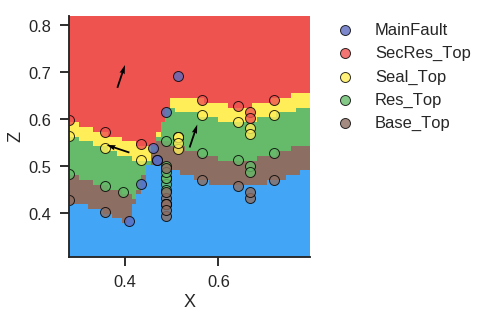

In [94]:
gp.plotting.plot_section(interp_data.geo_data_res, lith_block[0], 25, direction='y', plot_data=True)

No maxima found for surface.
SPILL POINT COORDINATES: [1360.          920.          988.26148987]
LEAK SELF Z-POSITION: 960.0
JUXTA with permable layers: []
SSF = 360.0 / 160.0 = 2.25
SSF in confidence range, complete shale smear sealing assumed.
CONTROL: SPILL Z
NUMBER OF POTENTIAL TRAPS 4
Checking Section: 4
Checking Section: 12
TRAP CONFIRMED: 12
Checking Section: 13
TRAP CONFIRMED: 13
Checking Section: 16
Maximum trap volume: 18048000.0 m³
TRAP VOXELS: 282


(18048000.0, 2.25, 1)

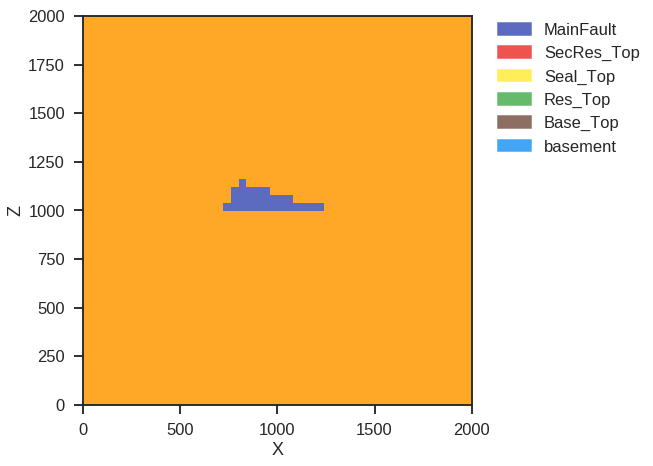

In [207]:
trap_analysis_post(lith_block, fault_block, print_figures=True)

In [67]:
#vol, SSF, tc = [],[],[]
#for i in np.arange(post.db.input_data.length()):
#    post.change_input_data(interp_data, i)
#    interp_data.interpolator.prepare_data_frame(interp_data.geo_data_res)
#    lith_sol, fault_sol = gp.compute_model(interp_data)
#    #gp.plotting.plot_section(interp_data.geo_data_res, lith_block[0], 25, plot_data=True)
#    v,s,c = trap_analysis_post(lith_sol, fault_sol, print_figures=True)
#    vol.append(v)
#    SSF.append(s)
#    tc.append(c)

In [68]:
#for i in np.arange(post.db.input_data.length()):
#    post.change_input_data(interp_data, i)
#    lith_sol, fault_sol = gp.compute_model(interp_data)
#    gp.plotting.plot_section(interp_data.geo_data_res, lith_sol[0], 25, plot_data=True)

# POSTERIOR MODEL

In [70]:
### LIKELIHOOD FUNCTIONS

# THICKNESS LIKELIHOODS
#Additional information, updating with likelihoods
std1 = 30
std2 = 30
std3 = 30

@pymc.stochastic()
def sec_res_th_likelihood(value = 0, sec_res_th=thicknesses[2]):
    return pymc.normal_like(sec_res_th, 150., 1./np.square(std1))

@pymc.stochastic()
def seal_th_likelihood(value = 0, seal_th=thicknesses[1]):
    return pymc.normal_like(seal_th, 350., 1./np.square(std2))

@pymc.stochastic()
def res_th_likelihood(value = 0, res_th=thicknesses[0]):
    return pymc.normal_like(res_th, 250., 1./np.square(std3))


# SSF LIKELIHOOD
@pymc.stochastic()
def SSF_likelihood(value = 0, SSF=trap_analysis[1]):
    return pymc.normal_like(SSF, 3, 1./np.square(0.3))


# JUXTAPOSITION AREA LIKELIHOOD (MOT USED)
#jux_mean = 150000
#jux_std = jux_mean/4
#
#@pymc.stochastic
#def jux_area_likelihood(value = 0, oja= over_jux_area):
#    return pymc.normal_like(over_jux_area, 150000., 1/np.square(jux_std))

In [65]:
iterations = 10

In [66]:
params = [input_data, thicknesses, gempy_model, *lith_Z_modifier, fault_Z_modifier]
model = pymc.Model(params)
#model = pymc.Model([interp_unc, z_unc_res_top, z_unc_base_top, z_unc_seal_top, z_unc_secres_top, offset_unc, structural_model, res_th, seal_th, sec_res_th, over_jux_area])

In [67]:
dbname="trapmodel_lithTH"+str(lith_unc_stds)+"_offset"+str(std_offset)+"_"+str(iterations)+"iterations"+".hdf5"

In [68]:
RUN = pymc.MCMC(model, db="hdf5", dbname=dbname)

In [69]:
RUN.sample(iter=iterations)

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be rei

 [---              10%                  ] 5 of 50 complete in 0.6 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be rei

 [------           16%                  ] 8 of 50 complete in 1.3 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be rei

 [--------         22%                  ] 11 of 50 complete in 1.8 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be rei

 [-----------      30%                  ] 15 of 50 complete in 2.4 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be rei

 [--------------   38%                  ] 19 of 50 complete in 2.9 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be rei

 [-----------------46%                  ] 23 of 50 complete in 3.4 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be rei

 [-----------------56%-                 ] 28 of 50 complete in 4.0 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be rei

 [-----------------66%-----             ] 33 of 50 complete in 4.6 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be rei

 [-----------------74%--------          ] 37 of 50 complete in 5.2 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be rei

 [-----------------82%-----------       ] 41 of 50 complete in 5.7 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be rei

 [-----------------90%--------------    ] 45 of 50 complete in 6.2 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be rei

 [-----------------100%-----------------] 50 of 50 complete in 6.8 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


 [-----------------100%-----------------] 50 of 50 complete in 6.9 sec

In [ ]:
# FOR EXPORTING TO USE IN PARAVIEW:
export = False

if export:
    counter = 0
    for i in structural_model_trace[:]:
        counter+=1
        #print(np.ascontiguousarray(i[3]))
        gp.export_vtk_rectilinear(geo_data, np.ascontiguousarray(i[3]), path="./output_data/trap_volumes/14_11-TRAP_100iterUNC_PRIORonly_%s" % (counter))
        gp.export_vtk_rectilinear(geo_data, np.ascontiguousarray(i[0][0]), path="./output_data/lith_blocks/14_11-LITH_100iterUNC_PRIORonly_%s" % (counter))

In [ ]:
#import graphviz
#pymc.graph.dag(model)

In [ ]:
#sys.path.append("/home/bl9/Theses/Risk\ analysis/Notebooks")
#graph = pymc.graph.graph(model)
#graph.write_png()